# Dogs vs. Cats

项目来自于Kaggle的[Dogs vs. Cats Redux:Kernel Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)竞赛。 训练数据可从[这里](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)下载

In [1]:
# import PIL
# from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle
import os
import math
import random
import zipfile 
import tensorflow as tf
import math
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from helper import *
from keras import optimizers

BATCH_SIZE = 128
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 数据处理
Kaggle的数据分为train和test两个数据包。解压train.zip后数据形式为：
* train/cat.{index}.jpg
* train/dog.{index}.jpg

猫狗各1,2500张图片(index 从0到12499)。每张图片尺寸不一，初步先预处理成200x200像素

### 解压缩 train.zip 和 test.zip 数据

In [3]:

if os.path.exists("data/train"):  
    print("Skip Unzipping cause folder ‘data/train’ is already exists.") 
else:  
#     os.makedirs("data/")  
    
    zip_file = zipfile.ZipFile("data/train.zip")  
    for names in tqdm(zip_file.namelist()):  
        zip_file.extract(names,"data/")  
    zip_file.close()  
    
    zip_file = zipfile.ZipFile("data/test.zip")  
    for names in tqdm(zip_file.namelist()):  
        zip_file.extract(names,"data/")  
    zip_file.close()  
    
    print("All Data unzipped")

100%|██████████| 12501/12501 [00:08<00:00, 1464.34it/s]

All Data unzipped


### 重新调整训练与测试数据文件结构
由于Keras的ImageGenerator需要特定的文件夹结构来读取分类信息，因此调整文件夹结构

In [12]:
import shutil

# data/
#     train2/
#         dog/
#             dog.1.jpg
#             ...
#         cat/
#             cat.1.jpg
#             ...
#     test2/
#         test/
#             cat.1.jpg
#             dog.1.jpg
#             ...


if not os.path.exists("data/train2"):
    train_filenames = os.listdir('data/train')

    filter_train_cat = filter(lambda x:x[:3] == "cat", train_filenames)
    filter_train_dog = filter(lambda x:x[:3] == "dog", train_filenames)
#     shutil.rmtree("data/train2")
    os.mkdir("data/train2")
    os.mkdir("data/train2/cat")
    os.mkdir("data/train2/dog")


    ##由于os.symlink创建的快捷方式在mac 本地无法读取，因此使用copy的方法生成图片
    for filename in filter_train_cat:
        shutil.copy("data/train/{}".format(filename),"data/train2/cat/{}".format(filename))

    for filename in filter_train_dog:
        shutil.copy("data/train/{}".format(filename),"data/train2/dog/{}".format(filename))


if not os.path.exists("data/test2"):
    shutil.copytree("data/test","data/test2/test")

print("Done")

Done


In [2]:
# data/splitted
#     train/
#         dog/
#             dog.1.jpg
#             ...
#         cat/
#             cat.1.jpg
#             ...
#     valid/
#         dog/
#             dog.1.jpg
#             ...
#         cat/
#             cat.1.jpg
#             ...

if not os.path.exists("data/splitted/train"):
    all_fileanmes = os.listdir('data/train')

    filter_cat = filter(lambda x:x[:3] == "cat", all_fileanmes)
    filter_dog = filter(lambda x:x[:3] == "dog", all_fileanmes)
    
    all_cats=[x for x in filter_cat]
    all_dogs=[x for x in filter_dog]
    
    train_cat,valid_cat = train_test_split(all_cats,test_size=0.2,random_state=2018)
    train_dog,valid_dog = train_test_split(all_dogs,test_size=0.2,random_state=2018)
       
    os.makedirs("data/splitted/train/dog")
    os.makedirs("data/splitted/train/cat")
    os.makedirs("data/splitted/valid/dog")
    os.makedirs("data/splitted/valid/cat")
    
    for filename in train_cat:
        shutil.copy("data/train/{}".format(filename),"data/splitted/train/cat/{}".format(filename))
    
    for filename in valid_cat:
        shutil.copy("data/train/{}".format(filename),"data/splitted/valid/cat/{}".format(filename))

    for filename in train_dog:
        shutil.copy("data/train/{}".format(filename),"data/splitted/train/dog/{}".format(filename))
    
    for filename in valid_dog:
        shutil.copy("data/train/{}".format(filename),"data/splitted/valid/dog/{}".format(filename))

print("Done")   

Done


# 迁移学习-完整迁移
迁移"VGG16","ResNet50","InceptionV3","Xception","InceptionResNetV2"对imagenet预训练的模型（不包括输出层），添加简单的GlobalAverage和dropout作为输出层。即被迁移的模型用来特征抓取，自建的输出层用来分类。

### 导出向量特征
首先使用被迁移的模型抓取图片特征，为了加快之后的分类器训练速度，把这些特征保存为向量文件。避免以后每次训练分类器时都要重复提取特征。

向量特征文件保存在 feature\_extract/original\_%modelname%.h5

In [4]:
make_dir_not_exist("feature_extract")
extract_feature_by_pretrainedModel(ResNet50, (224, 224),resnet50.preprocess_input)
extract_feature_by_pretrainedModel(InceptionV3, (299, 299), inception_v3.preprocess_input)
extract_feature_by_pretrainedModel(Xception, (299, 299), xception.preprocess_input)
extract_feature_by_pretrainedModel(InceptionResNetV2, (299, 299), inception_resnet_v2.preprocess_input)
extract_feature_by_pretrainedModel(VGG16,(224,224),vgg16.preprocess_input)

print("All Model Features Extracted")

========= Extract Featrues by InceptionV3 With GlobalAveragePool==========
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Extracting features from train data by InceptionV3 With GlobalAveragePool ...
196/196 [==============================] - 322s 2s/step
Extracting features from test data by InceptionV3 With GlobalAveragePool ...
98/98 [==============================] - 160s 2s/step
saving features to feature_extract/original_InceptionV3.h5
Feature saved for InceptionV3 With GlobalAveragePool

========= Extract Featrues by Xception With GlobalAveragePool==========
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Extracting features from train data by Xception With GlobalAveragePool ...
196/196 [==============================] - 514s 3s/step
Extracting features from test data by Xception With GlobalAveragePool ...
98/98 [==============================] - 257s 3s/step
saving features to feature_extract/original_

### 训练模型-完整迁移
逐个使用"VGG16","ResNet50","InceptionV3","Xception","InceptionResNetV2"抓取的特征向量，来训练分类器。并使用Tensorboard记录accuracy与loss。

Tensorboard Log文件保存在：

* logs/original/%modelname% - adadelta优化
* logs/original/%modelname%_sgd_lrxx_decayxx_momxx - SGD优化

Model 文件保存在 model/original_%modelname%_output

In [15]:
models = {}

learning_rate = 0.001
decay = 0
momentum=0.9
optimizer = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum,nesterov=True)

# optimizer = "adadelta"

for model_name in ["ResNet50"]:
    tensorboard_directory = "logs/original/%s_sgd_lr%s_decay%s_mom%s"%(model_name,learning_rate,decay,momentum)
    del_file_if_exist(tensorboard_directory)
    callbacks=[TensorBoard(tensorboard_directory,batch_size=BATCH_SIZE)]
    
    # i.e. models["VGG"]=(model,history)
    models[model_name] = fit_model_original_ouput(model_name,
                               epochs=40,
                               callbacks=callbacks,
                               auto_save=True,
                                optimizer=optimizer)

load features from 「original_ResNet50.h5」
model created
Train on 20000 samples, validate on 5000 samples
Epoch 1/40
20000/20000 [==============================] - 1s 38us/step - loss: 0.1486 - acc: 0.9410 - val_loss: 0.0553 - val_acc: 0.9808
Epoch 2/40
20000/20000 [==============================] - 1s 29us/step - loss: 0.0673 - acc: 0.9773 - val_loss: 0.0453 - val_acc: 0.9844
Epoch 3/40
20000/20000 [==============================] - 1s 30us/step - loss: 0.0574 - acc: 0.9792 - val_loss: 0.0418 - val_acc: 0.9852
Epoch 4/40
20000/20000 [==============================] - 1s 29us/step - loss: 0.0530 - acc: 0.9806 - val_loss: 0.0397 - val_acc: 0.9860
Epoch 5/40
20000/20000 [==============================] - 1s 29us/step - loss: 0.0482 - acc: 0.9824 - val_loss: 0.0384 - val_acc: 0.9864
Epoch 6/40
20000/20000 [==============================] - 1s 30us/step - loss: 0.0458 - acc: 0.9829 - val_loss: 0.0375 - val_acc: 0.9866
Epoch 7/40
20000/20000 [==============================] - 1s 29us/step - 

### 测试模型并导出CSV

In [16]:
for model_name in ["ResNet50"]:
    model = models[model_name][0]
    X_test = load_test_data(model_name)
    test_to_csv(model,X_test,get_filename(model_name,"original","sgd_lr0.001_mom_0.9",ext="csv"))

load test data from 「original_ResNet50.h5」
12500/12500 [==============================] - 0s 38us/step
Found 12500 images belonging to 1 classes.
   id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005
CSV文件已保存至csv_output/original_ResNet50_sgd_lr0.001_mom_0.9.csv


/home/ubuntu/cats_dogs/helper.py:486: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index - 1, 'label', predict[i])


---

# 迁移学习-合并迁移模型
尝试使用多个预训练模型作为特征提取工具，集合多个模型输出的特征向量，作为分类器的输入。从而提高分类的准确度，降低loss值

### 训练合并模型-Adadelta

In [9]:
from keras.callbacks import *
# merge_models_name = ["InceptionV3","Xception","ResNet50","VGG16","InceptionResNetV2"]
merge_models_name = ["InceptionV3","Xception","ResNet50","InceptionResNetV2"]
merged_name = "_".join(merge_models_name)
tensorboard_directory = "logs/merge/%s_epoch%s"%(merged_name,7)
del_file_if_exist(tensorboard_directory)

Xs,y = load_train_data_merge(model_names=merge_models_name)

model,history = fit_model_merge_output(Xs,y,
                                       merged_name = merged_name,
                                        epochs=7,
                                        callbacks=[TensorBoard(tensorboard_directory,batch_size=BATCH_SIZE)],
                                      auto_save=True)

 

load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
Train on 20000 samples, validate on 5000 samples
Epoch 1/7
20000/20000 [==============================] - 1s 45us/step - loss: 0.0717 - acc: 0.9755 - val_loss: 0.0237 - val_acc: 0.9920
Epoch 2/7
20000/20000 [==============================] - 1s 41us/step - loss: 0.0201 - acc: 0.9936 - val_loss: 0.0174 - val_acc: 0.9942
Epoch 3/7
20000/20000 [==============================] - 1s 41us/step - loss: 0.0166 - acc: 0.9950 - val_loss: 0.0163 - val_acc: 0.9946
Epoch 4/7
20000/20000 [==============================] - 1s 41us/step - loss: 0.0153 - acc: 0.9951 - val_loss: 0.0174 - val_acc: 0.9936
Epoch 5/7
20000/20000 [==============================] - 1s 41us/step - loss: 0.0130 - acc: 0.9959 - val_loss: 0.0167 - val_acc: 0.9950
Epoch 6/7
20000/20000 [==============================] - 1s 41us/step - loss: 0.0139 - acc: 0.9956 - val_loss: 0.0166 - val_acc:

### 绘制模型结构

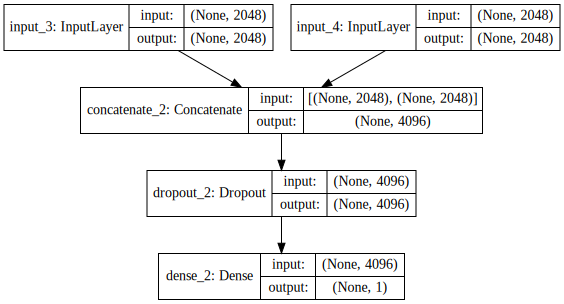

In [10]:
# 图形化输出模型结构
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 合并模型训练 - 完善SGD

In [9]:
# merge_models_name = ["InceptionV3","Xception","ResNet50","VGG16","InceptionResNetV2"]
merge_models_name = ["InceptionV3","Xception","ResNet50"]

Xs,y = load_train_data_merge(model_names=merge_models_name)

load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
load features from 「original_InceptionResNetV2.h5」


In [17]:
learn_rates=[0.001,0.0001]
momentums = [0.2,0.5,0.9]
decays = [1e-4,1e-5,1e-6]
max_epochs = 500
earlystop_patience = 7

#因为需要用Tensorboard 作为 callback记录数据，而在Sklearn的Gridsearch中不支持callback，所以这里手动循环参数，用tensorboard记录并寻找最佳的参数组合。
merged_name = "_".join(merge_models_name)
best_model = None
history_minloss = 100
for learning_rate in learn_rates:
    for momentum in momentums:
        for decay in decays:
            
            sgd = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum,nesterov=True)

            tensorboard_directory = "logs/merge/%s_lr%s_decay%s_momentum%s_nesterov"%(merged_name,learning_rate,decay,momentum)
            del_file_if_exist(tensorboard_directory)
            tensorboard = TensorBoard(tensorboard_directory,batch_size=BATCH_SIZE)
            earlyStop = EarlyStopping(monitor='val_loss', patience=earlystop_patience, verbose=1)
            checkpoint = ModelCheckpoint("model/merge_checkpoint/%s_lr%s_decay%s_momentum%s_nesterov"%(merged_name,learning_rate,decay,momentum),
                            monitor='val_loss', save_best_only=True, verbose=0)
            
            callbacks=[tensorboard,earlyStop,checkpoint]
            
            # i.e. models["VGG"]=(model,history)

            print("\nStart Fitting Merged Model %s \nwith lr:%s ,mom:%s , decay:%s"%(merged_name,learning_rate,momentum,decay))
            
            model,history = fit_model_merge_output(Xs,y,
                                       merged_name = merged_name,
                                        optimizer=sgd,
                                        epochs=max_epochs,
                                        callbacks=callbacks,
                                      auto_save=False)
            
            last_val_loss = history.history['val_loss'][-1]
            if history_minloss>last_val_loss:
                best_model = model
                history_minloss = last_val_loss
                print("The model is better than ever!")
                best_model.save("model/%s" % get_filename(merged_name, "merge", "output_sgd"))
            else:
                print("The model is not good enough")



Start Fitting Merged Model InceptionV3_Xception_ResNet50_InceptionResNetV2 
with lr:0.001 ,mom:0.2 , decay:0.0001
[(2048,), (2048,), (2048,), (1536,)]
model created
Train on 20000 samples, validate on 5000 samples
Epoch 1/500
20000/20000 [==============================] - 1s 54us/step - loss: 0.2280 - acc: 0.9331 - val_loss: 0.0889 - val_acc: 0.9868
Epoch 2/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0875 - acc: 0.9815 - val_loss: 0.0588 - val_acc: 0.9894
Epoch 3/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0637 - acc: 0.9867 - val_loss: 0.0474 - val_acc: 0.9910
Epoch 4/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0521 - acc: 0.9888 - val_loss: 0.0410 - val_acc: 0.9918
Epoch 5/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0474 - acc: 0.9882 - val_loss: 0.0369 - val_acc: 0.9922
Epoch 6/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0424 - acc: 0

Epoch 117/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0161 - acc: 0.9950 - val_loss: 0.0160 - val_acc: 0.9956
Epoch 118/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0166 - acc: 0.9947 - val_loss: 0.0160 - val_acc: 0.9956
Epoch 119/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0158 - acc: 0.9953 - val_loss: 0.0160 - val_acc: 0.9954
Epoch 120/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0162 - acc: 0.9949 - val_loss: 0.0160 - val_acc: 0.9956
Epoch 121/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0159 - acc: 0.9951 - val_loss: 0.0160 - val_acc: 0.9956
Epoch 122/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0156 - acc: 0.9946 - val_loss: 0.0160 - val_acc: 0.9956
Epoch 123/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0162 - acc: 0.9951 - val_loss: 0.0160 - val_acc: 0.9956
Epoch 124/500
20000/

20000/20000 [==============================] - 1s 45us/step - loss: 0.0193 - acc: 0.9941 - val_loss: 0.0180 - val_acc: 0.9948
Epoch 40/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0187 - acc: 0.9947 - val_loss: 0.0180 - val_acc: 0.9948
Epoch 41/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0194 - acc: 0.9943 - val_loss: 0.0180 - val_acc: 0.9948
Epoch 42/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0192 - acc: 0.9941 - val_loss: 0.0177 - val_acc: 0.9948
Epoch 43/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0176 - acc: 0.9946 - val_loss: 0.0177 - val_acc: 0.9948
Epoch 44/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0182 - acc: 0.9941 - val_loss: 0.0178 - val_acc: 0.9950
Epoch 45/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0174 - acc: 0.9949 - val_loss: 0.0176 - val_acc: 0.9948
Epoch 46/500
20000/20000 [==============

20000/20000 [==============================] - 1s 45us/step - loss: 0.0147 - acc: 0.9956 - val_loss: 0.0157 - val_acc: 0.9952
Epoch 99/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0147 - acc: 0.9954 - val_loss: 0.0157 - val_acc: 0.9952
Epoch 100/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0148 - acc: 0.9952 - val_loss: 0.0156 - val_acc: 0.9952
Epoch 101/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0154 - acc: 0.9950 - val_loss: 0.0155 - val_acc: 0.9952
Epoch 102/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0151 - acc: 0.9956 - val_loss: 0.0156 - val_acc: 0.9952
Epoch 103/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0145 - acc: 0.9960 - val_loss: 0.0156 - val_acc: 0.9952
Epoch 104/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0144 - acc: 0.9958 - val_loss: 0.0156 - val_acc: 0.9952
Epoch 105/500
20000/20000 [========

20000/20000 [==============================] - 1s 45us/step - loss: 0.0178 - acc: 0.9942 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 57/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0170 - acc: 0.9950 - val_loss: 0.0162 - val_acc: 0.9952
Epoch 58/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0168 - acc: 0.9951 - val_loss: 0.0162 - val_acc: 0.9952
Epoch 59/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0163 - acc: 0.9952 - val_loss: 0.0162 - val_acc: 0.9948
Epoch 60/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0169 - acc: 0.9946 - val_loss: 0.0161 - val_acc: 0.9952
Epoch 61/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0158 - acc: 0.9954 - val_loss: 0.0160 - val_acc: 0.9952
Epoch 62/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0160 - acc: 0.9955 - val_loss: 0.0160 - val_acc: 0.9952
Epoch 63/500
20000/20000 [==============

Epoch 115/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0139 - acc: 0.9959 - val_loss: 0.0150 - val_acc: 0.9956
Epoch 116/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0136 - acc: 0.9958 - val_loss: 0.0148 - val_acc: 0.9956
Epoch 117/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0138 - acc: 0.9955 - val_loss: 0.0149 - val_acc: 0.9956
Epoch 118/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0141 - acc: 0.9955 - val_loss: 0.0148 - val_acc: 0.9956
Epoch 119/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0131 - acc: 0.9961 - val_loss: 0.0148 - val_acc: 0.9958
Epoch 120/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0132 - acc: 0.9960 - val_loss: 0.0148 - val_acc: 0.9958
Epoch 121/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0130 - acc: 0.9960 - val_loss: 0.0148 - val_acc: 0.9958
Epoch 122/500
20000/

Epoch 36/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0179 - acc: 0.9946 - val_loss: 0.0173 - val_acc: 0.9956
Epoch 37/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0191 - acc: 0.9944 - val_loss: 0.0173 - val_acc: 0.9956
Epoch 38/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0185 - acc: 0.9950 - val_loss: 0.0174 - val_acc: 0.9950
Epoch 39/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0182 - acc: 0.9947 - val_loss: 0.0172 - val_acc: 0.9956
Epoch 40/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0184 - acc: 0.9942 - val_loss: 0.0172 - val_acc: 0.9954
Epoch 41/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0189 - acc: 0.9937 - val_loss: 0.0171 - val_acc: 0.9954
Epoch 42/500
20000/20000 [==============================] - 1s 48us/step - loss: 0.0175 - acc: 0.9947 - val_loss: 0.0171 - val_acc: 0.9954
Epoch 43/500
20000/20000 [=

Train on 20000 samples, validate on 5000 samples
Epoch 1/500
20000/20000 [==============================] - 1s 57us/step - loss: 0.1839 - acc: 0.9469 - val_loss: 0.0702 - val_acc: 0.9880
Epoch 2/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0663 - acc: 0.9861 - val_loss: 0.0476 - val_acc: 0.9900
Epoch 3/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0495 - acc: 0.9890 - val_loss: 0.0382 - val_acc: 0.9922
Epoch 4/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0418 - acc: 0.9901 - val_loss: 0.0334 - val_acc: 0.9928
Epoch 5/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0371 - acc: 0.9904 - val_loss: 0.0301 - val_acc: 0.9930
Epoch 6/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0339 - acc: 0.9913 - val_loss: 0.0279 - val_acc: 0.9932
Epoch 7/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0315 - acc: 0.9918 - val_loss: 0.0261 - v

20000/20000 [==============================] - 1s 45us/step - loss: 0.0176 - acc: 0.9947 - val_loss: 0.0167 - val_acc: 0.9948
Epoch 34/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0166 - acc: 0.9954 - val_loss: 0.0166 - val_acc: 0.9948
Epoch 35/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0167 - acc: 0.9952 - val_loss: 0.0166 - val_acc: 0.9948
Epoch 36/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0166 - acc: 0.9945 - val_loss: 0.0166 - val_acc: 0.9948
Epoch 37/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0166 - acc: 0.9949 - val_loss: 0.0164 - val_acc: 0.9948
Epoch 38/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0167 - acc: 0.9950 - val_loss: 0.0164 - val_acc: 0.9948
Epoch 39/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0165 - acc: 0.9952 - val_loss: 0.0164 - val_acc: 0.9948
Epoch 40/500
20000/20000 [==============

20000/20000 [==============================] - 1s 46us/step - loss: 0.0099 - acc: 0.9969 - val_loss: 0.0142 - val_acc: 0.9950
Epoch 42/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0102 - acc: 0.9967 - val_loss: 0.0144 - val_acc: 0.9960
Epoch 43/500
20000/20000 [==============================] - 1s 48us/step - loss: 0.0096 - acc: 0.9970 - val_loss: 0.0142 - val_acc: 0.9952
Epoch 44/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0100 - acc: 0.9970 - val_loss: 0.0146 - val_acc: 0.9958
Epoch 45/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0107 - acc: 0.9968 - val_loss: 0.0146 - val_acc: 0.9960
Epoch 46/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0099 - acc: 0.9970 - val_loss: 0.0143 - val_acc: 0.9954
Epoch 47/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0094 - acc: 0.9970 - val_loss: 0.0144 - val_acc: 0.9960
Epoch 48/500
20000/20000 [==============

model created
Train on 20000 samples, validate on 5000 samples
Epoch 1/500
20000/20000 [==============================] - 1s 60us/step - loss: 0.6236 - acc: 0.6549 - val_loss: 0.4244 - val_acc: 0.8930
Epoch 2/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.3899 - acc: 0.8614 - val_loss: 0.2866 - val_acc: 0.9692
Epoch 3/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.2865 - acc: 0.9267 - val_loss: 0.2184 - val_acc: 0.9794
Epoch 4/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.2298 - acc: 0.9506 - val_loss: 0.1788 - val_acc: 0.9828
Epoch 5/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.1952 - acc: 0.9617 - val_loss: 0.1531 - val_acc: 0.9848
Epoch 6/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.1693 - acc: 0.9672 - val_loss: 0.1353 - val_acc: 0.9860
Epoch 7/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.1534 - acc: 0.9718 - val_lo

Epoch 118/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0373 - acc: 0.9917 - val_loss: 0.0328 - val_acc: 0.9930
Epoch 119/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0382 - acc: 0.9909 - val_loss: 0.0327 - val_acc: 0.9930
Epoch 120/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0372 - acc: 0.9909 - val_loss: 0.0326 - val_acc: 0.9930
Epoch 121/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0372 - acc: 0.9906 - val_loss: 0.0325 - val_acc: 0.9930
Epoch 122/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0374 - acc: 0.9906 - val_loss: 0.0325 - val_acc: 0.9930
Epoch 123/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0371 - acc: 0.9913 - val_loss: 0.0324 - val_acc: 0.9930
Epoch 124/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0371 - acc: 0.9912 - val_loss: 0.0323 - val_acc: 0.9930
Epoch 125/500
20000/

20000/20000 [==============================] - 1s 46us/step - loss: 0.0312 - acc: 0.9921 - val_loss: 0.0280 - val_acc: 0.9932
Epoch 235/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0319 - acc: 0.9911 - val_loss: 0.0280 - val_acc: 0.9932
Epoch 236/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0311 - acc: 0.9925 - val_loss: 0.0279 - val_acc: 0.9932
Epoch 237/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0310 - acc: 0.9916 - val_loss: 0.0279 - val_acc: 0.9932
Epoch 238/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0312 - acc: 0.9922 - val_loss: 0.0279 - val_acc: 0.9932
Epoch 239/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0319 - acc: 0.9914 - val_loss: 0.0279 - val_acc: 0.9932
Epoch 240/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0303 - acc: 0.9927 - val_loss: 0.0278 - val_acc: 0.9932
Epoch 241/500
20000/20000 [=======

20000/20000 [==============================] - 1s 45us/step - loss: 0.0287 - acc: 0.9921 - val_loss: 0.0260 - val_acc: 0.9934
Epoch 351/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0299 - acc: 0.9916 - val_loss: 0.0260 - val_acc: 0.9934
Epoch 352/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0296 - acc: 0.9924 - val_loss: 0.0260 - val_acc: 0.9934
Epoch 353/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0289 - acc: 0.9919 - val_loss: 0.0260 - val_acc: 0.9934
Epoch 354/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0296 - acc: 0.9918 - val_loss: 0.0260 - val_acc: 0.9934
Epoch 355/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0298 - acc: 0.9924 - val_loss: 0.0260 - val_acc: 0.9934
Epoch 356/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0290 - acc: 0.9923 - val_loss: 0.0260 - val_acc: 0.9934
Epoch 357/500
20000/20000 [=======

20000/20000 [==============================] - 1s 50us/step - loss: 0.0279 - acc: 0.9924 - val_loss: 0.0249 - val_acc: 0.9934
Epoch 467/500
20000/20000 [==============================] - 1s 49us/step - loss: 0.0281 - acc: 0.9921 - val_loss: 0.0249 - val_acc: 0.9934
Epoch 468/500
20000/20000 [==============================] - 1s 48us/step - loss: 0.0282 - acc: 0.9923 - val_loss: 0.0249 - val_acc: 0.9934
Epoch 469/500
20000/20000 [==============================] - 1s 48us/step - loss: 0.0269 - acc: 0.9932 - val_loss: 0.0249 - val_acc: 0.9934
Epoch 470/500
20000/20000 [==============================] - 1s 48us/step - loss: 0.0275 - acc: 0.9919 - val_loss: 0.0249 - val_acc: 0.9934
Epoch 471/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0281 - acc: 0.9919 - val_loss: 0.0249 - val_acc: 0.9934
Epoch 472/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0277 - acc: 0.9922 - val_loss: 0.0249 - val_acc: 0.9934
Epoch 473/500
20000/20000 [=======

20000/20000 [==============================] - 1s 46us/step - loss: 0.0352 - acc: 0.9909 - val_loss: 0.0281 - val_acc: 0.9938
Epoch 83/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0336 - acc: 0.9912 - val_loss: 0.0279 - val_acc: 0.9938
Epoch 84/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0343 - acc: 0.9911 - val_loss: 0.0278 - val_acc: 0.9938
Epoch 85/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0339 - acc: 0.9915 - val_loss: 0.0277 - val_acc: 0.9938
Epoch 86/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0345 - acc: 0.9912 - val_loss: 0.0275 - val_acc: 0.9938
Epoch 87/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0342 - acc: 0.9916 - val_loss: 0.0274 - val_acc: 0.9938
Epoch 88/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0330 - acc: 0.9920 - val_loss: 0.0273 - val_acc: 0.9938
Epoch 89/500
20000/20000 [==============

Epoch 141/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0272 - acc: 0.9923 - val_loss: 0.0231 - val_acc: 0.9946
Epoch 142/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0288 - acc: 0.9921 - val_loss: 0.0230 - val_acc: 0.9946
Epoch 143/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0275 - acc: 0.9926 - val_loss: 0.0230 - val_acc: 0.9946
Epoch 144/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0282 - acc: 0.9919 - val_loss: 0.0229 - val_acc: 0.9946
Epoch 145/500
20000/20000 [==============================] - 1s 48us/step - loss: 0.0276 - acc: 0.9931 - val_loss: 0.0229 - val_acc: 0.9948
Epoch 146/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0273 - acc: 0.9928 - val_loss: 0.0228 - val_acc: 0.9948
Epoch 147/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0274 - acc: 0.9927 - val_loss: 0.0228 - val_acc: 0.9948
Epoch 148/500
20000/

20000/20000 [==============================] - 1s 46us/step - loss: 0.0229 - acc: 0.9932 - val_loss: 0.0194 - val_acc: 0.9950
Epoch 258/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0224 - acc: 0.9937 - val_loss: 0.0194 - val_acc: 0.9948
Epoch 259/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0225 - acc: 0.9935 - val_loss: 0.0194 - val_acc: 0.9948
Epoch 260/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0231 - acc: 0.9934 - val_loss: 0.0194 - val_acc: 0.9950
Epoch 261/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0227 - acc: 0.9937 - val_loss: 0.0194 - val_acc: 0.9948
Epoch 262/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0228 - acc: 0.9937 - val_loss: 0.0194 - val_acc: 0.9948
Epoch 263/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0227 - acc: 0.9934 - val_loss: 0.0193 - val_acc: 0.9948
Epoch 264/500
20000/20000 [=======

20000/20000 [==============================] - 1s 51us/step - loss: 0.0204 - acc: 0.9941 - val_loss: 0.0179 - val_acc: 0.9950
Epoch 374/500
20000/20000 [==============================] - 1s 52us/step - loss: 0.0200 - acc: 0.9946 - val_loss: 0.0179 - val_acc: 0.9950
Epoch 375/500
20000/20000 [==============================] - 1s 51us/step - loss: 0.0206 - acc: 0.9938 - val_loss: 0.0179 - val_acc: 0.9950
Epoch 376/500
20000/20000 [==============================] - 1s 51us/step - loss: 0.0203 - acc: 0.9938 - val_loss: 0.0179 - val_acc: 0.9950
Epoch 377/500
20000/20000 [==============================] - 1s 52us/step - loss: 0.0206 - acc: 0.9944 - val_loss: 0.0179 - val_acc: 0.9950
Epoch 378/500
20000/20000 [==============================] - 1s 51us/step - loss: 0.0203 - acc: 0.9941 - val_loss: 0.0179 - val_acc: 0.9950
Epoch 379/500
20000/20000 [==============================] - 1s 51us/step - loss: 0.0198 - acc: 0.9944 - val_loss: 0.0179 - val_acc: 0.9950
Epoch 380/500
20000/20000 [=======

20000/20000 [==============================] - 1s 47us/step - loss: 0.0191 - acc: 0.9942 - val_loss: 0.0171 - val_acc: 0.9950
Epoch 490/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0183 - acc: 0.9946 - val_loss: 0.0171 - val_acc: 0.9950
Epoch 491/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0184 - acc: 0.9947 - val_loss: 0.0171 - val_acc: 0.9950
Epoch 492/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0194 - acc: 0.9941 - val_loss: 0.0171 - val_acc: 0.9950
Epoch 493/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0190 - acc: 0.9941 - val_loss: 0.0171 - val_acc: 0.9950
Epoch 494/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0187 - acc: 0.9944 - val_loss: 0.0171 - val_acc: 0.9950
Epoch 495/500
20000/20000 [==============================] - 1s 50us/step - loss: 0.0199 - acc: 0.9944 - val_loss: 0.0171 - val_acc: 0.9950
Epoch 496/500
20000/20000 [=======

Epoch 105/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0314 - acc: 0.9923 - val_loss: 0.0271 - val_acc: 0.9938
Epoch 106/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0314 - acc: 0.9914 - val_loss: 0.0270 - val_acc: 0.9938
Epoch 107/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0310 - acc: 0.9919 - val_loss: 0.0269 - val_acc: 0.9936
Epoch 108/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0314 - acc: 0.9914 - val_loss: 0.0269 - val_acc: 0.9936
Epoch 109/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0312 - acc: 0.9916 - val_loss: 0.0268 - val_acc: 0.9936
Epoch 110/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0303 - acc: 0.9920 - val_loss: 0.0267 - val_acc: 0.9936
Epoch 111/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0309 - acc: 0.9917 - val_loss: 0.0266 - val_acc: 0.9938
Epoch 112/500
20000/

20000/20000 [==============================] - 1s 46us/step - loss: 0.0236 - acc: 0.9935 - val_loss: 0.0209 - val_acc: 0.9948
Epoch 222/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0241 - acc: 0.9931 - val_loss: 0.0209 - val_acc: 0.9948
Epoch 223/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0241 - acc: 0.9929 - val_loss: 0.0209 - val_acc: 0.9948
Epoch 224/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0228 - acc: 0.9937 - val_loss: 0.0208 - val_acc: 0.9948
Epoch 225/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0234 - acc: 0.9935 - val_loss: 0.0208 - val_acc: 0.9948
Epoch 226/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0226 - acc: 0.9933 - val_loss: 0.0208 - val_acc: 0.9948
Epoch 227/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0236 - acc: 0.9932 - val_loss: 0.0208 - val_acc: 0.9948
Epoch 228/500
20000/20000 [=======

20000/20000 [==============================] - 1s 54us/step - loss: 0.0203 - acc: 0.9941 - val_loss: 0.0187 - val_acc: 0.9950
Epoch 338/500
20000/20000 [==============================] - 1s 51us/step - loss: 0.0196 - acc: 0.9942 - val_loss: 0.0188 - val_acc: 0.9948
Epoch 339/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0200 - acc: 0.9938 - val_loss: 0.0187 - val_acc: 0.9948
Epoch 340/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0195 - acc: 0.9937 - val_loss: 0.0187 - val_acc: 0.9948
Epoch 341/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0199 - acc: 0.9938 - val_loss: 0.0187 - val_acc: 0.9948
Epoch 342/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0202 - acc: 0.9938 - val_loss: 0.0187 - val_acc: 0.9948
Epoch 343/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0197 - acc: 0.9944 - val_loss: 0.0187 - val_acc: 0.9948
Epoch 344/500
20000/20000 [=======

20000/20000 [==============================] - 1s 45us/step - loss: 0.0196 - acc: 0.9937 - val_loss: 0.0176 - val_acc: 0.9946
Epoch 454/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0182 - acc: 0.9946 - val_loss: 0.0176 - val_acc: 0.9946
Epoch 455/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0180 - acc: 0.9944 - val_loss: 0.0176 - val_acc: 0.9946
Epoch 456/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0178 - acc: 0.9946 - val_loss: 0.0176 - val_acc: 0.9946
Epoch 457/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0189 - acc: 0.9941 - val_loss: 0.0176 - val_acc: 0.9946
Epoch 458/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0179 - acc: 0.9948 - val_loss: 0.0176 - val_acc: 0.9946
Epoch 459/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0178 - acc: 0.9944 - val_loss: 0.0176 - val_acc: 0.9946
Epoch 460/500
20000/20000 [=======

Epoch 10/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0896 - acc: 0.9825 - val_loss: 0.0746 - val_acc: 0.9858
Epoch 11/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0843 - acc: 0.9838 - val_loss: 0.0707 - val_acc: 0.9864
Epoch 12/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0794 - acc: 0.9840 - val_loss: 0.0673 - val_acc: 0.9868
Epoch 13/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0762 - acc: 0.9842 - val_loss: 0.0645 - val_acc: 0.9876
Epoch 14/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0726 - acc: 0.9860 - val_loss: 0.0620 - val_acc: 0.9880
Epoch 15/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0704 - acc: 0.9854 - val_loss: 0.0597 - val_acc: 0.9882
Epoch 16/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0695 - acc: 0.9848 - val_loss: 0.0578 - val_acc: 0.9886
Epoch 17/500
20000/20000 [=

Epoch 69/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0366 - acc: 0.9901 - val_loss: 0.0313 - val_acc: 0.9926
Epoch 70/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0351 - acc: 0.9917 - val_loss: 0.0311 - val_acc: 0.9926
Epoch 71/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0366 - acc: 0.9910 - val_loss: 0.0310 - val_acc: 0.9926
Epoch 72/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0348 - acc: 0.9914 - val_loss: 0.0309 - val_acc: 0.9926
Epoch 73/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0359 - acc: 0.9909 - val_loss: 0.0307 - val_acc: 0.9926
Epoch 74/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0357 - acc: 0.9905 - val_loss: 0.0306 - val_acc: 0.9926
Epoch 75/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0352 - acc: 0.9914 - val_loss: 0.0305 - val_acc: 0.9926
Epoch 76/500
20000/20000 [=

Epoch 128/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0299 - acc: 0.9920 - val_loss: 0.0263 - val_acc: 0.9936
Epoch 129/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0293 - acc: 0.9923 - val_loss: 0.0262 - val_acc: 0.9936
Epoch 130/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0292 - acc: 0.9917 - val_loss: 0.0262 - val_acc: 0.9936
Epoch 131/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0302 - acc: 0.9922 - val_loss: 0.0261 - val_acc: 0.9936
Epoch 132/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0296 - acc: 0.9925 - val_loss: 0.0261 - val_acc: 0.9936
Epoch 133/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0300 - acc: 0.9914 - val_loss: 0.0260 - val_acc: 0.9938
Epoch 134/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0293 - acc: 0.9922 - val_loss: 0.0260 - val_acc: 0.9938
Epoch 135/500
20000/

20000/20000 [==============================] - 1s 46us/step - loss: 0.0268 - acc: 0.9923 - val_loss: 0.0230 - val_acc: 0.9948
Epoch 245/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0247 - acc: 0.9936 - val_loss: 0.0230 - val_acc: 0.9948
Epoch 246/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0260 - acc: 0.9929 - val_loss: 0.0230 - val_acc: 0.9948
Epoch 247/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0259 - acc: 0.9926 - val_loss: 0.0229 - val_acc: 0.9948
Epoch 248/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0261 - acc: 0.9924 - val_loss: 0.0229 - val_acc: 0.9948
Epoch 249/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0259 - acc: 0.9930 - val_loss: 0.0229 - val_acc: 0.9948
Epoch 250/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0262 - acc: 0.9923 - val_loss: 0.0229 - val_acc: 0.9948
Epoch 251/500
20000/20000 [=======

20000/20000 [==============================] - 1s 45us/step - loss: 0.0248 - acc: 0.9928 - val_loss: 0.0216 - val_acc: 0.9948
Epoch 361/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0246 - acc: 0.9931 - val_loss: 0.0216 - val_acc: 0.9948
Epoch 362/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0244 - acc: 0.9931 - val_loss: 0.0216 - val_acc: 0.9950
Epoch 363/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0242 - acc: 0.9936 - val_loss: 0.0216 - val_acc: 0.9950
Epoch 364/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0240 - acc: 0.9934 - val_loss: 0.0216 - val_acc: 0.9950
Epoch 365/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0239 - acc: 0.9935 - val_loss: 0.0216 - val_acc: 0.9950
Epoch 366/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0243 - acc: 0.9928 - val_loss: 0.0216 - val_acc: 0.9950
Epoch 367/500
20000/20000 [=======

20000/20000 [==============================] - 1s 45us/step - loss: 0.0229 - acc: 0.9938 - val_loss: 0.0208 - val_acc: 0.9950
Epoch 477/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0224 - acc: 0.9938 - val_loss: 0.0208 - val_acc: 0.9950
Epoch 478/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0224 - acc: 0.9941 - val_loss: 0.0208 - val_acc: 0.9950
Epoch 479/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0244 - acc: 0.9931 - val_loss: 0.0208 - val_acc: 0.9950
Epoch 480/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0231 - acc: 0.9931 - val_loss: 0.0208 - val_acc: 0.9950
Epoch 481/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0228 - acc: 0.9935 - val_loss: 0.0208 - val_acc: 0.9950
Epoch 482/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0227 - acc: 0.9938 - val_loss: 0.0208 - val_acc: 0.9950
Epoch 483/500
20000/20000 [=======

20000/20000 [==============================] - 1s 45us/step - loss: 0.0273 - acc: 0.9931 - val_loss: 0.0248 - val_acc: 0.9932
Epoch 93/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0274 - acc: 0.9924 - val_loss: 0.0247 - val_acc: 0.9932
Epoch 94/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0264 - acc: 0.9922 - val_loss: 0.0246 - val_acc: 0.9932
Epoch 95/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0267 - acc: 0.9927 - val_loss: 0.0245 - val_acc: 0.9932
Epoch 96/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0274 - acc: 0.9924 - val_loss: 0.0244 - val_acc: 0.9932
Epoch 97/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0270 - acc: 0.9928 - val_loss: 0.0244 - val_acc: 0.9932
Epoch 98/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0253 - acc: 0.9931 - val_loss: 0.0243 - val_acc: 0.9932
Epoch 99/500
20000/20000 [==============

20000/20000 [==============================] - 1s 45us/step - loss: 0.0215 - acc: 0.9935 - val_loss: 0.0199 - val_acc: 0.9942
Epoch 209/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0204 - acc: 0.9940 - val_loss: 0.0199 - val_acc: 0.9942
Epoch 210/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0206 - acc: 0.9941 - val_loss: 0.0199 - val_acc: 0.9942
Epoch 211/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0212 - acc: 0.9941 - val_loss: 0.0199 - val_acc: 0.9942
Epoch 212/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0206 - acc: 0.9940 - val_loss: 0.0199 - val_acc: 0.9942
Epoch 213/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0208 - acc: 0.9942 - val_loss: 0.0198 - val_acc: 0.9942
Epoch 214/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0213 - acc: 0.9935 - val_loss: 0.0198 - val_acc: 0.9942
Epoch 215/500
20000/20000 [=======

20000/20000 [==============================] - 1s 45us/step - loss: 0.0179 - acc: 0.9946 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 325/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0186 - acc: 0.9950 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 326/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0191 - acc: 0.9944 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 327/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0185 - acc: 0.9946 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 328/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0181 - acc: 0.9942 - val_loss: 0.0183 - val_acc: 0.9946
Epoch 329/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0188 - acc: 0.9944 - val_loss: 0.0183 - val_acc: 0.9946
Epoch 330/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0187 - acc: 0.9944 - val_loss: 0.0183 - val_acc: 0.9946
Epoch 331/500
20000/20000 [=======

Epoch 13/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0704 - acc: 0.9867 - val_loss: 0.0565 - val_acc: 0.9910
Epoch 14/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0679 - acc: 0.9859 - val_loss: 0.0542 - val_acc: 0.9910
Epoch 15/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0653 - acc: 0.9873 - val_loss: 0.0522 - val_acc: 0.9910
Epoch 16/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0625 - acc: 0.9867 - val_loss: 0.0503 - val_acc: 0.9910
Epoch 17/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0588 - acc: 0.9882 - val_loss: 0.0487 - val_acc: 0.9910
Epoch 18/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0593 - acc: 0.9871 - val_loss: 0.0472 - val_acc: 0.9910
Epoch 19/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0573 - acc: 0.9890 - val_loss: 0.0458 - val_acc: 0.9912
Epoch 20/500
20000/20000 [=

Epoch 72/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0303 - acc: 0.9920 - val_loss: 0.0251 - val_acc: 0.9942
Epoch 73/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0290 - acc: 0.9923 - val_loss: 0.0250 - val_acc: 0.9942
Epoch 74/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0295 - acc: 0.9921 - val_loss: 0.0249 - val_acc: 0.9942
Epoch 75/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0288 - acc: 0.9923 - val_loss: 0.0248 - val_acc: 0.9942
Epoch 76/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0292 - acc: 0.9922 - val_loss: 0.0247 - val_acc: 0.9942
Epoch 77/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0287 - acc: 0.9925 - val_loss: 0.0246 - val_acc: 0.9944
Epoch 78/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0285 - acc: 0.9929 - val_loss: 0.0245 - val_acc: 0.9944
Epoch 79/500
20000/20000 [=

Epoch 131/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0234 - acc: 0.9934 - val_loss: 0.0207 - val_acc: 0.9954
Epoch 132/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0241 - acc: 0.9929 - val_loss: 0.0206 - val_acc: 0.9954
Epoch 133/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0237 - acc: 0.9935 - val_loss: 0.0206 - val_acc: 0.9954
Epoch 134/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0229 - acc: 0.9937 - val_loss: 0.0205 - val_acc: 0.9954
Epoch 135/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0224 - acc: 0.9938 - val_loss: 0.0205 - val_acc: 0.9954
Epoch 136/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0224 - acc: 0.9940 - val_loss: 0.0205 - val_acc: 0.9954
Epoch 137/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0237 - acc: 0.9931 - val_loss: 0.0204 - val_acc: 0.9954
Epoch 138/500
20000/

20000/20000 [==============================] - 1s 49us/step - loss: 0.0190 - acc: 0.9946 - val_loss: 0.0177 - val_acc: 0.9956
Epoch 248/500
20000/20000 [==============================] - 1s 50us/step - loss: 0.0196 - acc: 0.9937 - val_loss: 0.0177 - val_acc: 0.9956
Epoch 249/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0187 - acc: 0.9948 - val_loss: 0.0177 - val_acc: 0.9956
Epoch 250/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0185 - acc: 0.9943 - val_loss: 0.0176 - val_acc: 0.9956
Epoch 251/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0186 - acc: 0.9942 - val_loss: 0.0176 - val_acc: 0.9956
Epoch 252/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0185 - acc: 0.9949 - val_loss: 0.0176 - val_acc: 0.9956
Epoch 253/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0185 - acc: 0.9942 - val_loss: 0.0176 - val_acc: 0.9956
Epoch 254/500
20000/20000 [=======

20000/20000 [==============================] - 1s 45us/step - loss: 0.0170 - acc: 0.9947 - val_loss: 0.0165 - val_acc: 0.9958
Epoch 364/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0175 - acc: 0.9946 - val_loss: 0.0165 - val_acc: 0.9958
Epoch 365/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0173 - acc: 0.9946 - val_loss: 0.0165 - val_acc: 0.9958
Epoch 366/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0171 - acc: 0.9955 - val_loss: 0.0165 - val_acc: 0.9958
Epoch 367/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0171 - acc: 0.9946 - val_loss: 0.0165 - val_acc: 0.9958
Epoch 368/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0170 - acc: 0.9948 - val_loss: 0.0165 - val_acc: 0.9958
Epoch 369/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0174 - acc: 0.9950 - val_loss: 0.0165 - val_acc: 0.9958
Epoch 370/500
20000/20000 [=======

20000/20000 [==============================] - 1s 45us/step - loss: 0.0157 - acc: 0.9948 - val_loss: 0.0159 - val_acc: 0.9962
Epoch 480/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0155 - acc: 0.9955 - val_loss: 0.0159 - val_acc: 0.9962
Epoch 481/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0156 - acc: 0.9950 - val_loss: 0.0159 - val_acc: 0.9962
Epoch 482/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0159 - acc: 0.9954 - val_loss: 0.0159 - val_acc: 0.9962
Epoch 483/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0165 - acc: 0.9952 - val_loss: 0.0159 - val_acc: 0.9962
Epoch 484/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0149 - acc: 0.9959 - val_loss: 0.0159 - val_acc: 0.9962
Epoch 485/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0143 - acc: 0.9955 - val_loss: 0.0159 - val_acc: 0.9962
Epoch 486/500
20000/20000 [=======

20000/20000 [==============================] - 1s 45us/step - loss: 0.0177 - acc: 0.9947 - val_loss: 0.0177 - val_acc: 0.9946
Epoch 96/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0179 - acc: 0.9946 - val_loss: 0.0177 - val_acc: 0.9948
Epoch 97/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0174 - acc: 0.9949 - val_loss: 0.0177 - val_acc: 0.9946
Epoch 98/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0178 - acc: 0.9949 - val_loss: 0.0177 - val_acc: 0.9946
Epoch 99/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0171 - acc: 0.9949 - val_loss: 0.0177 - val_acc: 0.9946
Epoch 100/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0174 - acc: 0.9947 - val_loss: 0.0177 - val_acc: 0.9946
Epoch 101/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0175 - acc: 0.9949 - val_loss: 0.0176 - val_acc: 0.9948
Epoch 102/500
20000/20000 [===========

20000/20000 [==============================] - 1s 44us/step - loss: 0.0158 - acc: 0.9949 - val_loss: 0.0164 - val_acc: 0.9948
Epoch 212/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0153 - acc: 0.9953 - val_loss: 0.0164 - val_acc: 0.9948
Epoch 213/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0156 - acc: 0.9951 - val_loss: 0.0164 - val_acc: 0.9948
Epoch 214/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0152 - acc: 0.9950 - val_loss: 0.0164 - val_acc: 0.9948
Epoch 00214: early stopping
The model is not good enough

Start Fitting Merged Model InceptionV3_Xception_ResNet50_InceptionResNetV2 
with lr:0.0001 ,mom:0.9 , decay:1e-05
[(2048,), (2048,), (2048,), (1536,)]
model created
Train on 20000 samples, validate on 5000 samples
Epoch 1/500
20000/20000 [==============================] - 1s 62us/step - loss: 0.2490 - acc: 0.9209 - val_loss: 0.1028 - val_acc: 0.9844
Epoch 2/500
20000/20000 [===================

Epoch 39/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0205 - acc: 0.9935 - val_loss: 0.0191 - val_acc: 0.9944
Epoch 40/500
20000/20000 [==============================] - 1s 47us/step - loss: 0.0202 - acc: 0.9944 - val_loss: 0.0189 - val_acc: 0.9946
Epoch 41/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0202 - acc: 0.9943 - val_loss: 0.0188 - val_acc: 0.9944
Epoch 42/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0202 - acc: 0.9940 - val_loss: 0.0187 - val_acc: 0.9944
Epoch 43/500
20000/20000 [==============================] - 1s 46us/step - loss: 0.0205 - acc: 0.9933 - val_loss: 0.0187 - val_acc: 0.9946
Epoch 44/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0204 - acc: 0.9937 - val_loss: 0.0185 - val_acc: 0.9944
Epoch 45/500
20000/20000 [==============================] - 1s 48us/step - loss: 0.0192 - acc: 0.9946 - val_loss: 0.0185 - val_acc: 0.9944
Epoch 46/500
20000/20000 [=

Epoch 98/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0160 - acc: 0.9950 - val_loss: 0.0161 - val_acc: 0.9946
Epoch 99/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0150 - acc: 0.9953 - val_loss: 0.0161 - val_acc: 0.9944
Epoch 100/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0155 - acc: 0.9951 - val_loss: 0.0160 - val_acc: 0.9946
Epoch 101/500
20000/20000 [==============================] - 1s 45us/step - loss: 0.0159 - acc: 0.9946 - val_loss: 0.0161 - val_acc: 0.9944
Epoch 102/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0153 - acc: 0.9955 - val_loss: 0.0160 - val_acc: 0.9944
Epoch 103/500
20000/20000 [==============================] - 1s 44us/step - loss: 0.0150 - acc: 0.9953 - val_loss: 0.0160 - val_acc: 0.9944
Epoch 104/500
20000/20000 [==============================] - 1s 53us/step - loss: 0.0158 - acc: 0.9950 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 105/500
20000/20

### 合并模型训练 - HyperOpt 参数优化

In [20]:
from kopt import CompileFN, KMongoTrials, test_fn
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from helper import *




# 1. define the data function returning training, (validation, test) data

def data(model_name):
    Xs,y = load_train_data_merge(model_name)
    return (Xs, y),


# 2. Define the model function returning a compiled Keras model
def model(train_data, lr=0.001, decay=0, momentum=0.9, dropout=0.5):
    # extract data dimensions
    input_shapes = []
    Xs = train_data[0]
    for feature in Xs:
        input_shapes.append(feature.shape[1:])

    sgd = SGD(lr=lr, decay=decay, momentum=momentum)
    model = create_model_merge_output(input_shapes, optimizer=sgd, drop_rate=dropout)

    return model


# Specify the optimization metrics
db_name = "merge"
exp_name = "myexp1"
objective = CompileFN(db_name, exp_name,
                      data_fn=data,
                      model_fn=model,
                      loss_metric="loss", # which metric to optimize for
                      loss_metric_mode="min",  # try to maximize the metric
                      valid_split=.2,  # use 20% of the training data for the validation set
                      save_dir="model/hyperopt/")  # place to store the models

# define the hyper-parameter ranges
# see https://github.com/hyperopt/hyperopt/wiki/FMin for more info
hyper_params = {
    "data": {
        "model_name" : ["InceptionV3","Xception","ResNet50"]
    },
        "model": {
        "lr": hp.loguniform("m_lr", np.log(0.001), np.log(0.01)),  # 0.001 - 0.01
        "decay": hp.uniform("m_decay", 0.0005, 0.05),
        "momentum": hp.choice("m_mom", [0.5,0.8,0.9]),
        "dropout": hp.choice("m_do",[ 0.1,0.2,0.3,0.5]),
    },
    "fit": {
        "batch_size": 128,
        "epochs": 200,
        "patience": 8
    }
}

**【注意该块代码需要4~5小时运行时间，如需简单验证请调低fmin函数的max_evals函数，以便减少需要测试的超参数组合数】**

In [21]:
# test_fn(objective, hyper_params)

trials = Trials()
best = fmin(objective, hyper_params, trials=trials, algo=tpe.suggest, max_evals=100)



2018-03-27 08:47:19,462 [INFO] tpe_transform took 0.002131 seconds
2018-03-27 08:47:19,463 [INFO] TPE using 0 trials
2018-03-27 08:47:19,466 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 08:47:20,464 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.0450 - acc: 0.9824 - val_loss: 0.0288 - val_acc: 0.9900
Epoch 2/200
 - 1s - loss: 0.0222 - acc: 0.9929 - val_loss: 0.0272 - val_acc: 0.9912
Epoch 3/200
 - 1s - loss: 0.0211 - acc: 0.9928 - val_loss: 0.0268 - val_acc: 0.9912
Epoch 4/200
 - 1s - loss: 0.0205 - acc: 0.9931 - val_loss: 0.0265 - val_acc: 0.9914
Epoch 5/200
 - 1s - loss: 0.0198 - acc: 0.9936 - val_loss: 0.0262 - val_acc: 0.9918
Epoch 6/200
 - 1s - loss: 0.0199 - acc: 0.9936 - val_loss: 0.0260 - val_acc: 0.9920
Epoch 7/200
 - 1s - loss: 0.0194 - acc: 0.9940 - val_loss: 0.0258 - val_acc: 0.9920
Epoch 8/200
 - 1s - loss: 0.0193 - acc: 0.9938 - val_loss: 0.0257 - val_acc: 0.9920
Epoch 9/200
 - 1s - loss: 0.0191 - acc: 0.9940 - val_loss: 0.0256 - val_acc: 0.9920
Epoch 10/200
 - 1s - loss: 0.0184 - acc: 0.9938 - val_loss: 0.0256 - val_acc: 0.9920
Epoch 11/200
 - 1s - loss: 0.0185 - acc: 0.9941 - val_loss: 0.0255 - val_acc: 0.9920
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0165 - acc: 0.9951 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 98/200
 - 1s - loss: 0.0165 - acc: 0.9952 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 99/200
 - 1s - loss: 0.0166 - acc: 0.9950 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 100/200
 - 1s - loss: 0.0162 - acc: 0.9954 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 101/200
 - 1s - loss: 0.0165 - acc: 0.9947 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 102/200
 - 1s - loss: 0.0165 - acc: 0.9952 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 103/200
 - 1s - loss: 0.0166 - acc: 0.9952 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 104/200
 - 1s - loss: 0.0168 - acc: 0.9949 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 105/200
 - 1s - loss: 0.0164 - acc: 0.9950 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 106/200
 - 1s - loss: 0.0163 - acc: 0.9953 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 107/200
 - 1s - loss: 0.0166 - acc: 0.9950 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 108/200
 - 1s - loss: 0.0164 - acc: 0.9951 - val_lo

Epoch 193/200
 - 1s - loss: 0.0161 - acc: 0.9950 - val_loss: 0.0239 - val_acc: 0.9918
Epoch 194/200
 - 1s - loss: 0.0160 - acc: 0.9950 - val_loss: 0.0239 - val_acc: 0.9918
Epoch 195/200
 - 1s - loss: 0.0160 - acc: 0.9951 - val_loss: 0.0239 - val_acc: 0.9918
Epoch 196/200
 - 1s - loss: 0.0161 - acc: 0.9950 - val_loss: 0.0239 - val_acc: 0.9918
Epoch 197/200
 - 1s - loss: 0.0163 - acc: 0.9948 - val_loss: 0.0239 - val_acc: 0.9918
Epoch 198/200
 - 1s - loss: 0.0160 - acc: 0.9950 - val_loss: 0.0239 - val_acc: 0.9918
Epoch 199/200
 - 1s - loss: 0.0162 - acc: 0.9955 - val_loss: 0.0239 - val_acc: 0.9918
Epoch 200/200
 - 1s - loss: 0.0164 - acc: 0.9951 - val_loss: 0.0239 - val_acc: 0.9918


2018-03-27 08:50:17,074 [INFO] Evaluate...
2018-03-27 08:50:18,582 [INFO] Done!
2018-03-27 08:50:18,588 [INFO] tpe_transform took 0.002450 seconds
2018-03-27 08:50:18,589 [INFO] TPE using 1/1 trials with best loss 0.023905
2018-03-27 08:50:18,591 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 08:50:19,583 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.1502 - acc: 0.9624 - val_loss: 0.0859 - val_acc: 0.9864
Epoch 2/200
 - 1s - loss: 0.0856 - acc: 0.9832 - val_loss: 0.0747 - val_acc: 0.9866
Epoch 3/200
 - 1s - loss: 0.0785 - acc: 0.9834 - val_loss: 0.0698 - val_acc: 0.9870
Epoch 4/200
 - 1s - loss: 0.0736 - acc: 0.9838 - val_loss: 0.0668 - val_acc: 0.9868
Epoch 5/200
 - 1s - loss: 0.0710 - acc: 0.9841 - val_loss: 0.0648 - val_acc: 0.9868
Epoch 6/200
 - 1s - loss: 0.0697 - acc: 0.9849 - val_loss: 0.0632 - val_acc: 0.9872
Epoch 7/200
 - 1s - loss: 0.0678 - acc: 0.9850 - val_loss: 0.0620 - val_acc: 0.9872
Epoch 8/200
 - 1s - loss: 0.0665 - acc: 0.9853 - val_loss: 0.0610 - val_acc: 0.9878
Epoch 9/200
 - 1s - loss: 0.0657 - acc: 0.9847 - val_loss: 0.0602 - val_acc: 0.9882
Epoch 10/200
 - 1s - loss: 0.0653 - acc: 0.9849 - val_loss: 0.0595 - val_acc: 0.9882
Epoch 11/200
 - 1s - loss: 0.0637 - acc: 0.9864 - val_loss: 0.0588 - val_acc: 0.9882
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0516 - acc: 0.9883 - val_loss: 0.0485 - val_acc: 0.9888
Epoch 98/200
 - 1s - loss: 0.0523 - acc: 0.9872 - val_loss: 0.0485 - val_acc: 0.9888
Epoch 99/200
 - 1s - loss: 0.0521 - acc: 0.9881 - val_loss: 0.0484 - val_acc: 0.9888
Epoch 100/200
 - 1s - loss: 0.0528 - acc: 0.9872 - val_loss: 0.0484 - val_acc: 0.9888
Epoch 101/200
 - 1s - loss: 0.0520 - acc: 0.9869 - val_loss: 0.0484 - val_acc: 0.9888
Epoch 102/200
 - 1s - loss: 0.0523 - acc: 0.9870 - val_loss: 0.0483 - val_acc: 0.9888
Epoch 103/200
 - 1s - loss: 0.0516 - acc: 0.9879 - val_loss: 0.0483 - val_acc: 0.9888
Epoch 104/200
 - 1s - loss: 0.0523 - acc: 0.9880 - val_loss: 0.0483 - val_acc: 0.9888
Epoch 105/200
 - 1s - loss: 0.0517 - acc: 0.9882 - val_loss: 0.0482 - val_acc: 0.9888
Epoch 106/200
 - 1s - loss: 0.0524 - acc: 0.9876 - val_loss: 0.0482 - val_acc: 0.9888
Epoch 107/200
 - 1s - loss: 0.0516 - acc: 0.9868 - val_loss: 0.0482 - val_acc: 0.9888
Epoch 108/200
 - 1s - loss: 0.0517 - acc: 0.9879 - val_lo

Epoch 193/200
 - 1s - loss: 0.0497 - acc: 0.9877 - val_loss: 0.0463 - val_acc: 0.9896
Epoch 194/200
 - 1s - loss: 0.0498 - acc: 0.9876 - val_loss: 0.0463 - val_acc: 0.9896
Epoch 195/200
 - 1s - loss: 0.0501 - acc: 0.9881 - val_loss: 0.0463 - val_acc: 0.9896
Epoch 196/200
 - 1s - loss: 0.0495 - acc: 0.9884 - val_loss: 0.0463 - val_acc: 0.9896
Epoch 197/200
 - 1s - loss: 0.0489 - acc: 0.9881 - val_loss: 0.0463 - val_acc: 0.9896
Epoch 198/200
 - 1s - loss: 0.0493 - acc: 0.9881 - val_loss: 0.0463 - val_acc: 0.9896
Epoch 199/200
 - 1s - loss: 0.0493 - acc: 0.9882 - val_loss: 0.0462 - val_acc: 0.9896
Epoch 200/200
 - 1s - loss: 0.0503 - acc: 0.9877 - val_loss: 0.0462 - val_acc: 0.9896


2018-03-27 08:53:17,113 [INFO] Evaluate...
2018-03-27 08:53:18,625 [INFO] Done!
2018-03-27 08:53:18,631 [INFO] tpe_transform took 0.002450 seconds
2018-03-27 08:53:18,632 [INFO] TPE using 2/2 trials with best loss 0.023905
2018-03-27 08:53:18,634 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 08:53:19,616 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.0922 - acc: 0.9656 - val_loss: 0.0399 - val_acc: 0.9896
Epoch 2/200
 - 1s - loss: 0.0445 - acc: 0.9877 - val_loss: 0.0366 - val_acc: 0.9904
Epoch 3/200
 - 1s - loss: 0.0412 - acc: 0.9882 - val_loss: 0.0351 - val_acc: 0.9904
Epoch 4/200
 - 1s - loss: 0.0398 - acc: 0.9884 - val_loss: 0.0341 - val_acc: 0.9906
Epoch 5/200
 - 1s - loss: 0.0388 - acc: 0.9892 - val_loss: 0.0334 - val_acc: 0.9910
Epoch 6/200
 - 1s - loss: 0.0382 - acc: 0.9900 - val_loss: 0.0328 - val_acc: 0.9912
Epoch 7/200
 - 1s - loss: 0.0381 - acc: 0.9890 - val_loss: 0.0324 - val_acc: 0.9914
Epoch 8/200
 - 1s - loss: 0.0380 - acc: 0.9897 - val_loss: 0.0320 - val_acc: 0.9914
Epoch 9/200
 - 1s - loss: 0.0372 - acc: 0.9896 - val_loss: 0.0317 - val_acc: 0.9914
Epoch 10/200
 - 1s - loss: 0.0364 - acc: 0.9898 - val_loss: 0.0315 - val_acc: 0.9914
Epoch 11/200
 - 1s - loss: 0.0369 - acc: 0.9892 - val_loss: 0.0312 - val_acc: 0.9914
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0308 - acc: 0.9914 - val_loss: 0.0273 - val_acc: 0.9920
Epoch 98/200
 - 1s - loss: 0.0307 - acc: 0.9911 - val_loss: 0.0273 - val_acc: 0.9920
Epoch 99/200
 - 1s - loss: 0.0311 - acc: 0.9909 - val_loss: 0.0273 - val_acc: 0.9920
Epoch 100/200
 - 1s - loss: 0.0313 - acc: 0.9913 - val_loss: 0.0273 - val_acc: 0.9920
Epoch 101/200
 - 1s - loss: 0.0306 - acc: 0.9914 - val_loss: 0.0273 - val_acc: 0.9920
Epoch 102/200
 - 1s - loss: 0.0304 - acc: 0.9915 - val_loss: 0.0273 - val_acc: 0.9920
Epoch 103/200
 - 1s - loss: 0.0312 - acc: 0.9908 - val_loss: 0.0272 - val_acc: 0.9920
Epoch 104/200
 - 1s - loss: 0.0309 - acc: 0.9909 - val_loss: 0.0272 - val_acc: 0.9920
Epoch 105/200
 - 1s - loss: 0.0315 - acc: 0.9906 - val_loss: 0.0272 - val_acc: 0.9920
Epoch 106/200
 - 1s - loss: 0.0309 - acc: 0.9908 - val_loss: 0.0272 - val_acc: 0.9920
Epoch 107/200
 - 1s - loss: 0.0308 - acc: 0.9913 - val_loss: 0.0272 - val_acc: 0.9920
Epoch 108/200
 - 1s - loss: 0.0303 - acc: 0.9915 - val_lo

Epoch 193/200
 - 1s - loss: 0.0299 - acc: 0.9914 - val_loss: 0.0265 - val_acc: 0.9922
Epoch 194/200
 - 1s - loss: 0.0303 - acc: 0.9918 - val_loss: 0.0265 - val_acc: 0.9922
Epoch 195/200
 - 1s - loss: 0.0303 - acc: 0.9910 - val_loss: 0.0264 - val_acc: 0.9922
Epoch 196/200
 - 1s - loss: 0.0304 - acc: 0.9912 - val_loss: 0.0264 - val_acc: 0.9922
Epoch 197/200
 - 1s - loss: 0.0303 - acc: 0.9908 - val_loss: 0.0264 - val_acc: 0.9922
Epoch 198/200
 - 1s - loss: 0.0298 - acc: 0.9917 - val_loss: 0.0264 - val_acc: 0.9922
Epoch 199/200
 - 1s - loss: 0.0298 - acc: 0.9919 - val_loss: 0.0264 - val_acc: 0.9922
Epoch 200/200
 - 1s - loss: 0.0301 - acc: 0.9915 - val_loss: 0.0264 - val_acc: 0.9922


2018-03-27 08:56:16,576 [INFO] Evaluate...
2018-03-27 08:56:18,133 [INFO] Done!
2018-03-27 08:56:18,140 [INFO] tpe_transform took 0.003276 seconds
2018-03-27 08:56:18,140 [INFO] TPE using 3/3 trials with best loss 0.023905
2018-03-27 08:56:18,143 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 08:56:19,128 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.0793 - acc: 0.9755 - val_loss: 0.0342 - val_acc: 0.9906
Epoch 2/200
 - 1s - loss: 0.0362 - acc: 0.9896 - val_loss: 0.0284 - val_acc: 0.9912
Epoch 3/200
 - 1s - loss: 0.0320 - acc: 0.9911 - val_loss: 0.0261 - val_acc: 0.9914
Epoch 4/200
 - 1s - loss: 0.0302 - acc: 0.9915 - val_loss: 0.0249 - val_acc: 0.9918
Epoch 5/200
 - 1s - loss: 0.0295 - acc: 0.9906 - val_loss: 0.0238 - val_acc: 0.9922
Epoch 6/200
 - 1s - loss: 0.0279 - acc: 0.9917 - val_loss: 0.0234 - val_acc: 0.9924
Epoch 7/200
 - 1s - loss: 0.0274 - acc: 0.9920 - val_loss: 0.0230 - val_acc: 0.9924
Epoch 8/200
 - 1s - loss: 0.0270 - acc: 0.9915 - val_loss: 0.0227 - val_acc: 0.9924
Epoch 9/200
 - 1s - loss: 0.0265 - acc: 0.9914 - val_loss: 0.0225 - val_acc: 0.9922
Epoch 10/200
 - 1s - loss: 0.0253 - acc: 0.9928 - val_loss: 0.0222 - val_acc: 0.9922
Epoch 11/200
 - 1s - loss: 0.0247 - acc: 0.9924 - val_loss: 0.0220 - val_acc: 0.9922
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0203 - acc: 0.9936 - val_loss: 0.0194 - val_acc: 0.9932
Epoch 98/200
 - 1s - loss: 0.0216 - acc: 0.9933 - val_loss: 0.0194 - val_acc: 0.9932
Epoch 99/200
 - 1s - loss: 0.0223 - acc: 0.9931 - val_loss: 0.0194 - val_acc: 0.9934
Epoch 100/200
 - 1s - loss: 0.0217 - acc: 0.9929 - val_loss: 0.0193 - val_acc: 0.9934
Epoch 101/200
 - 1s - loss: 0.0220 - acc: 0.9935 - val_loss: 0.0193 - val_acc: 0.9934
Epoch 102/200
 - 1s - loss: 0.0205 - acc: 0.9937 - val_loss: 0.0193 - val_acc: 0.9934
Epoch 103/200
 - 1s - loss: 0.0203 - acc: 0.9940 - val_loss: 0.0193 - val_acc: 0.9934
Epoch 104/200
 - 1s - loss: 0.0212 - acc: 0.9933 - val_loss: 0.0193 - val_acc: 0.9934
Epoch 105/200
 - 1s - loss: 0.0210 - acc: 0.9940 - val_loss: 0.0193 - val_acc: 0.9934
Epoch 106/200
 - 1s - loss: 0.0205 - acc: 0.9931 - val_loss: 0.0193 - val_acc: 0.9934
Epoch 107/200
 - 1s - loss: 0.0207 - acc: 0.9936 - val_loss: 0.0193 - val_acc: 0.9934
Epoch 108/200
 - 1s - loss: 0.0212 - acc: 0.9933 - val_lo

Epoch 193/200
 - 1s - loss: 0.0199 - acc: 0.9940 - val_loss: 0.0189 - val_acc: 0.9934
Epoch 194/200
 - 1s - loss: 0.0200 - acc: 0.9933 - val_loss: 0.0189 - val_acc: 0.9934
Epoch 195/200
 - 1s - loss: 0.0210 - acc: 0.9933 - val_loss: 0.0189 - val_acc: 0.9934
Epoch 196/200
 - 1s - loss: 0.0200 - acc: 0.9936 - val_loss: 0.0189 - val_acc: 0.9934
Epoch 197/200
 - 1s - loss: 0.0201 - acc: 0.9932 - val_loss: 0.0189 - val_acc: 0.9934
Epoch 198/200
 - 1s - loss: 0.0203 - acc: 0.9938 - val_loss: 0.0189 - val_acc: 0.9934
Epoch 199/200
 - 1s - loss: 0.0204 - acc: 0.9935 - val_loss: 0.0189 - val_acc: 0.9934
Epoch 200/200
 - 1s - loss: 0.0204 - acc: 0.9932 - val_loss: 0.0189 - val_acc: 0.9934


2018-03-27 08:59:16,832 [INFO] Evaluate...
2018-03-27 08:59:18,406 [INFO] Done!
2018-03-27 08:59:18,413 [INFO] tpe_transform took 0.002645 seconds
2018-03-27 08:59:18,414 [INFO] TPE using 4/4 trials with best loss 0.018868
2018-03-27 08:59:18,415 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 08:59:19,399 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.0805 - acc: 0.9791 - val_loss: 0.0463 - val_acc: 0.9898
Epoch 2/200
 - 1s - loss: 0.0464 - acc: 0.9882 - val_loss: 0.0404 - val_acc: 0.9904
Epoch 3/200
 - 1s - loss: 0.0422 - acc: 0.9895 - val_loss: 0.0379 - val_acc: 0.9904
Epoch 4/200
 - 1s - loss: 0.0396 - acc: 0.9905 - val_loss: 0.0364 - val_acc: 0.9904
Epoch 5/200
 - 1s - loss: 0.0383 - acc: 0.9902 - val_loss: 0.0354 - val_acc: 0.9904
Epoch 6/200
 - 1s - loss: 0.0374 - acc: 0.9903 - val_loss: 0.0346 - val_acc: 0.9910
Epoch 7/200
 - 1s - loss: 0.0369 - acc: 0.9900 - val_loss: 0.0340 - val_acc: 0.9910
Epoch 8/200
 - 1s - loss: 0.0360 - acc: 0.9903 - val_loss: 0.0335 - val_acc: 0.9910
Epoch 9/200
 - 1s - loss: 0.0355 - acc: 0.9905 - val_loss: 0.0331 - val_acc: 0.9910
Epoch 10/200
 - 1s - loss: 0.0349 - acc: 0.9912 - val_loss: 0.0327 - val_acc: 0.9912
Epoch 11/200
 - 1s - loss: 0.0346 - acc: 0.9908 - val_loss: 0.0324 - val_acc: 0.9912
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0290 - acc: 0.9922 - val_loss: 0.0277 - val_acc: 0.9920
Epoch 98/200
 - 1s - loss: 0.0292 - acc: 0.9919 - val_loss: 0.0277 - val_acc: 0.9920
Epoch 99/200
 - 1s - loss: 0.0291 - acc: 0.9919 - val_loss: 0.0277 - val_acc: 0.9920
Epoch 100/200
 - 1s - loss: 0.0291 - acc: 0.9920 - val_loss: 0.0276 - val_acc: 0.9920
Epoch 101/200
 - 1s - loss: 0.0290 - acc: 0.9919 - val_loss: 0.0276 - val_acc: 0.9920
Epoch 102/200
 - 1s - loss: 0.0295 - acc: 0.9916 - val_loss: 0.0276 - val_acc: 0.9920
Epoch 103/200
 - 1s - loss: 0.0296 - acc: 0.9914 - val_loss: 0.0276 - val_acc: 0.9920
Epoch 104/200
 - 1s - loss: 0.0289 - acc: 0.9916 - val_loss: 0.0276 - val_acc: 0.9920
Epoch 105/200
 - 1s - loss: 0.0292 - acc: 0.9922 - val_loss: 0.0276 - val_acc: 0.9922
Epoch 106/200
 - 1s - loss: 0.0288 - acc: 0.9919 - val_loss: 0.0276 - val_acc: 0.9922
Epoch 107/200
 - 1s - loss: 0.0293 - acc: 0.9916 - val_loss: 0.0275 - val_acc: 0.9922
Epoch 108/200
 - 1s - loss: 0.0286 - acc: 0.9922 - val_lo

Epoch 193/200
 - 1s - loss: 0.0278 - acc: 0.9928 - val_loss: 0.0267 - val_acc: 0.9926
Epoch 194/200
 - 1s - loss: 0.0278 - acc: 0.9919 - val_loss: 0.0267 - val_acc: 0.9926
Epoch 195/200
 - 1s - loss: 0.0277 - acc: 0.9920 - val_loss: 0.0267 - val_acc: 0.9926
Epoch 196/200
 - 1s - loss: 0.0280 - acc: 0.9920 - val_loss: 0.0267 - val_acc: 0.9926
Epoch 197/200
 - 1s - loss: 0.0277 - acc: 0.9926 - val_loss: 0.0267 - val_acc: 0.9926
Epoch 198/200
 - 1s - loss: 0.0279 - acc: 0.9923 - val_loss: 0.0267 - val_acc: 0.9926
Epoch 199/200
 - 1s - loss: 0.0280 - acc: 0.9922 - val_loss: 0.0267 - val_acc: 0.9926
Epoch 200/200
 - 1s - loss: 0.0275 - acc: 0.9924 - val_loss: 0.0267 - val_acc: 0.9926


2018-03-27 09:02:17,614 [INFO] Evaluate...
2018-03-27 09:02:19,229 [INFO] Done!
2018-03-27 09:02:19,236 [INFO] tpe_transform took 0.002479 seconds
2018-03-27 09:02:19,236 [INFO] TPE using 5/5 trials with best loss 0.018868
2018-03-27 09:02:19,239 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:02:20,223 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.1308 - acc: 0.9585 - val_loss: 0.0570 - val_acc: 0.9852
Epoch 2/200
 - 1s - loss: 0.0565 - acc: 0.9857 - val_loss: 0.0456 - val_acc: 0.9870
Epoch 3/200
 - 1s - loss: 0.0476 - acc: 0.9878 - val_loss: 0.0410 - val_acc: 0.9878
Epoch 4/200
 - 1s - loss: 0.0430 - acc: 0.9888 - val_loss: 0.0384 - val_acc: 0.9884
Epoch 5/200
 - 1s - loss: 0.0415 - acc: 0.9883 - val_loss: 0.0368 - val_acc: 0.9890
Epoch 6/200
 - 1s - loss: 0.0391 - acc: 0.9891 - val_loss: 0.0356 - val_acc: 0.9888
Epoch 7/200
 - 1s - loss: 0.0381 - acc: 0.9899 - val_loss: 0.0347 - val_acc: 0.9890
Epoch 8/200
 - 1s - loss: 0.0372 - acc: 0.9895 - val_loss: 0.0339 - val_acc: 0.9888
Epoch 9/200
 - 1s - loss: 0.0357 - acc: 0.9896 - val_loss: 0.0334 - val_acc: 0.9888
Epoch 10/200
 - 1s - loss: 0.0351 - acc: 0.9902 - val_loss: 0.0329 - val_acc: 0.9890
Epoch 11/200
 - 1s - loss: 0.0339 - acc: 0.9908 - val_loss: 0.0325 - val_acc: 0.9892
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0267 - acc: 0.9919 - val_loss: 0.0267 - val_acc: 0.9912
Epoch 98/200
 - 1s - loss: 0.0272 - acc: 0.9921 - val_loss: 0.0267 - val_acc: 0.9912
Epoch 99/200
 - 1s - loss: 0.0272 - acc: 0.9913 - val_loss: 0.0267 - val_acc: 0.9912
Epoch 100/200
 - 1s - loss: 0.0270 - acc: 0.9914 - val_loss: 0.0266 - val_acc: 0.9912
Epoch 101/200
 - 1s - loss: 0.0270 - acc: 0.9918 - val_loss: 0.0266 - val_acc: 0.9912
Epoch 102/200
 - 1s - loss: 0.0265 - acc: 0.9920 - val_loss: 0.0266 - val_acc: 0.9912
Epoch 103/200
 - 1s - loss: 0.0269 - acc: 0.9917 - val_loss: 0.0266 - val_acc: 0.9912
Epoch 104/200
 - 1s - loss: 0.0276 - acc: 0.9914 - val_loss: 0.0266 - val_acc: 0.9912
Epoch 105/200
 - 1s - loss: 0.0263 - acc: 0.9929 - val_loss: 0.0266 - val_acc: 0.9912
Epoch 106/200
 - 1s - loss: 0.0263 - acc: 0.9922 - val_loss: 0.0266 - val_acc: 0.9912
Epoch 107/200
 - 1s - loss: 0.0268 - acc: 0.9922 - val_loss: 0.0265 - val_acc: 0.9912
Epoch 108/200
 - 1s - loss: 0.0268 - acc: 0.9919 - val_lo

Epoch 193/200
 - 1s - loss: 0.0261 - acc: 0.9921 - val_loss: 0.0257 - val_acc: 0.9912
Epoch 194/200
 - 1s - loss: 0.0256 - acc: 0.9923 - val_loss: 0.0257 - val_acc: 0.9912
Epoch 195/200
 - 1s - loss: 0.0257 - acc: 0.9926 - val_loss: 0.0257 - val_acc: 0.9912
Epoch 196/200
 - 1s - loss: 0.0260 - acc: 0.9924 - val_loss: 0.0257 - val_acc: 0.9912
Epoch 197/200
 - 1s - loss: 0.0248 - acc: 0.9924 - val_loss: 0.0257 - val_acc: 0.9912
Epoch 198/200
 - 1s - loss: 0.0248 - acc: 0.9927 - val_loss: 0.0257 - val_acc: 0.9912
Epoch 199/200
 - 1s - loss: 0.0261 - acc: 0.9918 - val_loss: 0.0257 - val_acc: 0.9912
Epoch 200/200
 - 1s - loss: 0.0256 - acc: 0.9922 - val_loss: 0.0257 - val_acc: 0.9912


2018-03-27 09:05:18,665 [INFO] Evaluate...
2018-03-27 09:05:20,319 [INFO] Done!
2018-03-27 09:05:20,326 [INFO] tpe_transform took 0.003263 seconds
2018-03-27 09:05:20,326 [INFO] TPE using 6/6 trials with best loss 0.018868
2018-03-27 09:05:20,328 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:05:21,330 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.0726 - acc: 0.9737 - val_loss: 0.0367 - val_acc: 0.9904
Epoch 2/200
 - 1s - loss: 0.0377 - acc: 0.9904 - val_loss: 0.0327 - val_acc: 0.9910
Epoch 3/200
 - 1s - loss: 0.0352 - acc: 0.9910 - val_loss: 0.0311 - val_acc: 0.9918
Epoch 4/200
 - 1s - loss: 0.0337 - acc: 0.9914 - val_loss: 0.0300 - val_acc: 0.9918
Epoch 5/200
 - 1s - loss: 0.0327 - acc: 0.9913 - val_loss: 0.0292 - val_acc: 0.9918
Epoch 6/200
 - 1s - loss: 0.0324 - acc: 0.9914 - val_loss: 0.0287 - val_acc: 0.9918
Epoch 7/200
 - 1s - loss: 0.0311 - acc: 0.9919 - val_loss: 0.0283 - val_acc: 0.9920
Epoch 8/200
 - 1s - loss: 0.0313 - acc: 0.9918 - val_loss: 0.0279 - val_acc: 0.9922
Epoch 9/200
 - 1s - loss: 0.0304 - acc: 0.9922 - val_loss: 0.0276 - val_acc: 0.9922
Epoch 10/200
 - 1s - loss: 0.0307 - acc: 0.9920 - val_loss: 0.0274 - val_acc: 0.9922
Epoch 11/200
 - 1s - loss: 0.0298 - acc: 0.9927 - val_loss: 0.0271 - val_acc: 0.9922
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0263 - acc: 0.9931 - val_loss: 0.0236 - val_acc: 0.9936
Epoch 98/200
 - 1s - loss: 0.0261 - acc: 0.9927 - val_loss: 0.0236 - val_acc: 0.9936
Epoch 99/200
 - 1s - loss: 0.0262 - acc: 0.9927 - val_loss: 0.0236 - val_acc: 0.9936
Epoch 100/200
 - 1s - loss: 0.0257 - acc: 0.9931 - val_loss: 0.0236 - val_acc: 0.9936
Epoch 101/200
 - 1s - loss: 0.0259 - acc: 0.9929 - val_loss: 0.0236 - val_acc: 0.9936
Epoch 102/200
 - 1s - loss: 0.0261 - acc: 0.9928 - val_loss: 0.0236 - val_acc: 0.9936
Epoch 103/200
 - 1s - loss: 0.0262 - acc: 0.9924 - val_loss: 0.0235 - val_acc: 0.9936
Epoch 104/200
 - 1s - loss: 0.0260 - acc: 0.9931 - val_loss: 0.0235 - val_acc: 0.9936
Epoch 105/200
 - 1s - loss: 0.0260 - acc: 0.9929 - val_loss: 0.0235 - val_acc: 0.9936
Epoch 106/200
 - 1s - loss: 0.0258 - acc: 0.9928 - val_loss: 0.0235 - val_acc: 0.9936
Epoch 107/200
 - 1s - loss: 0.0257 - acc: 0.9930 - val_loss: 0.0235 - val_acc: 0.9936
Epoch 108/200
 - 1s - loss: 0.0256 - acc: 0.9928 - val_lo

Epoch 193/200
 - 1s - loss: 0.0249 - acc: 0.9932 - val_loss: 0.0229 - val_acc: 0.9938
Epoch 194/200
 - 1s - loss: 0.0249 - acc: 0.9931 - val_loss: 0.0229 - val_acc: 0.9938
Epoch 195/200
 - 1s - loss: 0.0252 - acc: 0.9931 - val_loss: 0.0229 - val_acc: 0.9938
Epoch 196/200
 - 1s - loss: 0.0252 - acc: 0.9933 - val_loss: 0.0229 - val_acc: 0.9938
Epoch 197/200
 - 1s - loss: 0.0245 - acc: 0.9932 - val_loss: 0.0229 - val_acc: 0.9938
Epoch 198/200
 - 1s - loss: 0.0249 - acc: 0.9932 - val_loss: 0.0229 - val_acc: 0.9938
Epoch 199/200
 - 1s - loss: 0.0248 - acc: 0.9932 - val_loss: 0.0229 - val_acc: 0.9938
Epoch 200/200
 - 1s - loss: 0.0250 - acc: 0.9932 - val_loss: 0.0229 - val_acc: 0.9938


2018-03-27 09:08:20,208 [INFO] Evaluate...
2018-03-27 09:08:21,908 [INFO] Done!
2018-03-27 09:08:21,914 [INFO] tpe_transform took 0.002502 seconds
2018-03-27 09:08:21,914 [INFO] TPE using 7/7 trials with best loss 0.018868
2018-03-27 09:08:21,916 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:08:22,907 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.0680 - acc: 0.9757 - val_loss: 0.0352 - val_acc: 0.9910
Epoch 2/200
 - 1s - loss: 0.0358 - acc: 0.9905 - val_loss: 0.0318 - val_acc: 0.9918
Epoch 3/200
 - 1s - loss: 0.0338 - acc: 0.9903 - val_loss: 0.0302 - val_acc: 0.9918
Epoch 4/200
 - 1s - loss: 0.0318 - acc: 0.9918 - val_loss: 0.0293 - val_acc: 0.9918
Epoch 5/200
 - 1s - loss: 0.0312 - acc: 0.9918 - val_loss: 0.0286 - val_acc: 0.9918
Epoch 6/200
 - 1s - loss: 0.0301 - acc: 0.9922 - val_loss: 0.0281 - val_acc: 0.9918
Epoch 7/200
 - 1s - loss: 0.0300 - acc: 0.9919 - val_loss: 0.0278 - val_acc: 0.9916
Epoch 8/200
 - 1s - loss: 0.0297 - acc: 0.9922 - val_loss: 0.0274 - val_acc: 0.9922
Epoch 9/200
 - 1s - loss: 0.0291 - acc: 0.9922 - val_loss: 0.0272 - val_acc: 0.9922
Epoch 10/200
 - 1s - loss: 0.0292 - acc: 0.9923 - val_loss: 0.0269 - val_acc: 0.9924
Epoch 11/200
 - 1s - loss: 0.0288 - acc: 0.9922 - val_loss: 0.0267 - val_acc: 0.9924
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0248 - acc: 0.9937 - val_loss: 0.0234 - val_acc: 0.9928
Epoch 98/200
 - 1s - loss: 0.0248 - acc: 0.9936 - val_loss: 0.0234 - val_acc: 0.9928
Epoch 99/200
 - 1s - loss: 0.0248 - acc: 0.9931 - val_loss: 0.0234 - val_acc: 0.9928
Epoch 100/200
 - 1s - loss: 0.0245 - acc: 0.9937 - val_loss: 0.0234 - val_acc: 0.9928
Epoch 101/200
 - 1s - loss: 0.0249 - acc: 0.9931 - val_loss: 0.0234 - val_acc: 0.9928
Epoch 102/200
 - 1s - loss: 0.0247 - acc: 0.9932 - val_loss: 0.0234 - val_acc: 0.9928
Epoch 103/200
 - 1s - loss: 0.0250 - acc: 0.9929 - val_loss: 0.0234 - val_acc: 0.9928
Epoch 104/200
 - 1s - loss: 0.0249 - acc: 0.9934 - val_loss: 0.0234 - val_acc: 0.9928
Epoch 105/200
 - 1s - loss: 0.0250 - acc: 0.9931 - val_loss: 0.0234 - val_acc: 0.9928
Epoch 106/200
 - 1s - loss: 0.0248 - acc: 0.9936 - val_loss: 0.0233 - val_acc: 0.9928
Epoch 107/200
 - 1s - loss: 0.0251 - acc: 0.9935 - val_loss: 0.0233 - val_acc: 0.9928
Epoch 108/200
 - 1s - loss: 0.0246 - acc: 0.9936 - val_lo

Epoch 193/200
 - 1s - loss: 0.0241 - acc: 0.9933 - val_loss: 0.0228 - val_acc: 0.9926
Epoch 194/200
 - 1s - loss: 0.0239 - acc: 0.9937 - val_loss: 0.0227 - val_acc: 0.9926
Epoch 195/200
 - 1s - loss: 0.0241 - acc: 0.9935 - val_loss: 0.0227 - val_acc: 0.9926
Epoch 196/200
 - 1s - loss: 0.0241 - acc: 0.9931 - val_loss: 0.0227 - val_acc: 0.9926
Epoch 197/200
 - 1s - loss: 0.0236 - acc: 0.9938 - val_loss: 0.0227 - val_acc: 0.9926
Epoch 198/200
 - 1s - loss: 0.0238 - acc: 0.9936 - val_loss: 0.0227 - val_acc: 0.9926
Epoch 199/200
 - 1s - loss: 0.0238 - acc: 0.9933 - val_loss: 0.0227 - val_acc: 0.9926
Epoch 200/200
 - 1s - loss: 0.0242 - acc: 0.9933 - val_loss: 0.0227 - val_acc: 0.9926


2018-03-27 09:11:21,841 [INFO] Evaluate...
2018-03-27 09:11:23,570 [INFO] Done!
2018-03-27 09:11:23,576 [INFO] tpe_transform took 0.002573 seconds
2018-03-27 09:11:23,577 [INFO] TPE using 8/8 trials with best loss 0.018868
2018-03-27 09:11:23,578 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:11:24,572 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.0536 - acc: 0.9793 - val_loss: 0.0277 - val_acc: 0.9928
Epoch 2/200
 - 1s - loss: 0.0284 - acc: 0.9918 - val_loss: 0.0253 - val_acc: 0.9930
Epoch 3/200
 - 1s - loss: 0.0261 - acc: 0.9923 - val_loss: 0.0245 - val_acc: 0.9934
Epoch 4/200
 - 1s - loss: 0.0256 - acc: 0.9925 - val_loss: 0.0239 - val_acc: 0.9936
Epoch 5/200
 - 1s - loss: 0.0250 - acc: 0.9924 - val_loss: 0.0235 - val_acc: 0.9940
Epoch 6/200
 - 1s - loss: 0.0252 - acc: 0.9923 - val_loss: 0.0232 - val_acc: 0.9940
Epoch 7/200
 - 1s - loss: 0.0243 - acc: 0.9929 - val_loss: 0.0230 - val_acc: 0.9938
Epoch 8/200
 - 1s - loss: 0.0244 - acc: 0.9929 - val_loss: 0.0228 - val_acc: 0.9938
Epoch 9/200
 - 1s - loss: 0.0239 - acc: 0.9931 - val_loss: 0.0226 - val_acc: 0.9938
Epoch 10/200
 - 1s - loss: 0.0234 - acc: 0.9935 - val_loss: 0.0224 - val_acc: 0.9938
Epoch 11/200
 - 1s - loss: 0.0240 - acc: 0.9931 - val_loss: 0.0223 - val_acc: 0.9940
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0208 - acc: 0.9939 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 98/200
 - 1s - loss: 0.0209 - acc: 0.9941 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 99/200
 - 1s - loss: 0.0213 - acc: 0.9932 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 100/200
 - 1s - loss: 0.0207 - acc: 0.9938 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 101/200
 - 1s - loss: 0.0206 - acc: 0.9937 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 102/200
 - 1s - loss: 0.0207 - acc: 0.9942 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 103/200
 - 1s - loss: 0.0207 - acc: 0.9937 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 104/200
 - 1s - loss: 0.0206 - acc: 0.9936 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 105/200
 - 1s - loss: 0.0207 - acc: 0.9933 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 106/200
 - 1s - loss: 0.0208 - acc: 0.9933 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 107/200
 - 1s - loss: 0.0207 - acc: 0.9937 - val_loss: 0.0202 - val_acc: 0.9944
Epoch 108/200
 - 1s - loss: 0.0206 - acc: 0.9936 - val_lo

Epoch 193/200
 - 1s - loss: 0.0203 - acc: 0.9940 - val_loss: 0.0199 - val_acc: 0.9944
Epoch 194/200
 - 1s - loss: 0.0203 - acc: 0.9938 - val_loss: 0.0199 - val_acc: 0.9944
Epoch 195/200
 - 1s - loss: 0.0200 - acc: 0.9940 - val_loss: 0.0199 - val_acc: 0.9944
Epoch 196/200
 - 1s - loss: 0.0201 - acc: 0.9937 - val_loss: 0.0199 - val_acc: 0.9944
Epoch 197/200
 - 1s - loss: 0.0203 - acc: 0.9935 - val_loss: 0.0199 - val_acc: 0.9944
Epoch 198/200
 - 1s - loss: 0.0204 - acc: 0.9938 - val_loss: 0.0199 - val_acc: 0.9944
Epoch 199/200
 - 1s - loss: 0.0202 - acc: 0.9938 - val_loss: 0.0199 - val_acc: 0.9944
Epoch 200/200
 - 1s - loss: 0.0203 - acc: 0.9938 - val_loss: 0.0199 - val_acc: 0.9944


2018-03-27 09:14:23,775 [INFO] Evaluate...
2018-03-27 09:14:25,591 [INFO] Done!
2018-03-27 09:14:25,599 [INFO] tpe_transform took 0.003267 seconds
2018-03-27 09:14:25,599 [INFO] TPE using 9/9 trials with best loss 0.018868
2018-03-27 09:14:25,601 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:14:26,604 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.0465 - acc: 0.9829 - val_loss: 0.0250 - val_acc: 0.9914
Epoch 2/200
 - 1s - loss: 0.0240 - acc: 0.9918 - val_loss: 0.0231 - val_acc: 0.9916
Epoch 3/200
 - 1s - loss: 0.0232 - acc: 0.9923 - val_loss: 0.0224 - val_acc: 0.9920
Epoch 4/200
 - 1s - loss: 0.0224 - acc: 0.9925 - val_loss: 0.0220 - val_acc: 0.9924
Epoch 5/200
 - 1s - loss: 0.0222 - acc: 0.9925 - val_loss: 0.0218 - val_acc: 0.9924
Epoch 6/200
 - 1s - loss: 0.0222 - acc: 0.9925 - val_loss: 0.0215 - val_acc: 0.9924
Epoch 7/200
 - 1s - loss: 0.0214 - acc: 0.9928 - val_loss: 0.0214 - val_acc: 0.9924
Epoch 8/200
 - 1s - loss: 0.0218 - acc: 0.9929 - val_loss: 0.0213 - val_acc: 0.9924
Epoch 9/200
 - 1s - loss: 0.0213 - acc: 0.9930 - val_loss: 0.0211 - val_acc: 0.9924
Epoch 10/200
 - 1s - loss: 0.0212 - acc: 0.9929 - val_loss: 0.0210 - val_acc: 0.9924
Epoch 11/200
 - 1s - loss: 0.0204 - acc: 0.9932 - val_loss: 0.0209 - val_acc: 0.9924
Epoch 12/200
 - 1s - loss

Epoch 168/200
 - 1s - loss: 0.0183 - acc: 0.9944 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 169/200
 - 1s - loss: 0.0187 - acc: 0.9942 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 170/200
 - 1s - loss: 0.0184 - acc: 0.9940 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 171/200
 - 1s - loss: 0.0182 - acc: 0.9944 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 172/200
 - 1s - loss: 0.0182 - acc: 0.9943 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 173/200
 - 1s - loss: 0.0184 - acc: 0.9942 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 174/200
 - 1s - loss: 0.0187 - acc: 0.9937 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 175/200
 - 1s - loss: 0.0187 - acc: 0.9942 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 176/200
 - 1s - loss: 0.0184 - acc: 0.9944 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 177/200
 - 1s - loss: 0.0182 - acc: 0.9938 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 178/200
 - 1s - loss: 0.0182 - acc: 0.9941 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 179/200
 - 1s - loss: 0.0188 - acc: 0.9940 - val

2018-03-27 09:17:26,153 [INFO] Evaluate...
2018-03-27 09:17:27,935 [INFO] Done!
2018-03-27 09:17:27,942 [INFO] tpe_transform took 0.002517 seconds
2018-03-27 09:17:27,942 [INFO] TPE using 10/10 trials with best loss 0.018868
2018-03-27 09:17:27,945 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:17:28,933 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.1402 - acc: 0.9696 - val_loss: 0.0825 - val_acc: 0.9846
Epoch 2/200
 - 1s - loss: 0.0770 - acc: 0.9863 - val_loss: 0.0702 - val_acc: 0.9862
Epoch 3/200
 - 1s - loss: 0.0691 - acc: 0.9864 - val_loss: 0.0649 - val_acc: 0.9868
Epoch 4/200
 - 1s - loss: 0.0654 - acc: 0.9875 - val_loss: 0.0618 - val_acc: 0.9870
Epoch 5/200
 - 1s - loss: 0.0620 - acc: 0.9879 - val_loss: 0.0597 - val_acc: 0.9872
Epoch 6/200
 - 1s - loss: 0.0599 - acc: 0.9883 - val_loss: 0.0581 - val_acc: 0.9876
Epoch 7/200
 - 1s - loss: 0.0578 - acc: 0.9882 - val_loss: 0.0568 - val_acc: 0.9882
Epoch 8/200
 - 1s - loss: 0.0576 - acc: 0.9879 - val_loss: 0.0558 - val_acc: 0.9884
Epoch 9/200
 - 1s - loss: 0.0566 - acc: 0.9881 - val_loss: 0.0550 - val_acc: 0.9886
Epoch 10/200
 - 1s - loss: 0.0554 - acc: 0.9895 - val_loss: 0.0542 - val_acc: 0.9886
Epoch 11/200
 - 1s - loss: 0.0551 - acc: 0.9887 - val_loss: 0.0536 - val_acc: 0.9886
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0441 - acc: 0.9906 - val_loss: 0.0437 - val_acc: 0.9902
Epoch 98/200
 - 1s - loss: 0.0438 - acc: 0.9905 - val_loss: 0.0436 - val_acc: 0.9902
Epoch 99/200
 - 1s - loss: 0.0443 - acc: 0.9904 - val_loss: 0.0436 - val_acc: 0.9902
Epoch 100/200
 - 1s - loss: 0.0435 - acc: 0.9913 - val_loss: 0.0436 - val_acc: 0.9902
Epoch 101/200
 - 1s - loss: 0.0441 - acc: 0.9900 - val_loss: 0.0435 - val_acc: 0.9902
Epoch 102/200
 - 1s - loss: 0.0440 - acc: 0.9897 - val_loss: 0.0435 - val_acc: 0.9902
Epoch 103/200
 - 1s - loss: 0.0440 - acc: 0.9902 - val_loss: 0.0435 - val_acc: 0.9902
Epoch 104/200
 - 1s - loss: 0.0441 - acc: 0.9899 - val_loss: 0.0434 - val_acc: 0.9902
Epoch 105/200
 - 1s - loss: 0.0440 - acc: 0.9903 - val_loss: 0.0434 - val_acc: 0.9902
Epoch 106/200
 - 1s - loss: 0.0433 - acc: 0.9909 - val_loss: 0.0434 - val_acc: 0.9902
Epoch 107/200
 - 1s - loss: 0.0542 - acc: 0.9889 - val_loss: 0.0507 - val_acc: 0.9912
Epoch 17/200
 - 1s - loss: 0.0533 - acc: 0.9896 - val_los

Epoch 103/200
 - 1s - loss: 0.0451 - acc: 0.9906 - val_loss: 0.0420 - val_acc: 0.9918
Epoch 104/200
 - 1s - loss: 0.0450 - acc: 0.9899 - val_loss: 0.0420 - val_acc: 0.9918
Epoch 105/200
 - 1s - loss: 0.0451 - acc: 0.9900 - val_loss: 0.0420 - val_acc: 0.9918
Epoch 106/200
 - 1s - loss: 0.0448 - acc: 0.9901 - val_loss: 0.0419 - val_acc: 0.9918
Epoch 107/200
 - 1s - loss: 0.0448 - acc: 0.9906 - val_loss: 0.0419 - val_acc: 0.9918
Epoch 108/200
 - 1s - loss: 0.0452 - acc: 0.9903 - val_loss: 0.0419 - val_acc: 0.9918
Epoch 109/200
 - 1s - loss: 0.0451 - acc: 0.9898 - val_loss: 0.0418 - val_acc: 0.9918
Epoch 110/200
 - 1s - loss: 0.0448 - acc: 0.9900 - val_loss: 0.0418 - val_acc: 0.9918
Epoch 111/200
 - 1s - loss: 0.0448 - acc: 0.9902 - val_loss: 0.0418 - val_acc: 0.9918
Epoch 112/200
 - 1s - loss: 0.0448 - acc: 0.9901 - val_loss: 0.0417 - val_acc: 0.9918
Epoch 113/200
 - 1s - loss: 0.0451 - acc: 0.9905 - val_loss: 0.0417 - val_acc: 0.9918
Epoch 114/200
 - 1s - loss: 0.0447 - acc: 0.9903 - val

Epoch 199/200
 - 1s - loss: 0.0432 - acc: 0.9905 - val_loss: 0.0399 - val_acc: 0.9918
Epoch 200/200
 - 1s - loss: 0.0432 - acc: 0.9897 - val_loss: 0.0399 - val_acc: 0.9918


2018-03-27 09:23:31,456 [INFO] Evaluate...
2018-03-27 09:23:33,351 [INFO] Done!
2018-03-27 09:23:33,357 [INFO] tpe_transform took 0.002472 seconds
2018-03-27 09:23:33,359 [INFO] TPE using 12/12 trials with best loss 0.018868
2018-03-27 09:23:33,361 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:23:34,355 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.0990 - acc: 0.9765 - val_loss: 0.0554 - val_acc: 0.9888
Epoch 2/200
 - 1s - loss: 0.0536 - acc: 0.9878 - val_loss: 0.0473 - val_acc: 0.9890
Epoch 3/200
 - 1s - loss: 0.0482 - acc: 0.9889 - val_loss: 0.0439 - val_acc: 0.9898
Epoch 4/200
 - 1s - loss: 0.0457 - acc: 0.9893 - val_loss: 0.0419 - val_acc: 0.9900
Epoch 5/200
 - 1s - loss: 0.0439 - acc: 0.9890 - val_loss: 0.0405 - val_acc: 0.9904
Epoch 6/200
 - 1s - loss: 0.0425 - acc: 0.9900 - val_loss: 0.0395 - val_acc: 0.9906
Epoch 7/200
 - 1s - loss: 0.0414 - acc: 0.9900 - val_loss: 0.0387 - val_acc: 0.9908
Epoch 8/200
 - 1s - loss: 0.0403 - acc: 0.9903 - val_loss: 0.0380 - val_acc: 0.9910
Epoch 9/200
 - 1s - loss: 0.0402 - acc: 0.9897 - val_loss: 0.0375 - val_acc: 0.9910
Epoch 10/200
 - 1s - loss: 0.0399 - acc: 0.9895 - val_loss: 0.0371 - val_acc: 0.9910
Epoch 11/200
 - 1s - loss: 0.0387 - acc: 0.9909 - val_loss: 0.0367 - val_acc: 0.9912
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0319 - acc: 0.9914 - val_loss: 0.0305 - val_acc: 0.9928
Epoch 98/200
 - 1s - loss: 0.0317 - acc: 0.9916 - val_loss: 0.0305 - val_acc: 0.9928
Epoch 99/200
 - 1s - loss: 0.0319 - acc: 0.9917 - val_loss: 0.0305 - val_acc: 0.9928
Epoch 100/200
 - 1s - loss: 0.0316 - acc: 0.9919 - val_loss: 0.0305 - val_acc: 0.9928
Epoch 101/200
 - 1s - loss: 0.0321 - acc: 0.9917 - val_loss: 0.0304 - val_acc: 0.9928
Epoch 102/200
 - 1s - loss: 0.0318 - acc: 0.9919 - val_loss: 0.0304 - val_acc: 0.9928
Epoch 103/200
 - 1s - loss: 0.0318 - acc: 0.9917 - val_loss: 0.0304 - val_acc: 0.9928
Epoch 104/200
 - 1s - loss: 0.0319 - acc: 0.9916 - val_loss: 0.0304 - val_acc: 0.9928
Epoch 105/200
 - 1s - loss: 0.0322 - acc: 0.9913 - val_loss: 0.0304 - val_acc: 0.9928
Epoch 106/200
 - 1s - loss: 0.0315 - acc: 0.9917 - val_loss: 0.0304 - val_acc: 0.9928
Epoch 107/200
 - 1s - loss: 0.0317 - acc: 0.9918 - val_loss: 0.0303 - val_acc: 0.9928
Epoch 108/200
 - 1s - loss: 0.0323 - acc: 0.9916 - val_lo

Epoch 193/200
 - 1s - loss: 0.0305 - acc: 0.9920 - val_loss: 0.0293 - val_acc: 0.9928
Epoch 194/200
 - 1s - loss: 0.0304 - acc: 0.9920 - val_loss: 0.0293 - val_acc: 0.9928
Epoch 195/200
 - 1s - loss: 0.0307 - acc: 0.9919 - val_loss: 0.0293 - val_acc: 0.9928
Epoch 196/200
 - 1s - loss: 0.0308 - acc: 0.9917 - val_loss: 0.0293 - val_acc: 0.9928
Epoch 197/200
 - 1s - loss: 0.0304 - acc: 0.9919 - val_loss: 0.0293 - val_acc: 0.9928
Epoch 198/200
 - 1s - loss: 0.0302 - acc: 0.9920 - val_loss: 0.0293 - val_acc: 0.9928
Epoch 199/200
 - 1s - loss: 0.0306 - acc: 0.9920 - val_loss: 0.0293 - val_acc: 0.9928
Epoch 200/200
 - 1s - loss: 0.0305 - acc: 0.9922 - val_loss: 0.0293 - val_acc: 0.9928


2018-03-27 09:26:34,514 [INFO] Evaluate...
2018-03-27 09:26:36,435 [INFO] Done!
2018-03-27 09:26:36,442 [INFO] tpe_transform took 0.003231 seconds
2018-03-27 09:26:36,442 [INFO] TPE using 13/13 trials with best loss 0.018868
2018-03-27 09:26:36,445 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:26:37,442 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.1694 - acc: 0.9563 - val_loss: 0.0903 - val_acc: 0.9840
Epoch 2/200
 - 1s - loss: 0.0937 - acc: 0.9828 - val_loss: 0.0778 - val_acc: 0.9856
Epoch 3/200
 - 1s - loss: 0.0851 - acc: 0.9830 - val_loss: 0.0722 - val_acc: 0.9864
Epoch 4/200
 - 1s - loss: 0.0800 - acc: 0.9833 - val_loss: 0.0688 - val_acc: 0.9866
Epoch 5/200
 - 1s - loss: 0.0768 - acc: 0.9843 - val_loss: 0.0665 - val_acc: 0.9868
Epoch 6/200
 - 1s - loss: 0.0748 - acc: 0.9848 - val_loss: 0.0647 - val_acc: 0.9874
Epoch 7/200
 - 1s - loss: 0.0737 - acc: 0.9845 - val_loss: 0.0634 - val_acc: 0.9876
Epoch 8/200
 - 1s - loss: 0.0716 - acc: 0.9852 - val_loss: 0.0622 - val_acc: 0.9878
Epoch 9/200
 - 1s - loss: 0.0712 - acc: 0.9851 - val_loss: 0.0613 - val_acc: 0.9878
Epoch 10/200
 - 1s - loss: 0.0702 - acc: 0.9843 - val_loss: 0.0605 - val_acc: 0.9884
Epoch 11/200
 - 1s - loss: 0.0687 - acc: 0.9856 - val_loss: 0.0598 - val_acc: 0.9884
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0566 - acc: 0.9862 - val_loss: 0.0482 - val_acc: 0.9910
Epoch 98/200
 - 1s - loss: 0.0559 - acc: 0.9870 - val_loss: 0.0481 - val_acc: 0.9910
Epoch 99/200
 - 1s - loss: 0.0567 - acc: 0.9867 - val_loss: 0.0481 - val_acc: 0.9910
Epoch 100/200
 - 1s - loss: 0.0561 - acc: 0.9879 - val_loss: 0.0480 - val_acc: 0.9910
Epoch 101/200
 - 1s - loss: 0.0561 - acc: 0.9873 - val_loss: 0.0480 - val_acc: 0.9912
Epoch 102/200
 - 1s - loss: 0.0560 - acc: 0.9872 - val_loss: 0.0480 - val_acc: 0.9912
Epoch 103/200
 - 1s - loss: 0.0560 - acc: 0.9873 - val_loss: 0.0479 - val_acc: 0.9912
Epoch 104/200
 - 1s - loss: 0.0557 - acc: 0.9871 - val_loss: 0.0479 - val_acc: 0.9912
Epoch 105/200
 - 1s - loss: 0.0554 - acc: 0.9881 - val_loss: 0.0478 - val_acc: 0.9912
Epoch 106/200
 - 1s - loss: 0.0555 - acc: 0.9868 - val_loss: 0.0478 - val_acc: 0.9912
Epoch 107/200
 - 1s - loss: 0.0564 - acc: 0.9860 - val_loss: 0.0478 - val_acc: 0.9912
Epoch 108/200
 - 1s - loss: 0.0553 - acc: 0.9880 - val_lo

Epoch 193/200
 - 1s - loss: 0.0541 - acc: 0.9871 - val_loss: 0.0457 - val_acc: 0.9914
Epoch 194/200
 - 1s - loss: 0.0535 - acc: 0.9873 - val_loss: 0.0457 - val_acc: 0.9914
Epoch 195/200
 - 1s - loss: 0.0540 - acc: 0.9872 - val_loss: 0.0457 - val_acc: 0.9914
Epoch 196/200
 - 1s - loss: 0.0531 - acc: 0.9879 - val_loss: 0.0456 - val_acc: 0.9914
Epoch 197/200
 - 1s - loss: 0.0539 - acc: 0.9860 - val_loss: 0.0456 - val_acc: 0.9914
Epoch 198/200
 - 1s - loss: 0.0532 - acc: 0.9870 - val_loss: 0.0456 - val_acc: 0.9914
Epoch 199/200
 - 1s - loss: 0.0529 - acc: 0.9880 - val_loss: 0.0456 - val_acc: 0.9914
Epoch 200/200
 - 1s - loss: 0.0531 - acc: 0.9875 - val_loss: 0.0456 - val_acc: 0.9914


2018-03-27 09:29:38,389 [INFO] Evaluate...
2018-03-27 09:29:40,327 [INFO] Done!
2018-03-27 09:29:40,334 [INFO] tpe_transform took 0.002473 seconds
2018-03-27 09:29:40,334 [INFO] TPE using 14/14 trials with best loss 0.018868
2018-03-27 09:29:40,337 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:29:41,328 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.1504 - acc: 0.9632 - val_loss: 0.0824 - val_acc: 0.9872
Epoch 2/200
 - 1s - loss: 0.0835 - acc: 0.9824 - val_loss: 0.0698 - val_acc: 0.9886
Epoch 3/200
 - 1s - loss: 0.0742 - acc: 0.9837 - val_loss: 0.0644 - val_acc: 0.9898
Epoch 4/200
 - 1s - loss: 0.0701 - acc: 0.9849 - val_loss: 0.0611 - val_acc: 0.9904
Epoch 5/200
 - 1s - loss: 0.0670 - acc: 0.9858 - val_loss: 0.0589 - val_acc: 0.9906
Epoch 6/200
 - 1s - loss: 0.0651 - acc: 0.9850 - val_loss: 0.0572 - val_acc: 0.9908
Epoch 7/200
 - 1s - loss: 0.0635 - acc: 0.9859 - val_loss: 0.0558 - val_acc: 0.9910
Epoch 8/200
 - 1s - loss: 0.0628 - acc: 0.9859 - val_loss: 0.0548 - val_acc: 0.9912
Epoch 9/200
 - 1s - loss: 0.0614 - acc: 0.9859 - val_loss: 0.0539 - val_acc: 0.9912
Epoch 10/200
 - 1s - loss: 0.0610 - acc: 0.9859 - val_loss: 0.0531 - val_acc: 0.9912
Epoch 11/200
 - 1s - loss: 0.0607 - acc: 0.9856 - val_loss: 0.0524 - val_acc: 0.9912
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0486 - acc: 0.9882 - val_loss: 0.0416 - val_acc: 0.9930
Epoch 98/200
 - 1s - loss: 0.0484 - acc: 0.9888 - val_loss: 0.0415 - val_acc: 0.9930
Epoch 99/200
 - 1s - loss: 0.0487 - acc: 0.9873 - val_loss: 0.0415 - val_acc: 0.9930
Epoch 100/200
 - 1s - loss: 0.0489 - acc: 0.9878 - val_loss: 0.0414 - val_acc: 0.9930
Epoch 101/200
 - 1s - loss: 0.0487 - acc: 0.9882 - val_loss: 0.0414 - val_acc: 0.9930
Epoch 102/200
 - 1s - loss: 0.0491 - acc: 0.9881 - val_loss: 0.0414 - val_acc: 0.9930
Epoch 103/200
 - 1s - loss: 0.0487 - acc: 0.9884 - val_loss: 0.0413 - val_acc: 0.9930
Epoch 104/200
 - 1s - loss: 0.0484 - acc: 0.9887 - val_loss: 0.0413 - val_acc: 0.9930
Epoch 105/200
 - 1s - loss: 0.0480 - acc: 0.9882 - val_loss: 0.0413 - val_acc: 0.9930
Epoch 106/200
 - 1s - loss: 0.0488 - acc: 0.9877 - val_loss: 0.0412 - val_acc: 0.9930
Epoch 107/200
 - 1s - loss: 0.0483 - acc: 0.9883 - val_loss: 0.0412 - val_acc: 0.9930
Epoch 108/200
 - 1s - loss: 0.0481 - acc: 0.9881 - val_lo

Epoch 193/200
 - 1s - loss: 0.0471 - acc: 0.9887 - val_loss: 0.0393 - val_acc: 0.9932
Epoch 194/200
 - 1s - loss: 0.0466 - acc: 0.9887 - val_loss: 0.0393 - val_acc: 0.9934
Epoch 195/200
 - 1s - loss: 0.0465 - acc: 0.9887 - val_loss: 0.0393 - val_acc: 0.9934
Epoch 196/200
 - 1s - loss: 0.0470 - acc: 0.9889 - val_loss: 0.0393 - val_acc: 0.9934
Epoch 197/200
 - 1s - loss: 0.0466 - acc: 0.9884 - val_loss: 0.0393 - val_acc: 0.9934
Epoch 198/200
 - 1s - loss: 0.0466 - acc: 0.9886 - val_loss: 0.0392 - val_acc: 0.9934
Epoch 199/200
 - 1s - loss: 0.0456 - acc: 0.9888 - val_loss: 0.0392 - val_acc: 0.9934
Epoch 200/200
 - 1s - loss: 0.0459 - acc: 0.9888 - val_loss: 0.0392 - val_acc: 0.9934


2018-03-27 09:32:42,385 [INFO] Evaluate...
2018-03-27 09:32:44,364 [INFO] Done!
2018-03-27 09:32:44,371 [INFO] tpe_transform took 0.002451 seconds
2018-03-27 09:32:44,371 [INFO] TPE using 15/15 trials with best loss 0.018868
2018-03-27 09:32:44,374 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:32:45,364 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 3s - loss: 0.0817 - acc: 0.9718 - val_loss: 0.0422 - val_acc: 0.9888
Epoch 2/200
 - 1s - loss: 0.0416 - acc: 0.9878 - val_loss: 0.0393 - val_acc: 0.9890
Epoch 3/200
 - 1s - loss: 0.0395 - acc: 0.9886 - val_loss: 0.0379 - val_acc: 0.9890
Epoch 4/200
 - 1s - loss: 0.0381 - acc: 0.9888 - val_loss: 0.0369 - val_acc: 0.9888
Epoch 5/200
 - 1s - loss: 0.0368 - acc: 0.9893 - val_loss: 0.0364 - val_acc: 0.9888
Epoch 6/200
 - 1s - loss: 0.0361 - acc: 0.9901 - val_loss: 0.0359 - val_acc: 0.9886
Epoch 7/200
 - 1s - loss: 0.0349 - acc: 0.9899 - val_loss: 0.0355 - val_acc: 0.9886
Epoch 8/200
 - 1s - loss: 0.0354 - acc: 0.9896 - val_loss: 0.0352 - val_acc: 0.9886
Epoch 9/200
 - 1s - loss: 0.0349 - acc: 0.9902 - val_loss: 0.0349 - val_acc: 0.9886
Epoch 10/200
 - 1s - loss: 0.0352 - acc: 0.9900 - val_loss: 0.0346 - val_acc: 0.9886
Epoch 11/200
 - 1s - loss: 0.0337 - acc: 0.9910 - val_loss: 0.0344 - val_acc: 0.9888
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0296 - acc: 0.9910 - val_loss: 0.0311 - val_acc: 0.9886
Epoch 98/200
 - 1s - loss: 0.0294 - acc: 0.9922 - val_loss: 0.0311 - val_acc: 0.9886
Epoch 99/200
 - 1s - loss: 0.0302 - acc: 0.9909 - val_loss: 0.0311 - val_acc: 0.9886
Epoch 100/200
 - 1s - loss: 0.0297 - acc: 0.9917 - val_loss: 0.0310 - val_acc: 0.9886
Epoch 101/200
 - 1s - loss: 0.0294 - acc: 0.9917 - val_loss: 0.0310 - val_acc: 0.9886
Epoch 102/200
 - 1s - loss: 0.0287 - acc: 0.9924 - val_loss: 0.0310 - val_acc: 0.9886
Epoch 103/200
 - 1s - loss: 0.0294 - acc: 0.9918 - val_loss: 0.0310 - val_acc: 0.9886
Epoch 104/200
 - 1s - loss: 0.0301 - acc: 0.9917 - val_loss: 0.0310 - val_acc: 0.9886
Epoch 105/200
 - 1s - loss: 0.0295 - acc: 0.9917 - val_loss: 0.0310 - val_acc: 0.9886
Epoch 106/200
 - 1s - loss: 0.0292 - acc: 0.9911 - val_loss: 0.0310 - val_acc: 0.9886
Epoch 107/200
 - 1s - loss: 0.0291 - acc: 0.9911 - val_loss: 0.0310 - val_acc: 0.9886
Epoch 108/200
 - 1s - loss: 0.0298 - acc: 0.9917 - val_lo

Epoch 193/200
 - 1s - loss: 0.0284 - acc: 0.9917 - val_loss: 0.0303 - val_acc: 0.9892
Epoch 194/200
 - 1s - loss: 0.0285 - acc: 0.9915 - val_loss: 0.0303 - val_acc: 0.9892
Epoch 195/200
 - 1s - loss: 0.0295 - acc: 0.9914 - val_loss: 0.0303 - val_acc: 0.9892
Epoch 196/200
 - 1s - loss: 0.0288 - acc: 0.9916 - val_loss: 0.0303 - val_acc: 0.9890
Epoch 197/200
 - 1s - loss: 0.0284 - acc: 0.9914 - val_loss: 0.0303 - val_acc: 0.9890
Epoch 198/200
 - 1s - loss: 0.0288 - acc: 0.9918 - val_loss: 0.0303 - val_acc: 0.9890
Epoch 199/200
 - 1s - loss: 0.0284 - acc: 0.9917 - val_loss: 0.0303 - val_acc: 0.9890
Epoch 200/200
 - 1s - loss: 0.0284 - acc: 0.9915 - val_loss: 0.0303 - val_acc: 0.9890


2018-03-27 09:35:46,673 [INFO] Evaluate...
2018-03-27 09:35:48,707 [INFO] Done!
2018-03-27 09:35:48,714 [INFO] tpe_transform took 0.003213 seconds
2018-03-27 09:35:48,715 [INFO] TPE using 16/16 trials with best loss 0.018868
2018-03-27 09:35:48,718 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:35:49,704 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.0933 - acc: 0.9739 - val_loss: 0.0494 - val_acc: 0.9908
Epoch 2/200
 - 1s - loss: 0.0523 - acc: 0.9879 - val_loss: 0.0439 - val_acc: 0.9914
Epoch 3/200
 - 1s - loss: 0.0485 - acc: 0.9884 - val_loss: 0.0415 - val_acc: 0.9922
Epoch 4/200
 - 1s - loss: 0.0462 - acc: 0.9891 - val_loss: 0.0399 - val_acc: 0.9922
Epoch 5/200
 - 1s - loss: 0.0449 - acc: 0.9894 - val_loss: 0.0389 - val_acc: 0.9922
Epoch 6/200
 - 1s - loss: 0.0436 - acc: 0.9890 - val_loss: 0.0381 - val_acc: 0.9920
Epoch 7/200
 - 1s - loss: 0.0430 - acc: 0.9897 - val_loss: 0.0374 - val_acc: 0.9922
Epoch 8/200
 - 1s - loss: 0.0420 - acc: 0.9896 - val_loss: 0.0369 - val_acc: 0.9924
Epoch 9/200
 - 1s - loss: 0.0422 - acc: 0.9890 - val_loss: 0.0365 - val_acc: 0.9924
Epoch 10/200
 - 1s - loss: 0.0409 - acc: 0.9900 - val_loss: 0.0361 - val_acc: 0.9924
Epoch 11/200
 - 1s - loss: 0.0407 - acc: 0.9900 - val_loss: 0.0358 - val_acc: 0.9924
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0345 - acc: 0.9914 - val_loss: 0.0304 - val_acc: 0.9934
Epoch 98/200
 - 1s - loss: 0.0344 - acc: 0.9916 - val_loss: 0.0304 - val_acc: 0.9934
Epoch 99/200
 - 1s - loss: 0.0346 - acc: 0.9913 - val_loss: 0.0304 - val_acc: 0.9934
Epoch 100/200
 - 1s - loss: 0.0345 - acc: 0.9906 - val_loss: 0.0303 - val_acc: 0.9934
Epoch 101/200
 - 1s - loss: 0.0345 - acc: 0.9915 - val_loss: 0.0303 - val_acc: 0.9934
Epoch 102/200
 - 1s - loss: 0.0344 - acc: 0.9908 - val_loss: 0.0303 - val_acc: 0.9934
Epoch 103/200
 - 1s - loss: 0.0342 - acc: 0.9914 - val_loss: 0.0303 - val_acc: 0.9934
Epoch 104/200
 - 1s - loss: 0.0343 - acc: 0.9915 - val_loss: 0.0303 - val_acc: 0.9934
Epoch 105/200
 - 1s - loss: 0.0348 - acc: 0.9905 - val_loss: 0.0302 - val_acc: 0.9934
Epoch 106/200
 - 1s - loss: 0.0342 - acc: 0.9913 - val_loss: 0.0302 - val_acc: 0.9934
Epoch 107/200
 - 1s - loss: 0.0346 - acc: 0.9910 - val_loss: 0.0302 - val_acc: 0.9934
Epoch 108/200
 - 1s - loss: 0.0342 - acc: 0.9914 - val_lo

Epoch 193/200
 - 1s - loss: 0.0333 - acc: 0.9915 - val_loss: 0.0292 - val_acc: 0.9932
Epoch 194/200
 - 1s - loss: 0.0334 - acc: 0.9914 - val_loss: 0.0292 - val_acc: 0.9932
Epoch 195/200
 - 1s - loss: 0.0332 - acc: 0.9911 - val_loss: 0.0292 - val_acc: 0.9932
Epoch 196/200
 - 1s - loss: 0.0328 - acc: 0.9920 - val_loss: 0.0292 - val_acc: 0.9932
Epoch 197/200
 - 1s - loss: 0.0327 - acc: 0.9922 - val_loss: 0.0292 - val_acc: 0.9932
Epoch 198/200
 - 1s - loss: 0.0330 - acc: 0.9918 - val_loss: 0.0292 - val_acc: 0.9932
Epoch 199/200
 - 1s - loss: 0.0329 - acc: 0.9916 - val_loss: 0.0292 - val_acc: 0.9932
Epoch 200/200
 - 1s - loss: 0.0330 - acc: 0.9914 - val_loss: 0.0292 - val_acc: 0.9932


2018-03-27 09:38:51,993 [INFO] Evaluate...
2018-03-27 09:38:54,046 [INFO] Done!
2018-03-27 09:38:54,053 [INFO] tpe_transform took 0.002435 seconds
2018-03-27 09:38:54,053 [INFO] TPE using 17/17 trials with best loss 0.018868
2018-03-27 09:38:54,056 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:38:55,043 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.0592 - acc: 0.9783 - val_loss: 0.0280 - val_acc: 0.9914
Epoch 2/200
 - 1s - loss: 0.0285 - acc: 0.9910 - val_loss: 0.0261 - val_acc: 0.9920
Epoch 3/200
 - 1s - loss: 0.0270 - acc: 0.9915 - val_loss: 0.0252 - val_acc: 0.9928
Epoch 4/200
 - 1s - loss: 0.0259 - acc: 0.9922 - val_loss: 0.0246 - val_acc: 0.9930
Epoch 5/200
 - 1s - loss: 0.0251 - acc: 0.9921 - val_loss: 0.0243 - val_acc: 0.9930
Epoch 6/200
 - 1s - loss: 0.0252 - acc: 0.9922 - val_loss: 0.0240 - val_acc: 0.9930
Epoch 7/200
 - 1s - loss: 0.0244 - acc: 0.9924 - val_loss: 0.0237 - val_acc: 0.9930
Epoch 8/200
 - 1s - loss: 0.0249 - acc: 0.9923 - val_loss: 0.0236 - val_acc: 0.9928
Epoch 9/200
 - 1s - loss: 0.0240 - acc: 0.9923 - val_loss: 0.0234 - val_acc: 0.9928
Epoch 10/200
 - 1s - loss: 0.0237 - acc: 0.9928 - val_loss: 0.0233 - val_acc: 0.9928
Epoch 11/200
 - 1s - loss: 0.0239 - acc: 0.9926 - val_loss: 0.0232 - val_acc: 0.9930
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0210 - acc: 0.9934 - val_loss: 0.0212 - val_acc: 0.9932
Epoch 98/200
 - 1s - loss: 0.0211 - acc: 0.9937 - val_loss: 0.0212 - val_acc: 0.9932
Epoch 99/200
 - 1s - loss: 0.0210 - acc: 0.9936 - val_loss: 0.0212 - val_acc: 0.9934
Epoch 100/200
 - 1s - loss: 0.0213 - acc: 0.9935 - val_loss: 0.0212 - val_acc: 0.9934
Epoch 101/200
 - 1s - loss: 0.0212 - acc: 0.9935 - val_loss: 0.0212 - val_acc: 0.9934
Epoch 102/200
 - 1s - loss: 0.0208 - acc: 0.9937 - val_loss: 0.0212 - val_acc: 0.9932
Epoch 103/200
 - 1s - loss: 0.0211 - acc: 0.9939 - val_loss: 0.0212 - val_acc: 0.9932
Epoch 104/200
 - 1s - loss: 0.0208 - acc: 0.9937 - val_loss: 0.0212 - val_acc: 0.9932
Epoch 105/200
 - 1s - loss: 0.0207 - acc: 0.9938 - val_loss: 0.0212 - val_acc: 0.9934
Epoch 106/200
 - 1s - loss: 0.0212 - acc: 0.9935 - val_loss: 0.0212 - val_acc: 0.9934
Epoch 107/200
 - 1s - loss: 0.0209 - acc: 0.9932 - val_loss: 0.0212 - val_acc: 0.9934
Epoch 108/200
 - 1s - loss: 0.0207 - acc: 0.9940 - val_lo

Epoch 193/200
 - 1s - loss: 0.0204 - acc: 0.9941 - val_loss: 0.0208 - val_acc: 0.9934
Epoch 194/200
 - 1s - loss: 0.0205 - acc: 0.9936 - val_loss: 0.0208 - val_acc: 0.9934
Epoch 195/200
 - 1s - loss: 0.0201 - acc: 0.9940 - val_loss: 0.0208 - val_acc: 0.9934
Epoch 196/200
 - 1s - loss: 0.0200 - acc: 0.9940 - val_loss: 0.0208 - val_acc: 0.9934
Epoch 197/200
 - 1s - loss: 0.0202 - acc: 0.9939 - val_loss: 0.0208 - val_acc: 0.9934
Epoch 198/200
 - 1s - loss: 0.0202 - acc: 0.9940 - val_loss: 0.0208 - val_acc: 0.9934
Epoch 199/200
 - 1s - loss: 0.0197 - acc: 0.9940 - val_loss: 0.0208 - val_acc: 0.9934
Epoch 200/200
 - 1s - loss: 0.0201 - acc: 0.9933 - val_loss: 0.0208 - val_acc: 0.9934


2018-03-27 09:41:57,259 [INFO] Evaluate...
2018-03-27 09:41:59,342 [INFO] Done!
2018-03-27 09:41:59,349 [INFO] tpe_transform took 0.002557 seconds
2018-03-27 09:41:59,349 [INFO] TPE using 18/18 trials with best loss 0.018868
2018-03-27 09:41:59,351 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:42:00,342 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.1560 - acc: 0.9516 - val_loss: 0.0708 - val_acc: 0.9856
Epoch 2/200
 - 1s - loss: 0.0809 - acc: 0.9813 - val_loss: 0.0598 - val_acc: 0.9860
Epoch 3/200
 - 1s - loss: 0.0729 - acc: 0.9821 - val_loss: 0.0549 - val_acc: 0.9868
Epoch 4/200
 - 1s - loss: 0.0684 - acc: 0.9833 - val_loss: 0.0521 - val_acc: 0.9870
Epoch 5/200
 - 1s - loss: 0.0652 - acc: 0.9840 - val_loss: 0.0502 - val_acc: 0.9872
Epoch 6/200
 - 1s - loss: 0.0634 - acc: 0.9846 - val_loss: 0.0488 - val_acc: 0.9872
Epoch 7/200
 - 1s - loss: 0.0617 - acc: 0.9850 - val_loss: 0.0478 - val_acc: 0.9874
Epoch 8/200
 - 1s - loss: 0.0607 - acc: 0.9847 - val_loss: 0.0469 - val_acc: 0.9876
Epoch 9/200
 - 1s - loss: 0.0598 - acc: 0.9838 - val_loss: 0.0461 - val_acc: 0.9876
Epoch 10/200
 - 1s - loss: 0.0588 - acc: 0.9838 - val_loss: 0.0455 - val_acc: 0.9878
Epoch 11/200
 - 1s - loss: 0.0580 - acc: 0.9851 - val_loss: 0.0449 - val_acc: 0.9878
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0463 - acc: 0.9874 - val_loss: 0.0364 - val_acc: 0.9898
Epoch 98/200
 - 1s - loss: 0.0459 - acc: 0.9873 - val_loss: 0.0364 - val_acc: 0.9898
Epoch 99/200
 - 1s - loss: 0.0467 - acc: 0.9879 - val_loss: 0.0364 - val_acc: 0.9898
Epoch 100/200
 - 1s - loss: 0.0462 - acc: 0.9873 - val_loss: 0.0363 - val_acc: 0.9900
Epoch 101/200
 - 1s - loss: 0.0471 - acc: 0.9866 - val_loss: 0.0363 - val_acc: 0.9900
Epoch 102/200
 - 1s - loss: 0.0469 - acc: 0.9882 - val_loss: 0.0363 - val_acc: 0.9900
Epoch 103/200
 - 1s - loss: 0.0468 - acc: 0.9872 - val_loss: 0.0363 - val_acc: 0.9900
Epoch 104/200
 - 1s - loss: 0.0466 - acc: 0.9871 - val_loss: 0.0362 - val_acc: 0.9900
Epoch 105/200
 - 1s - loss: 0.0469 - acc: 0.9870 - val_loss: 0.0362 - val_acc: 0.9902
Epoch 106/200
 - 1s - loss: 0.0467 - acc: 0.9873 - val_loss: 0.0362 - val_acc: 0.9902
Epoch 107/200
 - 1s - loss: 0.0475 - acc: 0.9870 - val_loss: 0.0362 - val_acc: 0.9902
Epoch 108/200
 - 1s - loss: 0.0457 - acc: 0.9881 - val_lo

Epoch 193/200
 - 1s - loss: 0.0444 - acc: 0.9874 - val_loss: 0.0347 - val_acc: 0.9902
Epoch 194/200
 - 1s - loss: 0.0446 - acc: 0.9882 - val_loss: 0.0347 - val_acc: 0.9902
Epoch 195/200
 - 1s - loss: 0.0436 - acc: 0.9886 - val_loss: 0.0347 - val_acc: 0.9902
Epoch 196/200
 - 1s - loss: 0.0439 - acc: 0.9882 - val_loss: 0.0347 - val_acc: 0.9902
Epoch 197/200
 - 1s - loss: 0.0437 - acc: 0.9887 - val_loss: 0.0347 - val_acc: 0.9902
Epoch 198/200
 - 1s - loss: 0.0442 - acc: 0.9880 - val_loss: 0.0346 - val_acc: 0.9902
Epoch 199/200
 - 1s - loss: 0.0452 - acc: 0.9881 - val_loss: 0.0346 - val_acc: 0.9902
Epoch 200/200
 - 1s - loss: 0.0442 - acc: 0.9879 - val_loss: 0.0346 - val_acc: 0.9902


2018-03-27 09:45:02,666 [INFO] Evaluate...
2018-03-27 09:45:04,842 [INFO] Done!
2018-03-27 09:45:04,849 [INFO] tpe_transform took 0.003154 seconds
2018-03-27 09:45:04,849 [INFO] TPE using 19/19 trials with best loss 0.018868
2018-03-27 09:45:04,851 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:45:05,846 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.0547 - acc: 0.9790 - val_loss: 0.0277 - val_acc: 0.9918
Epoch 2/200
 - 1s - loss: 0.0300 - acc: 0.9905 - val_loss: 0.0248 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0280 - acc: 0.9915 - val_loss: 0.0238 - val_acc: 0.9938
Epoch 4/200
 - 1s - loss: 0.0267 - acc: 0.9920 - val_loss: 0.0232 - val_acc: 0.9940
Epoch 5/200
 - 1s - loss: 0.0266 - acc: 0.9918 - val_loss: 0.0227 - val_acc: 0.9940
Epoch 6/200
 - 1s - loss: 0.0259 - acc: 0.9923 - val_loss: 0.0225 - val_acc: 0.9942
Epoch 7/200
 - 1s - loss: 0.0257 - acc: 0.9927 - val_loss: 0.0222 - val_acc: 0.9942
Epoch 8/200
 - 1s - loss: 0.0247 - acc: 0.9920 - val_loss: 0.0220 - val_acc: 0.9942
Epoch 9/200
 - 1s - loss: 0.0241 - acc: 0.9927 - val_loss: 0.0218 - val_acc: 0.9942
Epoch 10/200
 - 1s - loss: 0.0250 - acc: 0.9924 - val_loss: 0.0217 - val_acc: 0.9942
Epoch 11/200
 - 1s - loss: 0.0239 - acc: 0.9929 - val_loss: 0.0216 - val_acc: 0.9942
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0212 - acc: 0.9940 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 98/200
 - 1s - loss: 0.0205 - acc: 0.9939 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 99/200
 - 1s - loss: 0.0210 - acc: 0.9941 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 100/200
 - 1s - loss: 0.0209 - acc: 0.9937 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 101/200
 - 1s - loss: 0.0208 - acc: 0.9932 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 102/200
 - 1s - loss: 0.0219 - acc: 0.9928 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 103/200
 - 1s - loss: 0.0215 - acc: 0.9933 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 104/200
 - 1s - loss: 0.0213 - acc: 0.9933 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 105/200
 - 1s - loss: 0.0209 - acc: 0.9940 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 106/200
 - 1s - loss: 0.0213 - acc: 0.9933 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 107/200
 - 1s - loss: 0.0207 - acc: 0.9937 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 108/200
 - 1s - loss: 0.0210 - acc: 0.9928 - val_lo

Epoch 193/200
 - 1s - loss: 0.0210 - acc: 0.9932 - val_loss: 0.0191 - val_acc: 0.9952
Epoch 194/200
 - 1s - loss: 0.0203 - acc: 0.9935 - val_loss: 0.0191 - val_acc: 0.9952
Epoch 195/200
 - 1s - loss: 0.0206 - acc: 0.9937 - val_loss: 0.0191 - val_acc: 0.9952
Epoch 196/200
 - 1s - loss: 0.0204 - acc: 0.9940 - val_loss: 0.0191 - val_acc: 0.9952
Epoch 197/200
 - 1s - loss: 0.0215 - acc: 0.9930 - val_loss: 0.0191 - val_acc: 0.9952
Epoch 198/200
 - 1s - loss: 0.0209 - acc: 0.9937 - val_loss: 0.0191 - val_acc: 0.9952
Epoch 199/200
 - 1s - loss: 0.0205 - acc: 0.9936 - val_loss: 0.0191 - val_acc: 0.9952
Epoch 200/200
 - 1s - loss: 0.0209 - acc: 0.9931 - val_loss: 0.0191 - val_acc: 0.9952


2018-03-27 09:48:08,799 [INFO] Evaluate...
2018-03-27 09:48:10,962 [INFO] Done!
2018-03-27 09:48:10,968 [INFO] tpe_transform took 0.002474 seconds
2018-03-27 09:48:10,969 [INFO] TPE using 20/20 trials with best loss 0.018868
2018-03-27 09:48:10,976 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:48:11,967 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.0744 - acc: 0.9781 - val_loss: 0.0365 - val_acc: 0.9902
Epoch 2/200
 - 1s - loss: 0.0379 - acc: 0.9896 - val_loss: 0.0321 - val_acc: 0.9908
Epoch 3/200
 - 1s - loss: 0.0339 - acc: 0.9896 - val_loss: 0.0300 - val_acc: 0.9912
Epoch 4/200
 - 1s - loss: 0.0324 - acc: 0.9910 - val_loss: 0.0289 - val_acc: 0.9914
Epoch 5/200
 - 1s - loss: 0.0315 - acc: 0.9905 - val_loss: 0.0280 - val_acc: 0.9912
Epoch 6/200
 - 1s - loss: 0.0303 - acc: 0.9910 - val_loss: 0.0275 - val_acc: 0.9912
Epoch 7/200
 - 1s - loss: 0.0292 - acc: 0.9912 - val_loss: 0.0271 - val_acc: 0.9912
Epoch 8/200
 - 1s - loss: 0.0289 - acc: 0.9920 - val_loss: 0.0268 - val_acc: 0.9914
Epoch 9/200
 - 1s - loss: 0.0290 - acc: 0.9910 - val_loss: 0.0265 - val_acc: 0.9914
Epoch 10/200
 - 1s - loss: 0.0288 - acc: 0.9917 - val_loss: 0.0262 - val_acc: 0.9916
Epoch 11/200
 - 1s - loss: 0.0283 - acc: 0.9918 - val_loss: 0.0262 - val_acc: 0.9914
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0240 - acc: 0.9929 - val_loss: 0.0232 - val_acc: 0.9926
Epoch 98/200
 - 1s - loss: 0.0231 - acc: 0.9923 - val_loss: 0.0231 - val_acc: 0.9926
Epoch 99/200
 - 1s - loss: 0.0229 - acc: 0.9936 - val_loss: 0.0231 - val_acc: 0.9926
Epoch 100/200
 - 1s - loss: 0.0242 - acc: 0.9926 - val_loss: 0.0231 - val_acc: 0.9926
Epoch 101/200
 - 1s - loss: 0.0236 - acc: 0.9928 - val_loss: 0.0231 - val_acc: 0.9926
Epoch 102/200
 - 1s - loss: 0.0227 - acc: 0.9929 - val_loss: 0.0231 - val_acc: 0.9926
Epoch 103/200
 - 1s - loss: 0.0225 - acc: 0.9936 - val_loss: 0.0231 - val_acc: 0.9926
Epoch 104/200
 - 1s - loss: 0.0231 - acc: 0.9933 - val_loss: 0.0231 - val_acc: 0.9926
Epoch 105/200
 - 1s - loss: 0.0234 - acc: 0.9929 - val_loss: 0.0231 - val_acc: 0.9926
Epoch 106/200
 - 1s - loss: 0.0231 - acc: 0.9931 - val_loss: 0.0231 - val_acc: 0.9926
Epoch 107/200
 - 1s - loss: 0.0221 - acc: 0.9930 - val_loss: 0.0231 - val_acc: 0.9926
Epoch 108/200
 - 1s - loss: 0.0234 - acc: 0.9935 - val_lo

Epoch 193/200
 - 1s - loss: 0.0222 - acc: 0.9932 - val_loss: 0.0226 - val_acc: 0.9930
Epoch 194/200
 - 1s - loss: 0.0229 - acc: 0.9929 - val_loss: 0.0226 - val_acc: 0.9930
Epoch 195/200
 - 1s - loss: 0.0214 - acc: 0.9936 - val_loss: 0.0226 - val_acc: 0.9930
Epoch 196/200
 - 1s - loss: 0.0227 - acc: 0.9930 - val_loss: 0.0226 - val_acc: 0.9930
Epoch 197/200
 - 1s - loss: 0.0229 - acc: 0.9931 - val_loss: 0.0226 - val_acc: 0.9930
Epoch 198/200
 - 1s - loss: 0.0227 - acc: 0.9928 - val_loss: 0.0226 - val_acc: 0.9930
Epoch 199/200
 - 1s - loss: 0.0229 - acc: 0.9929 - val_loss: 0.0225 - val_acc: 0.9930
Epoch 200/200
 - 1s - loss: 0.0226 - acc: 0.9935 - val_loss: 0.0225 - val_acc: 0.9930


2018-03-27 09:51:14,846 [INFO] Evaluate...
2018-03-27 09:51:17,124 [INFO] Done!
2018-03-27 09:51:17,130 [INFO] tpe_transform took 0.002474 seconds
2018-03-27 09:51:17,131 [INFO] TPE using 21/21 trials with best loss 0.018868
2018-03-27 09:51:17,138 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:51:18,138 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.0738 - acc: 0.9789 - val_loss: 0.0389 - val_acc: 0.9918
Epoch 2/200
 - 1s - loss: 0.0391 - acc: 0.9895 - val_loss: 0.0337 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0349 - acc: 0.9909 - val_loss: 0.0310 - val_acc: 0.9928
Epoch 4/200
 - 1s - loss: 0.0328 - acc: 0.9909 - val_loss: 0.0297 - val_acc: 0.9934
Epoch 5/200
 - 1s - loss: 0.0323 - acc: 0.9913 - val_loss: 0.0288 - val_acc: 0.9934
Epoch 6/200
 - 1s - loss: 0.0316 - acc: 0.9912 - val_loss: 0.0281 - val_acc: 0.9934
Epoch 7/200
 - 1s - loss: 0.0305 - acc: 0.9914 - val_loss: 0.0276 - val_acc: 0.9938
Epoch 8/200
 - 1s - loss: 0.0299 - acc: 0.9914 - val_loss: 0.0272 - val_acc: 0.9940
Epoch 9/200
 - 1s - loss: 0.0294 - acc: 0.9914 - val_loss: 0.0269 - val_acc: 0.9940
Epoch 10/200
 - 1s - loss: 0.0288 - acc: 0.9915 - val_loss: 0.0266 - val_acc: 0.9940
Epoch 11/200
 - 1s - loss: 0.0299 - acc: 0.9915 - val_loss: 0.0263 - val_acc: 0.9940
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0241 - acc: 0.9930 - val_loss: 0.0226 - val_acc: 0.9946
Epoch 98/200
 - 1s - loss: 0.0238 - acc: 0.9925 - val_loss: 0.0226 - val_acc: 0.9946
Epoch 99/200
 - 1s - loss: 0.0242 - acc: 0.9925 - val_loss: 0.0226 - val_acc: 0.9946
Epoch 100/200
 - 1s - loss: 0.0234 - acc: 0.9929 - val_loss: 0.0226 - val_acc: 0.9946
Epoch 101/200
 - 1s - loss: 0.0240 - acc: 0.9927 - val_loss: 0.0226 - val_acc: 0.9946
Epoch 102/200
 - 1s - loss: 0.0237 - acc: 0.9931 - val_loss: 0.0226 - val_acc: 0.9946
Epoch 103/200
 - 1s - loss: 0.0233 - acc: 0.9933 - val_loss: 0.0226 - val_acc: 0.9946
Epoch 104/200
 - 1s - loss: 0.0242 - acc: 0.9927 - val_loss: 0.0225 - val_acc: 0.9946
Epoch 105/200
 - 1s - loss: 0.0242 - acc: 0.9923 - val_loss: 0.0225 - val_acc: 0.9946
Epoch 106/200
 - 1s - loss: 0.0245 - acc: 0.9933 - val_loss: 0.0225 - val_acc: 0.9946
Epoch 107/200
 - 1s - loss: 0.0226 - acc: 0.9935 - val_loss: 0.0225 - val_acc: 0.9946
Epoch 108/200
 - 1s - loss: 0.0243 - acc: 0.9926 - val_lo

Epoch 193/200
 - 1s - loss: 0.0232 - acc: 0.9929 - val_loss: 0.0219 - val_acc: 0.9950
Epoch 194/200
 - 1s - loss: 0.0234 - acc: 0.9929 - val_loss: 0.0219 - val_acc: 0.9950
Epoch 195/200
 - 1s - loss: 0.0225 - acc: 0.9931 - val_loss: 0.0219 - val_acc: 0.9950
Epoch 196/200
 - 1s - loss: 0.0232 - acc: 0.9926 - val_loss: 0.0219 - val_acc: 0.9950
Epoch 197/200
 - 1s - loss: 0.0228 - acc: 0.9933 - val_loss: 0.0219 - val_acc: 0.9950
Epoch 198/200
 - 1s - loss: 0.0229 - acc: 0.9925 - val_loss: 0.0219 - val_acc: 0.9950
Epoch 199/200
 - 1s - loss: 0.0235 - acc: 0.9933 - val_loss: 0.0219 - val_acc: 0.9950
Epoch 200/200
 - 1s - loss: 0.0228 - acc: 0.9933 - val_loss: 0.0219 - val_acc: 0.9950


2018-03-27 09:54:22,451 [INFO] Evaluate...
2018-03-27 09:54:24,698 [INFO] Done!
2018-03-27 09:54:24,704 [INFO] tpe_transform took 0.002435 seconds
2018-03-27 09:54:24,705 [INFO] TPE using 22/22 trials with best loss 0.018868
2018-03-27 09:54:24,712 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:54:25,705 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.0669 - acc: 0.9775 - val_loss: 0.0283 - val_acc: 0.9924
Epoch 2/200
 - 1s - loss: 0.0297 - acc: 0.9910 - val_loss: 0.0247 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0248 - acc: 0.9924 - val_loss: 0.0223 - val_acc: 0.9934
Epoch 4/200
 - 1s - loss: 0.0237 - acc: 0.9933 - val_loss: 0.0214 - val_acc: 0.9936
Epoch 5/200
 - 1s - loss: 0.0226 - acc: 0.9932 - val_loss: 0.0208 - val_acc: 0.9938
Epoch 6/200
 - 1s - loss: 0.0213 - acc: 0.9936 - val_loss: 0.0202 - val_acc: 0.9940
Epoch 7/200
 - 1s - loss: 0.0205 - acc: 0.9931 - val_loss: 0.0198 - val_acc: 0.9940
Epoch 8/200
 - 1s - loss: 0.0199 - acc: 0.9936 - val_loss: 0.0196 - val_acc: 0.9940
Epoch 9/200
 - 1s - loss: 0.0185 - acc: 0.9946 - val_loss: 0.0195 - val_acc: 0.9942
Epoch 10/200
 - 1s - loss: 0.0188 - acc: 0.9939 - val_loss: 0.0193 - val_acc: 0.9948
Epoch 11/200
 - 1s - loss: 0.0181 - acc: 0.9944 - val_loss: 0.0192 - val_acc: 0.9942
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0139 - acc: 0.9955 - val_loss: 0.0174 - val_acc: 0.9954
Epoch 98/200
 - 1s - loss: 0.0136 - acc: 0.9958 - val_loss: 0.0174 - val_acc: 0.9952
Epoch 99/200
 - 1s - loss: 0.0150 - acc: 0.9954 - val_loss: 0.0174 - val_acc: 0.9950
Epoch 100/200
 - 1s - loss: 0.0138 - acc: 0.9956 - val_loss: 0.0174 - val_acc: 0.9952
Epoch 101/200
 - 1s - loss: 0.0140 - acc: 0.9953 - val_loss: 0.0174 - val_acc: 0.9952
Epoch 102/200
 - 1s - loss: 0.0135 - acc: 0.9959 - val_loss: 0.0174 - val_acc: 0.9952
Epoch 103/200
 - 1s - loss: 0.0140 - acc: 0.9955 - val_loss: 0.0174 - val_acc: 0.9952
Epoch 104/200
 - 1s - loss: 0.0141 - acc: 0.9959 - val_loss: 0.0174 - val_acc: 0.9952
Epoch 105/200
 - 1s - loss: 0.0141 - acc: 0.9959 - val_loss: 0.0174 - val_acc: 0.9952
Epoch 106/200
 - 1s - loss: 0.0139 - acc: 0.9953 - val_loss: 0.0174 - val_acc: 0.9952
Epoch 107/200
 - 1s - loss: 0.0140 - acc: 0.9955 - val_loss: 0.0174 - val_acc: 0.9952
Epoch 108/200
 - 1s - loss: 0.0142 - acc: 0.9951 - val_lo

2018-03-27 09:56:56,241 [INFO] Evaluate...
2018-03-27 09:56:58,547 [INFO] Done!
2018-03-27 09:56:58,554 [INFO] tpe_transform took 0.002457 seconds
2018-03-27 09:56:58,554 [INFO] TPE using 23/23 trials with best loss 0.017177
2018-03-27 09:56:58,562 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 09:56:59,546 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.0876 - acc: 0.9723 - val_loss: 0.0320 - val_acc: 0.9916
Epoch 2/200
 - 1s - loss: 0.0352 - acc: 0.9899 - val_loss: 0.0251 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0318 - acc: 0.9895 - val_loss: 0.0219 - val_acc: 0.9940
Epoch 4/200
 - 1s - loss: 0.0278 - acc: 0.9912 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 5/200
 - 1s - loss: 0.0264 - acc: 0.9920 - val_loss: 0.0193 - val_acc: 0.9944
Epoch 6/200
 - 1s - loss: 0.0245 - acc: 0.9924 - val_loss: 0.0184 - val_acc: 0.9942
Epoch 7/200
 - 1s - loss: 0.0236 - acc: 0.9925 - val_loss: 0.0180 - val_acc: 0.9944
Epoch 8/200
 - 1s - loss: 0.0230 - acc: 0.9926 - val_loss: 0.0175 - val_acc: 0.9948
Epoch 9/200
 - 1s - loss: 0.0230 - acc: 0.9929 - val_loss: 0.0170 - val_acc: 0.9948
Epoch 10/200
 - 1s - loss: 0.0222 - acc: 0.9929 - val_loss: 0.0166 - val_acc: 0.9946
Epoch 11/200
 - 1s - loss: 0.0218 - acc: 0.9931 - val_loss: 0.0164 - val_acc: 0.9948
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0147 - acc: 0.9954 - val_loss: 0.0135 - val_acc: 0.9956
Epoch 98/200
 - 1s - loss: 0.0146 - acc: 0.9959 - val_loss: 0.0135 - val_acc: 0.9956
Epoch 99/200
 - 1s - loss: 0.0154 - acc: 0.9947 - val_loss: 0.0135 - val_acc: 0.9956
Epoch 100/200
 - 1s - loss: 0.0146 - acc: 0.9953 - val_loss: 0.0135 - val_acc: 0.9956
Epoch 101/200
 - 1s - loss: 0.0146 - acc: 0.9954 - val_loss: 0.0135 - val_acc: 0.9956
Epoch 102/200
 - 1s - loss: 0.0142 - acc: 0.9951 - val_loss: 0.0135 - val_acc: 0.9956
Epoch 103/200
 - 1s - loss: 0.0143 - acc: 0.9952 - val_loss: 0.0135 - val_acc: 0.9956
Epoch 104/200
 - 1s - loss: 0.0149 - acc: 0.9953 - val_loss: 0.0134 - val_acc: 0.9956
Epoch 105/200
 - 1s - loss: 0.0146 - acc: 0.9954 - val_loss: 0.0135 - val_acc: 0.9956
Epoch 106/200
 - 1s - loss: 0.0143 - acc: 0.9954 - val_loss: 0.0135 - val_acc: 0.9956
Epoch 107/200
 - 1s - loss: 0.0138 - acc: 0.9959 - val_loss: 0.0135 - val_acc: 0.9956
Epoch 108/200
 - 1s - loss: 0.0150 - acc: 0.9951 - val_lo

Epoch 193/200
 - 1s - loss: 0.0129 - acc: 0.9960 - val_loss: 0.0132 - val_acc: 0.9954
Epoch 194/200
 - 1s - loss: 0.0131 - acc: 0.9957 - val_loss: 0.0132 - val_acc: 0.9954
Epoch 195/200
 - 1s - loss: 0.0134 - acc: 0.9960 - val_loss: 0.0132 - val_acc: 0.9954
Epoch 196/200
 - 1s - loss: 0.0135 - acc: 0.9958 - val_loss: 0.0132 - val_acc: 0.9954
Epoch 197/200
 - 1s - loss: 0.0132 - acc: 0.9956 - val_loss: 0.0132 - val_acc: 0.9954
Epoch 198/200
 - 1s - loss: 0.0129 - acc: 0.9963 - val_loss: 0.0132 - val_acc: 0.9954
Epoch 199/200
 - 1s - loss: 0.0135 - acc: 0.9958 - val_loss: 0.0132 - val_acc: 0.9952
Epoch 200/200
 - 1s - loss: 0.0127 - acc: 0.9963 - val_loss: 0.0132 - val_acc: 0.9952


2018-03-27 10:00:03,135 [INFO] Evaluate...
2018-03-27 10:00:05,586 [INFO] Done!
2018-03-27 10:00:05,593 [INFO] tpe_transform took 0.002540 seconds
2018-03-27 10:00:05,593 [INFO] TPE using 24/24 trials with best loss 0.013169
2018-03-27 10:00:05,601 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:00:06,605 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.1171 - acc: 0.9628 - val_loss: 0.0500 - val_acc: 0.9874
Epoch 2/200
 - 1s - loss: 0.0556 - acc: 0.9851 - val_loss: 0.0407 - val_acc: 0.9908
Epoch 3/200
 - 1s - loss: 0.0481 - acc: 0.9870 - val_loss: 0.0369 - val_acc: 0.9916
Epoch 4/200
 - 1s - loss: 0.0442 - acc: 0.9879 - val_loss: 0.0349 - val_acc: 0.9912
Epoch 5/200
 - 1s - loss: 0.0425 - acc: 0.9879 - val_loss: 0.0333 - val_acc: 0.9922
Epoch 6/200
 - 1s - loss: 0.0416 - acc: 0.9890 - val_loss: 0.0322 - val_acc: 0.9922
Epoch 7/200
 - 1s - loss: 0.0399 - acc: 0.9884 - val_loss: 0.0315 - val_acc: 0.9924
Epoch 8/200
 - 1s - loss: 0.0396 - acc: 0.9884 - val_loss: 0.0307 - val_acc: 0.9926
Epoch 9/200
 - 1s - loss: 0.0386 - acc: 0.9901 - val_loss: 0.0302 - val_acc: 0.9924
Epoch 10/200
 - 1s - loss: 0.0380 - acc: 0.9890 - val_loss: 0.0298 - val_acc: 0.9926
Epoch 11/200
 - 1s - loss: 0.0369 - acc: 0.9897 - val_loss: 0.0294 - val_acc: 0.9930
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0303 - acc: 0.9901 - val_loss: 0.0237 - val_acc: 0.9940
Epoch 98/200
 - 1s - loss: 0.0303 - acc: 0.9913 - val_loss: 0.0237 - val_acc: 0.9940
Epoch 99/200
 - 1s - loss: 0.0307 - acc: 0.9914 - val_loss: 0.0237 - val_acc: 0.9940
Epoch 100/200
 - 1s - loss: 0.0294 - acc: 0.9912 - val_loss: 0.0236 - val_acc: 0.9940
Epoch 101/200
 - 1s - loss: 0.0309 - acc: 0.9902 - val_loss: 0.0236 - val_acc: 0.9940
Epoch 102/200
 - 1s - loss: 0.0299 - acc: 0.9909 - val_loss: 0.0236 - val_acc: 0.9940
Epoch 103/200
 - 1s - loss: 0.0304 - acc: 0.9909 - val_loss: 0.0236 - val_acc: 0.9940
Epoch 104/200
 - 1s - loss: 0.0299 - acc: 0.9907 - val_loss: 0.0236 - val_acc: 0.9940
Epoch 105/200
 - 1s - loss: 0.0299 - acc: 0.9910 - val_loss: 0.0236 - val_acc: 0.9940
Epoch 106/200
 - 1s - loss: 0.0300 - acc: 0.9914 - val_loss: 0.0235 - val_acc: 0.9940
Epoch 107/200
 - 1s - loss: 0.0312 - acc: 0.9897 - val_loss: 0.0235 - val_acc: 0.9940
Epoch 108/200
 - 1s - loss: 0.0289 - acc: 0.9913 - val_lo

Epoch 193/200
 - 1s - loss: 0.0281 - acc: 0.9919 - val_loss: 0.0226 - val_acc: 0.9938
Epoch 194/200
 - 1s - loss: 0.0300 - acc: 0.9909 - val_loss: 0.0226 - val_acc: 0.9938
Epoch 195/200
 - 1s - loss: 0.0278 - acc: 0.9915 - val_loss: 0.0226 - val_acc: 0.9938
Epoch 196/200
 - 1s - loss: 0.0294 - acc: 0.9911 - val_loss: 0.0226 - val_acc: 0.9938
Epoch 197/200
 - 1s - loss: 0.0301 - acc: 0.9906 - val_loss: 0.0226 - val_acc: 0.9938
Epoch 198/200
 - 1s - loss: 0.0299 - acc: 0.9906 - val_loss: 0.0226 - val_acc: 0.9938
Epoch 199/200
 - 1s - loss: 0.0298 - acc: 0.9910 - val_loss: 0.0226 - val_acc: 0.9938
Epoch 200/200
 - 1s - loss: 0.0295 - acc: 0.9911 - val_loss: 0.0226 - val_acc: 0.9938


2018-03-27 10:03:10,820 [INFO] Evaluate...
2018-03-27 10:03:13,228 [INFO] Done!
2018-03-27 10:03:13,235 [INFO] tpe_transform took 0.002457 seconds
2018-03-27 10:03:13,235 [INFO] TPE using 25/25 trials with best loss 0.013169
2018-03-27 10:03:13,242 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:03:14,229 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.0856 - acc: 0.9723 - val_loss: 0.0336 - val_acc: 0.9906
Epoch 2/200
 - 1s - loss: 0.0346 - acc: 0.9900 - val_loss: 0.0279 - val_acc: 0.9912
Epoch 3/200
 - 1s - loss: 0.0301 - acc: 0.9907 - val_loss: 0.0249 - val_acc: 0.9912
Epoch 4/200
 - 1s - loss: 0.0260 - acc: 0.9923 - val_loss: 0.0234 - val_acc: 0.9916
Epoch 5/200
 - 1s - loss: 0.0252 - acc: 0.9926 - val_loss: 0.0231 - val_acc: 0.9926
Epoch 6/200
 - 1s - loss: 0.0232 - acc: 0.9936 - val_loss: 0.0221 - val_acc: 0.9924
Epoch 7/200
 - 1s - loss: 0.0230 - acc: 0.9937 - val_loss: 0.0215 - val_acc: 0.9926
Epoch 8/200
 - 1s - loss: 0.0213 - acc: 0.9936 - val_loss: 0.0213 - val_acc: 0.9932
Epoch 9/200
 - 1s - loss: 0.0215 - acc: 0.9931 - val_loss: 0.0211 - val_acc: 0.9932
Epoch 10/200
 - 1s - loss: 0.0202 - acc: 0.9937 - val_loss: 0.0209 - val_acc: 0.9934
Epoch 11/200
 - 1s - loss: 0.0209 - acc: 0.9936 - val_loss: 0.0211 - val_acc: 0.9936
Epoch 12/200
 - 1s - loss

2018-03-27 10:04:22,576 [INFO] Evaluate...
2018-03-27 10:04:24,992 [INFO] Done!
2018-03-27 10:04:24,999 [INFO] tpe_transform took 0.002493 seconds
2018-03-27 10:04:24,999 [INFO] TPE using 26/26 trials with best loss 0.013169
2018-03-27 10:04:25,006 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:04:25,993 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.0666 - acc: 0.9776 - val_loss: 0.0273 - val_acc: 0.9934
Epoch 2/200
 - 1s - loss: 0.0297 - acc: 0.9908 - val_loss: 0.0231 - val_acc: 0.9940
Epoch 3/200
 - 1s - loss: 0.0249 - acc: 0.9921 - val_loss: 0.0210 - val_acc: 0.9944
Epoch 4/200
 - 1s - loss: 0.0223 - acc: 0.9928 - val_loss: 0.0202 - val_acc: 0.9946
Epoch 5/200
 - 1s - loss: 0.0222 - acc: 0.9932 - val_loss: 0.0193 - val_acc: 0.9946
Epoch 6/200
 - 1s - loss: 0.0206 - acc: 0.9934 - val_loss: 0.0188 - val_acc: 0.9948
Epoch 7/200
 - 1s - loss: 0.0193 - acc: 0.9938 - val_loss: 0.0184 - val_acc: 0.9948
Epoch 8/200
 - 1s - loss: 0.0181 - acc: 0.9941 - val_loss: 0.0184 - val_acc: 0.9950
Epoch 9/200
 - 1s - loss: 0.0192 - acc: 0.9936 - val_loss: 0.0178 - val_acc: 0.9948
Epoch 10/200
 - 1s - loss: 0.0176 - acc: 0.9944 - val_loss: 0.0177 - val_acc: 0.9952
Epoch 11/200
 - 1s - loss: 0.0168 - acc: 0.9940 - val_loss: 0.0176 - val_acc: 0.9950
Epoch 12/200
 - 1s - loss

2018-03-27 10:05:09,527 [INFO] Evaluate...
2018-03-27 10:05:12,019 [INFO] Done!
2018-03-27 10:05:12,025 [INFO] tpe_transform took 0.002556 seconds
2018-03-27 10:05:12,026 [INFO] TPE using 27/27 trials with best loss 0.013169
2018-03-27 10:05:12,034 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:05:13,027 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.1042 - acc: 0.9680 - val_loss: 0.0472 - val_acc: 0.9902
Epoch 2/200
 - 1s - loss: 0.0519 - acc: 0.9871 - val_loss: 0.0404 - val_acc: 0.9906
Epoch 3/200
 - 1s - loss: 0.0476 - acc: 0.9868 - val_loss: 0.0376 - val_acc: 0.9908
Epoch 4/200
 - 1s - loss: 0.0436 - acc: 0.9884 - val_loss: 0.0360 - val_acc: 0.9910
Epoch 5/200
 - 1s - loss: 0.0430 - acc: 0.9877 - val_loss: 0.0349 - val_acc: 0.9914
Epoch 6/200
 - 1s - loss: 0.0410 - acc: 0.9889 - val_loss: 0.0341 - val_acc: 0.9916
Epoch 7/200
 - 1s - loss: 0.0397 - acc: 0.9888 - val_loss: 0.0335 - val_acc: 0.9916
Epoch 8/200
 - 1s - loss: 0.0397 - acc: 0.9882 - val_loss: 0.0330 - val_acc: 0.9916
Epoch 9/200
 - 1s - loss: 0.0378 - acc: 0.9895 - val_loss: 0.0326 - val_acc: 0.9916
Epoch 10/200
 - 1s - loss: 0.0375 - acc: 0.9896 - val_loss: 0.0322 - val_acc: 0.9916
Epoch 11/200
 - 1s - loss: 0.0368 - acc: 0.9895 - val_loss: 0.0319 - val_acc: 0.9918
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0308 - acc: 0.9913 - val_loss: 0.0274 - val_acc: 0.9918
Epoch 98/200
 - 1s - loss: 0.0297 - acc: 0.9908 - val_loss: 0.0274 - val_acc: 0.9918
Epoch 99/200
 - 1s - loss: 0.0308 - acc: 0.9911 - val_loss: 0.0274 - val_acc: 0.9918
Epoch 100/200
 - 1s - loss: 0.0304 - acc: 0.9909 - val_loss: 0.0274 - val_acc: 0.9918
Epoch 101/200
 - 1s - loss: 0.0304 - acc: 0.9909 - val_loss: 0.0274 - val_acc: 0.9918
Epoch 102/200
 - 1s - loss: 0.0315 - acc: 0.9900 - val_loss: 0.0273 - val_acc: 0.9918
Epoch 103/200
 - 1s - loss: 0.0312 - acc: 0.9906 - val_loss: 0.0273 - val_acc: 0.9918
Epoch 104/200
 - 1s - loss: 0.0306 - acc: 0.9906 - val_loss: 0.0273 - val_acc: 0.9918
Epoch 105/200
 - 1s - loss: 0.0303 - acc: 0.9906 - val_loss: 0.0273 - val_acc: 0.9918
Epoch 106/200
 - 1s - loss: 0.0303 - acc: 0.9910 - val_loss: 0.0273 - val_acc: 0.9918
Epoch 107/200
 - 1s - loss: 0.0298 - acc: 0.9911 - val_loss: 0.0273 - val_acc: 0.9918
Epoch 108/200
 - 1s - loss: 0.0315 - acc: 0.9902 - val_lo

Epoch 193/200
 - 1s - loss: 0.0297 - acc: 0.9913 - val_loss: 0.0266 - val_acc: 0.9918
Epoch 194/200
 - 1s - loss: 0.0305 - acc: 0.9909 - val_loss: 0.0266 - val_acc: 0.9918
Epoch 195/200
 - 1s - loss: 0.0292 - acc: 0.9914 - val_loss: 0.0266 - val_acc: 0.9918
Epoch 196/200
 - 1s - loss: 0.0291 - acc: 0.9910 - val_loss: 0.0266 - val_acc: 0.9918
Epoch 197/200
 - 1s - loss: 0.0297 - acc: 0.9908 - val_loss: 0.0266 - val_acc: 0.9918
Epoch 198/200
 - 1s - loss: 0.0287 - acc: 0.9917 - val_loss: 0.0266 - val_acc: 0.9918
Epoch 199/200
 - 1s - loss: 0.0291 - acc: 0.9919 - val_loss: 0.0265 - val_acc: 0.9918
Epoch 200/200
 - 1s - loss: 0.0304 - acc: 0.9904 - val_loss: 0.0265 - val_acc: 0.9918


2018-03-27 10:08:18,474 [INFO] Evaluate...
2018-03-27 10:08:20,991 [INFO] Done!
2018-03-27 10:08:20,997 [INFO] tpe_transform took 0.002491 seconds
2018-03-27 10:08:20,998 [INFO] TPE using 28/28 trials with best loss 0.013169
2018-03-27 10:08:21,006 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:08:21,991 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.0821 - acc: 0.9778 - val_loss: 0.0379 - val_acc: 0.9910
Epoch 2/200
 - 1s - loss: 0.0406 - acc: 0.9896 - val_loss: 0.0320 - val_acc: 0.9914
Epoch 3/200
 - 1s - loss: 0.0351 - acc: 0.9897 - val_loss: 0.0296 - val_acc: 0.9922
Epoch 4/200
 - 1s - loss: 0.0330 - acc: 0.9899 - val_loss: 0.0283 - val_acc: 0.9924
Epoch 5/200
 - 1s - loss: 0.0325 - acc: 0.9902 - val_loss: 0.0275 - val_acc: 0.9926
Epoch 6/200
 - 1s - loss: 0.0322 - acc: 0.9904 - val_loss: 0.0268 - val_acc: 0.9922
Epoch 7/200
 - 1s - loss: 0.0299 - acc: 0.9908 - val_loss: 0.0263 - val_acc: 0.9926
Epoch 8/200
 - 1s - loss: 0.0293 - acc: 0.9918 - val_loss: 0.0259 - val_acc: 0.9924
Epoch 9/200
 - 1s - loss: 0.0289 - acc: 0.9918 - val_loss: 0.0256 - val_acc: 0.9924
Epoch 10/200
 - 1s - loss: 0.0279 - acc: 0.9920 - val_loss: 0.0253 - val_acc: 0.9924
Epoch 11/200
 - 1s - loss: 0.0283 - acc: 0.9916 - val_loss: 0.0251 - val_acc: 0.9924
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0228 - acc: 0.9928 - val_loss: 0.0220 - val_acc: 0.9924
Epoch 98/200
 - 1s - loss: 0.0222 - acc: 0.9934 - val_loss: 0.0220 - val_acc: 0.9924
Epoch 99/200
 - 1s - loss: 0.0239 - acc: 0.9926 - val_loss: 0.0220 - val_acc: 0.9924
Epoch 100/200
 - 1s - loss: 0.0232 - acc: 0.9928 - val_loss: 0.0220 - val_acc: 0.9926
Epoch 101/200
 - 1s - loss: 0.0216 - acc: 0.9937 - val_loss: 0.0220 - val_acc: 0.9926
Epoch 102/200
 - 1s - loss: 0.0223 - acc: 0.9929 - val_loss: 0.0220 - val_acc: 0.9928
Epoch 103/200
 - 1s - loss: 0.0234 - acc: 0.9928 - val_loss: 0.0220 - val_acc: 0.9928
Epoch 104/200
 - 1s - loss: 0.0227 - acc: 0.9931 - val_loss: 0.0220 - val_acc: 0.9924
Epoch 105/200
 - 1s - loss: 0.0224 - acc: 0.9932 - val_loss: 0.0220 - val_acc: 0.9924
Epoch 106/200
 - 1s - loss: 0.0223 - acc: 0.9931 - val_loss: 0.0220 - val_acc: 0.9926
Epoch 107/200
 - 1s - loss: 0.0218 - acc: 0.9937 - val_loss: 0.0220 - val_acc: 0.9924
Epoch 108/200
 - 1s - loss: 0.0236 - acc: 0.9927 - val_lo

Epoch 193/200
 - 1s - loss: 0.0229 - acc: 0.9923 - val_loss: 0.0215 - val_acc: 0.9924
Epoch 194/200
 - 1s - loss: 0.0226 - acc: 0.9928 - val_loss: 0.0215 - val_acc: 0.9924
Epoch 195/200
 - 1s - loss: 0.0216 - acc: 0.9929 - val_loss: 0.0215 - val_acc: 0.9924
Epoch 196/200
 - 1s - loss: 0.0221 - acc: 0.9931 - val_loss: 0.0215 - val_acc: 0.9924
Epoch 197/200
 - 1s - loss: 0.0215 - acc: 0.9935 - val_loss: 0.0215 - val_acc: 0.9924
Epoch 198/200
 - 1s - loss: 0.0215 - acc: 0.9932 - val_loss: 0.0215 - val_acc: 0.9924
Epoch 199/200
 - 1s - loss: 0.0224 - acc: 0.9931 - val_loss: 0.0215 - val_acc: 0.9924
Epoch 200/200
 - 1s - loss: 0.0234 - acc: 0.9925 - val_loss: 0.0215 - val_acc: 0.9924


2018-03-27 10:11:28,273 [INFO] Evaluate...
2018-03-27 10:11:30,899 [INFO] Done!
2018-03-27 10:11:30,905 [INFO] tpe_transform took 0.002559 seconds
2018-03-27 10:11:30,906 [INFO] TPE using 29/29 trials with best loss 0.013169
2018-03-27 10:11:30,912 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:11:31,928 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.1579 - acc: 0.9507 - val_loss: 0.0591 - val_acc: 0.9876
Epoch 2/200
 - 1s - loss: 0.0627 - acc: 0.9849 - val_loss: 0.0452 - val_acc: 0.9882
Epoch 3/200
 - 1s - loss: 0.0527 - acc: 0.9859 - val_loss: 0.0397 - val_acc: 0.9886
Epoch 4/200
 - 1s - loss: 0.0464 - acc: 0.9881 - val_loss: 0.0366 - val_acc: 0.9892
Epoch 5/200
 - 1s - loss: 0.0427 - acc: 0.9890 - val_loss: 0.0346 - val_acc: 0.9892
Epoch 6/200
 - 1s - loss: 0.0417 - acc: 0.9884 - val_loss: 0.0332 - val_acc: 0.9892
Epoch 7/200
 - 1s - loss: 0.0396 - acc: 0.9895 - val_loss: 0.0321 - val_acc: 0.9894
Epoch 8/200
 - 1s - loss: 0.0392 - acc: 0.9891 - val_loss: 0.0312 - val_acc: 0.9898
Epoch 9/200
 - 1s - loss: 0.0375 - acc: 0.9895 - val_loss: 0.0306 - val_acc: 0.9896
Epoch 10/200
 - 1s - loss: 0.0369 - acc: 0.9899 - val_loss: 0.0300 - val_acc: 0.9906
Epoch 11/200
 - 1s - loss: 0.0358 - acc: 0.9896 - val_loss: 0.0295 - val_acc: 0.9906
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0276 - acc: 0.9918 - val_loss: 0.0234 - val_acc: 0.9918
Epoch 98/200
 - 1s - loss: 0.0271 - acc: 0.9922 - val_loss: 0.0234 - val_acc: 0.9918
Epoch 99/200
 - 1s - loss: 0.0269 - acc: 0.9924 - val_loss: 0.0234 - val_acc: 0.9918
Epoch 100/200
 - 1s - loss: 0.0271 - acc: 0.9922 - val_loss: 0.0234 - val_acc: 0.9918
Epoch 101/200
 - 1s - loss: 0.0273 - acc: 0.9923 - val_loss: 0.0234 - val_acc: 0.9918
Epoch 102/200
 - 1s - loss: 0.0261 - acc: 0.9927 - val_loss: 0.0233 - val_acc: 0.9918
Epoch 103/200
 - 1s - loss: 0.0264 - acc: 0.9920 - val_loss: 0.0233 - val_acc: 0.9918
Epoch 104/200
 - 1s - loss: 0.0273 - acc: 0.9923 - val_loss: 0.0233 - val_acc: 0.9918
Epoch 105/200
 - 1s - loss: 0.0267 - acc: 0.9923 - val_loss: 0.0233 - val_acc: 0.9918
Epoch 106/200
 - 1s - loss: 0.0267 - acc: 0.9922 - val_loss: 0.0233 - val_acc: 0.9918
Epoch 107/200
 - 1s - loss: 0.0260 - acc: 0.9922 - val_loss: 0.0233 - val_acc: 0.9918
Epoch 108/200
 - 1s - loss: 0.0263 - acc: 0.9919 - val_lo

Epoch 193/200
 - 1s - loss: 0.0257 - acc: 0.9922 - val_loss: 0.0225 - val_acc: 0.9920
Epoch 194/200
 - 1s - loss: 0.0246 - acc: 0.9931 - val_loss: 0.0225 - val_acc: 0.9920
Epoch 195/200
 - 1s - loss: 0.0244 - acc: 0.9929 - val_loss: 0.0225 - val_acc: 0.9920
Epoch 196/200
 - 1s - loss: 0.0248 - acc: 0.9935 - val_loss: 0.0225 - val_acc: 0.9920
Epoch 197/200
 - 1s - loss: 0.0256 - acc: 0.9925 - val_loss: 0.0225 - val_acc: 0.9920
Epoch 198/200
 - 1s - loss: 0.0251 - acc: 0.9926 - val_loss: 0.0224 - val_acc: 0.9920
Epoch 199/200
 - 1s - loss: 0.0261 - acc: 0.9928 - val_loss: 0.0224 - val_acc: 0.9920
Epoch 200/200
 - 1s - loss: 0.0253 - acc: 0.9926 - val_loss: 0.0224 - val_acc: 0.9920


2018-03-27 10:14:38,190 [INFO] Evaluate...
2018-03-27 10:14:40,787 [INFO] Done!
2018-03-27 10:14:40,793 [INFO] tpe_transform took 0.002490 seconds
2018-03-27 10:14:40,794 [INFO] TPE using 30/30 trials with best loss 0.013169
2018-03-27 10:14:40,802 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:14:41,789 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 4s - loss: 0.1205 - acc: 0.9630 - val_loss: 0.0519 - val_acc: 0.9904
Epoch 2/200
 - 1s - loss: 0.0569 - acc: 0.9854 - val_loss: 0.0423 - val_acc: 0.9908
Epoch 3/200
 - 1s - loss: 0.0495 - acc: 0.9872 - val_loss: 0.0387 - val_acc: 0.9914
Epoch 4/200
 - 1s - loss: 0.0450 - acc: 0.9883 - val_loss: 0.0366 - val_acc: 0.9916
Epoch 5/200
 - 1s - loss: 0.0432 - acc: 0.9888 - val_loss: 0.0351 - val_acc: 0.9918
Epoch 6/200
 - 1s - loss: 0.0409 - acc: 0.9886 - val_loss: 0.0341 - val_acc: 0.9920
Epoch 7/200
 - 1s - loss: 0.0407 - acc: 0.9887 - val_loss: 0.0333 - val_acc: 0.9922
Epoch 8/200
 - 1s - loss: 0.0402 - acc: 0.9883 - val_loss: 0.0327 - val_acc: 0.9922
Epoch 9/200
 - 1s - loss: 0.0387 - acc: 0.9897 - val_loss: 0.0322 - val_acc: 0.9922
Epoch 10/200
 - 1s - loss: 0.0387 - acc: 0.9896 - val_loss: 0.0317 - val_acc: 0.9924
Epoch 11/200
 - 1s - loss: 0.0391 - acc: 0.9892 - val_loss: 0.0313 - val_acc: 0.9924
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0302 - acc: 0.9910 - val_loss: 0.0260 - val_acc: 0.9930
Epoch 98/200
 - 1s - loss: 0.0311 - acc: 0.9910 - val_loss: 0.0259 - val_acc: 0.9930
Epoch 99/200
 - 1s - loss: 0.0303 - acc: 0.9910 - val_loss: 0.0259 - val_acc: 0.9930
Epoch 100/200
 - 1s - loss: 0.0310 - acc: 0.9911 - val_loss: 0.0259 - val_acc: 0.9930
Epoch 101/200
 - 1s - loss: 0.0304 - acc: 0.9912 - val_loss: 0.0259 - val_acc: 0.9930
Epoch 102/200
 - 1s - loss: 0.0300 - acc: 0.9917 - val_loss: 0.0259 - val_acc: 0.9930
Epoch 103/200
 - 1s - loss: 0.0295 - acc: 0.9914 - val_loss: 0.0259 - val_acc: 0.9930
Epoch 104/200
 - 1s - loss: 0.0294 - acc: 0.9920 - val_loss: 0.0259 - val_acc: 0.9930
Epoch 105/200
 - 1s - loss: 0.0299 - acc: 0.9911 - val_loss: 0.0258 - val_acc: 0.9930
Epoch 106/200
 - 1s - loss: 0.0306 - acc: 0.9912 - val_loss: 0.0258 - val_acc: 0.9930
Epoch 107/200
 - 1s - loss: 0.0310 - acc: 0.9904 - val_loss: 0.0258 - val_acc: 0.9930
Epoch 108/200
 - 1s - loss: 0.0292 - acc: 0.9914 - val_lo

Epoch 193/200
 - 1s - loss: 0.0284 - acc: 0.9917 - val_loss: 0.0250 - val_acc: 0.9930
Epoch 194/200
 - 1s - loss: 0.0294 - acc: 0.9908 - val_loss: 0.0250 - val_acc: 0.9930
Epoch 195/200
 - 1s - loss: 0.0288 - acc: 0.9917 - val_loss: 0.0250 - val_acc: 0.9930
Epoch 196/200
 - 1s - loss: 0.0285 - acc: 0.9918 - val_loss: 0.0250 - val_acc: 0.9930
Epoch 197/200
 - 1s - loss: 0.0289 - acc: 0.9918 - val_loss: 0.0250 - val_acc: 0.9930
Epoch 198/200
 - 1s - loss: 0.0289 - acc: 0.9913 - val_loss: 0.0250 - val_acc: 0.9930
Epoch 199/200
 - 1s - loss: 0.0287 - acc: 0.9911 - val_loss: 0.0250 - val_acc: 0.9930
Epoch 200/200
 - 1s - loss: 0.0292 - acc: 0.9914 - val_loss: 0.0250 - val_acc: 0.9930


2018-03-27 10:17:48,476 [INFO] Evaluate...
2018-03-27 10:17:51,129 [INFO] Done!
2018-03-27 10:17:51,136 [INFO] tpe_transform took 0.002513 seconds
2018-03-27 10:17:51,136 [INFO] TPE using 31/31 trials with best loss 0.013169
2018-03-27 10:17:51,144 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:17:52,134 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0487 - acc: 0.9808 - val_loss: 0.0153 - val_acc: 0.9942
Epoch 2/200
 - 1s - loss: 0.0231 - acc: 0.9922 - val_loss: 0.0138 - val_acc: 0.9946
Epoch 3/200
 - 1s - loss: 0.0218 - acc: 0.9929 - val_loss: 0.0133 - val_acc: 0.9954
Epoch 4/200
 - 1s - loss: 0.0214 - acc: 0.9928 - val_loss: 0.0131 - val_acc: 0.9954
Epoch 5/200
 - 1s - loss: 0.0195 - acc: 0.9932 - val_loss: 0.0127 - val_acc: 0.9950
Epoch 6/200
 - 1s - loss: 0.0195 - acc: 0.9940 - val_loss: 0.0126 - val_acc: 0.9950
Epoch 7/200
 - 1s - loss: 0.0189 - acc: 0.9936 - val_loss: 0.0130 - val_acc: 0.9958
Epoch 8/200
 - 1s - loss: 0.0190 - acc: 0.9937 - val_loss: 0.0124 - val_acc: 0.9960
Epoch 9/200
 - 1s - loss: 0.0181 - acc: 0.9943 - val_loss: 0.0124 - val_acc: 0.9958
Epoch 10/200
 - 1s - loss: 0.0178 - acc: 0.9944 - val_loss: 0.0121 - val_acc: 0.9954
Epoch 11/200
 - 1s - loss: 0.0183 - acc: 0.9940 - val_loss: 0.0120 - val_acc: 0.9952
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0146 - acc: 0.9953 - val_loss: 0.0112 - val_acc: 0.9964
Epoch 98/200
 - 1s - loss: 0.0148 - acc: 0.9954 - val_loss: 0.0112 - val_acc: 0.9964
Epoch 99/200
 - 1s - loss: 0.0147 - acc: 0.9954 - val_loss: 0.0112 - val_acc: 0.9964
Epoch 100/200
 - 1s - loss: 0.0145 - acc: 0.9955 - val_loss: 0.0112 - val_acc: 0.9964
Epoch 101/200
 - 1s - loss: 0.0138 - acc: 0.9953 - val_loss: 0.0112 - val_acc: 0.9964
Epoch 102/200
 - 1s - loss: 0.0138 - acc: 0.9954 - val_loss: 0.0112 - val_acc: 0.9964
Epoch 103/200
 - 1s - loss: 0.0146 - acc: 0.9949 - val_loss: 0.0112 - val_acc: 0.9966
Epoch 104/200
 - 1s - loss: 0.0136 - acc: 0.9956 - val_loss: 0.0112 - val_acc: 0.9964
Epoch 105/200
 - 1s - loss: 0.0138 - acc: 0.9960 - val_loss: 0.0112 - val_acc: 0.9964
Epoch 106/200
 - 1s - loss: 0.0140 - acc: 0.9958 - val_loss: 0.0112 - val_acc: 0.9964
Epoch 107/200
 - 1s - loss: 0.0145 - acc: 0.9952 - val_loss: 0.0112 - val_acc: 0.9964
Epoch 108/200
 - 1s - loss: 0.0137 - acc: 0.9959 - val_lo

Epoch 193/200
 - 1s - loss: 0.0137 - acc: 0.9958 - val_loss: 0.0111 - val_acc: 0.9966
Epoch 194/200
 - 1s - loss: 0.0140 - acc: 0.9956 - val_loss: 0.0111 - val_acc: 0.9966
Epoch 195/200
 - 1s - loss: 0.0138 - acc: 0.9960 - val_loss: 0.0111 - val_acc: 0.9966
Epoch 196/200
 - 1s - loss: 0.0132 - acc: 0.9955 - val_loss: 0.0111 - val_acc: 0.9966
Epoch 197/200
 - 1s - loss: 0.0139 - acc: 0.9955 - val_loss: 0.0111 - val_acc: 0.9966
Epoch 198/200
 - 1s - loss: 0.0136 - acc: 0.9958 - val_loss: 0.0111 - val_acc: 0.9966
Epoch 199/200
 - 1s - loss: 0.0133 - acc: 0.9960 - val_loss: 0.0111 - val_acc: 0.9966
Epoch 200/200
 - 1s - loss: 0.0125 - acc: 0.9963 - val_loss: 0.0111 - val_acc: 0.9966


2018-03-27 10:20:58,692 [INFO] Evaluate...
2018-03-27 10:21:01,407 [INFO] Done!
2018-03-27 10:21:01,414 [INFO] tpe_transform took 0.003149 seconds
2018-03-27 10:21:01,415 [INFO] TPE using 32/32 trials with best loss 0.011121
2018-03-27 10:21:01,422 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:21:02,417 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0542 - acc: 0.9777 - val_loss: 0.0209 - val_acc: 0.9926
Epoch 2/200
 - 1s - loss: 0.0295 - acc: 0.9896 - val_loss: 0.0197 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0292 - acc: 0.9895 - val_loss: 0.0191 - val_acc: 0.9936
Epoch 4/200
 - 1s - loss: 0.0283 - acc: 0.9908 - val_loss: 0.0187 - val_acc: 0.9938
Epoch 5/200
 - 1s - loss: 0.0269 - acc: 0.9904 - val_loss: 0.0185 - val_acc: 0.9940
Epoch 6/200
 - 1s - loss: 0.0254 - acc: 0.9916 - val_loss: 0.0183 - val_acc: 0.9942
Epoch 7/200
 - 1s - loss: 0.0265 - acc: 0.9911 - val_loss: 0.0182 - val_acc: 0.9942
Epoch 8/200
 - 1s - loss: 0.0271 - acc: 0.9909 - val_loss: 0.0181 - val_acc: 0.9942
Epoch 9/200
 - 1s - loss: 0.0248 - acc: 0.9914 - val_loss: 0.0180 - val_acc: 0.9942
Epoch 10/200
 - 1s - loss: 0.0257 - acc: 0.9909 - val_loss: 0.0179 - val_acc: 0.9942
Epoch 11/200
 - 1s - loss: 0.0270 - acc: 0.9909 - val_loss: 0.0178 - val_acc: 0.9942
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0225 - acc: 0.9918 - val_loss: 0.0167 - val_acc: 0.9946
Epoch 98/200
 - 1s - loss: 0.0218 - acc: 0.9926 - val_loss: 0.0167 - val_acc: 0.9946
Epoch 99/200
 - 1s - loss: 0.0229 - acc: 0.9919 - val_loss: 0.0167 - val_acc: 0.9946
Epoch 100/200
 - 1s - loss: 0.0222 - acc: 0.9922 - val_loss: 0.0167 - val_acc: 0.9946
Epoch 101/200
 - 1s - loss: 0.0228 - acc: 0.9921 - val_loss: 0.0167 - val_acc: 0.9946
Epoch 102/200
 - 1s - loss: 0.0215 - acc: 0.9931 - val_loss: 0.0167 - val_acc: 0.9946
Epoch 103/200
 - 1s - loss: 0.0236 - acc: 0.9920 - val_loss: 0.0167 - val_acc: 0.9946
Epoch 104/200
 - 1s - loss: 0.0223 - acc: 0.9921 - val_loss: 0.0167 - val_acc: 0.9946
Epoch 105/200
 - 1s - loss: 0.0232 - acc: 0.9921 - val_loss: 0.0167 - val_acc: 0.9946
Epoch 106/200
 - 1s - loss: 0.0220 - acc: 0.9926 - val_loss: 0.0167 - val_acc: 0.9946
Epoch 107/200
 - 1s - loss: 0.0225 - acc: 0.9916 - val_loss: 0.0167 - val_acc: 0.9946
Epoch 108/200
 - 1s - loss: 0.0224 - acc: 0.9921 - val_lo

Epoch 193/200
 - 1s - loss: 0.0224 - acc: 0.9924 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 194/200
 - 1s - loss: 0.0225 - acc: 0.9924 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 195/200
 - 1s - loss: 0.0218 - acc: 0.9929 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 196/200
 - 1s - loss: 0.0226 - acc: 0.9923 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 197/200
 - 1s - loss: 0.0230 - acc: 0.9920 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 198/200
 - 1s - loss: 0.0219 - acc: 0.9924 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 199/200
 - 1s - loss: 0.0221 - acc: 0.9927 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 200/200
 - 1s - loss: 0.0223 - acc: 0.9926 - val_loss: 0.0165 - val_acc: 0.9948


2018-03-27 10:24:09,950 [INFO] Evaluate...
2018-03-27 10:24:12,679 [INFO] Done!
2018-03-27 10:24:12,686 [INFO] tpe_transform took 0.002534 seconds
2018-03-27 10:24:12,686 [INFO] TPE using 33/33 trials with best loss 0.011121
2018-03-27 10:24:12,694 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:24:13,687 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0573 - acc: 0.9781 - val_loss: 0.0247 - val_acc: 0.9908
Epoch 2/200
 - 1s - loss: 0.0285 - acc: 0.9908 - val_loss: 0.0221 - val_acc: 0.9914
Epoch 3/200
 - 1s - loss: 0.0254 - acc: 0.9919 - val_loss: 0.0214 - val_acc: 0.9914
Epoch 4/200
 - 1s - loss: 0.0256 - acc: 0.9912 - val_loss: 0.0213 - val_acc: 0.9912
Epoch 5/200
 - 1s - loss: 0.0238 - acc: 0.9927 - val_loss: 0.0206 - val_acc: 0.9920
Epoch 6/200
 - 1s - loss: 0.0243 - acc: 0.9918 - val_loss: 0.0204 - val_acc: 0.9920
Epoch 7/200
 - 1s - loss: 0.0244 - acc: 0.9921 - val_loss: 0.0204 - val_acc: 0.9922
Epoch 8/200
 - 1s - loss: 0.0249 - acc: 0.9919 - val_loss: 0.0200 - val_acc: 0.9918
Epoch 9/200
 - 1s - loss: 0.0237 - acc: 0.9928 - val_loss: 0.0199 - val_acc: 0.9918
Epoch 10/200
 - 1s - loss: 0.0224 - acc: 0.9929 - val_loss: 0.0199 - val_acc: 0.9918
Epoch 11/200
 - 1s - loss: 0.0235 - acc: 0.9922 - val_loss: 0.0199 - val_acc: 0.9918
Epoch 12/200
 - 1s - loss

2018-03-27 10:25:45,190 [INFO] Evaluate...
2018-03-27 10:25:47,941 [INFO] Done!
2018-03-27 10:25:47,947 [INFO] tpe_transform took 0.002476 seconds
2018-03-27 10:25:47,948 [INFO] TPE using 34/34 trials with best loss 0.011121
2018-03-27 10:25:47,955 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:25:48,944 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0487 - acc: 0.9804 - val_loss: 0.0179 - val_acc: 0.9936
Epoch 2/200
 - 1s - loss: 0.0237 - acc: 0.9918 - val_loss: 0.0169 - val_acc: 0.9934
Epoch 3/200
 - 1s - loss: 0.0205 - acc: 0.9930 - val_loss: 0.0163 - val_acc: 0.9944
Epoch 4/200
 - 1s - loss: 0.0193 - acc: 0.9937 - val_loss: 0.0159 - val_acc: 0.9938
Epoch 5/200
 - 1s - loss: 0.0183 - acc: 0.9940 - val_loss: 0.0156 - val_acc: 0.9946
Epoch 6/200
 - 1s - loss: 0.0175 - acc: 0.9939 - val_loss: 0.0155 - val_acc: 0.9944
Epoch 7/200
 - 1s - loss: 0.0174 - acc: 0.9941 - val_loss: 0.0153 - val_acc: 0.9944
Epoch 8/200
 - 1s - loss: 0.0172 - acc: 0.9942 - val_loss: 0.0152 - val_acc: 0.9944
Epoch 9/200
 - 1s - loss: 0.0175 - acc: 0.9940 - val_loss: 0.0151 - val_acc: 0.9948
Epoch 10/200
 - 1s - loss: 0.0174 - acc: 0.9942 - val_loss: 0.0149 - val_acc: 0.9946
Epoch 11/200
 - 1s - loss: 0.0162 - acc: 0.9945 - val_loss: 0.0148 - val_acc: 0.9944
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0132 - acc: 0.9961 - val_loss: 0.0140 - val_acc: 0.9950
Epoch 98/200
 - 1s - loss: 0.0134 - acc: 0.9960 - val_loss: 0.0140 - val_acc: 0.9950
Epoch 99/200
 - 1s - loss: 0.0135 - acc: 0.9956 - val_loss: 0.0140 - val_acc: 0.9950
Epoch 100/200
 - 1s - loss: 0.0134 - acc: 0.9956 - val_loss: 0.0140 - val_acc: 0.9950
Epoch 101/200
 - 1s - loss: 0.0130 - acc: 0.9960 - val_loss: 0.0140 - val_acc: 0.9950
Epoch 102/200
 - 1s - loss: 0.0139 - acc: 0.9955 - val_loss: 0.0140 - val_acc: 0.9950
Epoch 103/200
 - 1s - loss: 0.0129 - acc: 0.9958 - val_loss: 0.0140 - val_acc: 0.9950
Epoch 104/200
 - 1s - loss: 0.0135 - acc: 0.9955 - val_loss: 0.0140 - val_acc: 0.9950
Epoch 105/200
 - 1s - loss: 0.0129 - acc: 0.9957 - val_loss: 0.0140 - val_acc: 0.9950
Epoch 106/200
 - 1s - loss: 0.0127 - acc: 0.9964 - val_loss: 0.0140 - val_acc: 0.9950
Epoch 107/200
 - 1s - loss: 0.0142 - acc: 0.9954 - val_loss: 0.0140 - val_acc: 0.9950
Epoch 108/200
 - 1s - loss: 0.0129 - acc: 0.9956 - val_lo

Epoch 193/200
 - 1s - loss: 0.0137 - acc: 0.9954 - val_loss: 0.0138 - val_acc: 0.9950
Epoch 194/200
 - 1s - loss: 0.0132 - acc: 0.9956 - val_loss: 0.0138 - val_acc: 0.9950
Epoch 195/200
 - 1s - loss: 0.0128 - acc: 0.9963 - val_loss: 0.0138 - val_acc: 0.9950
Epoch 196/200
 - 1s - loss: 0.0131 - acc: 0.9960 - val_loss: 0.0138 - val_acc: 0.9950
Epoch 197/200
 - 1s - loss: 0.0131 - acc: 0.9958 - val_loss: 0.0138 - val_acc: 0.9950
Epoch 198/200
 - 1s - loss: 0.0125 - acc: 0.9958 - val_loss: 0.0138 - val_acc: 0.9950
Epoch 199/200
 - 1s - loss: 0.0133 - acc: 0.9951 - val_loss: 0.0138 - val_acc: 0.9950
Epoch 200/200
 - 1s - loss: 0.0133 - acc: 0.9958 - val_loss: 0.0138 - val_acc: 0.9950


2018-03-27 10:28:55,528 [INFO] Evaluate...
2018-03-27 10:28:58,295 [INFO] Done!
2018-03-27 10:28:58,788 [INFO] tpe_transform took 0.488425 seconds
2018-03-27 10:28:58,789 [INFO] TPE using 35/35 trials with best loss 0.011121
2018-03-27 10:28:58,797 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:28:59,783 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0537 - acc: 0.9795 - val_loss: 0.0247 - val_acc: 0.9914
Epoch 2/200
 - 1s - loss: 0.0280 - acc: 0.9902 - val_loss: 0.0227 - val_acc: 0.9924
Epoch 3/200
 - 1s - loss: 0.0266 - acc: 0.9909 - val_loss: 0.0222 - val_acc: 0.9930
Epoch 4/200
 - 1s - loss: 0.0246 - acc: 0.9913 - val_loss: 0.0216 - val_acc: 0.9932
Epoch 5/200
 - 1s - loss: 0.0234 - acc: 0.9922 - val_loss: 0.0214 - val_acc: 0.9932
Epoch 6/200
 - 1s - loss: 0.0234 - acc: 0.9921 - val_loss: 0.0210 - val_acc: 0.9934
Epoch 7/200
 - 1s - loss: 0.0225 - acc: 0.9922 - val_loss: 0.0209 - val_acc: 0.9932
Epoch 8/200
 - 1s - loss: 0.0222 - acc: 0.9929 - val_loss: 0.0209 - val_acc: 0.9934
Epoch 9/200
 - 1s - loss: 0.0219 - acc: 0.9926 - val_loss: 0.0207 - val_acc: 0.9938
Epoch 10/200
 - 1s - loss: 0.0217 - acc: 0.9929 - val_loss: 0.0207 - val_acc: 0.9938
Epoch 11/200
 - 1s - loss: 0.0213 - acc: 0.9930 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0188 - acc: 0.9946 - val_loss: 0.0193 - val_acc: 0.9942
Epoch 98/200
 - 1s - loss: 0.0188 - acc: 0.9940 - val_loss: 0.0193 - val_acc: 0.9942
Epoch 99/200
 - 1s - loss: 0.0186 - acc: 0.9933 - val_loss: 0.0193 - val_acc: 0.9942
Epoch 100/200
 - 1s - loss: 0.0185 - acc: 0.9939 - val_loss: 0.0193 - val_acc: 0.9942
Epoch 101/200
 - 1s - loss: 0.0199 - acc: 0.9928 - val_loss: 0.0193 - val_acc: 0.9942
Epoch 102/200
 - 1s - loss: 0.0184 - acc: 0.9938 - val_loss: 0.0192 - val_acc: 0.9942
Epoch 103/200
 - 1s - loss: 0.0182 - acc: 0.9942 - val_loss: 0.0192 - val_acc: 0.9942
Epoch 104/200
 - 1s - loss: 0.0199 - acc: 0.9938 - val_loss: 0.0192 - val_acc: 0.9942
Epoch 105/200
 - 1s - loss: 0.0189 - acc: 0.9940 - val_loss: 0.0192 - val_acc: 0.9942
Epoch 106/200
 - 1s - loss: 0.0187 - acc: 0.9941 - val_loss: 0.0192 - val_acc: 0.9942
Epoch 107/200
 - 1s - loss: 0.0180 - acc: 0.9940 - val_loss: 0.0192 - val_acc: 0.9942
Epoch 108/200
 - 1s - loss: 0.0185 - acc: 0.9947 - val_lo

2018-03-27 10:31:30,563 [INFO] Evaluate...
2018-03-27 10:31:33,397 [INFO] Done!
2018-03-27 10:31:33,403 [INFO] tpe_transform took 0.002492 seconds
2018-03-27 10:31:33,404 [INFO] TPE using 36/36 trials with best loss 0.011121
2018-03-27 10:31:33,412 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:31:34,400 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0539 - acc: 0.9804 - val_loss: 0.0264 - val_acc: 0.9912
Epoch 2/200
 - 1s - loss: 0.0243 - acc: 0.9918 - val_loss: 0.0240 - val_acc: 0.9924
Epoch 3/200
 - 1s - loss: 0.0226 - acc: 0.9927 - val_loss: 0.0229 - val_acc: 0.9926
Epoch 4/200
 - 1s - loss: 0.0213 - acc: 0.9933 - val_loss: 0.0224 - val_acc: 0.9926
Epoch 5/200
 - 1s - loss: 0.0201 - acc: 0.9937 - val_loss: 0.0222 - val_acc: 0.9924
Epoch 6/200
 - 1s - loss: 0.0194 - acc: 0.9941 - val_loss: 0.0218 - val_acc: 0.9926
Epoch 7/200
 - 1s - loss: 0.0196 - acc: 0.9937 - val_loss: 0.0216 - val_acc: 0.9928
Epoch 8/200
 - 1s - loss: 0.0190 - acc: 0.9946 - val_loss: 0.0215 - val_acc: 0.9928
Epoch 9/200
 - 1s - loss: 0.0189 - acc: 0.9940 - val_loss: 0.0213 - val_acc: 0.9930
Epoch 10/200
 - 1s - loss: 0.0191 - acc: 0.9941 - val_loss: 0.0213 - val_acc: 0.9926
Epoch 11/200
 - 1s - loss: 0.0186 - acc: 0.9943 - val_loss: 0.0212 - val_acc: 0.9928
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0152 - acc: 0.9953 - val_loss: 0.0197 - val_acc: 0.9934
Epoch 98/200
 - 1s - loss: 0.0151 - acc: 0.9951 - val_loss: 0.0196 - val_acc: 0.9932
Epoch 99/200
 - 1s - loss: 0.0152 - acc: 0.9954 - val_loss: 0.0196 - val_acc: 0.9932
Epoch 100/200
 - 1s - loss: 0.0148 - acc: 0.9957 - val_loss: 0.0196 - val_acc: 0.9932
Epoch 101/200
 - 1s - loss: 0.0152 - acc: 0.9955 - val_loss: 0.0196 - val_acc: 0.9932
Epoch 102/200
 - 1s - loss: 0.0148 - acc: 0.9958 - val_loss: 0.0196 - val_acc: 0.9932
Epoch 103/200
 - 1s - loss: 0.0151 - acc: 0.9954 - val_loss: 0.0196 - val_acc: 0.9932
Epoch 104/200
 - 1s - loss: 0.0154 - acc: 0.9953 - val_loss: 0.0196 - val_acc: 0.9932
Epoch 105/200
 - 1s - loss: 0.0149 - acc: 0.9947 - val_loss: 0.0196 - val_acc: 0.9932
Epoch 106/200
 - 1s - loss: 0.0142 - acc: 0.9955 - val_loss: 0.0196 - val_acc: 0.9932
Epoch 107/200
 - 1s - loss: 0.0152 - acc: 0.9951 - val_loss: 0.0196 - val_acc: 0.9932
Epoch 108/200
 - 1s - loss: 0.0142 - acc: 0.9959 - val_lo

Epoch 193/200
 - 1s - loss: 0.0135 - acc: 0.9961 - val_loss: 0.0194 - val_acc: 0.9930
Epoch 194/200
 - 1s - loss: 0.0147 - acc: 0.9954 - val_loss: 0.0194 - val_acc: 0.9932
Epoch 195/200
 - 1s - loss: 0.0143 - acc: 0.9955 - val_loss: 0.0194 - val_acc: 0.9930
Epoch 196/200
 - 1s - loss: 0.0144 - acc: 0.9960 - val_loss: 0.0194 - val_acc: 0.9930
Epoch 197/200
 - 1s - loss: 0.0146 - acc: 0.9957 - val_loss: 0.0194 - val_acc: 0.9932
Epoch 198/200
 - 1s - loss: 0.0142 - acc: 0.9958 - val_loss: 0.0194 - val_acc: 0.9932
Epoch 199/200
 - 1s - loss: 0.0146 - acc: 0.9954 - val_loss: 0.0194 - val_acc: 0.9930
Epoch 200/200
 - 1s - loss: 0.0146 - acc: 0.9954 - val_loss: 0.0193 - val_acc: 0.9930


2018-03-27 10:34:42,333 [INFO] Evaluate...
2018-03-27 10:34:45,236 [INFO] Done!
2018-03-27 10:34:45,243 [INFO] tpe_transform took 0.002460 seconds
2018-03-27 10:34:45,244 [INFO] TPE using 37/37 trials with best loss 0.011121
2018-03-27 10:34:45,252 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:34:46,242 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0491 - acc: 0.9811 - val_loss: 0.0222 - val_acc: 0.9932
Epoch 2/200
 - 1s - loss: 0.0232 - acc: 0.9914 - val_loss: 0.0224 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0203 - acc: 0.9935 - val_loss: 0.0203 - val_acc: 0.9938
Epoch 4/200
 - 1s - loss: 0.0170 - acc: 0.9940 - val_loss: 0.0196 - val_acc: 0.9940
Epoch 5/200
 - 1s - loss: 0.0172 - acc: 0.9944 - val_loss: 0.0194 - val_acc: 0.9944
Epoch 6/200
 - 1s - loss: 0.0153 - acc: 0.9944 - val_loss: 0.0194 - val_acc: 0.9942
Epoch 7/200
 - 1s - loss: 0.0153 - acc: 0.9949 - val_loss: 0.0189 - val_acc: 0.9946
Epoch 8/200
 - 1s - loss: 0.0155 - acc: 0.9952 - val_loss: 0.0189 - val_acc: 0.9946
Epoch 9/200
 - 1s - loss: 0.0142 - acc: 0.9949 - val_loss: 0.0187 - val_acc: 0.9944
Epoch 10/200
 - 1s - loss: 0.0143 - acc: 0.9949 - val_loss: 0.0187 - val_acc: 0.9950
Epoch 11/200
 - 1s - loss: 0.0148 - acc: 0.9947 - val_loss: 0.0191 - val_acc: 0.9948
Epoch 12/200
 - 1s - loss

2018-03-27 10:35:39,804 [INFO] Evaluate...
2018-03-27 10:35:42,802 [INFO] Done!
2018-03-27 10:35:42,809 [INFO] tpe_transform took 0.002558 seconds
2018-03-27 10:35:42,809 [INFO] TPE using 38/38 trials with best loss 0.011121
2018-03-27 10:35:42,816 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:35:43,818 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0466 - acc: 0.9825 - val_loss: 0.0214 - val_acc: 0.9932
Epoch 2/200
 - 1s - loss: 0.0269 - acc: 0.9909 - val_loss: 0.0195 - val_acc: 0.9936
Epoch 3/200
 - 1s - loss: 0.0233 - acc: 0.9922 - val_loss: 0.0189 - val_acc: 0.9938
Epoch 4/200
 - 1s - loss: 0.0221 - acc: 0.9929 - val_loss: 0.0184 - val_acc: 0.9944
Epoch 5/200
 - 1s - loss: 0.0221 - acc: 0.9931 - val_loss: 0.0184 - val_acc: 0.9940
Epoch 6/200
 - 1s - loss: 0.0199 - acc: 0.9931 - val_loss: 0.0179 - val_acc: 0.9950
Epoch 7/200
 - 1s - loss: 0.0207 - acc: 0.9930 - val_loss: 0.0179 - val_acc: 0.9944
Epoch 8/200
 - 1s - loss: 0.0195 - acc: 0.9933 - val_loss: 0.0177 - val_acc: 0.9948
Epoch 9/200
 - 1s - loss: 0.0210 - acc: 0.9928 - val_loss: 0.0175 - val_acc: 0.9948
Epoch 10/200
 - 1s - loss: 0.0208 - acc: 0.9929 - val_loss: 0.0174 - val_acc: 0.9948
Epoch 11/200
 - 1s - loss: 0.0194 - acc: 0.9929 - val_loss: 0.0176 - val_acc: 0.9942
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0178 - acc: 0.9944 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 98/200
 - 1s - loss: 0.0172 - acc: 0.9938 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 99/200
 - 1s - loss: 0.0176 - acc: 0.9941 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 100/200
 - 1s - loss: 0.0163 - acc: 0.9942 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 101/200
 - 1s - loss: 0.0173 - acc: 0.9938 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 102/200
 - 1s - loss: 0.0176 - acc: 0.9941 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 103/200
 - 1s - loss: 0.0181 - acc: 0.9937 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 104/200
 - 1s - loss: 0.0177 - acc: 0.9940 - val_loss: 0.0159 - val_acc: 0.9948
Epoch 105/200
 - 1s - loss: 0.0174 - acc: 0.9942 - val_loss: 0.0159 - val_acc: 0.9948
Epoch 106/200
 - 1s - loss: 0.0187 - acc: 0.9942 - val_loss: 0.0159 - val_acc: 0.9948
Epoch 107/200
 - 1s - loss: 0.0166 - acc: 0.9944 - val_loss: 0.0159 - val_acc: 0.9948
Epoch 108/200
 - 1s - loss: 0.0180 - acc: 0.9939 - val_lo

Epoch 193/200
 - 1s - loss: 0.0166 - acc: 0.9945 - val_loss: 0.0157 - val_acc: 0.9948
Epoch 194/200
 - 1s - loss: 0.0180 - acc: 0.9940 - val_loss: 0.0156 - val_acc: 0.9948
Epoch 195/200
 - 1s - loss: 0.0171 - acc: 0.9945 - val_loss: 0.0156 - val_acc: 0.9948
Epoch 196/200
 - 1s - loss: 0.0168 - acc: 0.9939 - val_loss: 0.0156 - val_acc: 0.9948
Epoch 197/200
 - 1s - loss: 0.0165 - acc: 0.9948 - val_loss: 0.0156 - val_acc: 0.9948
Epoch 198/200
 - 1s - loss: 0.0180 - acc: 0.9939 - val_loss: 0.0156 - val_acc: 0.9948
Epoch 199/200
 - 1s - loss: 0.0177 - acc: 0.9940 - val_loss: 0.0156 - val_acc: 0.9948
Epoch 200/200
 - 1s - loss: 0.0164 - acc: 0.9946 - val_loss: 0.0156 - val_acc: 0.9948


2018-03-27 10:38:51,653 [INFO] Evaluate...
2018-03-27 10:38:54,630 [INFO] Done!
2018-03-27 10:38:54,636 [INFO] tpe_transform took 0.002485 seconds
2018-03-27 10:38:54,637 [INFO] TPE using 39/39 trials with best loss 0.011121
2018-03-27 10:38:54,645 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:38:55,632 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0809 - acc: 0.9760 - val_loss: 0.0346 - val_acc: 0.9914
Epoch 2/200
 - 1s - loss: 0.0352 - acc: 0.9901 - val_loss: 0.0302 - val_acc: 0.9926
Epoch 3/200
 - 1s - loss: 0.0316 - acc: 0.9910 - val_loss: 0.0282 - val_acc: 0.9934
Epoch 4/200
 - 1s - loss: 0.0301 - acc: 0.9918 - val_loss: 0.0271 - val_acc: 0.9934
Epoch 5/200
 - 1s - loss: 0.0287 - acc: 0.9922 - val_loss: 0.0263 - val_acc: 0.9938
Epoch 6/200
 - 1s - loss: 0.0282 - acc: 0.9924 - val_loss: 0.0257 - val_acc: 0.9938
Epoch 7/200
 - 1s - loss: 0.0276 - acc: 0.9923 - val_loss: 0.0253 - val_acc: 0.9940
Epoch 8/200
 - 1s - loss: 0.0269 - acc: 0.9921 - val_loss: 0.0250 - val_acc: 0.9940
Epoch 9/200
 - 1s - loss: 0.0268 - acc: 0.9929 - val_loss: 0.0247 - val_acc: 0.9940
Epoch 10/200
 - 1s - loss: 0.0264 - acc: 0.9926 - val_loss: 0.0244 - val_acc: 0.9942
Epoch 11/200
 - 1s - loss: 0.0260 - acc: 0.9928 - val_loss: 0.0242 - val_acc: 0.9944
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0215 - acc: 0.9939 - val_loss: 0.0211 - val_acc: 0.9944
Epoch 98/200
 - 1s - loss: 0.0216 - acc: 0.9933 - val_loss: 0.0211 - val_acc: 0.9944
Epoch 99/200
 - 1s - loss: 0.0219 - acc: 0.9935 - val_loss: 0.0211 - val_acc: 0.9944
Epoch 100/200
 - 1s - loss: 0.0219 - acc: 0.9940 - val_loss: 0.0211 - val_acc: 0.9944
Epoch 101/200
 - 1s - loss: 0.0215 - acc: 0.9939 - val_loss: 0.0211 - val_acc: 0.9944
Epoch 102/200
 - 1s - loss: 0.0216 - acc: 0.9942 - val_loss: 0.0211 - val_acc: 0.9942
Epoch 103/200
 - 1s - loss: 0.0216 - acc: 0.9938 - val_loss: 0.0210 - val_acc: 0.9942
Epoch 104/200
 - 1s - loss: 0.0214 - acc: 0.9938 - val_loss: 0.0210 - val_acc: 0.9942
Epoch 105/200
 - 1s - loss: 0.0224 - acc: 0.9937 - val_loss: 0.0210 - val_acc: 0.9942
Epoch 106/200
 - 1s - loss: 0.0221 - acc: 0.9937 - val_loss: 0.0210 - val_acc: 0.9942
Epoch 107/200
 - 1s - loss: 0.0211 - acc: 0.9944 - val_loss: 0.0210 - val_acc: 0.9942
Epoch 108/200
 - 1s - loss: 0.0215 - acc: 0.9940 - val_lo

Epoch 193/200
 - 1s - loss: 0.0208 - acc: 0.9940 - val_loss: 0.0205 - val_acc: 0.9942
Epoch 194/200
 - 1s - loss: 0.0207 - acc: 0.9937 - val_loss: 0.0205 - val_acc: 0.9942
Epoch 195/200
 - 1s - loss: 0.0212 - acc: 0.9938 - val_loss: 0.0205 - val_acc: 0.9942
Epoch 196/200
 - 1s - loss: 0.0211 - acc: 0.9940 - val_loss: 0.0205 - val_acc: 0.9942
Epoch 197/200
 - 1s - loss: 0.0208 - acc: 0.9937 - val_loss: 0.0205 - val_acc: 0.9942
Epoch 198/200
 - 1s - loss: 0.0213 - acc: 0.9943 - val_loss: 0.0205 - val_acc: 0.9942
Epoch 199/200
 - 1s - loss: 0.0207 - acc: 0.9940 - val_loss: 0.0205 - val_acc: 0.9942
Epoch 200/200
 - 1s - loss: 0.0207 - acc: 0.9940 - val_loss: 0.0205 - val_acc: 0.9942


2018-03-27 10:42:05,534 [INFO] Evaluate...
2018-03-27 10:42:08,591 [INFO] Done!
2018-03-27 10:42:08,599 [INFO] tpe_transform took 0.003273 seconds
2018-03-27 10:42:08,599 [INFO] TPE using 40/40 trials with best loss 0.011121
2018-03-27 10:42:08,607 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:42:09,611 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0505 - acc: 0.9791 - val_loss: 0.0219 - val_acc: 0.9924
Epoch 2/200
 - 1s - loss: 0.0214 - acc: 0.9927 - val_loss: 0.0205 - val_acc: 0.9934
Epoch 3/200
 - 1s - loss: 0.0189 - acc: 0.9937 - val_loss: 0.0192 - val_acc: 0.9934
Epoch 4/200
 - 1s - loss: 0.0178 - acc: 0.9941 - val_loss: 0.0186 - val_acc: 0.9938
Epoch 5/200
 - 1s - loss: 0.0171 - acc: 0.9942 - val_loss: 0.0186 - val_acc: 0.9930
Epoch 6/200
 - 1s - loss: 0.0163 - acc: 0.9945 - val_loss: 0.0180 - val_acc: 0.9938
Epoch 7/200
 - 1s - loss: 0.0160 - acc: 0.9945 - val_loss: 0.0188 - val_acc: 0.9940
Epoch 8/200
 - 1s - loss: 0.0156 - acc: 0.9949 - val_loss: 0.0177 - val_acc: 0.9936
Epoch 9/200
 - 1s - loss: 0.0153 - acc: 0.9948 - val_loss: 0.0175 - val_acc: 0.9936
Epoch 10/200
 - 1s - loss: 0.0151 - acc: 0.9944 - val_loss: 0.0175 - val_acc: 0.9934
Epoch 11/200
 - 1s - loss: 0.0151 - acc: 0.9947 - val_loss: 0.0180 - val_acc: 0.9940
Epoch 12/200
 - 1s - loss

2018-03-27 10:43:28,416 [INFO] Evaluate...
2018-03-27 10:43:31,485 [INFO] Done!
2018-03-27 10:43:31,492 [INFO] tpe_transform took 0.002641 seconds
2018-03-27 10:43:31,493 [INFO] TPE using 41/41 trials with best loss 0.011121
2018-03-27 10:43:31,501 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:43:32,489 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0534 - acc: 0.9781 - val_loss: 0.0221 - val_acc: 0.9926
Epoch 2/200
 - 1s - loss: 0.0263 - acc: 0.9909 - val_loss: 0.0209 - val_acc: 0.9928
Epoch 3/200
 - 1s - loss: 0.0237 - acc: 0.9919 - val_loss: 0.0202 - val_acc: 0.9938
Epoch 4/200
 - 1s - loss: 0.0225 - acc: 0.9926 - val_loss: 0.0199 - val_acc: 0.9938
Epoch 5/200
 - 1s - loss: 0.0233 - acc: 0.9919 - val_loss: 0.0196 - val_acc: 0.9938
Epoch 6/200
 - 1s - loss: 0.0211 - acc: 0.9928 - val_loss: 0.0194 - val_acc: 0.9936
Epoch 7/200
 - 1s - loss: 0.0219 - acc: 0.9924 - val_loss: 0.0193 - val_acc: 0.9938
Epoch 8/200
 - 1s - loss: 0.0223 - acc: 0.9931 - val_loss: 0.0192 - val_acc: 0.9938
Epoch 9/200
 - 1s - loss: 0.0220 - acc: 0.9928 - val_loss: 0.0191 - val_acc: 0.9938
Epoch 10/200
 - 1s - loss: 0.0208 - acc: 0.9929 - val_loss: 0.0189 - val_acc: 0.9940
Epoch 11/200
 - 1s - loss: 0.0216 - acc: 0.9930 - val_loss: 0.0188 - val_acc: 0.9940
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0198 - acc: 0.9934 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 98/200
 - 1s - loss: 0.0180 - acc: 0.9949 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 99/200
 - 1s - loss: 0.0191 - acc: 0.9937 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 100/200
 - 1s - loss: 0.0184 - acc: 0.9936 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 101/200
 - 1s - loss: 0.0180 - acc: 0.9942 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 102/200
 - 1s - loss: 0.0193 - acc: 0.9936 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 103/200
 - 1s - loss: 0.0186 - acc: 0.9941 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 104/200
 - 1s - loss: 0.0188 - acc: 0.9938 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 105/200
 - 1s - loss: 0.0185 - acc: 0.9940 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 106/200
 - 1s - loss: 0.0186 - acc: 0.9939 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 107/200
 - 1s - loss: 0.0180 - acc: 0.9940 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 108/200
 - 1s - loss: 0.0178 - acc: 0.9942 - val_lo

Epoch 193/200
 - 1s - loss: 0.0171 - acc: 0.9946 - val_loss: 0.0170 - val_acc: 0.9944
Epoch 194/200
 - 1s - loss: 0.0177 - acc: 0.9942 - val_loss: 0.0170 - val_acc: 0.9944
Epoch 195/200
 - 1s - loss: 0.0185 - acc: 0.9939 - val_loss: 0.0170 - val_acc: 0.9944
Epoch 196/200
 - 1s - loss: 0.0183 - acc: 0.9940 - val_loss: 0.0170 - val_acc: 0.9944
Epoch 197/200
 - 1s - loss: 0.0171 - acc: 0.9938 - val_loss: 0.0170 - val_acc: 0.9944
Epoch 198/200
 - 1s - loss: 0.0175 - acc: 0.9942 - val_loss: 0.0170 - val_acc: 0.9944
Epoch 199/200
 - 1s - loss: 0.0174 - acc: 0.9942 - val_loss: 0.0170 - val_acc: 0.9944
Epoch 200/200
 - 1s - loss: 0.0175 - acc: 0.9945 - val_loss: 0.0170 - val_acc: 0.9944


2018-03-27 10:46:42,900 [INFO] Evaluate...
2018-03-27 10:46:46,008 [INFO] Done!
2018-03-27 10:46:46,014 [INFO] tpe_transform took 0.002471 seconds
2018-03-27 10:46:46,015 [INFO] TPE using 42/42 trials with best loss 0.011121
2018-03-27 10:46:46,023 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:46:47,011 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0532 - acc: 0.9786 - val_loss: 0.0216 - val_acc: 0.9940
Epoch 2/200
 - 1s - loss: 0.0267 - acc: 0.9915 - val_loss: 0.0199 - val_acc: 0.9942
Epoch 3/200
 - 1s - loss: 0.0252 - acc: 0.9919 - val_loss: 0.0193 - val_acc: 0.9946
Epoch 4/200
 - 1s - loss: 0.0245 - acc: 0.9922 - val_loss: 0.0189 - val_acc: 0.9948
Epoch 5/200
 - 1s - loss: 0.0240 - acc: 0.9922 - val_loss: 0.0186 - val_acc: 0.9946
Epoch 6/200
 - 1s - loss: 0.0237 - acc: 0.9927 - val_loss: 0.0184 - val_acc: 0.9946
Epoch 7/200
 - 1s - loss: 0.0238 - acc: 0.9923 - val_loss: 0.0182 - val_acc: 0.9946
Epoch 8/200
 - 1s - loss: 0.0230 - acc: 0.9926 - val_loss: 0.0181 - val_acc: 0.9946
Epoch 9/200
 - 1s - loss: 0.0228 - acc: 0.9928 - val_loss: 0.0180 - val_acc: 0.9946
Epoch 10/200
 - 1s - loss: 0.0227 - acc: 0.9933 - val_loss: 0.0179 - val_acc: 0.9946
Epoch 11/200
 - 1s - loss: 0.0227 - acc: 0.9929 - val_loss: 0.0178 - val_acc: 0.9948
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0206 - acc: 0.9934 - val_loss: 0.0163 - val_acc: 0.9952
Epoch 98/200
 - 1s - loss: 0.0204 - acc: 0.9935 - val_loss: 0.0163 - val_acc: 0.9952
Epoch 99/200
 - 1s - loss: 0.0201 - acc: 0.9937 - val_loss: 0.0163 - val_acc: 0.9952
Epoch 100/200
 - 1s - loss: 0.0205 - acc: 0.9935 - val_loss: 0.0163 - val_acc: 0.9952
Epoch 101/200
 - 1s - loss: 0.0202 - acc: 0.9941 - val_loss: 0.0163 - val_acc: 0.9952
Epoch 102/200
 - 1s - loss: 0.0205 - acc: 0.9936 - val_loss: 0.0163 - val_acc: 0.9952
Epoch 103/200
 - 1s - loss: 0.0203 - acc: 0.9937 - val_loss: 0.0163 - val_acc: 0.9952
Epoch 104/200
 - 1s - loss: 0.0205 - acc: 0.9935 - val_loss: 0.0163 - val_acc: 0.9952
Epoch 105/200
 - 1s - loss: 0.0206 - acc: 0.9935 - val_loss: 0.0163 - val_acc: 0.9952
Epoch 106/200
 - 1s - loss: 0.0206 - acc: 0.9932 - val_loss: 0.0163 - val_acc: 0.9952
Epoch 107/200
 - 1s - loss: 0.0203 - acc: 0.9938 - val_loss: 0.0163 - val_acc: 0.9952
Epoch 108/200
 - 1s - loss: 0.0204 - acc: 0.9933 - val_lo

Epoch 193/200
 - 1s - loss: 0.0200 - acc: 0.9934 - val_loss: 0.0160 - val_acc: 0.9952
Epoch 194/200
 - 1s - loss: 0.0197 - acc: 0.9941 - val_loss: 0.0160 - val_acc: 0.9952
Epoch 195/200
 - 1s - loss: 0.0203 - acc: 0.9936 - val_loss: 0.0160 - val_acc: 0.9952
Epoch 196/200
 - 1s - loss: 0.0197 - acc: 0.9937 - val_loss: 0.0160 - val_acc: 0.9952
Epoch 197/200
 - 1s - loss: 0.0202 - acc: 0.9940 - val_loss: 0.0160 - val_acc: 0.9952
Epoch 198/200
 - 1s - loss: 0.0198 - acc: 0.9937 - val_loss: 0.0160 - val_acc: 0.9952
Epoch 199/200
 - 1s - loss: 0.0203 - acc: 0.9938 - val_loss: 0.0160 - val_acc: 0.9952
Epoch 200/200
 - 1s - loss: 0.0199 - acc: 0.9940 - val_loss: 0.0160 - val_acc: 0.9952


2018-03-27 10:49:57,578 [INFO] Evaluate...
2018-03-27 10:50:00,731 [INFO] Done!
2018-03-27 10:50:00,738 [INFO] tpe_transform took 0.003325 seconds
2018-03-27 10:50:00,739 [INFO] TPE using 43/43 trials with best loss 0.011121
2018-03-27 10:50:00,747 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:50:01,761 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.1379 - acc: 0.9644 - val_loss: 0.0667 - val_acc: 0.9876
Epoch 2/200
 - 1s - loss: 0.0664 - acc: 0.9845 - val_loss: 0.0525 - val_acc: 0.9888
Epoch 3/200
 - 1s - loss: 0.0563 - acc: 0.9870 - val_loss: 0.0470 - val_acc: 0.9896
Epoch 4/200
 - 1s - loss: 0.0516 - acc: 0.9877 - val_loss: 0.0438 - val_acc: 0.9902
Epoch 5/200
 - 1s - loss: 0.0493 - acc: 0.9872 - val_loss: 0.0417 - val_acc: 0.9906
Epoch 6/200
 - 1s - loss: 0.0472 - acc: 0.9893 - val_loss: 0.0402 - val_acc: 0.9910
Epoch 7/200
 - 1s - loss: 0.0449 - acc: 0.9897 - val_loss: 0.0390 - val_acc: 0.9908
Epoch 8/200
 - 1s - loss: 0.0440 - acc: 0.9886 - val_loss: 0.0381 - val_acc: 0.9908
Epoch 9/200
 - 1s - loss: 0.0439 - acc: 0.9887 - val_loss: 0.0373 - val_acc: 0.9910
Epoch 10/200
 - 1s - loss: 0.0422 - acc: 0.9890 - val_loss: 0.0367 - val_acc: 0.9914
Epoch 11/200
 - 1s - loss: 0.0428 - acc: 0.9890 - val_loss: 0.0361 - val_acc: 0.9916
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0334 - acc: 0.9904 - val_loss: 0.0281 - val_acc: 0.9926
Epoch 98/200
 - 1s - loss: 0.0333 - acc: 0.9910 - val_loss: 0.0280 - val_acc: 0.9926
Epoch 99/200
 - 1s - loss: 0.0328 - acc: 0.9908 - val_loss: 0.0280 - val_acc: 0.9926
Epoch 100/200
 - 1s - loss: 0.0324 - acc: 0.9915 - val_loss: 0.0280 - val_acc: 0.9926
Epoch 101/200
 - 1s - loss: 0.0328 - acc: 0.9906 - val_loss: 0.0280 - val_acc: 0.9926
Epoch 102/200
 - 1s - loss: 0.0334 - acc: 0.9907 - val_loss: 0.0279 - val_acc: 0.9926
Epoch 103/200
 - 1s - loss: 0.0327 - acc: 0.9914 - val_loss: 0.0279 - val_acc: 0.9926
Epoch 104/200
 - 1s - loss: 0.0326 - acc: 0.9913 - val_loss: 0.0279 - val_acc: 0.9926
Epoch 105/200
 - 1s - loss: 0.0328 - acc: 0.9912 - val_loss: 0.0279 - val_acc: 0.9926
Epoch 106/200
 - 1s - loss: 0.0328 - acc: 0.9911 - val_loss: 0.0279 - val_acc: 0.9926
Epoch 107/200
 - 1s - loss: 0.0328 - acc: 0.9913 - val_loss: 0.0278 - val_acc: 0.9926
Epoch 108/200
 - 1s - loss: 0.0331 - acc: 0.9909 - val_lo

Epoch 193/200
 - 1s - loss: 0.0315 - acc: 0.9910 - val_loss: 0.0266 - val_acc: 0.9926
Epoch 194/200
 - 1s - loss: 0.0309 - acc: 0.9918 - val_loss: 0.0266 - val_acc: 0.9926
Epoch 195/200
 - 1s - loss: 0.0309 - acc: 0.9914 - val_loss: 0.0266 - val_acc: 0.9926
Epoch 196/200
 - 1s - loss: 0.0308 - acc: 0.9917 - val_loss: 0.0266 - val_acc: 0.9926
Epoch 197/200
 - 1s - loss: 0.0311 - acc: 0.9920 - val_loss: 0.0266 - val_acc: 0.9926
Epoch 198/200
 - 1s - loss: 0.0308 - acc: 0.9915 - val_loss: 0.0266 - val_acc: 0.9928
Epoch 199/200
 - 1s - loss: 0.0312 - acc: 0.9918 - val_loss: 0.0266 - val_acc: 0.9928
Epoch 200/200
 - 1s - loss: 0.0320 - acc: 0.9911 - val_loss: 0.0266 - val_acc: 0.9928


2018-03-27 10:53:13,597 [INFO] Evaluate...
2018-03-27 10:53:16,817 [INFO] Done!
2018-03-27 10:53:16,823 [INFO] tpe_transform took 0.002499 seconds
2018-03-27 10:53:16,824 [INFO] TPE using 44/44 trials with best loss 0.011121
2018-03-27 10:53:16,832 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:53:17,819 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0521 - acc: 0.9806 - val_loss: 0.0291 - val_acc: 0.9916
Epoch 2/200
 - 1s - loss: 0.0238 - acc: 0.9924 - val_loss: 0.0273 - val_acc: 0.9912
Epoch 3/200
 - 1s - loss: 0.0214 - acc: 0.9932 - val_loss: 0.0250 - val_acc: 0.9926
Epoch 4/200
 - 1s - loss: 0.0201 - acc: 0.9939 - val_loss: 0.0245 - val_acc: 0.9924
Epoch 5/200
 - 1s - loss: 0.0188 - acc: 0.9942 - val_loss: 0.0240 - val_acc: 0.9928
Epoch 6/200
 - 1s - loss: 0.0186 - acc: 0.9944 - val_loss: 0.0236 - val_acc: 0.9928
Epoch 7/200
 - 1s - loss: 0.0183 - acc: 0.9946 - val_loss: 0.0233 - val_acc: 0.9928
Epoch 8/200
 - 1s - loss: 0.0178 - acc: 0.9946 - val_loss: 0.0232 - val_acc: 0.9928
Epoch 9/200
 - 1s - loss: 0.0179 - acc: 0.9941 - val_loss: 0.0229 - val_acc: 0.9928
Epoch 10/200
 - 1s - loss: 0.0173 - acc: 0.9949 - val_loss: 0.0227 - val_acc: 0.9928
Epoch 11/200
 - 1s - loss: 0.0174 - acc: 0.9948 - val_loss: 0.0228 - val_acc: 0.9928
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0143 - acc: 0.9954 - val_loss: 0.0209 - val_acc: 0.9932
Epoch 98/200
 - 1s - loss: 0.0140 - acc: 0.9960 - val_loss: 0.0209 - val_acc: 0.9932
Epoch 99/200
 - 1s - loss: 0.0137 - acc: 0.9959 - val_loss: 0.0208 - val_acc: 0.9932
Epoch 100/200
 - 1s - loss: 0.0136 - acc: 0.9960 - val_loss: 0.0208 - val_acc: 0.9932
Epoch 101/200
 - 1s - loss: 0.0140 - acc: 0.9959 - val_loss: 0.0208 - val_acc: 0.9932
Epoch 102/200
 - 1s - loss: 0.0135 - acc: 0.9963 - val_loss: 0.0208 - val_acc: 0.9932
Epoch 103/200
 - 1s - loss: 0.0142 - acc: 0.9959 - val_loss: 0.0208 - val_acc: 0.9932
Epoch 104/200
 - 1s - loss: 0.0139 - acc: 0.9959 - val_loss: 0.0208 - val_acc: 0.9932
Epoch 105/200
 - 1s - loss: 0.0137 - acc: 0.9958 - val_loss: 0.0208 - val_acc: 0.9932
Epoch 106/200
 - 1s - loss: 0.0139 - acc: 0.9955 - val_loss: 0.0208 - val_acc: 0.9932
Epoch 107/200
 - 1s - loss: 0.0139 - acc: 0.9959 - val_loss: 0.0208 - val_acc: 0.9932
Epoch 108/200
 - 1s - loss: 0.0135 - acc: 0.9959 - val_lo

Epoch 193/200
 - 1s - loss: 0.0131 - acc: 0.9961 - val_loss: 0.0205 - val_acc: 0.9934
Epoch 194/200
 - 1s - loss: 0.0133 - acc: 0.9963 - val_loss: 0.0205 - val_acc: 0.9934
Epoch 195/200
 - 1s - loss: 0.0131 - acc: 0.9959 - val_loss: 0.0205 - val_acc: 0.9934
Epoch 196/200
 - 1s - loss: 0.0135 - acc: 0.9956 - val_loss: 0.0205 - val_acc: 0.9934
Epoch 197/200
 - 1s - loss: 0.0134 - acc: 0.9958 - val_loss: 0.0205 - val_acc: 0.9934
Epoch 198/200
 - 1s - loss: 0.0135 - acc: 0.9958 - val_loss: 0.0205 - val_acc: 0.9934
Epoch 199/200
 - 1s - loss: 0.0133 - acc: 0.9962 - val_loss: 0.0205 - val_acc: 0.9934
Epoch 200/200
 - 1s - loss: 0.0129 - acc: 0.9962 - val_loss: 0.0205 - val_acc: 0.9934


2018-03-27 10:56:28,206 [INFO] Evaluate...
2018-03-27 10:56:31,484 [INFO] Done!
2018-03-27 10:56:31,491 [INFO] tpe_transform took 0.002448 seconds
2018-03-27 10:56:31,491 [INFO] TPE using 45/45 trials with best loss 0.011121
2018-03-27 10:56:31,499 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:56:32,487 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0760 - acc: 0.9701 - val_loss: 0.0324 - val_acc: 0.9900
Epoch 2/200
 - 1s - loss: 0.0332 - acc: 0.9894 - val_loss: 0.0295 - val_acc: 0.9912
Epoch 3/200
 - 1s - loss: 0.0317 - acc: 0.9898 - val_loss: 0.0281 - val_acc: 0.9918
Epoch 4/200
 - 1s - loss: 0.0297 - acc: 0.9904 - val_loss: 0.0274 - val_acc: 0.9920
Epoch 5/200
 - 1s - loss: 0.0285 - acc: 0.9913 - val_loss: 0.0268 - val_acc: 0.9926
Epoch 6/200
 - 1s - loss: 0.0280 - acc: 0.9915 - val_loss: 0.0264 - val_acc: 0.9926
Epoch 7/200
 - 1s - loss: 0.0276 - acc: 0.9917 - val_loss: 0.0260 - val_acc: 0.9928
Epoch 8/200
 - 1s - loss: 0.0267 - acc: 0.9917 - val_loss: 0.0258 - val_acc: 0.9930
Epoch 9/200
 - 1s - loss: 0.0265 - acc: 0.9922 - val_loss: 0.0257 - val_acc: 0.9926
Epoch 10/200
 - 1s - loss: 0.0265 - acc: 0.9915 - val_loss: 0.0255 - val_acc: 0.9926
Epoch 11/200
 - 1s - loss: 0.0265 - acc: 0.9918 - val_loss: 0.0253 - val_acc: 0.9928
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0228 - acc: 0.9931 - val_loss: 0.0229 - val_acc: 0.9928
Epoch 98/200
 - 1s - loss: 0.0223 - acc: 0.9929 - val_loss: 0.0229 - val_acc: 0.9928
Epoch 99/200
 - 1s - loss: 0.0219 - acc: 0.9935 - val_loss: 0.0229 - val_acc: 0.9928
Epoch 100/200
 - 1s - loss: 0.0212 - acc: 0.9940 - val_loss: 0.0228 - val_acc: 0.9928
Epoch 101/200
 - 1s - loss: 0.0225 - acc: 0.9927 - val_loss: 0.0228 - val_acc: 0.9928
Epoch 102/200
 - 1s - loss: 0.0228 - acc: 0.9929 - val_loss: 0.0228 - val_acc: 0.9928
Epoch 103/200
 - 1s - loss: 0.0217 - acc: 0.9936 - val_loss: 0.0228 - val_acc: 0.9928
Epoch 104/200
 - 1s - loss: 0.0229 - acc: 0.9924 - val_loss: 0.0228 - val_acc: 0.9928
Epoch 105/200
 - 1s - loss: 0.0222 - acc: 0.9931 - val_loss: 0.0228 - val_acc: 0.9928
Epoch 106/200
 - 1s - loss: 0.0222 - acc: 0.9932 - val_loss: 0.0228 - val_acc: 0.9928
Epoch 107/200
 - 1s - loss: 0.0229 - acc: 0.9922 - val_loss: 0.0228 - val_acc: 0.9928
Epoch 108/200
 - 1s - loss: 0.0216 - acc: 0.9931 - val_lo

2018-03-27 10:59:33,293 [INFO] Evaluate...
2018-03-27 10:59:36,576 [INFO] Done!
2018-03-27 10:59:36,583 [INFO] tpe_transform took 0.003281 seconds
2018-03-27 10:59:36,584 [INFO] TPE using 46/46 trials with best loss 0.011121
2018-03-27 10:59:36,591 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 10:59:37,583 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 5s - loss: 0.0816 - acc: 0.9788 - val_loss: 0.0443 - val_acc: 0.9906
Epoch 2/200
 - 1s - loss: 0.0427 - acc: 0.9905 - val_loss: 0.0375 - val_acc: 0.9916
Epoch 3/200
 - 1s - loss: 0.0387 - acc: 0.9911 - val_loss: 0.0348 - val_acc: 0.9914
Epoch 4/200
 - 1s - loss: 0.0367 - acc: 0.9912 - val_loss: 0.0333 - val_acc: 0.9914
Epoch 5/200
 - 1s - loss: 0.0352 - acc: 0.9914 - val_loss: 0.0323 - val_acc: 0.9914
Epoch 6/200
 - 1s - loss: 0.0344 - acc: 0.9915 - val_loss: 0.0315 - val_acc: 0.9914
Epoch 7/200
 - 1s - loss: 0.0337 - acc: 0.9921 - val_loss: 0.0309 - val_acc: 0.9914
Epoch 8/200
 - 1s - loss: 0.0328 - acc: 0.9920 - val_loss: 0.0304 - val_acc: 0.9914
Epoch 9/200
 - 1s - loss: 0.0326 - acc: 0.9919 - val_loss: 0.0300 - val_acc: 0.9916
Epoch 10/200
 - 1s - loss: 0.0321 - acc: 0.9919 - val_loss: 0.0297 - val_acc: 0.9916
Epoch 11/200
 - 1s - loss: 0.0317 - acc: 0.9922 - val_loss: 0.0294 - val_acc: 0.9918
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0265 - acc: 0.9932 - val_loss: 0.0248 - val_acc: 0.9922
Epoch 98/200
 - 1s - loss: 0.0263 - acc: 0.9929 - val_loss: 0.0248 - val_acc: 0.9922
Epoch 99/200
 - 1s - loss: 0.0266 - acc: 0.9932 - val_loss: 0.0248 - val_acc: 0.9922
Epoch 100/200
 - 1s - loss: 0.0264 - acc: 0.9929 - val_loss: 0.0248 - val_acc: 0.9922
Epoch 101/200
 - 1s - loss: 0.0264 - acc: 0.9929 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 102/200
 - 1s - loss: 0.0263 - acc: 0.9926 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 103/200
 - 1s - loss: 0.0265 - acc: 0.9927 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 104/200
 - 1s - loss: 0.0265 - acc: 0.9929 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 105/200
 - 1s - loss: 0.0263 - acc: 0.9929 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 106/200
 - 1s - loss: 0.0267 - acc: 0.9929 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 107/200
 - 1s - loss: 0.0263 - acc: 0.9929 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 108/200
 - 1s - loss: 0.0264 - acc: 0.9929 - val_lo

Epoch 193/200
 - 1s - loss: 0.0255 - acc: 0.9933 - val_loss: 0.0239 - val_acc: 0.9926
Epoch 194/200
 - 1s - loss: 0.0255 - acc: 0.9929 - val_loss: 0.0239 - val_acc: 0.9926
Epoch 195/200
 - 1s - loss: 0.0251 - acc: 0.9931 - val_loss: 0.0239 - val_acc: 0.9926
Epoch 196/200
 - 1s - loss: 0.0257 - acc: 0.9929 - val_loss: 0.0239 - val_acc: 0.9926
Epoch 197/200
 - 1s - loss: 0.0254 - acc: 0.9935 - val_loss: 0.0239 - val_acc: 0.9926
Epoch 198/200
 - 1s - loss: 0.0255 - acc: 0.9932 - val_loss: 0.0239 - val_acc: 0.9926
Epoch 199/200
 - 1s - loss: 0.0255 - acc: 0.9931 - val_loss: 0.0239 - val_acc: 0.9926
Epoch 200/200
 - 1s - loss: 0.0254 - acc: 0.9931 - val_loss: 0.0239 - val_acc: 0.9926


2018-03-27 11:02:49,796 [INFO] Evaluate...
2018-03-27 11:02:53,148 [INFO] Done!
2018-03-27 11:02:53,154 [INFO] tpe_transform took 0.002455 seconds
2018-03-27 11:02:53,155 [INFO] TPE using 47/47 trials with best loss 0.011121
2018-03-27 11:02:53,162 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:02:54,150 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0695 - acc: 0.9778 - val_loss: 0.0387 - val_acc: 0.9904
Epoch 2/200
 - 1s - loss: 0.0349 - acc: 0.9899 - val_loss: 0.0345 - val_acc: 0.9908
Epoch 3/200
 - 1s - loss: 0.0317 - acc: 0.9909 - val_loss: 0.0326 - val_acc: 0.9910
Epoch 4/200
 - 1s - loss: 0.0306 - acc: 0.9914 - val_loss: 0.0314 - val_acc: 0.9906
Epoch 5/200
 - 1s - loss: 0.0291 - acc: 0.9919 - val_loss: 0.0308 - val_acc: 0.9908
Epoch 6/200
 - 1s - loss: 0.0287 - acc: 0.9922 - val_loss: 0.0302 - val_acc: 0.9914
Epoch 7/200
 - 1s - loss: 0.0276 - acc: 0.9923 - val_loss: 0.0298 - val_acc: 0.9916
Epoch 8/200
 - 1s - loss: 0.0275 - acc: 0.9919 - val_loss: 0.0294 - val_acc: 0.9914
Epoch 9/200
 - 1s - loss: 0.0269 - acc: 0.9924 - val_loss: 0.0290 - val_acc: 0.9912
Epoch 10/200
 - 1s - loss: 0.0264 - acc: 0.9925 - val_loss: 0.0288 - val_acc: 0.9916
Epoch 11/200
 - 1s - loss: 0.0265 - acc: 0.9926 - val_loss: 0.0286 - val_acc: 0.9918
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0214 - acc: 0.9940 - val_loss: 0.0253 - val_acc: 0.9924
Epoch 98/200
 - 1s - loss: 0.0221 - acc: 0.9928 - val_loss: 0.0253 - val_acc: 0.9924
Epoch 99/200
 - 1s - loss: 0.0220 - acc: 0.9929 - val_loss: 0.0253 - val_acc: 0.9924
Epoch 100/200
 - 1s - loss: 0.0216 - acc: 0.9938 - val_loss: 0.0253 - val_acc: 0.9922
Epoch 101/200
 - 1s - loss: 0.0220 - acc: 0.9935 - val_loss: 0.0253 - val_acc: 0.9924
Epoch 102/200
 - 1s - loss: 0.0222 - acc: 0.9930 - val_loss: 0.0253 - val_acc: 0.9922
Epoch 103/200
 - 1s - loss: 0.0221 - acc: 0.9931 - val_loss: 0.0253 - val_acc: 0.9922
Epoch 104/200
 - 1s - loss: 0.0225 - acc: 0.9930 - val_loss: 0.0253 - val_acc: 0.9922
Epoch 105/200
 - 1s - loss: 0.0217 - acc: 0.9936 - val_loss: 0.0253 - val_acc: 0.9922
Epoch 106/200
 - 1s - loss: 0.0224 - acc: 0.9933 - val_loss: 0.0253 - val_acc: 0.9922
Epoch 107/200
 - 1s - loss: 0.0222 - acc: 0.9933 - val_loss: 0.0252 - val_acc: 0.9922
Epoch 108/200
 - 1s - loss: 0.0214 - acc: 0.9935 - val_lo

Epoch 193/200
 - 1s - loss: 0.0212 - acc: 0.9936 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 194/200
 - 1s - loss: 0.0216 - acc: 0.9938 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 195/200
 - 1s - loss: 0.0213 - acc: 0.9932 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 196/200
 - 1s - loss: 0.0210 - acc: 0.9935 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 197/200
 - 1s - loss: 0.0215 - acc: 0.9933 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 198/200
 - 1s - loss: 0.0212 - acc: 0.9940 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 199/200
 - 1s - loss: 0.0210 - acc: 0.9937 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 200/200
 - 1s - loss: 0.0212 - acc: 0.9938 - val_loss: 0.0247 - val_acc: 0.9922


2018-03-27 11:06:06,917 [INFO] Evaluate...
2018-03-27 11:06:10,302 [INFO] Done!
2018-03-27 11:06:10,308 [INFO] tpe_transform took 0.002474 seconds
2018-03-27 11:06:10,309 [INFO] TPE using 48/48 trials with best loss 0.011121
2018-03-27 11:06:10,317 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:06:11,306 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0630 - acc: 0.9736 - val_loss: 0.0283 - val_acc: 0.9922
Epoch 2/200
 - 1s - loss: 0.0287 - acc: 0.9899 - val_loss: 0.0261 - val_acc: 0.9924
Epoch 3/200
 - 1s - loss: 0.0262 - acc: 0.9914 - val_loss: 0.0252 - val_acc: 0.9926
Epoch 4/200
 - 1s - loss: 0.0262 - acc: 0.9914 - val_loss: 0.0246 - val_acc: 0.9924
Epoch 5/200
 - 1s - loss: 0.0258 - acc: 0.9914 - val_loss: 0.0244 - val_acc: 0.9926
Epoch 6/200
 - 1s - loss: 0.0246 - acc: 0.9919 - val_loss: 0.0241 - val_acc: 0.9928
Epoch 7/200
 - 1s - loss: 0.0237 - acc: 0.9926 - val_loss: 0.0240 - val_acc: 0.9928
Epoch 8/200
 - 1s - loss: 0.0251 - acc: 0.9920 - val_loss: 0.0238 - val_acc: 0.9928
Epoch 9/200
 - 1s - loss: 0.0247 - acc: 0.9921 - val_loss: 0.0237 - val_acc: 0.9928
Epoch 10/200
 - 1s - loss: 0.0239 - acc: 0.9919 - val_loss: 0.0235 - val_acc: 0.9928
Epoch 11/200
 - 1s - loss: 0.0232 - acc: 0.9928 - val_loss: 0.0234 - val_acc: 0.9928
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0217 - acc: 0.9931 - val_loss: 0.0216 - val_acc: 0.9936
Epoch 98/200
 - 1s - loss: 0.0209 - acc: 0.9933 - val_loss: 0.0216 - val_acc: 0.9936
Epoch 99/200
 - 1s - loss: 0.0216 - acc: 0.9929 - val_loss: 0.0216 - val_acc: 0.9938
Epoch 100/200
 - 1s - loss: 0.0215 - acc: 0.9932 - val_loss: 0.0215 - val_acc: 0.9938
Epoch 101/200
 - 1s - loss: 0.0209 - acc: 0.9932 - val_loss: 0.0215 - val_acc: 0.9938
Epoch 102/200
 - 1s - loss: 0.0215 - acc: 0.9936 - val_loss: 0.0215 - val_acc: 0.9938
Epoch 103/200
 - 1s - loss: 0.0208 - acc: 0.9940 - val_loss: 0.0215 - val_acc: 0.9938
Epoch 104/200
 - 1s - loss: 0.0212 - acc: 0.9931 - val_loss: 0.0215 - val_acc: 0.9938
Epoch 105/200
 - 1s - loss: 0.0203 - acc: 0.9938 - val_loss: 0.0215 - val_acc: 0.9938
Epoch 106/200
 - 1s - loss: 0.0213 - acc: 0.9934 - val_loss: 0.0215 - val_acc: 0.9938
Epoch 107/200
 - 1s - loss: 0.0205 - acc: 0.9940 - val_loss: 0.0215 - val_acc: 0.9938
Epoch 108/200
 - 1s - loss: 0.0208 - acc: 0.9935 - val_lo

Epoch 193/200
 - 1s - loss: 0.0203 - acc: 0.9931 - val_loss: 0.0212 - val_acc: 0.9938
Epoch 194/200
 - 1s - loss: 0.0211 - acc: 0.9935 - val_loss: 0.0212 - val_acc: 0.9938
Epoch 195/200
 - 1s - loss: 0.0209 - acc: 0.9935 - val_loss: 0.0212 - val_acc: 0.9938
Epoch 196/200
 - 1s - loss: 0.0204 - acc: 0.9938 - val_loss: 0.0212 - val_acc: 0.9938
Epoch 197/200
 - 1s - loss: 0.0206 - acc: 0.9937 - val_loss: 0.0212 - val_acc: 0.9938
Epoch 198/200
 - 1s - loss: 0.0208 - acc: 0.9931 - val_loss: 0.0212 - val_acc: 0.9938
Epoch 199/200
 - 1s - loss: 0.0199 - acc: 0.9937 - val_loss: 0.0212 - val_acc: 0.9938
Epoch 200/200
 - 1s - loss: 0.0200 - acc: 0.9940 - val_loss: 0.0212 - val_acc: 0.9938


2018-03-27 11:09:23,894 [INFO] Evaluate...
2018-03-27 11:09:27,308 [INFO] Done!
2018-03-27 11:09:27,315 [INFO] tpe_transform took 0.003364 seconds
2018-03-27 11:09:27,316 [INFO] TPE using 49/49 trials with best loss 0.011121
2018-03-27 11:09:27,322 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:09:28,329 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0751 - acc: 0.9768 - val_loss: 0.0298 - val_acc: 0.9922
Epoch 2/200
 - 1s - loss: 0.0342 - acc: 0.9902 - val_loss: 0.0245 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0294 - acc: 0.9915 - val_loss: 0.0220 - val_acc: 0.9940
Epoch 4/200
 - 1s - loss: 0.0280 - acc: 0.9913 - val_loss: 0.0213 - val_acc: 0.9936
Epoch 5/200
 - 1s - loss: 0.0263 - acc: 0.9920 - val_loss: 0.0201 - val_acc: 0.9944
Epoch 6/200
 - 1s - loss: 0.0250 - acc: 0.9919 - val_loss: 0.0197 - val_acc: 0.9944
Epoch 7/200
 - 1s - loss: 0.0242 - acc: 0.9927 - val_loss: 0.0193 - val_acc: 0.9946
Epoch 8/200
 - 1s - loss: 0.0236 - acc: 0.9925 - val_loss: 0.0190 - val_acc: 0.9946
Epoch 9/200
 - 1s - loss: 0.0234 - acc: 0.9929 - val_loss: 0.0188 - val_acc: 0.9944
Epoch 10/200
 - 1s - loss: 0.0223 - acc: 0.9924 - val_loss: 0.0185 - val_acc: 0.9948
Epoch 11/200
 - 1s - loss: 0.0220 - acc: 0.9929 - val_loss: 0.0184 - val_acc: 0.9946
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0180 - acc: 0.9944 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 98/200
 - 1s - loss: 0.0166 - acc: 0.9951 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 99/200
 - 1s - loss: 0.0170 - acc: 0.9946 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 100/200
 - 1s - loss: 0.0173 - acc: 0.9946 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 101/200
 - 1s - loss: 0.0180 - acc: 0.9940 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 102/200
 - 1s - loss: 0.0168 - acc: 0.9944 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 103/200
 - 1s - loss: 0.0182 - acc: 0.9937 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 104/200
 - 1s - loss: 0.0172 - acc: 0.9950 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 105/200
 - 1s - loss: 0.0168 - acc: 0.9946 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 106/200
 - 1s - loss: 0.0180 - acc: 0.9937 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 107/200
 - 1s - loss: 0.0171 - acc: 0.9946 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 108/200
 - 1s - loss: 0.0174 - acc: 0.9944 - val_lo

Epoch 193/200
 - 1s - loss: 0.0168 - acc: 0.9943 - val_loss: 0.0161 - val_acc: 0.9956
Epoch 194/200
 - 1s - loss: 0.0166 - acc: 0.9944 - val_loss: 0.0160 - val_acc: 0.9956
Epoch 195/200
 - 1s - loss: 0.0170 - acc: 0.9947 - val_loss: 0.0160 - val_acc: 0.9956
Epoch 196/200
 - 1s - loss: 0.0160 - acc: 0.9950 - val_loss: 0.0160 - val_acc: 0.9956
Epoch 197/200
 - 1s - loss: 0.0165 - acc: 0.9947 - val_loss: 0.0160 - val_acc: 0.9956
Epoch 198/200
 - 1s - loss: 0.0165 - acc: 0.9946 - val_loss: 0.0160 - val_acc: 0.9956
Epoch 199/200
 - 1s - loss: 0.0168 - acc: 0.9947 - val_loss: 0.0160 - val_acc: 0.9956
Epoch 200/200
 - 1s - loss: 0.0175 - acc: 0.9942 - val_loss: 0.0160 - val_acc: 0.9956


2018-03-27 11:12:40,709 [INFO] Evaluate...
2018-03-27 11:12:44,141 [INFO] Done!
2018-03-27 11:12:44,149 [INFO] tpe_transform took 0.002378 seconds
2018-03-27 11:12:44,149 [INFO] TPE using 50/50 trials with best loss 0.011121
2018-03-27 11:12:44,156 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:12:45,144 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0600 - acc: 0.9774 - val_loss: 0.0297 - val_acc: 0.9922
Epoch 2/200
 - 1s - loss: 0.0286 - acc: 0.9922 - val_loss: 0.0259 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0258 - acc: 0.9927 - val_loss: 0.0244 - val_acc: 0.9932
Epoch 4/200
 - 1s - loss: 0.0246 - acc: 0.9931 - val_loss: 0.0236 - val_acc: 0.9934
Epoch 5/200
 - 1s - loss: 0.0239 - acc: 0.9933 - val_loss: 0.0230 - val_acc: 0.9936
Epoch 6/200
 - 1s - loss: 0.0232 - acc: 0.9933 - val_loss: 0.0225 - val_acc: 0.9936
Epoch 7/200
 - 1s - loss: 0.0231 - acc: 0.9931 - val_loss: 0.0221 - val_acc: 0.9938
Epoch 8/200
 - 1s - loss: 0.0225 - acc: 0.9933 - val_loss: 0.0218 - val_acc: 0.9936
Epoch 9/200
 - 1s - loss: 0.0221 - acc: 0.9937 - val_loss: 0.0216 - val_acc: 0.9938
Epoch 10/200
 - 1s - loss: 0.0220 - acc: 0.9941 - val_loss: 0.0214 - val_acc: 0.9940
Epoch 11/200
 - 1s - loss: 0.0221 - acc: 0.9935 - val_loss: 0.0213 - val_acc: 0.9942
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0187 - acc: 0.9946 - val_loss: 0.0187 - val_acc: 0.9952
Epoch 98/200
 - 1s - loss: 0.0184 - acc: 0.9947 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 99/200
 - 1s - loss: 0.0181 - acc: 0.9950 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 100/200
 - 1s - loss: 0.0185 - acc: 0.9943 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 101/200
 - 1s - loss: 0.0183 - acc: 0.9949 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 102/200
 - 1s - loss: 0.0182 - acc: 0.9945 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 103/200
 - 1s - loss: 0.0187 - acc: 0.9946 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 104/200
 - 1s - loss: 0.0182 - acc: 0.9947 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 105/200
 - 1s - loss: 0.0186 - acc: 0.9944 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 106/200
 - 1s - loss: 0.0186 - acc: 0.9944 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 107/200
 - 1s - loss: 0.0181 - acc: 0.9947 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 108/200
 - 1s - loss: 0.0182 - acc: 0.9947 - val_lo

Epoch 193/200
 - 1s - loss: 0.0175 - acc: 0.9949 - val_loss: 0.0182 - val_acc: 0.9952
Epoch 194/200
 - 1s - loss: 0.0179 - acc: 0.9946 - val_loss: 0.0182 - val_acc: 0.9952
Epoch 195/200
 - 1s - loss: 0.0178 - acc: 0.9946 - val_loss: 0.0181 - val_acc: 0.9952
Epoch 196/200
 - 1s - loss: 0.0178 - acc: 0.9947 - val_loss: 0.0181 - val_acc: 0.9952
Epoch 197/200
 - 1s - loss: 0.0174 - acc: 0.9949 - val_loss: 0.0181 - val_acc: 0.9952
Epoch 198/200
 - 1s - loss: 0.0178 - acc: 0.9946 - val_loss: 0.0181 - val_acc: 0.9952
Epoch 199/200
 - 1s - loss: 0.0175 - acc: 0.9947 - val_loss: 0.0181 - val_acc: 0.9952
Epoch 200/200
 - 1s - loss: 0.0175 - acc: 0.9949 - val_loss: 0.0181 - val_acc: 0.9952


2018-03-27 11:15:58,508 [INFO] Evaluate...
2018-03-27 11:16:02,002 [INFO] Done!
2018-03-27 11:16:02,009 [INFO] tpe_transform took 0.002518 seconds
2018-03-27 11:16:02,010 [INFO] TPE using 51/51 trials with best loss 0.011121
2018-03-27 11:16:02,018 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:16:03,006 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.1424 - acc: 0.9610 - val_loss: 0.0727 - val_acc: 0.9870
Epoch 2/200
 - 1s - loss: 0.0810 - acc: 0.9809 - val_loss: 0.0623 - val_acc: 0.9878
Epoch 3/200
 - 1s - loss: 0.0724 - acc: 0.9837 - val_loss: 0.0579 - val_acc: 0.9876
Epoch 4/200
 - 1s - loss: 0.0677 - acc: 0.9842 - val_loss: 0.0553 - val_acc: 0.9878
Epoch 5/200
 - 1s - loss: 0.0653 - acc: 0.9841 - val_loss: 0.0535 - val_acc: 0.9880
Epoch 6/200
 - 1s - loss: 0.0626 - acc: 0.9861 - val_loss: 0.0522 - val_acc: 0.9880
Epoch 7/200
 - 1s - loss: 0.0607 - acc: 0.9853 - val_loss: 0.0511 - val_acc: 0.9882
Epoch 8/200
 - 1s - loss: 0.0593 - acc: 0.9848 - val_loss: 0.0503 - val_acc: 0.9880
Epoch 9/200
 - 1s - loss: 0.0598 - acc: 0.9849 - val_loss: 0.0496 - val_acc: 0.9882
Epoch 10/200
 - 1s - loss: 0.0588 - acc: 0.9863 - val_loss: 0.0489 - val_acc: 0.9884
Epoch 11/200
 - 1s - loss: 0.0572 - acc: 0.9861 - val_loss: 0.0484 - val_acc: 0.9888
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0462 - acc: 0.9872 - val_loss: 0.0401 - val_acc: 0.9898
Epoch 98/200
 - 1s - loss: 0.0468 - acc: 0.9882 - val_loss: 0.0401 - val_acc: 0.9898
Epoch 99/200
 - 1s - loss: 0.0473 - acc: 0.9870 - val_loss: 0.0400 - val_acc: 0.9898
Epoch 100/200
 - 1s - loss: 0.0458 - acc: 0.9884 - val_loss: 0.0400 - val_acc: 0.9898
Epoch 101/200
 - 1s - loss: 0.0461 - acc: 0.9883 - val_loss: 0.0400 - val_acc: 0.9898
Epoch 102/200
 - 1s - loss: 0.0469 - acc: 0.9878 - val_loss: 0.0400 - val_acc: 0.9898
Epoch 103/200
 - 1s - loss: 0.0476 - acc: 0.9876 - val_loss: 0.0399 - val_acc: 0.9898
Epoch 104/200
 - 1s - loss: 0.0474 - acc: 0.9864 - val_loss: 0.0399 - val_acc: 0.9898
Epoch 105/200
 - 1s - loss: 0.0464 - acc: 0.9879 - val_loss: 0.0399 - val_acc: 0.9898
Epoch 106/200
 - 1s - loss: 0.0472 - acc: 0.9876 - val_loss: 0.0399 - val_acc: 0.9898
Epoch 107/200
 - 1s - loss: 0.0464 - acc: 0.9881 - val_loss: 0.0398 - val_acc: 0.9898
Epoch 108/200
 - 1s - loss: 0.0466 - acc: 0.9879 - val_lo

Epoch 193/200
 - 1s - loss: 0.0446 - acc: 0.9888 - val_loss: 0.0384 - val_acc: 0.9900
Epoch 194/200
 - 1s - loss: 0.0439 - acc: 0.9889 - val_loss: 0.0384 - val_acc: 0.9900
Epoch 195/200
 - 1s - loss: 0.0442 - acc: 0.9884 - val_loss: 0.0384 - val_acc: 0.9900
Epoch 196/200
 - 1s - loss: 0.0453 - acc: 0.9876 - val_loss: 0.0384 - val_acc: 0.9900
Epoch 197/200
 - 1s - loss: 0.0438 - acc: 0.9883 - val_loss: 0.0384 - val_acc: 0.9900
Epoch 198/200
 - 1s - loss: 0.0441 - acc: 0.9879 - val_loss: 0.0384 - val_acc: 0.9900
Epoch 199/200
 - 1s - loss: 0.0442 - acc: 0.9879 - val_loss: 0.0383 - val_acc: 0.9900
Epoch 200/200
 - 1s - loss: 0.0453 - acc: 0.9881 - val_loss: 0.0383 - val_acc: 0.9900


2018-03-27 11:19:17,023 [INFO] Evaluate...
2018-03-27 11:19:20,549 [INFO] Done!
2018-03-27 11:19:20,556 [INFO] tpe_transform took 0.003351 seconds
2018-03-27 11:19:20,557 [INFO] TPE using 52/52 trials with best loss 0.011121
2018-03-27 11:19:20,565 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:19:22,140 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0427 - acc: 0.9841 - val_loss: 0.0228 - val_acc: 0.9926
Epoch 2/200
 - 1s - loss: 0.0224 - acc: 0.9928 - val_loss: 0.0213 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0210 - acc: 0.9931 - val_loss: 0.0206 - val_acc: 0.9934
Epoch 4/200
 - 1s - loss: 0.0200 - acc: 0.9937 - val_loss: 0.0202 - val_acc: 0.9932
Epoch 5/200
 - 1s - loss: 0.0202 - acc: 0.9936 - val_loss: 0.0199 - val_acc: 0.9932
Epoch 6/200
 - 1s - loss: 0.0194 - acc: 0.9935 - val_loss: 0.0198 - val_acc: 0.9932
Epoch 7/200
 - 1s - loss: 0.0187 - acc: 0.9940 - val_loss: 0.0196 - val_acc: 0.9934
Epoch 8/200
 - 1s - loss: 0.0192 - acc: 0.9935 - val_loss: 0.0195 - val_acc: 0.9938
Epoch 9/200
 - 1s - loss: 0.0187 - acc: 0.9937 - val_loss: 0.0194 - val_acc: 0.9934
Epoch 10/200
 - 1s - loss: 0.0187 - acc: 0.9937 - val_loss: 0.0193 - val_acc: 0.9934
Epoch 11/200
 - 1s - loss: 0.0186 - acc: 0.9939 - val_loss: 0.0192 - val_acc: 0.9938
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0170 - acc: 0.9948 - val_loss: 0.0178 - val_acc: 0.9936
Epoch 98/200
 - 1s - loss: 0.0165 - acc: 0.9949 - val_loss: 0.0178 - val_acc: 0.9936
Epoch 99/200
 - 1s - loss: 0.0167 - acc: 0.9949 - val_loss: 0.0178 - val_acc: 0.9936
Epoch 100/200
 - 1s - loss: 0.0168 - acc: 0.9947 - val_loss: 0.0178 - val_acc: 0.9936
Epoch 101/200
 - 1s - loss: 0.0162 - acc: 0.9947 - val_loss: 0.0178 - val_acc: 0.9936
Epoch 102/200
 - 1s - loss: 0.0163 - acc: 0.9947 - val_loss: 0.0178 - val_acc: 0.9936
Epoch 103/200
 - 1s - loss: 0.0170 - acc: 0.9947 - val_loss: 0.0178 - val_acc: 0.9938
Epoch 104/200
 - 1s - loss: 0.0165 - acc: 0.9947 - val_loss: 0.0178 - val_acc: 0.9938
Epoch 105/200
 - 1s - loss: 0.0169 - acc: 0.9946 - val_loss: 0.0178 - val_acc: 0.9938
Epoch 106/200
 - 1s - loss: 0.0160 - acc: 0.9952 - val_loss: 0.0178 - val_acc: 0.9938
Epoch 107/200
 - 1s - loss: 0.0159 - acc: 0.9951 - val_loss: 0.0178 - val_acc: 0.9938
Epoch 108/200
 - 1s - loss: 0.0167 - acc: 0.9950 - val_lo

Epoch 193/200
 - 1s - loss: 0.0162 - acc: 0.9953 - val_loss: 0.0175 - val_acc: 0.9938
Epoch 194/200
 - 1s - loss: 0.0159 - acc: 0.9949 - val_loss: 0.0175 - val_acc: 0.9938
Epoch 195/200
 - 1s - loss: 0.0167 - acc: 0.9946 - val_loss: 0.0175 - val_acc: 0.9938
Epoch 196/200
 - 1s - loss: 0.0162 - acc: 0.9951 - val_loss: 0.0175 - val_acc: 0.9938
Epoch 197/200
 - 1s - loss: 0.0161 - acc: 0.9947 - val_loss: 0.0175 - val_acc: 0.9938
Epoch 198/200
 - 1s - loss: 0.0165 - acc: 0.9946 - val_loss: 0.0175 - val_acc: 0.9938
Epoch 199/200
 - 1s - loss: 0.0160 - acc: 0.9947 - val_loss: 0.0175 - val_acc: 0.9938
Epoch 200/200
 - 1s - loss: 0.0156 - acc: 0.9952 - val_loss: 0.0175 - val_acc: 0.9938


2018-03-27 11:22:35,670 [INFO] Evaluate...
2018-03-27 11:22:39,266 [INFO] Done!
2018-03-27 11:22:39,273 [INFO] tpe_transform took 0.003194 seconds
2018-03-27 11:22:39,274 [INFO] TPE using 53/53 trials with best loss 0.011121
2018-03-27 11:22:39,281 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:22:40,269 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.1244 - acc: 0.9701 - val_loss: 0.0742 - val_acc: 0.9856
Epoch 2/200
 - 1s - loss: 0.0715 - acc: 0.9843 - val_loss: 0.0642 - val_acc: 0.9868
Epoch 3/200
 - 1s - loss: 0.0650 - acc: 0.9845 - val_loss: 0.0598 - val_acc: 0.9872
Epoch 4/200
 - 1s - loss: 0.0609 - acc: 0.9854 - val_loss: 0.0572 - val_acc: 0.9872
Epoch 5/200
 - 1s - loss: 0.0595 - acc: 0.9860 - val_loss: 0.0554 - val_acc: 0.9878
Epoch 6/200
 - 1s - loss: 0.0574 - acc: 0.9865 - val_loss: 0.0541 - val_acc: 0.9880
Epoch 7/200
 - 1s - loss: 0.0552 - acc: 0.9877 - val_loss: 0.0530 - val_acc: 0.9886
Epoch 8/200
 - 1s - loss: 0.0540 - acc: 0.9877 - val_loss: 0.0522 - val_acc: 0.9888
Epoch 9/200
 - 1s - loss: 0.0545 - acc: 0.9872 - val_loss: 0.0514 - val_acc: 0.9888
Epoch 10/200
 - 1s - loss: 0.0536 - acc: 0.9877 - val_loss: 0.0508 - val_acc: 0.9888
Epoch 11/200
 - 1s - loss: 0.0530 - acc: 0.9874 - val_loss: 0.0503 - val_acc: 0.9888
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0422 - acc: 0.9896 - val_loss: 0.0416 - val_acc: 0.9904
Epoch 98/200
 - 1s - loss: 0.0423 - acc: 0.9896 - val_loss: 0.0416 - val_acc: 0.9904
Epoch 99/200
 - 1s - loss: 0.0427 - acc: 0.9888 - val_loss: 0.0416 - val_acc: 0.9904
Epoch 100/200
 - 1s - loss: 0.0435 - acc: 0.9889 - val_loss: 0.0415 - val_acc: 0.9904
Epoch 101/200
 - 1s - loss: 0.0423 - acc: 0.9890 - val_loss: 0.0415 - val_acc: 0.9904
Epoch 102/200
 - 1s - loss: 0.0434 - acc: 0.9888 - val_loss: 0.0415 - val_acc: 0.9904
Epoch 103/200
 - 1s - loss: 0.0426 - acc: 0.9889 - val_loss: 0.0415 - val_acc: 0.9904
Epoch 104/200
 - 1s - loss: 0.0424 - acc: 0.9895 - val_loss: 0.0414 - val_acc: 0.9904
Epoch 105/200
 - 1s - loss: 0.0424 - acc: 0.9895 - val_loss: 0.0414 - val_acc: 0.9904
Epoch 106/200
 - 1s - loss: 0.0423 - acc: 0.9900 - val_loss: 0.0414 - val_acc: 0.9904
Epoch 107/200
 - 1s - loss: 0.0422 - acc: 0.9898 - val_loss: 0.0413 - val_acc: 0.9904
Epoch 108/200
 - 1s - loss: 0.0424 - acc: 0.9896 - val_lo

Epoch 193/200
 - 1s - loss: 0.0410 - acc: 0.9898 - val_loss: 0.0398 - val_acc: 0.9906
Epoch 194/200
 - 1s - loss: 0.0398 - acc: 0.9903 - val_loss: 0.0398 - val_acc: 0.9906
Epoch 195/200
 - 1s - loss: 0.0408 - acc: 0.9892 - val_loss: 0.0398 - val_acc: 0.9906
Epoch 196/200
 - 1s - loss: 0.0404 - acc: 0.9899 - val_loss: 0.0398 - val_acc: 0.9906
Epoch 197/200
 - 1s - loss: 0.0408 - acc: 0.9897 - val_loss: 0.0398 - val_acc: 0.9906
Epoch 198/200
 - 1s - loss: 0.0406 - acc: 0.9897 - val_loss: 0.0398 - val_acc: 0.9906
Epoch 199/200
 - 1s - loss: 0.0405 - acc: 0.9897 - val_loss: 0.0398 - val_acc: 0.9906
Epoch 200/200
 - 1s - loss: 0.0403 - acc: 0.9904 - val_loss: 0.0397 - val_acc: 0.9906


2018-03-27 11:25:52,321 [INFO] Evaluate...
2018-03-27 11:25:55,926 [INFO] Done!
2018-03-27 11:25:55,933 [INFO] tpe_transform took 0.002443 seconds
2018-03-27 11:25:55,934 [INFO] TPE using 54/54 trials with best loss 0.011121
2018-03-27 11:25:55,941 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:25:56,925 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0642 - acc: 0.9756 - val_loss: 0.0310 - val_acc: 0.9912
Epoch 2/200
 - 1s - loss: 0.0340 - acc: 0.9894 - val_loss: 0.0281 - val_acc: 0.9918
Epoch 3/200
 - 1s - loss: 0.0321 - acc: 0.9898 - val_loss: 0.0267 - val_acc: 0.9922
Epoch 4/200
 - 1s - loss: 0.0299 - acc: 0.9912 - val_loss: 0.0260 - val_acc: 0.9926
Epoch 5/200
 - 1s - loss: 0.0294 - acc: 0.9909 - val_loss: 0.0254 - val_acc: 0.9926
Epoch 6/200
 - 1s - loss: 0.0282 - acc: 0.9913 - val_loss: 0.0250 - val_acc: 0.9932
Epoch 7/200
 - 1s - loss: 0.0278 - acc: 0.9919 - val_loss: 0.0247 - val_acc: 0.9928
Epoch 8/200
 - 1s - loss: 0.0282 - acc: 0.9919 - val_loss: 0.0245 - val_acc: 0.9926
Epoch 9/200
 - 1s - loss: 0.0275 - acc: 0.9908 - val_loss: 0.0243 - val_acc: 0.9926
Epoch 10/200
 - 1s - loss: 0.0275 - acc: 0.9919 - val_loss: 0.0241 - val_acc: 0.9928
Epoch 11/200
 - 1s - loss: 0.0269 - acc: 0.9913 - val_loss: 0.0240 - val_acc: 0.9928
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0231 - acc: 0.9929 - val_loss: 0.0216 - val_acc: 0.9932
Epoch 98/200
 - 1s - loss: 0.0230 - acc: 0.9927 - val_loss: 0.0216 - val_acc: 0.9932
Epoch 99/200
 - 1s - loss: 0.0227 - acc: 0.9928 - val_loss: 0.0216 - val_acc: 0.9932
Epoch 100/200
 - 1s - loss: 0.0234 - acc: 0.9928 - val_loss: 0.0216 - val_acc: 0.9932
Epoch 101/200
 - 1s - loss: 0.0234 - acc: 0.9926 - val_loss: 0.0216 - val_acc: 0.9932
Epoch 102/200
 - 1s - loss: 0.0236 - acc: 0.9923 - val_loss: 0.0215 - val_acc: 0.9932
Epoch 103/200
 - 1s - loss: 0.0235 - acc: 0.9922 - val_loss: 0.0215 - val_acc: 0.9932
Epoch 104/200
 - 1s - loss: 0.0236 - acc: 0.9930 - val_loss: 0.0215 - val_acc: 0.9932
Epoch 105/200
 - 1s - loss: 0.0237 - acc: 0.9924 - val_loss: 0.0215 - val_acc: 0.9932
Epoch 106/200
 - 1s - loss: 0.0230 - acc: 0.9928 - val_loss: 0.0215 - val_acc: 0.9932
Epoch 107/200
 - 1s - loss: 0.0230 - acc: 0.9926 - val_loss: 0.0215 - val_acc: 0.9932
Epoch 108/200
 - 1s - loss: 0.0238 - acc: 0.9925 - val_lo

Epoch 193/200
 - 1s - loss: 0.0225 - acc: 0.9927 - val_loss: 0.0211 - val_acc: 0.9932
Epoch 194/200
 - 1s - loss: 0.0227 - acc: 0.9929 - val_loss: 0.0211 - val_acc: 0.9932
Epoch 195/200
 - 1s - loss: 0.0224 - acc: 0.9929 - val_loss: 0.0211 - val_acc: 0.9932
Epoch 196/200
 - 1s - loss: 0.0226 - acc: 0.9923 - val_loss: 0.0211 - val_acc: 0.9932
Epoch 197/200
 - 1s - loss: 0.0229 - acc: 0.9929 - val_loss: 0.0211 - val_acc: 0.9934
Epoch 198/200
 - 1s - loss: 0.0224 - acc: 0.9936 - val_loss: 0.0211 - val_acc: 0.9934
Epoch 199/200
 - 1s - loss: 0.0220 - acc: 0.9929 - val_loss: 0.0211 - val_acc: 0.9934
Epoch 200/200
 - 1s - loss: 0.0221 - acc: 0.9929 - val_loss: 0.0211 - val_acc: 0.9934


2018-03-27 11:29:10,010 [INFO] Evaluate...
2018-03-27 11:29:13,690 [INFO] Done!
2018-03-27 11:29:13,697 [INFO] tpe_transform took 0.002483 seconds
2018-03-27 11:29:13,698 [INFO] TPE using 55/55 trials with best loss 0.011121
2018-03-27 11:29:13,705 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:29:14,696 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0467 - acc: 0.9805 - val_loss: 0.0161 - val_acc: 0.9948
Epoch 2/200
 - 1s - loss: 0.0205 - acc: 0.9931 - val_loss: 0.0148 - val_acc: 0.9954
Epoch 3/200
 - 1s - loss: 0.0185 - acc: 0.9936 - val_loss: 0.0142 - val_acc: 0.9954
Epoch 4/200
 - 1s - loss: 0.0173 - acc: 0.9942 - val_loss: 0.0139 - val_acc: 0.9954
Epoch 5/200
 - 1s - loss: 0.0170 - acc: 0.9944 - val_loss: 0.0137 - val_acc: 0.9956
Epoch 6/200
 - 1s - loss: 0.0165 - acc: 0.9945 - val_loss: 0.0136 - val_acc: 0.9954
Epoch 7/200
 - 1s - loss: 0.0159 - acc: 0.9950 - val_loss: 0.0136 - val_acc: 0.9950
Epoch 8/200
 - 1s - loss: 0.0159 - acc: 0.9947 - val_loss: 0.0135 - val_acc: 0.9954
Epoch 9/200
 - 1s - loss: 0.0152 - acc: 0.9951 - val_loss: 0.0136 - val_acc: 0.9960
Epoch 10/200
 - 1s - loss: 0.0153 - acc: 0.9950 - val_loss: 0.0134 - val_acc: 0.9956
Epoch 11/200
 - 1s - loss: 0.0147 - acc: 0.9954 - val_loss: 0.0134 - val_acc: 0.9952
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0118 - acc: 0.9969 - val_loss: 0.0130 - val_acc: 0.9954
Epoch 98/200
 - 1s - loss: 0.0120 - acc: 0.9968 - val_loss: 0.0130 - val_acc: 0.9954
Epoch 99/200
 - 1s - loss: 0.0117 - acc: 0.9963 - val_loss: 0.0130 - val_acc: 0.9954
Epoch 100/200
 - 1s - loss: 0.0118 - acc: 0.9967 - val_loss: 0.0130 - val_acc: 0.9954
Epoch 101/200
 - 1s - loss: 0.0119 - acc: 0.9967 - val_loss: 0.0130 - val_acc: 0.9954
Epoch 102/200
 - 1s - loss: 0.0120 - acc: 0.9967 - val_loss: 0.0130 - val_acc: 0.9952
Epoch 103/200
 - 1s - loss: 0.0117 - acc: 0.9965 - val_loss: 0.0130 - val_acc: 0.9952
Epoch 104/200
 - 1s - loss: 0.0115 - acc: 0.9963 - val_loss: 0.0130 - val_acc: 0.9952
Epoch 105/200
 - 1s - loss: 0.0119 - acc: 0.9968 - val_loss: 0.0130 - val_acc: 0.9954
Epoch 106/200
 - 1s - loss: 0.0119 - acc: 0.9963 - val_loss: 0.0130 - val_acc: 0.9954
Epoch 107/200
 - 1s - loss: 0.0118 - acc: 0.9965 - val_loss: 0.0130 - val_acc: 0.9954
Epoch 108/200
 - 1s - loss: 0.0117 - acc: 0.9970 - val_lo

2018-03-27 11:31:34,185 [INFO] Evaluate...
2018-03-27 11:31:37,920 [INFO] Done!
2018-03-27 11:31:37,927 [INFO] tpe_transform took 0.003267 seconds
2018-03-27 11:31:37,930 [INFO] TPE using 56/56 trials with best loss 0.011121
2018-03-27 11:31:37,936 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:31:38,921 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0731 - acc: 0.9765 - val_loss: 0.0343 - val_acc: 0.9910
Epoch 2/200
 - 1s - loss: 0.0342 - acc: 0.9904 - val_loss: 0.0304 - val_acc: 0.9910
Epoch 3/200
 - 1s - loss: 0.0318 - acc: 0.9914 - val_loss: 0.0288 - val_acc: 0.9912
Epoch 4/200
 - 1s - loss: 0.0311 - acc: 0.9912 - val_loss: 0.0278 - val_acc: 0.9914
Epoch 5/200
 - 1s - loss: 0.0298 - acc: 0.9917 - val_loss: 0.0272 - val_acc: 0.9918
Epoch 6/200
 - 1s - loss: 0.0292 - acc: 0.9922 - val_loss: 0.0267 - val_acc: 0.9922
Epoch 7/200
 - 1s - loss: 0.0287 - acc: 0.9920 - val_loss: 0.0264 - val_acc: 0.9926
Epoch 8/200
 - 1s - loss: 0.0281 - acc: 0.9922 - val_loss: 0.0260 - val_acc: 0.9924
Epoch 9/200
 - 1s - loss: 0.0277 - acc: 0.9923 - val_loss: 0.0258 - val_acc: 0.9926
Epoch 10/200
 - 1s - loss: 0.0275 - acc: 0.9924 - val_loss: 0.0255 - val_acc: 0.9932
Epoch 11/200
 - 1s - loss: 0.0274 - acc: 0.9918 - val_loss: 0.0254 - val_acc: 0.9932
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0234 - acc: 0.9933 - val_loss: 0.0223 - val_acc: 0.9938
Epoch 98/200
 - 1s - loss: 0.0231 - acc: 0.9929 - val_loss: 0.0223 - val_acc: 0.9938
Epoch 99/200
 - 1s - loss: 0.0233 - acc: 0.9933 - val_loss: 0.0223 - val_acc: 0.9938
Epoch 100/200
 - 1s - loss: 0.0238 - acc: 0.9931 - val_loss: 0.0223 - val_acc: 0.9938
Epoch 101/200
 - 1s - loss: 0.0236 - acc: 0.9933 - val_loss: 0.0223 - val_acc: 0.9938
Epoch 102/200
 - 1s - loss: 0.0233 - acc: 0.9932 - val_loss: 0.0223 - val_acc: 0.9938
Epoch 103/200
 - 1s - loss: 0.0233 - acc: 0.9932 - val_loss: 0.0223 - val_acc: 0.9938
Epoch 104/200
 - 1s - loss: 0.0238 - acc: 0.9929 - val_loss: 0.0223 - val_acc: 0.9938
Epoch 105/200
 - 1s - loss: 0.0235 - acc: 0.9928 - val_loss: 0.0223 - val_acc: 0.9938
Epoch 106/200
 - 1s - loss: 0.0231 - acc: 0.9936 - val_loss: 0.0222 - val_acc: 0.9938
Epoch 107/200
 - 1s - loss: 0.0231 - acc: 0.9927 - val_loss: 0.0222 - val_acc: 0.9938
Epoch 108/200
 - 1s - loss: 0.0230 - acc: 0.9936 - val_lo

Epoch 193/200
 - 1s - loss: 0.0224 - acc: 0.9937 - val_loss: 0.0217 - val_acc: 0.9940
Epoch 194/200
 - 1s - loss: 0.0227 - acc: 0.9932 - val_loss: 0.0217 - val_acc: 0.9940
Epoch 195/200
 - 1s - loss: 0.0225 - acc: 0.9932 - val_loss: 0.0217 - val_acc: 0.9940
Epoch 196/200
 - 1s - loss: 0.0226 - acc: 0.9937 - val_loss: 0.0217 - val_acc: 0.9940
Epoch 197/200
 - 1s - loss: 0.0226 - acc: 0.9933 - val_loss: 0.0217 - val_acc: 0.9940
Epoch 198/200
 - 1s - loss: 0.0228 - acc: 0.9933 - val_loss: 0.0217 - val_acc: 0.9940
Epoch 199/200
 - 1s - loss: 0.0227 - acc: 0.9936 - val_loss: 0.0217 - val_acc: 0.9940
Epoch 200/200
 - 1s - loss: 0.0228 - acc: 0.9935 - val_loss: 0.0217 - val_acc: 0.9940


2018-03-27 11:34:52,708 [INFO] Evaluate...
2018-03-27 11:34:56,491 [INFO] Done!
2018-03-27 11:34:56,498 [INFO] tpe_transform took 0.002456 seconds
2018-03-27 11:34:56,498 [INFO] TPE using 57/57 trials with best loss 0.011121
2018-03-27 11:34:56,507 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:34:57,498 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0413 - acc: 0.9856 - val_loss: 0.0214 - val_acc: 0.9926
Epoch 2/200
 - 1s - loss: 0.0223 - acc: 0.9928 - val_loss: 0.0197 - val_acc: 0.9928
Epoch 3/200
 - 1s - loss: 0.0205 - acc: 0.9934 - val_loss: 0.0193 - val_acc: 0.9928
Epoch 4/200
 - 1s - loss: 0.0199 - acc: 0.9931 - val_loss: 0.0188 - val_acc: 0.9930
Epoch 5/200
 - 1s - loss: 0.0194 - acc: 0.9937 - val_loss: 0.0185 - val_acc: 0.9930
Epoch 6/200
 - 1s - loss: 0.0187 - acc: 0.9938 - val_loss: 0.0183 - val_acc: 0.9932
Epoch 7/200
 - 1s - loss: 0.0192 - acc: 0.9937 - val_loss: 0.0181 - val_acc: 0.9932
Epoch 8/200
 - 1s - loss: 0.0188 - acc: 0.9933 - val_loss: 0.0180 - val_acc: 0.9934
Epoch 9/200
 - 1s - loss: 0.0183 - acc: 0.9940 - val_loss: 0.0179 - val_acc: 0.9934
Epoch 10/200
 - 1s - loss: 0.0186 - acc: 0.9939 - val_loss: 0.0178 - val_acc: 0.9934
Epoch 11/200
 - 1s - loss: 0.0182 - acc: 0.9942 - val_loss: 0.0177 - val_acc: 0.9936
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0166 - acc: 0.9946 - val_loss: 0.0164 - val_acc: 0.9944
Epoch 98/200
 - 1s - loss: 0.0160 - acc: 0.9949 - val_loss: 0.0164 - val_acc: 0.9944
Epoch 99/200
 - 1s - loss: 0.0162 - acc: 0.9950 - val_loss: 0.0164 - val_acc: 0.9944
Epoch 100/200
 - 1s - loss: 0.0160 - acc: 0.9950 - val_loss: 0.0164 - val_acc: 0.9944
Epoch 101/200
 - 1s - loss: 0.0160 - acc: 0.9953 - val_loss: 0.0164 - val_acc: 0.9944
Epoch 102/200
 - 1s - loss: 0.0163 - acc: 0.9950 - val_loss: 0.0164 - val_acc: 0.9944
Epoch 103/200
 - 1s - loss: 0.0158 - acc: 0.9954 - val_loss: 0.0164 - val_acc: 0.9944
Epoch 104/200
 - 1s - loss: 0.0162 - acc: 0.9954 - val_loss: 0.0164 - val_acc: 0.9944
Epoch 105/200
 - 1s - loss: 0.0162 - acc: 0.9949 - val_loss: 0.0164 - val_acc: 0.9944
Epoch 106/200
 - 1s - loss: 0.0160 - acc: 0.9951 - val_loss: 0.0164 - val_acc: 0.9944
Epoch 107/200
 - 1s - loss: 0.0162 - acc: 0.9948 - val_loss: 0.0164 - val_acc: 0.9944
Epoch 108/200
 - 1s - loss: 0.0161 - acc: 0.9946 - val_lo

Epoch 193/200
 - 1s - loss: 0.0157 - acc: 0.9953 - val_loss: 0.0161 - val_acc: 0.9948
Epoch 194/200
 - 1s - loss: 0.0154 - acc: 0.9953 - val_loss: 0.0161 - val_acc: 0.9948
Epoch 195/200
 - 1s - loss: 0.0153 - acc: 0.9954 - val_loss: 0.0161 - val_acc: 0.9948
Epoch 196/200
 - 1s - loss: 0.0155 - acc: 0.9951 - val_loss: 0.0161 - val_acc: 0.9948
Epoch 197/200
 - 1s - loss: 0.0157 - acc: 0.9951 - val_loss: 0.0161 - val_acc: 0.9948
Epoch 198/200
 - 1s - loss: 0.0155 - acc: 0.9953 - val_loss: 0.0161 - val_acc: 0.9950
Epoch 199/200
 - 1s - loss: 0.0156 - acc: 0.9954 - val_loss: 0.0161 - val_acc: 0.9950
Epoch 200/200
 - 1s - loss: 0.0157 - acc: 0.9950 - val_loss: 0.0161 - val_acc: 0.9950


2018-03-27 11:38:11,459 [INFO] Evaluate...
2018-03-27 11:38:15,295 [INFO] Done!
2018-03-27 11:38:15,302 [INFO] tpe_transform took 0.002469 seconds
2018-03-27 11:38:15,302 [INFO] TPE using 58/58 trials with best loss 0.011121
2018-03-27 11:38:15,310 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:38:16,296 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0567 - acc: 0.9800 - val_loss: 0.0277 - val_acc: 0.9930
Epoch 2/200
 - 1s - loss: 0.0253 - acc: 0.9917 - val_loss: 0.0252 - val_acc: 0.9930
Epoch 3/200
 - 1s - loss: 0.0233 - acc: 0.9931 - val_loss: 0.0243 - val_acc: 0.9932
Epoch 4/200
 - 1s - loss: 0.0217 - acc: 0.9928 - val_loss: 0.0242 - val_acc: 0.9930
Epoch 5/200
 - 1s - loss: 0.0211 - acc: 0.9932 - val_loss: 0.0233 - val_acc: 0.9934
Epoch 6/200
 - 1s - loss: 0.0206 - acc: 0.9936 - val_loss: 0.0231 - val_acc: 0.9934
Epoch 7/200
 - 1s - loss: 0.0202 - acc: 0.9936 - val_loss: 0.0227 - val_acc: 0.9936
Epoch 8/200
 - 1s - loss: 0.0199 - acc: 0.9937 - val_loss: 0.0226 - val_acc: 0.9932
Epoch 9/200
 - 1s - loss: 0.0197 - acc: 0.9938 - val_loss: 0.0225 - val_acc: 0.9932
Epoch 10/200
 - 1s - loss: 0.0197 - acc: 0.9938 - val_loss: 0.0223 - val_acc: 0.9936
Epoch 11/200
 - 1s - loss: 0.0194 - acc: 0.9944 - val_loss: 0.0222 - val_acc: 0.9936
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0161 - acc: 0.9954 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 98/200
 - 1s - loss: 0.0165 - acc: 0.9947 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 99/200
 - 1s - loss: 0.0163 - acc: 0.9950 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 100/200
 - 1s - loss: 0.0163 - acc: 0.9951 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 101/200
 - 1s - loss: 0.0161 - acc: 0.9950 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 102/200
 - 1s - loss: 0.0165 - acc: 0.9948 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 103/200
 - 1s - loss: 0.0161 - acc: 0.9951 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 104/200
 - 1s - loss: 0.0161 - acc: 0.9953 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 105/200
 - 1s - loss: 0.0166 - acc: 0.9946 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 106/200
 - 1s - loss: 0.0161 - acc: 0.9954 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 107/200
 - 1s - loss: 0.0164 - acc: 0.9947 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 108/200
 - 1s - loss: 0.0164 - acc: 0.9951 - val_lo

Epoch 193/200
 - 1s - loss: 0.0157 - acc: 0.9955 - val_loss: 0.0202 - val_acc: 0.9942
Epoch 194/200
 - 1s - loss: 0.0157 - acc: 0.9949 - val_loss: 0.0202 - val_acc: 0.9942
Epoch 195/200
 - 1s - loss: 0.0153 - acc: 0.9954 - val_loss: 0.0202 - val_acc: 0.9942
Epoch 196/200
 - 1s - loss: 0.0160 - acc: 0.9953 - val_loss: 0.0202 - val_acc: 0.9942
Epoch 197/200
 - 1s - loss: 0.0154 - acc: 0.9954 - val_loss: 0.0202 - val_acc: 0.9942
Epoch 198/200
 - 1s - loss: 0.0157 - acc: 0.9951 - val_loss: 0.0202 - val_acc: 0.9942
Epoch 199/200
 - 1s - loss: 0.0152 - acc: 0.9955 - val_loss: 0.0202 - val_acc: 0.9944
Epoch 200/200
 - 1s - loss: 0.0154 - acc: 0.9954 - val_loss: 0.0202 - val_acc: 0.9944


2018-03-27 11:41:30,040 [INFO] Evaluate...
2018-03-27 11:41:33,884 [INFO] Done!
2018-03-27 11:41:33,892 [INFO] tpe_transform took 0.003273 seconds
2018-03-27 11:41:33,892 [INFO] TPE using 59/59 trials with best loss 0.011121
2018-03-27 11:41:33,901 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:41:34,888 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0394 - acc: 0.9869 - val_loss: 0.0223 - val_acc: 0.9940
Epoch 2/200
 - 1s - loss: 0.0192 - acc: 0.9932 - val_loss: 0.0206 - val_acc: 0.9948
Epoch 3/200
 - 1s - loss: 0.0175 - acc: 0.9940 - val_loss: 0.0195 - val_acc: 0.9942
Epoch 4/200
 - 1s - loss: 0.0167 - acc: 0.9944 - val_loss: 0.0193 - val_acc: 0.9944
Epoch 5/200
 - 1s - loss: 0.0158 - acc: 0.9948 - val_loss: 0.0191 - val_acc: 0.9948
Epoch 6/200
 - 1s - loss: 0.0152 - acc: 0.9949 - val_loss: 0.0190 - val_acc: 0.9946
Epoch 7/200
 - 1s - loss: 0.0150 - acc: 0.9948 - val_loss: 0.0187 - val_acc: 0.9940
Epoch 8/200
 - 1s - loss: 0.0144 - acc: 0.9955 - val_loss: 0.0187 - val_acc: 0.9948
Epoch 9/200
 - 1s - loss: 0.0138 - acc: 0.9959 - val_loss: 0.0186 - val_acc: 0.9944
Epoch 10/200
 - 1s - loss: 0.0141 - acc: 0.9956 - val_loss: 0.0187 - val_acc: 0.9946
Epoch 11/200
 - 1s - loss: 0.0139 - acc: 0.9956 - val_loss: 0.0184 - val_acc: 0.9944
Epoch 12/200
 - 1s - loss

2018-03-27 11:42:39,837 [INFO] Evaluate...
2018-03-27 11:42:43,732 [INFO] Done!
2018-03-27 11:42:43,738 [INFO] tpe_transform took 0.002483 seconds
2018-03-27 11:42:43,739 [INFO] TPE using 60/60 trials with best loss 0.011121
2018-03-27 11:42:43,747 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:42:44,731 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0895 - acc: 0.9691 - val_loss: 0.0438 - val_acc: 0.9880
Epoch 2/200
 - 1s - loss: 0.0384 - acc: 0.9897 - val_loss: 0.0390 - val_acc: 0.9898
Epoch 3/200
 - 1s - loss: 0.0354 - acc: 0.9898 - val_loss: 0.0368 - val_acc: 0.9902
Epoch 4/200
 - 1s - loss: 0.0333 - acc: 0.9909 - val_loss: 0.0355 - val_acc: 0.9910
Epoch 5/200
 - 1s - loss: 0.0321 - acc: 0.9914 - val_loss: 0.0347 - val_acc: 0.9916
Epoch 6/200
 - 1s - loss: 0.0312 - acc: 0.9917 - val_loss: 0.0340 - val_acc: 0.9916
Epoch 7/200
 - 1s - loss: 0.0305 - acc: 0.9919 - val_loss: 0.0335 - val_acc: 0.9920
Epoch 8/200
 - 1s - loss: 0.0301 - acc: 0.9921 - val_loss: 0.0330 - val_acc: 0.9920
Epoch 9/200
 - 1s - loss: 0.0296 - acc: 0.9919 - val_loss: 0.0327 - val_acc: 0.9920
Epoch 10/200
 - 1s - loss: 0.0293 - acc: 0.9919 - val_loss: 0.0324 - val_acc: 0.9922
Epoch 11/200
 - 1s - loss: 0.0291 - acc: 0.9921 - val_loss: 0.0321 - val_acc: 0.9924
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0241 - acc: 0.9932 - val_loss: 0.0281 - val_acc: 0.9928
Epoch 98/200
 - 1s - loss: 0.0247 - acc: 0.9931 - val_loss: 0.0281 - val_acc: 0.9928
Epoch 99/200
 - 1s - loss: 0.0242 - acc: 0.9937 - val_loss: 0.0281 - val_acc: 0.9928
Epoch 100/200
 - 1s - loss: 0.0239 - acc: 0.9936 - val_loss: 0.0281 - val_acc: 0.9928
Epoch 101/200
 - 1s - loss: 0.0241 - acc: 0.9932 - val_loss: 0.0281 - val_acc: 0.9930
Epoch 102/200
 - 1s - loss: 0.0242 - acc: 0.9932 - val_loss: 0.0281 - val_acc: 0.9930
Epoch 103/200
 - 1s - loss: 0.0242 - acc: 0.9932 - val_loss: 0.0281 - val_acc: 0.9930
Epoch 104/200
 - 1s - loss: 0.0241 - acc: 0.9935 - val_loss: 0.0281 - val_acc: 0.9930
Epoch 105/200
 - 1s - loss: 0.0239 - acc: 0.9936 - val_loss: 0.0280 - val_acc: 0.9930
Epoch 106/200
 - 1s - loss: 0.0243 - acc: 0.9931 - val_loss: 0.0280 - val_acc: 0.9930
Epoch 107/200
 - 1s - loss: 0.0242 - acc: 0.9934 - val_loss: 0.0280 - val_acc: 0.9930
Epoch 108/200
 - 1s - loss: 0.0239 - acc: 0.9937 - val_lo

Epoch 193/200
 - 1s - loss: 0.0236 - acc: 0.9935 - val_loss: 0.0273 - val_acc: 0.9932
Epoch 194/200
 - 1s - loss: 0.0232 - acc: 0.9931 - val_loss: 0.0273 - val_acc: 0.9932
Epoch 195/200
 - 1s - loss: 0.0231 - acc: 0.9935 - val_loss: 0.0273 - val_acc: 0.9932
Epoch 196/200
 - 1s - loss: 0.0231 - acc: 0.9933 - val_loss: 0.0273 - val_acc: 0.9932
Epoch 197/200
 - 1s - loss: 0.0237 - acc: 0.9935 - val_loss: 0.0273 - val_acc: 0.9932
Epoch 198/200
 - 1s - loss: 0.0233 - acc: 0.9937 - val_loss: 0.0273 - val_acc: 0.9932
Epoch 199/200
 - 1s - loss: 0.0233 - acc: 0.9932 - val_loss: 0.0273 - val_acc: 0.9932
Epoch 200/200
 - 1s - loss: 0.0230 - acc: 0.9940 - val_loss: 0.0273 - val_acc: 0.9932


2018-03-27 11:45:59,677 [INFO] Evaluate...
2018-03-27 11:46:03,682 [INFO] Done!
2018-03-27 11:46:03,688 [INFO] tpe_transform took 0.002480 seconds
2018-03-27 11:46:03,689 [INFO] TPE using 61/61 trials with best loss 0.011121
2018-03-27 11:46:03,697 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:46:04,685 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 6s - loss: 0.0392 - acc: 0.9864 - val_loss: 0.0227 - val_acc: 0.9918
Epoch 2/200
 - 1s - loss: 0.0183 - acc: 0.9940 - val_loss: 0.0199 - val_acc: 0.9936
Epoch 3/200
 - 1s - loss: 0.0157 - acc: 0.9948 - val_loss: 0.0193 - val_acc: 0.9940
Epoch 4/200
 - 1s - loss: 0.0151 - acc: 0.9950 - val_loss: 0.0191 - val_acc: 0.9934
Epoch 5/200
 - 1s - loss: 0.0141 - acc: 0.9955 - val_loss: 0.0186 - val_acc: 0.9940
Epoch 6/200
 - 1s - loss: 0.0135 - acc: 0.9958 - val_loss: 0.0184 - val_acc: 0.9936
Epoch 7/200
 - 1s - loss: 0.0132 - acc: 0.9955 - val_loss: 0.0183 - val_acc: 0.9940
Epoch 8/200
 - 1s - loss: 0.0127 - acc: 0.9961 - val_loss: 0.0181 - val_acc: 0.9938
Epoch 9/200
 - 1s - loss: 0.0120 - acc: 0.9966 - val_loss: 0.0181 - val_acc: 0.9930
Epoch 10/200
 - 1s - loss: 0.0122 - acc: 0.9963 - val_loss: 0.0179 - val_acc: 0.9934
Epoch 11/200
 - 1s - loss: 0.0115 - acc: 0.9965 - val_loss: 0.0179 - val_acc: 0.9934
Epoch 12/200
 - 1s - loss

2018-03-27 11:47:34,713 [INFO] Evaluate...
2018-03-27 11:47:38,696 [INFO] Done!
2018-03-27 11:47:38,703 [INFO] tpe_transform took 0.003277 seconds
2018-03-27 11:47:38,704 [INFO] TPE using 62/62 trials with best loss 0.011121
2018-03-27 11:47:38,711 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:47:39,699 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0434 - acc: 0.9842 - val_loss: 0.0201 - val_acc: 0.9936
Epoch 2/200
 - 1s - loss: 0.0240 - acc: 0.9917 - val_loss: 0.0189 - val_acc: 0.9940
Epoch 3/200
 - 1s - loss: 0.0225 - acc: 0.9923 - val_loss: 0.0183 - val_acc: 0.9936
Epoch 4/200
 - 1s - loss: 0.0219 - acc: 0.9925 - val_loss: 0.0180 - val_acc: 0.9938
Epoch 5/200
 - 1s - loss: 0.0220 - acc: 0.9922 - val_loss: 0.0178 - val_acc: 0.9936
Epoch 6/200
 - 1s - loss: 0.0212 - acc: 0.9929 - val_loss: 0.0176 - val_acc: 0.9938
Epoch 7/200
 - 1s - loss: 0.0210 - acc: 0.9931 - val_loss: 0.0175 - val_acc: 0.9938
Epoch 8/200
 - 1s - loss: 0.0212 - acc: 0.9928 - val_loss: 0.0174 - val_acc: 0.9940
Epoch 9/200
 - 1s - loss: 0.0200 - acc: 0.9937 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 10/200
 - 1s - loss: 0.0204 - acc: 0.9933 - val_loss: 0.0172 - val_acc: 0.9940
Epoch 11/200
 - 1s - loss: 0.0204 - acc: 0.9929 - val_loss: 0.0172 - val_acc: 0.9942
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0184 - acc: 0.9944 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 98/200
 - 1s - loss: 0.0183 - acc: 0.9941 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 99/200
 - 1s - loss: 0.0183 - acc: 0.9939 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 100/200
 - 1s - loss: 0.0182 - acc: 0.9940 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 101/200
 - 1s - loss: 0.0182 - acc: 0.9942 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 102/200
 - 1s - loss: 0.0177 - acc: 0.9945 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 103/200
 - 1s - loss: 0.0183 - acc: 0.9941 - val_loss: 0.0159 - val_acc: 0.9948
Epoch 104/200
 - 1s - loss: 0.0183 - acc: 0.9940 - val_loss: 0.0159 - val_acc: 0.9948
Epoch 105/200
 - 1s - loss: 0.0181 - acc: 0.9942 - val_loss: 0.0159 - val_acc: 0.9948
Epoch 106/200
 - 1s - loss: 0.0178 - acc: 0.9940 - val_loss: 0.0159 - val_acc: 0.9948
Epoch 107/200
 - 1s - loss: 0.0183 - acc: 0.9940 - val_loss: 0.0159 - val_acc: 0.9948
Epoch 108/200
 - 1s - loss: 0.0178 - acc: 0.9945 - val_lo

Epoch 193/200
 - 1s - loss: 0.0177 - acc: 0.9944 - val_loss: 0.0157 - val_acc: 0.9948
Epoch 194/200
 - 1s - loss: 0.0174 - acc: 0.9942 - val_loss: 0.0157 - val_acc: 0.9948
Epoch 195/200
 - 1s - loss: 0.0180 - acc: 0.9946 - val_loss: 0.0157 - val_acc: 0.9948
Epoch 196/200
 - 1s - loss: 0.0176 - acc: 0.9944 - val_loss: 0.0157 - val_acc: 0.9948
Epoch 197/200
 - 1s - loss: 0.0175 - acc: 0.9946 - val_loss: 0.0157 - val_acc: 0.9948
Epoch 198/200
 - 1s - loss: 0.0174 - acc: 0.9945 - val_loss: 0.0157 - val_acc: 0.9948
Epoch 199/200
 - 1s - loss: 0.0179 - acc: 0.9944 - val_loss: 0.0157 - val_acc: 0.9948
Epoch 200/200
 - 1s - loss: 0.0179 - acc: 0.9944 - val_loss: 0.0157 - val_acc: 0.9948


2018-03-27 11:50:55,539 [INFO] Evaluate...
2018-03-27 11:50:59,628 [INFO] Done!
2018-03-27 11:50:59,634 [INFO] tpe_transform took 0.002508 seconds
2018-03-27 11:50:59,635 [INFO] TPE using 63/63 trials with best loss 0.011121
2018-03-27 11:50:59,643 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:51:00,642 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0656 - acc: 0.9786 - val_loss: 0.0390 - val_acc: 0.9886
Epoch 2/200
 - 1s - loss: 0.0311 - acc: 0.9910 - val_loss: 0.0367 - val_acc: 0.9890
Epoch 3/200
 - 1s - loss: 0.0284 - acc: 0.9920 - val_loss: 0.0352 - val_acc: 0.9890
Epoch 4/200
 - 1s - loss: 0.0276 - acc: 0.9922 - val_loss: 0.0345 - val_acc: 0.9894
Epoch 5/200
 - 1s - loss: 0.0272 - acc: 0.9924 - val_loss: 0.0340 - val_acc: 0.9896
Epoch 6/200
 - 1s - loss: 0.0263 - acc: 0.9926 - val_loss: 0.0336 - val_acc: 0.9896
Epoch 7/200
 - 1s - loss: 0.0260 - acc: 0.9928 - val_loss: 0.0333 - val_acc: 0.9896
Epoch 8/200
 - 1s - loss: 0.0257 - acc: 0.9933 - val_loss: 0.0330 - val_acc: 0.9896
Epoch 9/200
 - 1s - loss: 0.0251 - acc: 0.9933 - val_loss: 0.0328 - val_acc: 0.9896
Epoch 10/200
 - 1s - loss: 0.0253 - acc: 0.9929 - val_loss: 0.0326 - val_acc: 0.9898
Epoch 11/200
 - 1s - loss: 0.0251 - acc: 0.9929 - val_loss: 0.0325 - val_acc: 0.9898
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0216 - acc: 0.9935 - val_loss: 0.0297 - val_acc: 0.9914
Epoch 98/200
 - 1s - loss: 0.0217 - acc: 0.9931 - val_loss: 0.0297 - val_acc: 0.9914
Epoch 99/200
 - 1s - loss: 0.0217 - acc: 0.9938 - val_loss: 0.0297 - val_acc: 0.9914
Epoch 100/200
 - 1s - loss: 0.0216 - acc: 0.9934 - val_loss: 0.0297 - val_acc: 0.9914
Epoch 101/200
 - 1s - loss: 0.0215 - acc: 0.9937 - val_loss: 0.0297 - val_acc: 0.9914
Epoch 102/200
 - 1s - loss: 0.0217 - acc: 0.9937 - val_loss: 0.0297 - val_acc: 0.9914
Epoch 103/200
 - 1s - loss: 0.0214 - acc: 0.9944 - val_loss: 0.0297 - val_acc: 0.9914
Epoch 104/200
 - 1s - loss: 0.0218 - acc: 0.9938 - val_loss: 0.0296 - val_acc: 0.9916
Epoch 105/200
 - 1s - loss: 0.0218 - acc: 0.9936 - val_loss: 0.0296 - val_acc: 0.9916
Epoch 106/200
 - 1s - loss: 0.0217 - acc: 0.9940 - val_loss: 0.0296 - val_acc: 0.9916
Epoch 107/200
 - 1s - loss: 0.0213 - acc: 0.9941 - val_loss: 0.0296 - val_acc: 0.9916
Epoch 108/200
 - 1s - loss: 0.0213 - acc: 0.9938 - val_lo

Epoch 193/200
 - 1s - loss: 0.0210 - acc: 0.9941 - val_loss: 0.0291 - val_acc: 0.9916
Epoch 194/200
 - 1s - loss: 0.0208 - acc: 0.9941 - val_loss: 0.0291 - val_acc: 0.9916
Epoch 195/200
 - 1s - loss: 0.0205 - acc: 0.9941 - val_loss: 0.0291 - val_acc: 0.9916
Epoch 196/200
 - 1s - loss: 0.0207 - acc: 0.9941 - val_loss: 0.0291 - val_acc: 0.9916
Epoch 197/200
 - 1s - loss: 0.0209 - acc: 0.9939 - val_loss: 0.0291 - val_acc: 0.9916
Epoch 198/200
 - 1s - loss: 0.0211 - acc: 0.9935 - val_loss: 0.0291 - val_acc: 0.9916
Epoch 199/200
 - 1s - loss: 0.0212 - acc: 0.9939 - val_loss: 0.0291 - val_acc: 0.9916
Epoch 200/200
 - 1s - loss: 0.0211 - acc: 0.9937 - val_loss: 0.0291 - val_acc: 0.9916


2018-03-27 11:54:17,100 [INFO] Evaluate...
2018-03-27 11:54:21,253 [INFO] Done!
2018-03-27 11:54:21,260 [INFO] tpe_transform took 0.002521 seconds
2018-03-27 11:54:21,261 [INFO] TPE using 64/64 trials with best loss 0.011121
2018-03-27 11:54:21,269 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:54:22,267 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0577 - acc: 0.9801 - val_loss: 0.0316 - val_acc: 0.9896
Epoch 2/200
 - 1s - loss: 0.0271 - acc: 0.9922 - val_loss: 0.0281 - val_acc: 0.9904
Epoch 3/200
 - 1s - loss: 0.0243 - acc: 0.9936 - val_loss: 0.0266 - val_acc: 0.9910
Epoch 4/200
 - 1s - loss: 0.0233 - acc: 0.9932 - val_loss: 0.0265 - val_acc: 0.9902
Epoch 5/200
 - 1s - loss: 0.0222 - acc: 0.9935 - val_loss: 0.0252 - val_acc: 0.9908
Epoch 6/200
 - 1s - loss: 0.0215 - acc: 0.9942 - val_loss: 0.0249 - val_acc: 0.9906
Epoch 7/200
 - 1s - loss: 0.0214 - acc: 0.9937 - val_loss: 0.0247 - val_acc: 0.9906
Epoch 8/200
 - 1s - loss: 0.0207 - acc: 0.9939 - val_loss: 0.0245 - val_acc: 0.9910
Epoch 9/200
 - 1s - loss: 0.0201 - acc: 0.9940 - val_loss: 0.0244 - val_acc: 0.9910
Epoch 10/200
 - 1s - loss: 0.0199 - acc: 0.9939 - val_loss: 0.0242 - val_acc: 0.9910
Epoch 11/200
 - 1s - loss: 0.0198 - acc: 0.9938 - val_loss: 0.0241 - val_acc: 0.9912
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0164 - acc: 0.9951 - val_loss: 0.0218 - val_acc: 0.9918
Epoch 98/200
 - 1s - loss: 0.0159 - acc: 0.9952 - val_loss: 0.0218 - val_acc: 0.9918
Epoch 99/200
 - 1s - loss: 0.0163 - acc: 0.9954 - val_loss: 0.0218 - val_acc: 0.9918
Epoch 100/200
 - 1s - loss: 0.0164 - acc: 0.9949 - val_loss: 0.0218 - val_acc: 0.9918
Epoch 101/200
 - 1s - loss: 0.0167 - acc: 0.9949 - val_loss: 0.0218 - val_acc: 0.9918
Epoch 102/200
 - 1s - loss: 0.0163 - acc: 0.9950 - val_loss: 0.0218 - val_acc: 0.9918
Epoch 103/200
 - 1s - loss: 0.0158 - acc: 0.9955 - val_loss: 0.0218 - val_acc: 0.9918
Epoch 104/200
 - 1s - loss: 0.0162 - acc: 0.9950 - val_loss: 0.0218 - val_acc: 0.9918
Epoch 105/200
 - 1s - loss: 0.0162 - acc: 0.9947 - val_loss: 0.0218 - val_acc: 0.9918
Epoch 106/200
 - 1s - loss: 0.0162 - acc: 0.9951 - val_loss: 0.0218 - val_acc: 0.9918
Epoch 107/200
 - 1s - loss: 0.0163 - acc: 0.9946 - val_loss: 0.0218 - val_acc: 0.9918
Epoch 108/200
 - 1s - loss: 0.0160 - acc: 0.9949 - val_lo

Epoch 193/200
 - 1s - loss: 0.0155 - acc: 0.9950 - val_loss: 0.0214 - val_acc: 0.9922
Epoch 194/200
 - 1s - loss: 0.0157 - acc: 0.9950 - val_loss: 0.0214 - val_acc: 0.9922
Epoch 195/200
 - 1s - loss: 0.0156 - acc: 0.9954 - val_loss: 0.0214 - val_acc: 0.9922
Epoch 196/200
 - 1s - loss: 0.0159 - acc: 0.9952 - val_loss: 0.0214 - val_acc: 0.9922
Epoch 197/200
 - 1s - loss: 0.0153 - acc: 0.9955 - val_loss: 0.0214 - val_acc: 0.9922
Epoch 198/200
 - 1s - loss: 0.0155 - acc: 0.9954 - val_loss: 0.0214 - val_acc: 0.9922
Epoch 199/200
 - 1s - loss: 0.0158 - acc: 0.9950 - val_loss: 0.0214 - val_acc: 0.9922
Epoch 200/200
 - 1s - loss: 0.0157 - acc: 0.9949 - val_loss: 0.0214 - val_acc: 0.9922


2018-03-27 11:57:38,721 [INFO] Evaluate...
2018-03-27 11:57:42,882 [INFO] Done!
2018-03-27 11:57:42,889 [INFO] tpe_transform took 0.003226 seconds
2018-03-27 11:57:42,890 [INFO] TPE using 65/65 trials with best loss 0.011121
2018-03-27 11:57:42,897 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 11:57:43,887 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0957 - acc: 0.9695 - val_loss: 0.0356 - val_acc: 0.9900
Epoch 2/200
 - 1s - loss: 0.0391 - acc: 0.9897 - val_loss: 0.0289 - val_acc: 0.9908
Epoch 3/200
 - 1s - loss: 0.0317 - acc: 0.9914 - val_loss: 0.0264 - val_acc: 0.9906
Epoch 4/200
 - 1s - loss: 0.0292 - acc: 0.9919 - val_loss: 0.0245 - val_acc: 0.9914
Epoch 5/200
 - 1s - loss: 0.0278 - acc: 0.9913 - val_loss: 0.0235 - val_acc: 0.9916
Epoch 6/200
 - 1s - loss: 0.0263 - acc: 0.9920 - val_loss: 0.0229 - val_acc: 0.9916
Epoch 7/200
 - 1s - loss: 0.0257 - acc: 0.9928 - val_loss: 0.0224 - val_acc: 0.9916
Epoch 8/200
 - 1s - loss: 0.0250 - acc: 0.9922 - val_loss: 0.0221 - val_acc: 0.9914
Epoch 9/200
 - 1s - loss: 0.0257 - acc: 0.9923 - val_loss: 0.0217 - val_acc: 0.9916
Epoch 10/200
 - 1s - loss: 0.0244 - acc: 0.9931 - val_loss: 0.0214 - val_acc: 0.9918
Epoch 11/200
 - 1s - loss: 0.0239 - acc: 0.9929 - val_loss: 0.0210 - val_acc: 0.9924
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0195 - acc: 0.9942 - val_loss: 0.0178 - val_acc: 0.9932
Epoch 98/200
 - 1s - loss: 0.0184 - acc: 0.9938 - val_loss: 0.0177 - val_acc: 0.9932
Epoch 99/200
 - 1s - loss: 0.0184 - acc: 0.9938 - val_loss: 0.0177 - val_acc: 0.9932
Epoch 100/200
 - 1s - loss: 0.0177 - acc: 0.9946 - val_loss: 0.0177 - val_acc: 0.9932
Epoch 101/200
 - 1s - loss: 0.0174 - acc: 0.9944 - val_loss: 0.0177 - val_acc: 0.9932
Epoch 102/200
 - 1s - loss: 0.0177 - acc: 0.9945 - val_loss: 0.0177 - val_acc: 0.9932
Epoch 103/200
 - 1s - loss: 0.0183 - acc: 0.9944 - val_loss: 0.0177 - val_acc: 0.9932
Epoch 104/200
 - 1s - loss: 0.0176 - acc: 0.9946 - val_loss: 0.0177 - val_acc: 0.9930
Epoch 105/200
 - 1s - loss: 0.0180 - acc: 0.9940 - val_loss: 0.0177 - val_acc: 0.9930
Epoch 106/200
 - 1s - loss: 0.0183 - acc: 0.9943 - val_loss: 0.0177 - val_acc: 0.9930
Epoch 107/200
 - 1s - loss: 0.0177 - acc: 0.9945 - val_loss: 0.0177 - val_acc: 0.9930
Epoch 108/200
 - 1s - loss: 0.0177 - acc: 0.9942 - val_lo

2018-03-27 12:00:47,849 [INFO] Evaluate...
2018-03-27 12:00:52,045 [INFO] Done!
2018-03-27 12:00:52,052 [INFO] tpe_transform took 0.002474 seconds
2018-03-27 12:00:52,052 [INFO] TPE using 66/66 trials with best loss 0.011121
2018-03-27 12:00:52,060 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:00:53,048 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0810 - acc: 0.9770 - val_loss: 0.0330 - val_acc: 0.9924
Epoch 2/200
 - 1s - loss: 0.0356 - acc: 0.9897 - val_loss: 0.0269 - val_acc: 0.9928
Epoch 3/200
 - 1s - loss: 0.0306 - acc: 0.9906 - val_loss: 0.0241 - val_acc: 0.9928
Epoch 4/200
 - 1s - loss: 0.0268 - acc: 0.9920 - val_loss: 0.0227 - val_acc: 0.9932
Epoch 5/200
 - 1s - loss: 0.0247 - acc: 0.9924 - val_loss: 0.0220 - val_acc: 0.9932
Epoch 6/200
 - 1s - loss: 0.0238 - acc: 0.9921 - val_loss: 0.0214 - val_acc: 0.9934
Epoch 7/200
 - 1s - loss: 0.0220 - acc: 0.9930 - val_loss: 0.0210 - val_acc: 0.9936
Epoch 8/200
 - 1s - loss: 0.0215 - acc: 0.9928 - val_loss: 0.0207 - val_acc: 0.9944
Epoch 9/200
 - 1s - loss: 0.0218 - acc: 0.9929 - val_loss: 0.0203 - val_acc: 0.9948
Epoch 10/200
 - 1s - loss: 0.0207 - acc: 0.9935 - val_loss: 0.0201 - val_acc: 0.9946
Epoch 11/200
 - 1s - loss: 0.0202 - acc: 0.9938 - val_loss: 0.0198 - val_acc: 0.9948
Epoch 12/200
 - 1s - loss

2018-03-27 12:02:16,410 [INFO] Evaluate...
2018-03-27 12:02:20,626 [INFO] Done!
2018-03-27 12:02:20,632 [INFO] tpe_transform took 0.002565 seconds
2018-03-27 12:02:20,633 [INFO] TPE using 67/67 trials with best loss 0.011121
2018-03-27 12:02:20,641 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:02:21,631 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0478 - acc: 0.9813 - val_loss: 0.0153 - val_acc: 0.9948
Epoch 2/200
 - 1s - loss: 0.0257 - acc: 0.9915 - val_loss: 0.0147 - val_acc: 0.9948
Epoch 3/200
 - 1s - loss: 0.0231 - acc: 0.9922 - val_loss: 0.0139 - val_acc: 0.9950
Epoch 4/200
 - 1s - loss: 0.0209 - acc: 0.9931 - val_loss: 0.0134 - val_acc: 0.9950
Epoch 5/200
 - 1s - loss: 0.0203 - acc: 0.9931 - val_loss: 0.0132 - val_acc: 0.9950
Epoch 6/200
 - 1s - loss: 0.0220 - acc: 0.9926 - val_loss: 0.0134 - val_acc: 0.9950
Epoch 7/200
 - 1s - loss: 0.0200 - acc: 0.9932 - val_loss: 0.0129 - val_acc: 0.9950
Epoch 8/200
 - 1s - loss: 0.0197 - acc: 0.9938 - val_loss: 0.0130 - val_acc: 0.9950
Epoch 9/200
 - 1s - loss: 0.0190 - acc: 0.9938 - val_loss: 0.0129 - val_acc: 0.9950
Epoch 10/200
 - 1s - loss: 0.0193 - acc: 0.9935 - val_loss: 0.0128 - val_acc: 0.9950
Epoch 11/200
 - 1s - loss: 0.0200 - acc: 0.9934 - val_loss: 0.0128 - val_acc: 0.9948
Epoch 12/200
 - 1s - loss

2018-03-27 12:03:20,754 [INFO] Evaluate...
2018-03-27 12:03:25,055 [INFO] Done!
2018-03-27 12:03:25,062 [INFO] tpe_transform took 0.003297 seconds
2018-03-27 12:03:25,063 [INFO] TPE using 68/68 trials with best loss 0.011121
2018-03-27 12:03:25,071 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:03:26,073 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0455 - acc: 0.9830 - val_loss: 0.0191 - val_acc: 0.9946
Epoch 2/200
 - 1s - loss: 0.0206 - acc: 0.9929 - val_loss: 0.0178 - val_acc: 0.9946
Epoch 3/200
 - 1s - loss: 0.0191 - acc: 0.9937 - val_loss: 0.0172 - val_acc: 0.9940
Epoch 4/200
 - 1s - loss: 0.0179 - acc: 0.9942 - val_loss: 0.0172 - val_acc: 0.9942
Epoch 5/200
 - 1s - loss: 0.0182 - acc: 0.9943 - val_loss: 0.0168 - val_acc: 0.9938
Epoch 6/200
 - 1s - loss: 0.0169 - acc: 0.9945 - val_loss: 0.0167 - val_acc: 0.9936
Epoch 7/200
 - 1s - loss: 0.0168 - acc: 0.9945 - val_loss: 0.0165 - val_acc: 0.9938
Epoch 8/200
 - 1s - loss: 0.0166 - acc: 0.9947 - val_loss: 0.0164 - val_acc: 0.9938
Epoch 9/200
 - 1s - loss: 0.0166 - acc: 0.9946 - val_loss: 0.0163 - val_acc: 0.9936
Epoch 10/200
 - 1s - loss: 0.0169 - acc: 0.9943 - val_loss: 0.0163 - val_acc: 0.9938
Epoch 11/200
 - 1s - loss: 0.0157 - acc: 0.9949 - val_loss: 0.0162 - val_acc: 0.9940
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0132 - acc: 0.9960 - val_loss: 0.0153 - val_acc: 0.9936
Epoch 98/200
 - 1s - loss: 0.0136 - acc: 0.9960 - val_loss: 0.0153 - val_acc: 0.9936
Epoch 99/200
 - 1s - loss: 0.0137 - acc: 0.9957 - val_loss: 0.0153 - val_acc: 0.9936
Epoch 100/200
 - 1s - loss: 0.0130 - acc: 0.9962 - val_loss: 0.0153 - val_acc: 0.9936
Epoch 101/200
 - 1s - loss: 0.0132 - acc: 0.9961 - val_loss: 0.0153 - val_acc: 0.9936
Epoch 102/200
 - 1s - loss: 0.0136 - acc: 0.9958 - val_loss: 0.0153 - val_acc: 0.9936
Epoch 103/200
 - 1s - loss: 0.0135 - acc: 0.9961 - val_loss: 0.0153 - val_acc: 0.9936
Epoch 104/200
 - 1s - loss: 0.0131 - acc: 0.9963 - val_loss: 0.0153 - val_acc: 0.9936
Epoch 105/200
 - 1s - loss: 0.0132 - acc: 0.9960 - val_loss: 0.0153 - val_acc: 0.9936
Epoch 106/200
 - 1s - loss: 0.0134 - acc: 0.9960 - val_loss: 0.0153 - val_acc: 0.9936
Epoch 107/200
 - 1s - loss: 0.0131 - acc: 0.9961 - val_loss: 0.0153 - val_acc: 0.9936
Epoch 108/200
 - 1s - loss: 0.0132 - acc: 0.9959 - val_lo

Epoch 193/200
 - 1s - loss: 0.0128 - acc: 0.9962 - val_loss: 0.0152 - val_acc: 0.9936
Epoch 194/200
 - 1s - loss: 0.0130 - acc: 0.9963 - val_loss: 0.0152 - val_acc: 0.9936
Epoch 195/200
 - 1s - loss: 0.0128 - acc: 0.9963 - val_loss: 0.0152 - val_acc: 0.9936
Epoch 196/200
 - 1s - loss: 0.0129 - acc: 0.9959 - val_loss: 0.0152 - val_acc: 0.9936
Epoch 197/200
 - 1s - loss: 0.0128 - acc: 0.9963 - val_loss: 0.0152 - val_acc: 0.9936
Epoch 198/200
 - 1s - loss: 0.0132 - acc: 0.9960 - val_loss: 0.0152 - val_acc: 0.9936
Epoch 199/200
 - 1s - loss: 0.0120 - acc: 0.9967 - val_loss: 0.0152 - val_acc: 0.9936
Epoch 200/200
 - 1s - loss: 0.0120 - acc: 0.9963 - val_loss: 0.0152 - val_acc: 0.9936


2018-03-27 12:06:44,228 [INFO] Evaluate...
2018-03-27 12:06:48,685 [INFO] Done!
2018-03-27 12:06:48,692 [INFO] tpe_transform took 0.002599 seconds
2018-03-27 12:06:48,692 [INFO] TPE using 69/69 trials with best loss 0.011121
2018-03-27 12:06:48,699 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:06:49,698 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0496 - acc: 0.9800 - val_loss: 0.0223 - val_acc: 0.9930
Epoch 2/200
 - 1s - loss: 0.0258 - acc: 0.9919 - val_loss: 0.0197 - val_acc: 0.9926
Epoch 3/200
 - 1s - loss: 0.0240 - acc: 0.9926 - val_loss: 0.0191 - val_acc: 0.9936
Epoch 4/200
 - 1s - loss: 0.0227 - acc: 0.9925 - val_loss: 0.0189 - val_acc: 0.9938
Epoch 5/200
 - 1s - loss: 0.0226 - acc: 0.9922 - val_loss: 0.0185 - val_acc: 0.9942
Epoch 6/200
 - 1s - loss: 0.0225 - acc: 0.9923 - val_loss: 0.0186 - val_acc: 0.9942
Epoch 7/200
 - 1s - loss: 0.0211 - acc: 0.9931 - val_loss: 0.0186 - val_acc: 0.9940
Epoch 8/200
 - 1s - loss: 0.0218 - acc: 0.9923 - val_loss: 0.0183 - val_acc: 0.9940
Epoch 9/200
 - 1s - loss: 0.0206 - acc: 0.9931 - val_loss: 0.0180 - val_acc: 0.9942
Epoch 10/200
 - 1s - loss: 0.0208 - acc: 0.9931 - val_loss: 0.0182 - val_acc: 0.9940
Epoch 11/200
 - 1s - loss: 0.0217 - acc: 0.9930 - val_loss: 0.0179 - val_acc: 0.9940
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0187 - acc: 0.9936 - val_loss: 0.0168 - val_acc: 0.9940
Epoch 98/200
 - 1s - loss: 0.0187 - acc: 0.9936 - val_loss: 0.0168 - val_acc: 0.9940
Epoch 99/200
 - 1s - loss: 0.0177 - acc: 0.9943 - val_loss: 0.0168 - val_acc: 0.9940
Epoch 100/200
 - 1s - loss: 0.0167 - acc: 0.9944 - val_loss: 0.0168 - val_acc: 0.9940
Epoch 101/200
 - 1s - loss: 0.0176 - acc: 0.9941 - val_loss: 0.0168 - val_acc: 0.9940
Epoch 102/200
 - 1s - loss: 0.0173 - acc: 0.9943 - val_loss: 0.0168 - val_acc: 0.9940
Epoch 103/200
 - 1s - loss: 0.0180 - acc: 0.9946 - val_loss: 0.0168 - val_acc: 0.9940
Epoch 104/200
 - 1s - loss: 0.0182 - acc: 0.9942 - val_loss: 0.0168 - val_acc: 0.9940
Epoch 105/200
 - 1s - loss: 0.0175 - acc: 0.9946 - val_loss: 0.0168 - val_acc: 0.9940
Epoch 106/200
 - 1s - loss: 0.0183 - acc: 0.9937 - val_loss: 0.0168 - val_acc: 0.9940


2018-03-27 12:08:42,890 [INFO] Evaluate...
2018-03-27 12:08:47,276 [INFO] Done!
2018-03-27 12:08:47,282 [INFO] tpe_transform took 0.002467 seconds
2018-03-27 12:08:47,283 [INFO] TPE using 70/70 trials with best loss 0.011121
2018-03-27 12:08:47,291 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:08:48,280 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0508 - acc: 0.9796 - val_loss: 0.0185 - val_acc: 0.9932
Epoch 2/200
 - 1s - loss: 0.0234 - acc: 0.9922 - val_loss: 0.0173 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0221 - acc: 0.9932 - val_loss: 0.0168 - val_acc: 0.9934
Epoch 4/200
 - 1s - loss: 0.0224 - acc: 0.9926 - val_loss: 0.0172 - val_acc: 0.9938
Epoch 5/200
 - 1s - loss: 0.0216 - acc: 0.9935 - val_loss: 0.0162 - val_acc: 0.9942
Epoch 6/200
 - 1s - loss: 0.0193 - acc: 0.9944 - val_loss: 0.0161 - val_acc: 0.9938
Epoch 7/200
 - 1s - loss: 0.0194 - acc: 0.9938 - val_loss: 0.0164 - val_acc: 0.9940
Epoch 8/200
 - 1s - loss: 0.0191 - acc: 0.9932 - val_loss: 0.0160 - val_acc: 0.9942
Epoch 9/200
 - 1s - loss: 0.0193 - acc: 0.9940 - val_loss: 0.0160 - val_acc: 0.9942
Epoch 10/200
 - 1s - loss: 0.0194 - acc: 0.9942 - val_loss: 0.0158 - val_acc: 0.9940
Epoch 11/200
 - 1s - loss: 0.0187 - acc: 0.9939 - val_loss: 0.0159 - val_acc: 0.9942
Epoch 12/200
 - 1s - loss

2018-03-27 12:09:38,901 [INFO] Evaluate...
2018-03-27 12:09:43,305 [INFO] Done!
2018-03-27 12:09:43,312 [INFO] tpe_transform took 0.003320 seconds
2018-03-27 12:09:43,313 [INFO] TPE using 71/71 trials with best loss 0.011121
2018-03-27 12:09:43,320 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:09:44,311 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0405 - acc: 0.9850 - val_loss: 0.0243 - val_acc: 0.9910
Epoch 2/200
 - 1s - loss: 0.0206 - acc: 0.9933 - val_loss: 0.0227 - val_acc: 0.9924
Epoch 3/200
 - 1s - loss: 0.0196 - acc: 0.9935 - val_loss: 0.0221 - val_acc: 0.9926
Epoch 4/200
 - 1s - loss: 0.0184 - acc: 0.9940 - val_loss: 0.0218 - val_acc: 0.9916
Epoch 5/200
 - 1s - loss: 0.0181 - acc: 0.9940 - val_loss: 0.0216 - val_acc: 0.9920
Epoch 6/200
 - 1s - loss: 0.0177 - acc: 0.9944 - val_loss: 0.0214 - val_acc: 0.9920
Epoch 7/200
 - 1s - loss: 0.0174 - acc: 0.9941 - val_loss: 0.0213 - val_acc: 0.9922
Epoch 8/200
 - 1s - loss: 0.0165 - acc: 0.9950 - val_loss: 0.0212 - val_acc: 0.9926
Epoch 9/200
 - 1s - loss: 0.0168 - acc: 0.9947 - val_loss: 0.0211 - val_acc: 0.9928
Epoch 10/200
 - 1s - loss: 0.0166 - acc: 0.9946 - val_loss: 0.0211 - val_acc: 0.9928
Epoch 11/200
 - 1s - loss: 0.0166 - acc: 0.9947 - val_loss: 0.0210 - val_acc: 0.9934
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0142 - acc: 0.9954 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 98/200
 - 1s - loss: 0.0142 - acc: 0.9956 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 99/200
 - 1s - loss: 0.0142 - acc: 0.9957 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 100/200
 - 1s - loss: 0.0141 - acc: 0.9956 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 101/200
 - 1s - loss: 0.0142 - acc: 0.9956 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 102/200
 - 1s - loss: 0.0141 - acc: 0.9955 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 103/200
 - 1s - loss: 0.0142 - acc: 0.9955 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 104/200
 - 1s - loss: 0.0139 - acc: 0.9954 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 105/200
 - 1s - loss: 0.0139 - acc: 0.9955 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 106/200
 - 1s - loss: 0.0141 - acc: 0.9955 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 107/200
 - 1s - loss: 0.0143 - acc: 0.9954 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 108/200
 - 1s - loss: 0.0143 - acc: 0.9955 - val_lo

Epoch 193/200
 - 1s - loss: 0.0137 - acc: 0.9959 - val_loss: 0.0198 - val_acc: 0.9936
Epoch 194/200
 - 1s - loss: 0.0135 - acc: 0.9956 - val_loss: 0.0198 - val_acc: 0.9936
Epoch 195/200
 - 1s - loss: 0.0136 - acc: 0.9956 - val_loss: 0.0198 - val_acc: 0.9936
Epoch 196/200
 - 1s - loss: 0.0137 - acc: 0.9958 - val_loss: 0.0198 - val_acc: 0.9936
Epoch 197/200
 - 1s - loss: 0.0136 - acc: 0.9957 - val_loss: 0.0198 - val_acc: 0.9936
Epoch 198/200
 - 1s - loss: 0.0139 - acc: 0.9956 - val_loss: 0.0198 - val_acc: 0.9936
Epoch 199/200
 - 1s - loss: 0.0134 - acc: 0.9960 - val_loss: 0.0198 - val_acc: 0.9936
Epoch 200/200
 - 1s - loss: 0.0136 - acc: 0.9958 - val_loss: 0.0198 - val_acc: 0.9936


2018-03-27 12:13:04,248 [INFO] Evaluate...
2018-03-27 12:13:08,742 [INFO] Done!
2018-03-27 12:13:08,749 [INFO] tpe_transform took 0.002529 seconds
2018-03-27 12:13:08,750 [INFO] TPE using 72/72 trials with best loss 0.011121
2018-03-27 12:13:08,757 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:13:09,742 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0509 - acc: 0.9793 - val_loss: 0.0186 - val_acc: 0.9942
Epoch 2/200
 - 1s - loss: 0.0233 - acc: 0.9924 - val_loss: 0.0166 - val_acc: 0.9938
Epoch 3/200
 - 1s - loss: 0.0219 - acc: 0.9931 - val_loss: 0.0162 - val_acc: 0.9940
Epoch 4/200
 - 1s - loss: 0.0204 - acc: 0.9926 - val_loss: 0.0155 - val_acc: 0.9940
Epoch 5/200
 - 1s - loss: 0.0192 - acc: 0.9934 - val_loss: 0.0151 - val_acc: 0.9942
Epoch 6/200
 - 1s - loss: 0.0203 - acc: 0.9935 - val_loss: 0.0155 - val_acc: 0.9940
Epoch 7/200
 - 1s - loss: 0.0193 - acc: 0.9930 - val_loss: 0.0147 - val_acc: 0.9942
Epoch 8/200
 - 1s - loss: 0.0187 - acc: 0.9939 - val_loss: 0.0157 - val_acc: 0.9938
Epoch 9/200
 - 1s - loss: 0.0178 - acc: 0.9939 - val_loss: 0.0149 - val_acc: 0.9940
Epoch 10/200
 - 1s - loss: 0.0177 - acc: 0.9939 - val_loss: 0.0146 - val_acc: 0.9942
Epoch 11/200
 - 1s - loss: 0.0182 - acc: 0.9935 - val_loss: 0.0145 - val_acc: 0.9944
Epoch 12/200
 - 1s - loss

2018-03-27 12:14:13,220 [INFO] Evaluate...
2018-03-27 12:14:17,689 [INFO] Done!
2018-03-27 12:14:17,696 [INFO] tpe_transform took 0.002618 seconds
2018-03-27 12:14:17,697 [INFO] TPE using 73/73 trials with best loss 0.011121
2018-03-27 12:14:17,705 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:14:18,696 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0492 - acc: 0.9808 - val_loss: 0.0208 - val_acc: 0.9938
Epoch 2/200
 - 1s - loss: 0.0250 - acc: 0.9909 - val_loss: 0.0179 - val_acc: 0.9956
Epoch 3/200
 - 1s - loss: 0.0238 - acc: 0.9917 - val_loss: 0.0185 - val_acc: 0.9948
Epoch 4/200
 - 1s - loss: 0.0221 - acc: 0.9924 - val_loss: 0.0180 - val_acc: 0.9954
Epoch 5/200
 - 1s - loss: 0.0212 - acc: 0.9927 - val_loss: 0.0180 - val_acc: 0.9954
Epoch 6/200
 - 1s - loss: 0.0210 - acc: 0.9928 - val_loss: 0.0179 - val_acc: 0.9954
Epoch 7/200
 - 1s - loss: 0.0216 - acc: 0.9920 - val_loss: 0.0177 - val_acc: 0.9954
Epoch 8/200
 - 1s - loss: 0.0206 - acc: 0.9931 - val_loss: 0.0179 - val_acc: 0.9952
Epoch 9/200
 - 1s - loss: 0.0199 - acc: 0.9929 - val_loss: 0.0178 - val_acc: 0.9952
Epoch 10/200
 - 1s - loss: 0.0188 - acc: 0.9925 - val_loss: 0.0175 - val_acc: 0.9958
Epoch 11/200
 - 1s - loss: 0.0184 - acc: 0.9940 - val_loss: 0.0173 - val_acc: 0.9958
Epoch 12/200
 - 1s - loss

2018-03-27 12:14:58,377 [INFO] Evaluate...
2018-03-27 12:15:03,009 [INFO] Done!
2018-03-27 12:15:03,016 [INFO] tpe_transform took 0.002413 seconds
2018-03-27 12:15:03,017 [INFO] TPE using 74/74 trials with best loss 0.011121
2018-03-27 12:15:03,024 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:15:04,026 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0409 - acc: 0.9840 - val_loss: 0.0243 - val_acc: 0.9920
Epoch 2/200
 - 1s - loss: 0.0172 - acc: 0.9945 - val_loss: 0.0240 - val_acc: 0.9912
Epoch 3/200
 - 1s - loss: 0.0151 - acc: 0.9954 - val_loss: 0.0232 - val_acc: 0.9914
Epoch 4/200
 - 1s - loss: 0.0135 - acc: 0.9959 - val_loss: 0.0227 - val_acc: 0.9918
Epoch 5/200
 - 1s - loss: 0.0132 - acc: 0.9958 - val_loss: 0.0224 - val_acc: 0.9924
Epoch 6/200
 - 1s - loss: 0.0122 - acc: 0.9967 - val_loss: 0.0225 - val_acc: 0.9920
Epoch 7/200
 - 1s - loss: 0.0124 - acc: 0.9967 - val_loss: 0.0222 - val_acc: 0.9922
Epoch 8/200
 - 1s - loss: 0.0114 - acc: 0.9966 - val_loss: 0.0226 - val_acc: 0.9914
Epoch 9/200
 - 1s - loss: 0.0115 - acc: 0.9965 - val_loss: 0.0221 - val_acc: 0.9924
Epoch 10/200
 - 1s - loss: 0.0117 - acc: 0.9965 - val_loss: 0.0220 - val_acc: 0.9924
Epoch 11/200
 - 1s - loss: 0.0104 - acc: 0.9974 - val_loss: 0.0221 - val_acc: 0.9920
Epoch 12/200
 - 1s - loss

2018-03-27 12:16:00,251 [INFO] Evaluate...
2018-03-27 12:16:04,940 [INFO] Done!
2018-03-27 12:16:04,947 [INFO] tpe_transform took 0.002606 seconds
2018-03-27 12:16:04,947 [INFO] TPE using 75/75 trials with best loss 0.011121
2018-03-27 12:16:04,955 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:16:05,955 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 7s - loss: 0.0425 - acc: 0.9829 - val_loss: 0.0224 - val_acc: 0.9936
Epoch 2/200
 - 1s - loss: 0.0211 - acc: 0.9931 - val_loss: 0.0203 - val_acc: 0.9938
Epoch 3/200
 - 1s - loss: 0.0196 - acc: 0.9936 - val_loss: 0.0200 - val_acc: 0.9930
Epoch 4/200
 - 1s - loss: 0.0180 - acc: 0.9936 - val_loss: 0.0190 - val_acc: 0.9944
Epoch 5/200
 - 1s - loss: 0.0169 - acc: 0.9941 - val_loss: 0.0189 - val_acc: 0.9942
Epoch 6/200
 - 1s - loss: 0.0167 - acc: 0.9946 - val_loss: 0.0189 - val_acc: 0.9940
Epoch 7/200
 - 1s - loss: 0.0164 - acc: 0.9946 - val_loss: 0.0186 - val_acc: 0.9944
Epoch 8/200
 - 1s - loss: 0.0161 - acc: 0.9946 - val_loss: 0.0186 - val_acc: 0.9944
Epoch 9/200
 - 1s - loss: 0.0153 - acc: 0.9949 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 10/200
 - 1s - loss: 0.0159 - acc: 0.9947 - val_loss: 0.0181 - val_acc: 0.9944
Epoch 11/200
 - 1s - loss: 0.0149 - acc: 0.9953 - val_loss: 0.0182 - val_acc: 0.9944
Epoch 12/200
 - 1s - loss

 - 1s - loss: 0.0122 - acc: 0.9960 - val_loss: 0.0172 - val_acc: 0.9946
Epoch 98/200
 - 1s - loss: 0.0121 - acc: 0.9963 - val_loss: 0.0172 - val_acc: 0.9946
Epoch 99/200
 - 1s - loss: 0.0121 - acc: 0.9965 - val_loss: 0.0172 - val_acc: 0.9946
Epoch 100/200
 - 1s - loss: 0.0120 - acc: 0.9963 - val_loss: 0.0172 - val_acc: 0.9946
Epoch 101/200
 - 1s - loss: 0.0127 - acc: 0.9958 - val_loss: 0.0172 - val_acc: 0.9946
Epoch 102/200
 - 1s - loss: 0.0123 - acc: 0.9959 - val_loss: 0.0172 - val_acc: 0.9946
Epoch 103/200
 - 1s - loss: 0.0121 - acc: 0.9961 - val_loss: 0.0172 - val_acc: 0.9946
Epoch 104/200
 - 1s - loss: 0.0121 - acc: 0.9961 - val_loss: 0.0172 - val_acc: 0.9946
Epoch 105/200
 - 1s - loss: 0.0128 - acc: 0.9959 - val_loss: 0.0171 - val_acc: 0.9946
Epoch 106/200
 - 1s - loss: 0.0120 - acc: 0.9960 - val_loss: 0.0171 - val_acc: 0.9946
Epoch 107/200
 - 1s - loss: 0.0116 - acc: 0.9966 - val_loss: 0.0171 - val_acc: 0.9946
Epoch 108/200
 - 1s - loss: 0.0126 - acc: 0.9959 - val_loss: 0.0172 - 

2018-03-27 12:18:34,166 [INFO] Evaluate...
2018-03-27 12:18:38,898 [INFO] Done!
2018-03-27 12:18:38,905 [INFO] tpe_transform took 0.002526 seconds
2018-03-27 12:18:38,906 [INFO] TPE using 76/76 trials with best loss 0.011121
2018-03-27 12:18:38,916 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:18:39,928 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0542 - acc: 0.9797 - val_loss: 0.0265 - val_acc: 0.9910
Epoch 2/200
 - 1s - loss: 0.0276 - acc: 0.9906 - val_loss: 0.0251 - val_acc: 0.9918
Epoch 3/200
 - 1s - loss: 0.0264 - acc: 0.9906 - val_loss: 0.0244 - val_acc: 0.9918
Epoch 4/200
 - 1s - loss: 0.0254 - acc: 0.9917 - val_loss: 0.0240 - val_acc: 0.9918
Epoch 5/200
 - 1s - loss: 0.0236 - acc: 0.9920 - val_loss: 0.0237 - val_acc: 0.9922
Epoch 6/200
 - 1s - loss: 0.0244 - acc: 0.9923 - val_loss: 0.0236 - val_acc: 0.9916
Epoch 7/200
 - 1s - loss: 0.0234 - acc: 0.9922 - val_loss: 0.0235 - val_acc: 0.9916
Epoch 8/200
 - 1s - loss: 0.0241 - acc: 0.9918 - val_loss: 0.0233 - val_acc: 0.9916
Epoch 9/200
 - 1s - loss: 0.0230 - acc: 0.9924 - val_loss: 0.0232 - val_acc: 0.9916
Epoch 10/200
 - 1s - loss: 0.0238 - acc: 0.9922 - val_loss: 0.0231 - val_acc: 0.9918
Epoch 11/200
 - 1s - loss: 0.0251 - acc: 0.9913 - val_loss: 0.0231 - val_acc: 0.9916
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0207 - acc: 0.9928 - val_loss: 0.0217 - val_acc: 0.9922
Epoch 98/200
 - 1s - loss: 0.0204 - acc: 0.9928 - val_loss: 0.0217 - val_acc: 0.9922
Epoch 99/200
 - 1s - loss: 0.0212 - acc: 0.9924 - val_loss: 0.0217 - val_acc: 0.9922
Epoch 100/200
 - 1s - loss: 0.0203 - acc: 0.9928 - val_loss: 0.0217 - val_acc: 0.9922
Epoch 101/200
 - 1s - loss: 0.0211 - acc: 0.9931 - val_loss: 0.0217 - val_acc: 0.9922
Epoch 102/200
 - 1s - loss: 0.0194 - acc: 0.9940 - val_loss: 0.0217 - val_acc: 0.9922
Epoch 103/200
 - 1s - loss: 0.0203 - acc: 0.9935 - val_loss: 0.0217 - val_acc: 0.9922
Epoch 104/200
 - 1s - loss: 0.0207 - acc: 0.9937 - val_loss: 0.0217 - val_acc: 0.9922
Epoch 105/200
 - 1s - loss: 0.0206 - acc: 0.9935 - val_loss: 0.0216 - val_acc: 0.9922
Epoch 106/200
 - 1s - loss: 0.0213 - acc: 0.9929 - val_loss: 0.0216 - val_acc: 0.9922
Epoch 107/200
 - 1s - loss: 0.0208 - acc: 0.9934 - val_loss: 0.0217 - val_acc: 0.9922
Epoch 108/200
 - 1s - loss: 0.0199 - acc: 0.9933 - val_lo

2018-03-27 12:20:54,174 [INFO] Evaluate...
2018-03-27 12:20:58,861 [INFO] Done!
2018-03-27 12:20:58,868 [INFO] tpe_transform took 0.002549 seconds
2018-03-27 12:20:58,869 [INFO] TPE using 77/77 trials with best loss 0.011121
2018-03-27 12:20:58,876 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:20:59,878 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0400 - acc: 0.9845 - val_loss: 0.0211 - val_acc: 0.9926
Epoch 2/200
 - 1s - loss: 0.0191 - acc: 0.9933 - val_loss: 0.0189 - val_acc: 0.9936
Epoch 3/200
 - 1s - loss: 0.0173 - acc: 0.9940 - val_loss: 0.0182 - val_acc: 0.9946
Epoch 4/200
 - 1s - loss: 0.0164 - acc: 0.9945 - val_loss: 0.0179 - val_acc: 0.9950
Epoch 5/200
 - 1s - loss: 0.0165 - acc: 0.9946 - val_loss: 0.0177 - val_acc: 0.9950
Epoch 6/200
 - 1s - loss: 0.0159 - acc: 0.9944 - val_loss: 0.0176 - val_acc: 0.9950
Epoch 7/200
 - 1s - loss: 0.0153 - acc: 0.9946 - val_loss: 0.0174 - val_acc: 0.9952
Epoch 8/200
 - 1s - loss: 0.0149 - acc: 0.9951 - val_loss: 0.0173 - val_acc: 0.9950
Epoch 9/200
 - 1s - loss: 0.0148 - acc: 0.9947 - val_loss: 0.0172 - val_acc: 0.9950
Epoch 10/200
 - 1s - loss: 0.0142 - acc: 0.9950 - val_loss: 0.0171 - val_acc: 0.9950
Epoch 11/200
 - 1s - loss: 0.0145 - acc: 0.9953 - val_loss: 0.0172 - val_acc: 0.9946
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0123 - acc: 0.9960 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 98/200
 - 1s - loss: 0.0119 - acc: 0.9962 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 99/200
 - 1s - loss: 0.0122 - acc: 0.9963 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 100/200
 - 1s - loss: 0.0125 - acc: 0.9961 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 101/200
 - 1s - loss: 0.0121 - acc: 0.9964 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 102/200
 - 1s - loss: 0.0120 - acc: 0.9961 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 103/200
 - 1s - loss: 0.0124 - acc: 0.9959 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 104/200
 - 1s - loss: 0.0119 - acc: 0.9961 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 105/200
 - 1s - loss: 0.0119 - acc: 0.9963 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 106/200
 - 1s - loss: 0.0116 - acc: 0.9968 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 107/200
 - 1s - loss: 0.0122 - acc: 0.9958 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 108/200
 - 1s - loss: 0.0121 - acc: 0.9962 - val_lo

Epoch 193/200
 - 1s - loss: 0.0114 - acc: 0.9967 - val_loss: 0.0161 - val_acc: 0.9950
Epoch 194/200
 - 1s - loss: 0.0118 - acc: 0.9962 - val_loss: 0.0161 - val_acc: 0.9950
Epoch 195/200
 - 1s - loss: 0.0119 - acc: 0.9962 - val_loss: 0.0161 - val_acc: 0.9950
Epoch 196/200
 - 1s - loss: 0.0114 - acc: 0.9964 - val_loss: 0.0161 - val_acc: 0.9950
Epoch 197/200
 - 1s - loss: 0.0116 - acc: 0.9965 - val_loss: 0.0161 - val_acc: 0.9950
Epoch 198/200
 - 1s - loss: 0.0116 - acc: 0.9966 - val_loss: 0.0161 - val_acc: 0.9950
Epoch 199/200
 - 1s - loss: 0.0114 - acc: 0.9966 - val_loss: 0.0161 - val_acc: 0.9950
Epoch 200/200
 - 1s - loss: 0.0115 - acc: 0.9965 - val_loss: 0.0161 - val_acc: 0.9950


2018-03-27 12:24:22,308 [INFO] Evaluate...
2018-03-27 12:24:27,017 [INFO] Done!
2018-03-27 12:24:27,024 [INFO] tpe_transform took 0.002484 seconds
2018-03-27 12:24:27,025 [INFO] TPE using 78/78 trials with best loss 0.011121
2018-03-27 12:24:27,033 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:24:28,019 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0663 - acc: 0.9727 - val_loss: 0.0305 - val_acc: 0.9890
Epoch 2/200
 - 1s - loss: 0.0340 - acc: 0.9881 - val_loss: 0.0287 - val_acc: 0.9902
Epoch 3/200
 - 1s - loss: 0.0315 - acc: 0.9896 - val_loss: 0.0280 - val_acc: 0.9906
Epoch 4/200
 - 1s - loss: 0.0300 - acc: 0.9897 - val_loss: 0.0278 - val_acc: 0.9906
Epoch 5/200
 - 1s - loss: 0.0299 - acc: 0.9901 - val_loss: 0.0275 - val_acc: 0.9908
Epoch 6/200
 - 1s - loss: 0.0289 - acc: 0.9909 - val_loss: 0.0272 - val_acc: 0.9908
Epoch 7/200
 - 1s - loss: 0.0286 - acc: 0.9908 - val_loss: 0.0269 - val_acc: 0.9908
Epoch 8/200
 - 1s - loss: 0.0270 - acc: 0.9909 - val_loss: 0.0267 - val_acc: 0.9906
Epoch 9/200
 - 1s - loss: 0.0273 - acc: 0.9905 - val_loss: 0.0266 - val_acc: 0.9906
Epoch 10/200
 - 1s - loss: 0.0281 - acc: 0.9904 - val_loss: 0.0265 - val_acc: 0.9906
Epoch 11/200
 - 1s - loss: 0.0276 - acc: 0.9909 - val_loss: 0.0264 - val_acc: 0.9906
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0252 - acc: 0.9917 - val_loss: 0.0245 - val_acc: 0.9904
Epoch 98/200
 - 1s - loss: 0.0240 - acc: 0.9928 - val_loss: 0.0245 - val_acc: 0.9904
Epoch 99/200
 - 1s - loss: 0.0253 - acc: 0.9915 - val_loss: 0.0245 - val_acc: 0.9904
Epoch 100/200
 - 1s - loss: 0.0250 - acc: 0.9921 - val_loss: 0.0245 - val_acc: 0.9904
Epoch 101/200
 - 1s - loss: 0.0246 - acc: 0.9924 - val_loss: 0.0245 - val_acc: 0.9904
Epoch 102/200
 - 1s - loss: 0.0242 - acc: 0.9922 - val_loss: 0.0245 - val_acc: 0.9904
Epoch 103/200
 - 1s - loss: 0.0254 - acc: 0.9916 - val_loss: 0.0245 - val_acc: 0.9904
Epoch 104/200
 - 1s - loss: 0.0245 - acc: 0.9918 - val_loss: 0.0245 - val_acc: 0.9904
Epoch 105/200
 - 1s - loss: 0.0250 - acc: 0.9926 - val_loss: 0.0245 - val_acc: 0.9904
Epoch 106/200
 - 1s - loss: 0.0250 - acc: 0.9908 - val_loss: 0.0245 - val_acc: 0.9904
Epoch 107/200
 - 1s - loss: 0.0243 - acc: 0.9920 - val_loss: 0.0244 - val_acc: 0.9904
Epoch 108/200
 - 1s - loss: 0.0236 - acc: 0.9921 - val_lo

Epoch 193/200
 - 1s - loss: 0.0249 - acc: 0.9919 - val_loss: 0.0241 - val_acc: 0.9906
Epoch 194/200
 - 1s - loss: 0.0247 - acc: 0.9920 - val_loss: 0.0241 - val_acc: 0.9906
Epoch 195/200
 - 1s - loss: 0.0247 - acc: 0.9917 - val_loss: 0.0241 - val_acc: 0.9906
Epoch 196/200
 - 1s - loss: 0.0241 - acc: 0.9927 - val_loss: 0.0241 - val_acc: 0.9906
Epoch 197/200
 - 1s - loss: 0.0233 - acc: 0.9929 - val_loss: 0.0241 - val_acc: 0.9906
Epoch 198/200
 - 1s - loss: 0.0248 - acc: 0.9910 - val_loss: 0.0241 - val_acc: 0.9906
Epoch 199/200
 - 1s - loss: 0.0241 - acc: 0.9921 - val_loss: 0.0241 - val_acc: 0.9906
Epoch 200/200
 - 1s - loss: 0.0242 - acc: 0.9918 - val_loss: 0.0241 - val_acc: 0.9906


2018-03-27 12:27:50,679 [INFO] Evaluate...
2018-03-27 12:27:55,442 [INFO] Done!
2018-03-27 12:27:55,451 [INFO] tpe_transform took 0.004178 seconds
2018-03-27 12:27:55,452 [INFO] TPE using 79/79 trials with best loss 0.011121
2018-03-27 12:27:55,459 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:27:56,445 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0604 - acc: 0.9786 - val_loss: 0.0257 - val_acc: 0.9916
Epoch 2/200
 - 1s - loss: 0.0262 - acc: 0.9921 - val_loss: 0.0230 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0238 - acc: 0.9919 - val_loss: 0.0213 - val_acc: 0.9932
Epoch 4/200
 - 1s - loss: 0.0228 - acc: 0.9929 - val_loss: 0.0204 - val_acc: 0.9934
Epoch 5/200
 - 1s - loss: 0.0217 - acc: 0.9926 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 6/200
 - 1s - loss: 0.0199 - acc: 0.9938 - val_loss: 0.0198 - val_acc: 0.9942
Epoch 7/200
 - 1s - loss: 0.0187 - acc: 0.9940 - val_loss: 0.0195 - val_acc: 0.9938
Epoch 8/200
 - 1s - loss: 0.0177 - acc: 0.9945 - val_loss: 0.0196 - val_acc: 0.9942
Epoch 9/200
 - 1s - loss: 0.0180 - acc: 0.9940 - val_loss: 0.0194 - val_acc: 0.9944
Epoch 10/200
 - 1s - loss: 0.0189 - acc: 0.9936 - val_loss: 0.0192 - val_acc: 0.9944
Epoch 11/200
 - 1s - loss: 0.0169 - acc: 0.9951 - val_loss: 0.0194 - val_acc: 0.9944
Epoch 12/200
 - 1s - loss

2018-03-27 12:28:54,040 [INFO] Evaluate...
2018-03-27 12:28:58,872 [INFO] Done!
2018-03-27 12:28:58,879 [INFO] tpe_transform took 0.002507 seconds
2018-03-27 12:28:58,880 [INFO] TPE using 80/80 trials with best loss 0.011121
2018-03-27 12:28:58,888 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:28:59,876 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0434 - acc: 0.9820 - val_loss: 0.0221 - val_acc: 0.9924
Epoch 2/200
 - 1s - loss: 0.0206 - acc: 0.9931 - val_loss: 0.0206 - val_acc: 0.9928
Epoch 3/200
 - 1s - loss: 0.0196 - acc: 0.9932 - val_loss: 0.0198 - val_acc: 0.9930
Epoch 4/200
 - 1s - loss: 0.0190 - acc: 0.9936 - val_loss: 0.0194 - val_acc: 0.9930
Epoch 5/200
 - 1s - loss: 0.0181 - acc: 0.9942 - val_loss: 0.0191 - val_acc: 0.9930
Epoch 6/200
 - 1s - loss: 0.0180 - acc: 0.9942 - val_loss: 0.0189 - val_acc: 0.9928
Epoch 7/200
 - 1s - loss: 0.0175 - acc: 0.9945 - val_loss: 0.0188 - val_acc: 0.9928
Epoch 8/200
 - 1s - loss: 0.0173 - acc: 0.9946 - val_loss: 0.0187 - val_acc: 0.9930
Epoch 9/200
 - 1s - loss: 0.0172 - acc: 0.9947 - val_loss: 0.0186 - val_acc: 0.9932
Epoch 10/200
 - 1s - loss: 0.0172 - acc: 0.9947 - val_loss: 0.0185 - val_acc: 0.9932
Epoch 11/200
 - 1s - loss: 0.0169 - acc: 0.9945 - val_loss: 0.0184 - val_acc: 0.9930
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0147 - acc: 0.9956 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 98/200
 - 1s - loss: 0.0146 - acc: 0.9955 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 99/200
 - 1s - loss: 0.0144 - acc: 0.9958 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 100/200
 - 1s - loss: 0.0147 - acc: 0.9955 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 101/200
 - 1s - loss: 0.0145 - acc: 0.9956 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 102/200
 - 1s - loss: 0.0147 - acc: 0.9957 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 103/200
 - 1s - loss: 0.0145 - acc: 0.9959 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 104/200
 - 1s - loss: 0.0149 - acc: 0.9954 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 105/200
 - 1s - loss: 0.0147 - acc: 0.9955 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 106/200
 - 1s - loss: 0.0149 - acc: 0.9950 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 107/200
 - 1s - loss: 0.0148 - acc: 0.9953 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 108/200
 - 1s - loss: 0.0144 - acc: 0.9957 - val_lo

Epoch 193/200
 - 1s - loss: 0.0143 - acc: 0.9960 - val_loss: 0.0169 - val_acc: 0.9940
Epoch 194/200
 - 1s - loss: 0.0145 - acc: 0.9956 - val_loss: 0.0169 - val_acc: 0.9940
Epoch 195/200
 - 1s - loss: 0.0141 - acc: 0.9956 - val_loss: 0.0169 - val_acc: 0.9940
Epoch 196/200
 - 1s - loss: 0.0142 - acc: 0.9959 - val_loss: 0.0169 - val_acc: 0.9940
Epoch 197/200
 - 1s - loss: 0.0142 - acc: 0.9956 - val_loss: 0.0169 - val_acc: 0.9940
Epoch 198/200
 - 1s - loss: 0.0142 - acc: 0.9956 - val_loss: 0.0169 - val_acc: 0.9940
Epoch 199/200
 - 1s - loss: 0.0140 - acc: 0.9955 - val_loss: 0.0169 - val_acc: 0.9940
Epoch 200/200
 - 1s - loss: 0.0141 - acc: 0.9956 - val_loss: 0.0169 - val_acc: 0.9940


2018-03-27 12:32:22,896 [INFO] Evaluate...
2018-03-27 12:32:27,779 [INFO] Done!
2018-03-27 12:32:27,785 [INFO] tpe_transform took 0.002531 seconds
2018-03-27 12:32:27,786 [INFO] TPE using 81/81 trials with best loss 0.011121
2018-03-27 12:32:27,794 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:32:28,780 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0449 - acc: 0.9811 - val_loss: 0.0218 - val_acc: 0.9928
Epoch 2/200
 - 1s - loss: 0.0182 - acc: 0.9942 - val_loss: 0.0202 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0167 - acc: 0.9947 - val_loss: 0.0193 - val_acc: 0.9924
Epoch 4/200
 - 1s - loss: 0.0150 - acc: 0.9955 - val_loss: 0.0190 - val_acc: 0.9928
Epoch 5/200
 - 1s - loss: 0.0139 - acc: 0.9961 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 6/200
 - 1s - loss: 0.0131 - acc: 0.9960 - val_loss: 0.0188 - val_acc: 0.9932
Epoch 7/200
 - 1s - loss: 0.0131 - acc: 0.9963 - val_loss: 0.0186 - val_acc: 0.9932
Epoch 8/200
 - 1s - loss: 0.0125 - acc: 0.9960 - val_loss: 0.0185 - val_acc: 0.9932
Epoch 9/200
 - 1s - loss: 0.0122 - acc: 0.9963 - val_loss: 0.0185 - val_acc: 0.9934
Epoch 10/200
 - 1s - loss: 0.0125 - acc: 0.9965 - val_loss: 0.0184 - val_acc: 0.9936
Epoch 11/200
 - 1s - loss: 0.0122 - acc: 0.9963 - val_loss: 0.0184 - val_acc: 0.9936
Epoch 12/200
 - 1s - loss

2018-03-27 12:34:03,100 [INFO] Evaluate...
2018-03-27 12:34:08,062 [INFO] Done!
2018-03-27 12:34:08,069 [INFO] tpe_transform took 0.003342 seconds
2018-03-27 12:34:08,070 [INFO] TPE using 82/82 trials with best loss 0.011121
2018-03-27 12:34:08,079 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:34:09,066 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0623 - acc: 0.9735 - val_loss: 0.0245 - val_acc: 0.9908
Epoch 2/200
 - 1s - loss: 0.0259 - acc: 0.9919 - val_loss: 0.0218 - val_acc: 0.9916
Epoch 3/200
 - 1s - loss: 0.0231 - acc: 0.9923 - val_loss: 0.0208 - val_acc: 0.9924
Epoch 4/200
 - 1s - loss: 0.0219 - acc: 0.9928 - val_loss: 0.0203 - val_acc: 0.9920
Epoch 5/200
 - 1s - loss: 0.0220 - acc: 0.9932 - val_loss: 0.0196 - val_acc: 0.9926
Epoch 6/200
 - 1s - loss: 0.0216 - acc: 0.9929 - val_loss: 0.0193 - val_acc: 0.9928
Epoch 7/200
 - 1s - loss: 0.0216 - acc: 0.9933 - val_loss: 0.0191 - val_acc: 0.9932
Epoch 8/200
 - 1s - loss: 0.0201 - acc: 0.9940 - val_loss: 0.0189 - val_acc: 0.9928
Epoch 9/200
 - 1s - loss: 0.0202 - acc: 0.9935 - val_loss: 0.0189 - val_acc: 0.9930
Epoch 10/200
 - 1s - loss: 0.0195 - acc: 0.9940 - val_loss: 0.0187 - val_acc: 0.9930
Epoch 11/200
 - 1s - loss: 0.0193 - acc: 0.9940 - val_loss: 0.0186 - val_acc: 0.9928
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0158 - acc: 0.9954 - val_loss: 0.0167 - val_acc: 0.9928
Epoch 98/200
 - 1s - loss: 0.0162 - acc: 0.9955 - val_loss: 0.0167 - val_acc: 0.9928
Epoch 99/200
 - 1s - loss: 0.0163 - acc: 0.9956 - val_loss: 0.0167 - val_acc: 0.9928
Epoch 100/200
 - 1s - loss: 0.0161 - acc: 0.9953 - val_loss: 0.0167 - val_acc: 0.9928
Epoch 101/200
 - 1s - loss: 0.0164 - acc: 0.9948 - val_loss: 0.0167 - val_acc: 0.9928
Epoch 102/200
 - 1s - loss: 0.0162 - acc: 0.9951 - val_loss: 0.0167 - val_acc: 0.9928
Epoch 103/200
 - 1s - loss: 0.0162 - acc: 0.9954 - val_loss: 0.0167 - val_acc: 0.9928
Epoch 104/200
 - 1s - loss: 0.0161 - acc: 0.9953 - val_loss: 0.0166 - val_acc: 0.9928
Epoch 105/200
 - 1s - loss: 0.0165 - acc: 0.9946 - val_loss: 0.0166 - val_acc: 0.9928
Epoch 106/200
 - 1s - loss: 0.0159 - acc: 0.9951 - val_loss: 0.0167 - val_acc: 0.9928
Epoch 107/200
 - 1s - loss: 0.0161 - acc: 0.9950 - val_loss: 0.0167 - val_acc: 0.9926
Epoch 108/200
 - 1s - loss: 0.0164 - acc: 0.9951 - val_lo

Epoch 193/200
 - 1s - loss: 0.0155 - acc: 0.9952 - val_loss: 0.0163 - val_acc: 0.9928
Epoch 194/200
 - 1s - loss: 0.0155 - acc: 0.9955 - val_loss: 0.0163 - val_acc: 0.9928
Epoch 195/200
 - 1s - loss: 0.0160 - acc: 0.9953 - val_loss: 0.0163 - val_acc: 0.9928
Epoch 196/200
 - 1s - loss: 0.0157 - acc: 0.9949 - val_loss: 0.0163 - val_acc: 0.9928
Epoch 197/200
 - 1s - loss: 0.0152 - acc: 0.9955 - val_loss: 0.0163 - val_acc: 0.9928
Epoch 198/200
 - 1s - loss: 0.0155 - acc: 0.9955 - val_loss: 0.0163 - val_acc: 0.9928
Epoch 199/200
 - 1s - loss: 0.0157 - acc: 0.9954 - val_loss: 0.0163 - val_acc: 0.9928
Epoch 200/200
 - 1s - loss: 0.0151 - acc: 0.9957 - val_loss: 0.0163 - val_acc: 0.9928


2018-03-27 12:37:32,538 [INFO] Evaluate...
2018-03-27 12:37:37,544 [INFO] Done!
2018-03-27 12:37:37,550 [INFO] tpe_transform took 0.002455 seconds
2018-03-27 12:37:37,551 [INFO] TPE using 83/83 trials with best loss 0.011121
2018-03-27 12:37:37,558 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:37:38,551 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0545 - acc: 0.9782 - val_loss: 0.0194 - val_acc: 0.9934
Epoch 2/200
 - 1s - loss: 0.0251 - acc: 0.9912 - val_loss: 0.0184 - val_acc: 0.9938
Epoch 3/200
 - 1s - loss: 0.0236 - acc: 0.9921 - val_loss: 0.0174 - val_acc: 0.9944
Epoch 4/200
 - 1s - loss: 0.0224 - acc: 0.9927 - val_loss: 0.0170 - val_acc: 0.9942
Epoch 5/200
 - 1s - loss: 0.0215 - acc: 0.9925 - val_loss: 0.0166 - val_acc: 0.9944
Epoch 6/200
 - 1s - loss: 0.0208 - acc: 0.9931 - val_loss: 0.0164 - val_acc: 0.9946
Epoch 7/200
 - 1s - loss: 0.0213 - acc: 0.9928 - val_loss: 0.0164 - val_acc: 0.9946
Epoch 8/200
 - 1s - loss: 0.0207 - acc: 0.9933 - val_loss: 0.0161 - val_acc: 0.9946
Epoch 9/200
 - 1s - loss: 0.0201 - acc: 0.9931 - val_loss: 0.0161 - val_acc: 0.9948
Epoch 10/200
 - 1s - loss: 0.0206 - acc: 0.9932 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 11/200
 - 1s - loss: 0.0188 - acc: 0.9937 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0162 - acc: 0.9950 - val_loss: 0.0149 - val_acc: 0.9952
Epoch 98/200
 - 1s - loss: 0.0169 - acc: 0.9946 - val_loss: 0.0149 - val_acc: 0.9952
Epoch 99/200
 - 1s - loss: 0.0172 - acc: 0.9946 - val_loss: 0.0149 - val_acc: 0.9952
Epoch 100/200
 - 1s - loss: 0.0165 - acc: 0.9949 - val_loss: 0.0148 - val_acc: 0.9952
Epoch 101/200
 - 1s - loss: 0.0158 - acc: 0.9946 - val_loss: 0.0148 - val_acc: 0.9952
Epoch 102/200
 - 1s - loss: 0.0173 - acc: 0.9940 - val_loss: 0.0148 - val_acc: 0.9952
Epoch 103/200
 - 1s - loss: 0.0162 - acc: 0.9949 - val_loss: 0.0148 - val_acc: 0.9952
Epoch 104/200
 - 1s - loss: 0.0174 - acc: 0.9948 - val_loss: 0.0148 - val_acc: 0.9952
Epoch 105/200
 - 1s - loss: 0.0165 - acc: 0.9947 - val_loss: 0.0148 - val_acc: 0.9952
Epoch 106/200
 - 1s - loss: 0.0170 - acc: 0.9945 - val_loss: 0.0148 - val_acc: 0.9952
Epoch 107/200
 - 1s - loss: 0.0158 - acc: 0.9954 - val_loss: 0.0148 - val_acc: 0.9952
Epoch 108/200
 - 1s - loss: 0.0166 - acc: 0.9946 - val_lo

2018-03-27 12:39:47,970 [INFO] Evaluate...
2018-03-27 12:39:52,907 [INFO] Done!
2018-03-27 12:39:52,914 [INFO] tpe_transform took 0.002497 seconds
2018-03-27 12:39:52,914 [INFO] TPE using 84/84 trials with best loss 0.011121
2018-03-27 12:39:52,921 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:39:53,908 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0566 - acc: 0.9815 - val_loss: 0.0239 - val_acc: 0.9940
Epoch 2/200
 - 1s - loss: 0.0310 - acc: 0.9907 - val_loss: 0.0216 - val_acc: 0.9944
Epoch 3/200
 - 1s - loss: 0.0280 - acc: 0.9909 - val_loss: 0.0207 - val_acc: 0.9942
Epoch 4/200
 - 1s - loss: 0.0268 - acc: 0.9917 - val_loss: 0.0201 - val_acc: 0.9940
Epoch 5/200
 - 1s - loss: 0.0267 - acc: 0.9919 - val_loss: 0.0197 - val_acc: 0.9944
Epoch 6/200
 - 1s - loss: 0.0258 - acc: 0.9923 - val_loss: 0.0194 - val_acc: 0.9944
Epoch 7/200
 - 1s - loss: 0.0248 - acc: 0.9926 - val_loss: 0.0191 - val_acc: 0.9942
Epoch 8/200
 - 1s - loss: 0.0251 - acc: 0.9922 - val_loss: 0.0189 - val_acc: 0.9942
Epoch 9/200
 - 1s - loss: 0.0245 - acc: 0.9928 - val_loss: 0.0188 - val_acc: 0.9942
Epoch 10/200
 - 1s - loss: 0.0248 - acc: 0.9924 - val_loss: 0.0187 - val_acc: 0.9942
Epoch 11/200
 - 1s - loss: 0.0247 - acc: 0.9922 - val_loss: 0.0186 - val_acc: 0.9942
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0208 - acc: 0.9941 - val_loss: 0.0169 - val_acc: 0.9948
Epoch 98/200
 - 1s - loss: 0.0204 - acc: 0.9931 - val_loss: 0.0169 - val_acc: 0.9948
Epoch 99/200
 - 1s - loss: 0.0214 - acc: 0.9936 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 100/200
 - 1s - loss: 0.0210 - acc: 0.9932 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 101/200
 - 1s - loss: 0.0213 - acc: 0.9933 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 102/200
 - 1s - loss: 0.0208 - acc: 0.9933 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 103/200
 - 1s - loss: 0.0209 - acc: 0.9928 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 104/200
 - 1s - loss: 0.0210 - acc: 0.9936 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 105/200
 - 1s - loss: 0.0219 - acc: 0.9928 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 106/200
 - 1s - loss: 0.0215 - acc: 0.9932 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 107/200
 - 1s - loss: 0.0219 - acc: 0.9933 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 108/200
 - 1s - loss: 0.0214 - acc: 0.9933 - val_lo

Epoch 193/200
 - 1s - loss: 0.0201 - acc: 0.9939 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 194/200
 - 1s - loss: 0.0213 - acc: 0.9937 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 195/200
 - 1s - loss: 0.0206 - acc: 0.9935 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 196/200
 - 1s - loss: 0.0216 - acc: 0.9930 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 197/200
 - 1s - loss: 0.0207 - acc: 0.9935 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 198/200
 - 1s - loss: 0.0207 - acc: 0.9931 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 199/200
 - 1s - loss: 0.0212 - acc: 0.9933 - val_loss: 0.0165 - val_acc: 0.9948
Epoch 200/200
 - 1s - loss: 0.0211 - acc: 0.9930 - val_loss: 0.0165 - val_acc: 0.9948


2018-03-27 12:43:18,323 [INFO] Evaluate...
2018-03-27 12:43:23,344 [INFO] Done!
2018-03-27 12:43:23,351 [INFO] tpe_transform took 0.003197 seconds
2018-03-27 12:43:23,352 [INFO] TPE using 85/85 trials with best loss 0.011121
2018-03-27 12:43:23,360 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:43:24,348 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0521 - acc: 0.9816 - val_loss: 0.0263 - val_acc: 0.9920
Epoch 2/200
 - 1s - loss: 0.0266 - acc: 0.9919 - val_loss: 0.0247 - val_acc: 0.9924
Epoch 3/200
 - 1s - loss: 0.0249 - acc: 0.9923 - val_loss: 0.0238 - val_acc: 0.9930
Epoch 4/200
 - 1s - loss: 0.0245 - acc: 0.9924 - val_loss: 0.0233 - val_acc: 0.9926
Epoch 5/200
 - 1s - loss: 0.0242 - acc: 0.9926 - val_loss: 0.0230 - val_acc: 0.9928
Epoch 6/200
 - 1s - loss: 0.0235 - acc: 0.9929 - val_loss: 0.0228 - val_acc: 0.9928
Epoch 7/200
 - 1s - loss: 0.0236 - acc: 0.9929 - val_loss: 0.0226 - val_acc: 0.9928
Epoch 8/200
 - 1s - loss: 0.0229 - acc: 0.9931 - val_loss: 0.0224 - val_acc: 0.9928
Epoch 9/200
 - 1s - loss: 0.0233 - acc: 0.9929 - val_loss: 0.0223 - val_acc: 0.9928
Epoch 10/200
 - 1s - loss: 0.0232 - acc: 0.9927 - val_loss: 0.0221 - val_acc: 0.9928
Epoch 11/200
 - 1s - loss: 0.0229 - acc: 0.9927 - val_loss: 0.0220 - val_acc: 0.9928
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0203 - acc: 0.9939 - val_loss: 0.0204 - val_acc: 0.9934
Epoch 98/200
 - 1s - loss: 0.0202 - acc: 0.9940 - val_loss: 0.0204 - val_acc: 0.9934
Epoch 99/200
 - 1s - loss: 0.0201 - acc: 0.9940 - val_loss: 0.0204 - val_acc: 0.9934
Epoch 100/200
 - 1s - loss: 0.0203 - acc: 0.9940 - val_loss: 0.0204 - val_acc: 0.9934
Epoch 101/200
 - 1s - loss: 0.0201 - acc: 0.9936 - val_loss: 0.0203 - val_acc: 0.9934
Epoch 102/200
 - 1s - loss: 0.0204 - acc: 0.9938 - val_loss: 0.0203 - val_acc: 0.9934
Epoch 103/200
 - 1s - loss: 0.0200 - acc: 0.9941 - val_loss: 0.0203 - val_acc: 0.9934
Epoch 104/200
 - 1s - loss: 0.0203 - acc: 0.9938 - val_loss: 0.0203 - val_acc: 0.9934
Epoch 105/200
 - 1s - loss: 0.0201 - acc: 0.9940 - val_loss: 0.0203 - val_acc: 0.9934
Epoch 106/200
 - 1s - loss: 0.0200 - acc: 0.9940 - val_loss: 0.0203 - val_acc: 0.9934
Epoch 107/200
 - 1s - loss: 0.0200 - acc: 0.9937 - val_loss: 0.0203 - val_acc: 0.9934
Epoch 108/200
 - 1s - loss: 0.0199 - acc: 0.9940 - val_lo

Epoch 193/200
 - 1s - loss: 0.0194 - acc: 0.9938 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 194/200
 - 1s - loss: 0.0196 - acc: 0.9940 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 195/200
 - 1s - loss: 0.0199 - acc: 0.9941 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 196/200
 - 1s - loss: 0.0195 - acc: 0.9942 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 197/200
 - 1s - loss: 0.0196 - acc: 0.9941 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 198/200
 - 1s - loss: 0.0194 - acc: 0.9937 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 199/200
 - 1s - loss: 0.0194 - acc: 0.9941 - val_loss: 0.0200 - val_acc: 0.9938
Epoch 200/200
 - 1s - loss: 0.0196 - acc: 0.9942 - val_loss: 0.0200 - val_acc: 0.9938


2018-03-27 12:46:48,983 [INFO] Evaluate...
2018-03-27 12:46:54,023 [INFO] Done!
2018-03-27 12:46:54,030 [INFO] tpe_transform took 0.002486 seconds
2018-03-27 12:46:54,030 [INFO] TPE using 86/86 trials with best loss 0.011121
2018-03-27 12:46:54,039 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:46:55,025 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0866 - acc: 0.9678 - val_loss: 0.0366 - val_acc: 0.9904
Epoch 2/200
 - 1s - loss: 0.0418 - acc: 0.9864 - val_loss: 0.0331 - val_acc: 0.9908
Epoch 3/200
 - 1s - loss: 0.0383 - acc: 0.9883 - val_loss: 0.0316 - val_acc: 0.9910
Epoch 4/200
 - 1s - loss: 0.0369 - acc: 0.9888 - val_loss: 0.0306 - val_acc: 0.9908
Epoch 5/200
 - 1s - loss: 0.0368 - acc: 0.9890 - val_loss: 0.0299 - val_acc: 0.9914
Epoch 6/200
 - 1s - loss: 0.0353 - acc: 0.9890 - val_loss: 0.0295 - val_acc: 0.9912
Epoch 7/200
 - 1s - loss: 0.0347 - acc: 0.9887 - val_loss: 0.0291 - val_acc: 0.9912
Epoch 8/200
 - 1s - loss: 0.0334 - acc: 0.9904 - val_loss: 0.0287 - val_acc: 0.9918
Epoch 9/200
 - 1s - loss: 0.0339 - acc: 0.9899 - val_loss: 0.0285 - val_acc: 0.9914
Epoch 10/200
 - 1s - loss: 0.0322 - acc: 0.9909 - val_loss: 0.0283 - val_acc: 0.9914
Epoch 11/200
 - 1s - loss: 0.0331 - acc: 0.9897 - val_loss: 0.0281 - val_acc: 0.9918
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0287 - acc: 0.9905 - val_loss: 0.0249 - val_acc: 0.9928
Epoch 98/200
 - 1s - loss: 0.0294 - acc: 0.9908 - val_loss: 0.0249 - val_acc: 0.9928
Epoch 99/200
 - 1s - loss: 0.0285 - acc: 0.9913 - val_loss: 0.0249 - val_acc: 0.9928
Epoch 100/200
 - 1s - loss: 0.0279 - acc: 0.9914 - val_loss: 0.0249 - val_acc: 0.9928
Epoch 101/200
 - 1s - loss: 0.0277 - acc: 0.9909 - val_loss: 0.0249 - val_acc: 0.9928
Epoch 102/200
 - 1s - loss: 0.0284 - acc: 0.9909 - val_loss: 0.0249 - val_acc: 0.9928
Epoch 103/200
 - 1s - loss: 0.0281 - acc: 0.9908 - val_loss: 0.0249 - val_acc: 0.9928
Epoch 104/200
 - 1s - loss: 0.0286 - acc: 0.9909 - val_loss: 0.0248 - val_acc: 0.9928
Epoch 105/200
 - 1s - loss: 0.0281 - acc: 0.9911 - val_loss: 0.0248 - val_acc: 0.9928
Epoch 106/200
 - 1s - loss: 0.0269 - acc: 0.9916 - val_loss: 0.0248 - val_acc: 0.9928
Epoch 107/200
 - 1s - loss: 0.0272 - acc: 0.9914 - val_loss: 0.0248 - val_acc: 0.9928
Epoch 108/200
 - 1s - loss: 0.0281 - acc: 0.9914 - val_lo

Epoch 193/200
 - 1s - loss: 0.0267 - acc: 0.9911 - val_loss: 0.0243 - val_acc: 0.9928
Epoch 194/200
 - 1s - loss: 0.0253 - acc: 0.9919 - val_loss: 0.0243 - val_acc: 0.9928
Epoch 195/200
 - 1s - loss: 0.0269 - acc: 0.9914 - val_loss: 0.0243 - val_acc: 0.9928
Epoch 196/200
 - 1s - loss: 0.0264 - acc: 0.9919 - val_loss: 0.0243 - val_acc: 0.9928
Epoch 197/200
 - 1s - loss: 0.0269 - acc: 0.9920 - val_loss: 0.0243 - val_acc: 0.9928
Epoch 198/200
 - 1s - loss: 0.0270 - acc: 0.9914 - val_loss: 0.0243 - val_acc: 0.9928
Epoch 199/200
 - 1s - loss: 0.0275 - acc: 0.9915 - val_loss: 0.0243 - val_acc: 0.9928
Epoch 200/200
 - 1s - loss: 0.0267 - acc: 0.9919 - val_loss: 0.0242 - val_acc: 0.9928


2018-03-27 12:50:19,805 [INFO] Evaluate...
2018-03-27 12:50:24,944 [INFO] Done!
2018-03-27 12:50:24,952 [INFO] tpe_transform took 0.002465 seconds
2018-03-27 12:50:24,952 [INFO] TPE using 87/87 trials with best loss 0.011121
2018-03-27 12:50:24,960 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:50:25,948 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0427 - acc: 0.9851 - val_loss: 0.0217 - val_acc: 0.9926
Epoch 2/200
 - 1s - loss: 0.0204 - acc: 0.9928 - val_loss: 0.0203 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0197 - acc: 0.9932 - val_loss: 0.0198 - val_acc: 0.9944
Epoch 4/200
 - 1s - loss: 0.0182 - acc: 0.9940 - val_loss: 0.0194 - val_acc: 0.9942
Epoch 5/200
 - 1s - loss: 0.0181 - acc: 0.9939 - val_loss: 0.0192 - val_acc: 0.9940
Epoch 6/200
 - 1s - loss: 0.0171 - acc: 0.9943 - val_loss: 0.0190 - val_acc: 0.9944
Epoch 7/200
 - 1s - loss: 0.0172 - acc: 0.9947 - val_loss: 0.0188 - val_acc: 0.9948
Epoch 8/200
 - 1s - loss: 0.0171 - acc: 0.9945 - val_loss: 0.0187 - val_acc: 0.9948
Epoch 9/200
 - 1s - loss: 0.0167 - acc: 0.9944 - val_loss: 0.0186 - val_acc: 0.9946
Epoch 10/200
 - 1s - loss: 0.0165 - acc: 0.9945 - val_loss: 0.0185 - val_acc: 0.9948
Epoch 11/200
 - 1s - loss: 0.0162 - acc: 0.9946 - val_loss: 0.0184 - val_acc: 0.9946
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0137 - acc: 0.9955 - val_loss: 0.0171 - val_acc: 0.9948
Epoch 98/200
 - 1s - loss: 0.0138 - acc: 0.9960 - val_loss: 0.0171 - val_acc: 0.9948
Epoch 99/200
 - 1s - loss: 0.0139 - acc: 0.9954 - val_loss: 0.0171 - val_acc: 0.9948
Epoch 100/200
 - 1s - loss: 0.0136 - acc: 0.9960 - val_loss: 0.0170 - val_acc: 0.9948
Epoch 101/200
 - 1s - loss: 0.0140 - acc: 0.9958 - val_loss: 0.0170 - val_acc: 0.9948
Epoch 102/200
 - 1s - loss: 0.0136 - acc: 0.9958 - val_loss: 0.0170 - val_acc: 0.9948
Epoch 103/200
 - 1s - loss: 0.0133 - acc: 0.9958 - val_loss: 0.0170 - val_acc: 0.9948
Epoch 104/200
 - 1s - loss: 0.0139 - acc: 0.9958 - val_loss: 0.0170 - val_acc: 0.9948
Epoch 105/200
 - 1s - loss: 0.0141 - acc: 0.9957 - val_loss: 0.0170 - val_acc: 0.9948
Epoch 106/200
 - 1s - loss: 0.0142 - acc: 0.9955 - val_loss: 0.0170 - val_acc: 0.9948
Epoch 107/200
 - 1s - loss: 0.0140 - acc: 0.9957 - val_loss: 0.0170 - val_acc: 0.9948
Epoch 108/200
 - 1s - loss: 0.0143 - acc: 0.9950 - val_lo

Epoch 193/200
 - 1s - loss: 0.0131 - acc: 0.9959 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 194/200
 - 1s - loss: 0.0134 - acc: 0.9960 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 195/200
 - 1s - loss: 0.0129 - acc: 0.9961 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 196/200
 - 1s - loss: 0.0136 - acc: 0.9958 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 197/200
 - 1s - loss: 0.0135 - acc: 0.9961 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 198/200
 - 1s - loss: 0.0133 - acc: 0.9961 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 199/200
 - 1s - loss: 0.0131 - acc: 0.9960 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 200/200
 - 1s - loss: 0.0134 - acc: 0.9959 - val_loss: 0.0168 - val_acc: 0.9948


2018-03-27 12:53:51,299 [INFO] Evaluate...
2018-03-27 12:53:56,423 [INFO] Done!
2018-03-27 12:53:56,430 [INFO] tpe_transform took 0.003289 seconds
2018-03-27 12:53:56,431 [INFO] TPE using 88/88 trials with best loss 0.011121
2018-03-27 12:53:56,440 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:53:57,427 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0587 - acc: 0.9778 - val_loss: 0.0286 - val_acc: 0.9920
Epoch 2/200
 - 1s - loss: 0.0313 - acc: 0.9913 - val_loss: 0.0258 - val_acc: 0.9926
Epoch 3/200
 - 1s - loss: 0.0288 - acc: 0.9914 - val_loss: 0.0248 - val_acc: 0.9926
Epoch 4/200
 - 1s - loss: 0.0282 - acc: 0.9919 - val_loss: 0.0239 - val_acc: 0.9930
Epoch 5/200
 - 1s - loss: 0.0264 - acc: 0.9914 - val_loss: 0.0235 - val_acc: 0.9926
Epoch 6/200
 - 1s - loss: 0.0274 - acc: 0.9913 - val_loss: 0.0230 - val_acc: 0.9928
Epoch 7/200
 - 1s - loss: 0.0263 - acc: 0.9920 - val_loss: 0.0227 - val_acc: 0.9928
Epoch 8/200
 - 1s - loss: 0.0258 - acc: 0.9926 - val_loss: 0.0225 - val_acc: 0.9928
Epoch 9/200
 - 1s - loss: 0.0253 - acc: 0.9926 - val_loss: 0.0223 - val_acc: 0.9928
Epoch 10/200
 - 1s - loss: 0.0251 - acc: 0.9920 - val_loss: 0.0221 - val_acc: 0.9928
Epoch 11/200
 - 1s - loss: 0.0253 - acc: 0.9925 - val_loss: 0.0219 - val_acc: 0.9930
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0215 - acc: 0.9936 - val_loss: 0.0194 - val_acc: 0.9936
Epoch 98/200
 - 1s - loss: 0.0221 - acc: 0.9926 - val_loss: 0.0194 - val_acc: 0.9936
Epoch 99/200
 - 1s - loss: 0.0219 - acc: 0.9932 - val_loss: 0.0193 - val_acc: 0.9936
Epoch 100/200
 - 1s - loss: 0.0219 - acc: 0.9932 - val_loss: 0.0193 - val_acc: 0.9936
Epoch 101/200
 - 1s - loss: 0.0219 - acc: 0.9936 - val_loss: 0.0193 - val_acc: 0.9936
Epoch 102/200
 - 1s - loss: 0.0215 - acc: 0.9929 - val_loss: 0.0193 - val_acc: 0.9936
Epoch 103/200
 - 1s - loss: 0.0219 - acc: 0.9935 - val_loss: 0.0193 - val_acc: 0.9936
Epoch 104/200
 - 1s - loss: 0.0214 - acc: 0.9936 - val_loss: 0.0193 - val_acc: 0.9936
Epoch 105/200
 - 1s - loss: 0.0223 - acc: 0.9929 - val_loss: 0.0193 - val_acc: 0.9936
Epoch 106/200
 - 1s - loss: 0.0215 - acc: 0.9934 - val_loss: 0.0193 - val_acc: 0.9936
Epoch 107/200
 - 1s - loss: 0.0217 - acc: 0.9936 - val_loss: 0.0193 - val_acc: 0.9936
Epoch 108/200
 - 1s - loss: 0.0218 - acc: 0.9931 - val_lo

Epoch 193/200
 - 1s - loss: 0.0220 - acc: 0.9932 - val_loss: 0.0188 - val_acc: 0.9942
Epoch 194/200
 - 1s - loss: 0.0210 - acc: 0.9933 - val_loss: 0.0188 - val_acc: 0.9942
Epoch 195/200
 - 1s - loss: 0.0215 - acc: 0.9927 - val_loss: 0.0188 - val_acc: 0.9942
Epoch 196/200
 - 1s - loss: 0.0221 - acc: 0.9929 - val_loss: 0.0188 - val_acc: 0.9942
Epoch 197/200
 - 1s - loss: 0.0214 - acc: 0.9931 - val_loss: 0.0188 - val_acc: 0.9942
Epoch 198/200
 - 1s - loss: 0.0216 - acc: 0.9933 - val_loss: 0.0188 - val_acc: 0.9942
Epoch 199/200
 - 1s - loss: 0.0217 - acc: 0.9936 - val_loss: 0.0188 - val_acc: 0.9942
Epoch 200/200
 - 1s - loss: 0.0208 - acc: 0.9935 - val_loss: 0.0188 - val_acc: 0.9942


2018-03-27 12:57:23,104 [INFO] Evaluate...
2018-03-27 12:57:28,261 [INFO] Done!
2018-03-27 12:57:28,268 [INFO] tpe_transform took 0.002463 seconds
2018-03-27 12:57:28,268 [INFO] TPE using 89/89 trials with best loss 0.011121
2018-03-27 12:57:28,276 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 12:57:29,265 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0513 - acc: 0.9796 - val_loss: 0.0233 - val_acc: 0.9932
Epoch 2/200
 - 1s - loss: 0.0236 - acc: 0.9925 - val_loss: 0.0214 - val_acc: 0.9946
Epoch 3/200
 - 1s - loss: 0.0215 - acc: 0.9935 - val_loss: 0.0207 - val_acc: 0.9950
Epoch 4/200
 - 1s - loss: 0.0216 - acc: 0.9928 - val_loss: 0.0203 - val_acc: 0.9944
Epoch 5/200
 - 1s - loss: 0.0205 - acc: 0.9940 - val_loss: 0.0201 - val_acc: 0.9944
Epoch 6/200
 - 1s - loss: 0.0201 - acc: 0.9936 - val_loss: 0.0198 - val_acc: 0.9944
Epoch 7/200
 - 1s - loss: 0.0196 - acc: 0.9940 - val_loss: 0.0197 - val_acc: 0.9944
Epoch 8/200
 - 1s - loss: 0.0195 - acc: 0.9939 - val_loss: 0.0195 - val_acc: 0.9944
Epoch 9/200
 - 1s - loss: 0.0196 - acc: 0.9941 - val_loss: 0.0194 - val_acc: 0.9944
Epoch 10/200
 - 1s - loss: 0.0190 - acc: 0.9936 - val_loss: 0.0193 - val_acc: 0.9946
Epoch 11/200
 - 1s - loss: 0.0194 - acc: 0.9938 - val_loss: 0.0193 - val_acc: 0.9946
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0163 - acc: 0.9948 - val_loss: 0.0181 - val_acc: 0.9948
Epoch 98/200
 - 1s - loss: 0.0165 - acc: 0.9946 - val_loss: 0.0181 - val_acc: 0.9948
Epoch 99/200
 - 1s - loss: 0.0164 - acc: 0.9948 - val_loss: 0.0181 - val_acc: 0.9948
Epoch 100/200
 - 1s - loss: 0.0164 - acc: 0.9949 - val_loss: 0.0181 - val_acc: 0.9948
Epoch 101/200
 - 1s - loss: 0.0167 - acc: 0.9948 - val_loss: 0.0181 - val_acc: 0.9948
Epoch 102/200
 - 1s - loss: 0.0163 - acc: 0.9948 - val_loss: 0.0181 - val_acc: 0.9948
Epoch 103/200
 - 1s - loss: 0.0160 - acc: 0.9949 - val_loss: 0.0181 - val_acc: 0.9948
Epoch 104/200
 - 1s - loss: 0.0162 - acc: 0.9951 - val_loss: 0.0181 - val_acc: 0.9948
Epoch 105/200
 - 1s - loss: 0.0164 - acc: 0.9954 - val_loss: 0.0181 - val_acc: 0.9948
Epoch 106/200
 - 1s - loss: 0.0165 - acc: 0.9948 - val_loss: 0.0180 - val_acc: 0.9948
Epoch 107/200
 - 1s - loss: 0.0164 - acc: 0.9951 - val_loss: 0.0180 - val_acc: 0.9948
Epoch 108/200
 - 1s - loss: 0.0164 - acc: 0.9950 - val_lo

Epoch 193/200
 - 1s - loss: 0.0161 - acc: 0.9953 - val_loss: 0.0178 - val_acc: 0.9946
Epoch 194/200
 - 1s - loss: 0.0157 - acc: 0.9951 - val_loss: 0.0178 - val_acc: 0.9946
Epoch 195/200
 - 1s - loss: 0.0155 - acc: 0.9955 - val_loss: 0.0178 - val_acc: 0.9946
Epoch 196/200
 - 1s - loss: 0.0156 - acc: 0.9954 - val_loss: 0.0178 - val_acc: 0.9946
Epoch 197/200
 - 1s - loss: 0.0158 - acc: 0.9950 - val_loss: 0.0178 - val_acc: 0.9946
Epoch 198/200
 - 1s - loss: 0.0163 - acc: 0.9946 - val_loss: 0.0178 - val_acc: 0.9946
Epoch 199/200
 - 1s - loss: 0.0159 - acc: 0.9950 - val_loss: 0.0178 - val_acc: 0.9946
Epoch 200/200
 - 1s - loss: 0.0158 - acc: 0.9949 - val_loss: 0.0178 - val_acc: 0.9946


2018-03-27 13:00:55,462 [INFO] Evaluate...
2018-03-27 13:01:00,810 [INFO] Done!
2018-03-27 13:01:00,816 [INFO] tpe_transform took 0.002485 seconds
2018-03-27 13:01:00,818 [INFO] TPE using 90/90 trials with best loss 0.011121
2018-03-27 13:01:00,826 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 13:01:01,849 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 8s - loss: 0.0658 - acc: 0.9747 - val_loss: 0.0252 - val_acc: 0.9930
Epoch 2/200
 - 1s - loss: 0.0350 - acc: 0.9877 - val_loss: 0.0236 - val_acc: 0.9936
Epoch 3/200
 - 1s - loss: 0.0337 - acc: 0.9886 - val_loss: 0.0227 - val_acc: 0.9938
Epoch 4/200
 - 1s - loss: 0.0333 - acc: 0.9895 - val_loss: 0.0222 - val_acc: 0.9942
Epoch 5/200
 - 1s - loss: 0.0321 - acc: 0.9895 - val_loss: 0.0218 - val_acc: 0.9944
Epoch 6/200
 - 1s - loss: 0.0325 - acc: 0.9888 - val_loss: 0.0215 - val_acc: 0.9944
Epoch 7/200
 - 1s - loss: 0.0320 - acc: 0.9895 - val_loss: 0.0213 - val_acc: 0.9944
Epoch 8/200
 - 1s - loss: 0.0308 - acc: 0.9896 - val_loss: 0.0211 - val_acc: 0.9944
Epoch 9/200
 - 1s - loss: 0.0309 - acc: 0.9897 - val_loss: 0.0210 - val_acc: 0.9944
Epoch 10/200
 - 1s - loss: 0.0312 - acc: 0.9899 - val_loss: 0.0209 - val_acc: 0.9946
Epoch 11/200
 - 1s - loss: 0.0310 - acc: 0.9896 - val_loss: 0.0207 - val_acc: 0.9946
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0261 - acc: 0.9914 - val_loss: 0.0188 - val_acc: 0.9944
Epoch 98/200
 - 1s - loss: 0.0276 - acc: 0.9906 - val_loss: 0.0188 - val_acc: 0.9944
Epoch 99/200
 - 1s - loss: 0.0277 - acc: 0.9912 - val_loss: 0.0188 - val_acc: 0.9944
Epoch 100/200
 - 1s - loss: 0.0278 - acc: 0.9913 - val_loss: 0.0188 - val_acc: 0.9944
Epoch 101/200
 - 1s - loss: 0.0284 - acc: 0.9902 - val_loss: 0.0188 - val_acc: 0.9944
Epoch 102/200
 - 1s - loss: 0.0275 - acc: 0.9910 - val_loss: 0.0187 - val_acc: 0.9944
Epoch 103/200
 - 1s - loss: 0.0270 - acc: 0.9911 - val_loss: 0.0187 - val_acc: 0.9944
Epoch 104/200
 - 1s - loss: 0.0271 - acc: 0.9911 - val_loss: 0.0187 - val_acc: 0.9944
Epoch 105/200
 - 1s - loss: 0.0280 - acc: 0.9904 - val_loss: 0.0187 - val_acc: 0.9944
Epoch 106/200
 - 1s - loss: 0.0272 - acc: 0.9912 - val_loss: 0.0187 - val_acc: 0.9944
Epoch 107/200
 - 1s - loss: 0.0272 - acc: 0.9906 - val_loss: 0.0187 - val_acc: 0.9944
Epoch 108/200
 - 1s - loss: 0.0280 - acc: 0.9905 - val_lo

Epoch 193/200
 - 1s - loss: 0.0274 - acc: 0.9911 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 194/200
 - 1s - loss: 0.0271 - acc: 0.9906 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 195/200
 - 1s - loss: 0.0258 - acc: 0.9915 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 196/200
 - 1s - loss: 0.0259 - acc: 0.9915 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 197/200
 - 1s - loss: 0.0272 - acc: 0.9909 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 198/200
 - 1s - loss: 0.0270 - acc: 0.9913 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 199/200
 - 1s - loss: 0.0266 - acc: 0.9909 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 200/200
 - 1s - loss: 0.0265 - acc: 0.9913 - val_loss: 0.0183 - val_acc: 0.9944


2018-03-27 13:04:28,413 [INFO] Evaluate...
2018-03-27 13:04:33,711 [INFO] Done!
2018-03-27 13:04:33,718 [INFO] tpe_transform took 0.003267 seconds
2018-03-27 13:04:33,719 [INFO] TPE using 91/91 trials with best loss 0.011121
2018-03-27 13:04:33,726 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 13:04:34,713 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 9s - loss: 0.0439 - acc: 0.9823 - val_loss: 0.0221 - val_acc: 0.9934
Epoch 2/200
 - 1s - loss: 0.0227 - acc: 0.9920 - val_loss: 0.0199 - val_acc: 0.9938
Epoch 3/200
 - 1s - loss: 0.0174 - acc: 0.9944 - val_loss: 0.0196 - val_acc: 0.9940
Epoch 4/200
 - 1s - loss: 0.0179 - acc: 0.9938 - val_loss: 0.0190 - val_acc: 0.9942
Epoch 5/200
 - 1s - loss: 0.0162 - acc: 0.9943 - val_loss: 0.0189 - val_acc: 0.9944
Epoch 6/200
 - 1s - loss: 0.0162 - acc: 0.9945 - val_loss: 0.0188 - val_acc: 0.9944
Epoch 7/200
 - 1s - loss: 0.0164 - acc: 0.9947 - val_loss: 0.0188 - val_acc: 0.9944
Epoch 8/200
 - 1s - loss: 0.0158 - acc: 0.9944 - val_loss: 0.0185 - val_acc: 0.9948
Epoch 9/200
 - 1s - loss: 0.0163 - acc: 0.9945 - val_loss: 0.0182 - val_acc: 0.9946
Epoch 10/200
 - 1s - loss: 0.0142 - acc: 0.9950 - val_loss: 0.0181 - val_acc: 0.9946
Epoch 11/200
 - 1s - loss: 0.0152 - acc: 0.9951 - val_loss: 0.0182 - val_acc: 0.9946
Epoch 12/200
 - 1s - loss

2018-03-27 13:05:27,249 [INFO] Evaluate...
2018-03-27 13:05:32,600 [INFO] Done!
2018-03-27 13:05:32,607 [INFO] tpe_transform took 0.002645 seconds
2018-03-27 13:05:32,607 [INFO] TPE using 92/92 trials with best loss 0.011121
2018-03-27 13:05:32,614 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 13:05:33,602 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 9s - loss: 0.0499 - acc: 0.9833 - val_loss: 0.0294 - val_acc: 0.9880
Epoch 2/200
 - 1s - loss: 0.0249 - acc: 0.9926 - val_loss: 0.0272 - val_acc: 0.9892
Epoch 3/200
 - 1s - loss: 0.0236 - acc: 0.9931 - val_loss: 0.0264 - val_acc: 0.9902
Epoch 4/200
 - 1s - loss: 0.0228 - acc: 0.9928 - val_loss: 0.0258 - val_acc: 0.9904
Epoch 5/200
 - 1s - loss: 0.0229 - acc: 0.9931 - val_loss: 0.0255 - val_acc: 0.9902
Epoch 6/200
 - 1s - loss: 0.0222 - acc: 0.9928 - val_loss: 0.0253 - val_acc: 0.9904
Epoch 7/200
 - 1s - loss: 0.0221 - acc: 0.9937 - val_loss: 0.0250 - val_acc: 0.9904
Epoch 8/200
 - 1s - loss: 0.0216 - acc: 0.9933 - val_loss: 0.0247 - val_acc: 0.9904
Epoch 9/200
 - 1s - loss: 0.0216 - acc: 0.9933 - val_loss: 0.0246 - val_acc: 0.9904
Epoch 10/200
 - 1s - loss: 0.0214 - acc: 0.9935 - val_loss: 0.0244 - val_acc: 0.9904
Epoch 11/200
 - 1s - loss: 0.0214 - acc: 0.9934 - val_loss: 0.0244 - val_acc: 0.9906
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0188 - acc: 0.9946 - val_loss: 0.0223 - val_acc: 0.9920
Epoch 98/200
 - 1s - loss: 0.0189 - acc: 0.9945 - val_loss: 0.0223 - val_acc: 0.9920
Epoch 99/200
 - 1s - loss: 0.0190 - acc: 0.9940 - val_loss: 0.0223 - val_acc: 0.9920
Epoch 100/200
 - 1s - loss: 0.0189 - acc: 0.9941 - val_loss: 0.0223 - val_acc: 0.9920
Epoch 101/200
 - 1s - loss: 0.0191 - acc: 0.9942 - val_loss: 0.0223 - val_acc: 0.9920
Epoch 102/200
 - 1s - loss: 0.0188 - acc: 0.9942 - val_loss: 0.0222 - val_acc: 0.9920
Epoch 103/200
 - 1s - loss: 0.0189 - acc: 0.9945 - val_loss: 0.0222 - val_acc: 0.9920
Epoch 104/200
 - 1s - loss: 0.0192 - acc: 0.9937 - val_loss: 0.0222 - val_acc: 0.9920
Epoch 105/200
 - 1s - loss: 0.0189 - acc: 0.9945 - val_loss: 0.0222 - val_acc: 0.9920
Epoch 106/200
 - 1s - loss: 0.0189 - acc: 0.9945 - val_loss: 0.0222 - val_acc: 0.9920
Epoch 107/200
 - 1s - loss: 0.0187 - acc: 0.9945 - val_loss: 0.0222 - val_acc: 0.9920
Epoch 108/200
 - 1s - loss: 0.0186 - acc: 0.9948 - val_lo

Epoch 193/200
 - 1s - loss: 0.0185 - acc: 0.9943 - val_loss: 0.0218 - val_acc: 0.9922
Epoch 194/200
 - 1s - loss: 0.0187 - acc: 0.9944 - val_loss: 0.0218 - val_acc: 0.9922
Epoch 195/200
 - 1s - loss: 0.0185 - acc: 0.9941 - val_loss: 0.0218 - val_acc: 0.9922
Epoch 196/200
 - 1s - loss: 0.0187 - acc: 0.9948 - val_loss: 0.0218 - val_acc: 0.9922
Epoch 197/200
 - 1s - loss: 0.0184 - acc: 0.9946 - val_loss: 0.0218 - val_acc: 0.9922
Epoch 198/200
 - 1s - loss: 0.0184 - acc: 0.9948 - val_loss: 0.0218 - val_acc: 0.9922
Epoch 199/200
 - 1s - loss: 0.0186 - acc: 0.9945 - val_loss: 0.0218 - val_acc: 0.9922
Epoch 200/200
 - 1s - loss: 0.0184 - acc: 0.9948 - val_loss: 0.0218 - val_acc: 0.9922


2018-03-27 13:09:01,601 [INFO] Evaluate...
2018-03-27 13:09:07,049 [INFO] Done!
2018-03-27 13:09:07,056 [INFO] tpe_transform took 0.002602 seconds
2018-03-27 13:09:07,056 [INFO] TPE using 93/93 trials with best loss 0.011121
2018-03-27 13:09:07,063 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 13:09:08,058 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 9s - loss: 0.0666 - acc: 0.9754 - val_loss: 0.0254 - val_acc: 0.9936
Epoch 2/200
 - 1s - loss: 0.0298 - acc: 0.9908 - val_loss: 0.0215 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0258 - acc: 0.9922 - val_loss: 0.0204 - val_acc: 0.9932
Epoch 4/200
 - 1s - loss: 0.0244 - acc: 0.9931 - val_loss: 0.0200 - val_acc: 0.9932
Epoch 5/200
 - 1s - loss: 0.0231 - acc: 0.9929 - val_loss: 0.0191 - val_acc: 0.9938
Epoch 6/200
 - 1s - loss: 0.0230 - acc: 0.9931 - val_loss: 0.0190 - val_acc: 0.9936
Epoch 7/200
 - 1s - loss: 0.0223 - acc: 0.9932 - val_loss: 0.0186 - val_acc: 0.9940
Epoch 8/200
 - 1s - loss: 0.0221 - acc: 0.9928 - val_loss: 0.0186 - val_acc: 0.9936
Epoch 9/200
 - 1s - loss: 0.0202 - acc: 0.9933 - val_loss: 0.0182 - val_acc: 0.9938
Epoch 10/200
 - 1s - loss: 0.0206 - acc: 0.9938 - val_loss: 0.0180 - val_acc: 0.9938
Epoch 11/200
 - 1s - loss: 0.0207 - acc: 0.9937 - val_loss: 0.0179 - val_acc: 0.9940
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0162 - acc: 0.9950 - val_loss: 0.0162 - val_acc: 0.9942
Epoch 98/200
 - 1s - loss: 0.0155 - acc: 0.9955 - val_loss: 0.0162 - val_acc: 0.9942
Epoch 99/200
 - 1s - loss: 0.0161 - acc: 0.9952 - val_loss: 0.0162 - val_acc: 0.9942
Epoch 100/200
 - 1s - loss: 0.0160 - acc: 0.9949 - val_loss: 0.0162 - val_acc: 0.9942
Epoch 101/200
 - 1s - loss: 0.0165 - acc: 0.9947 - val_loss: 0.0162 - val_acc: 0.9942
Epoch 102/200
 - 1s - loss: 0.0158 - acc: 0.9953 - val_loss: 0.0162 - val_acc: 0.9942
Epoch 103/200
 - 1s - loss: 0.0161 - acc: 0.9949 - val_loss: 0.0162 - val_acc: 0.9942
Epoch 104/200
 - 1s - loss: 0.0161 - acc: 0.9951 - val_loss: 0.0162 - val_acc: 0.9942
Epoch 105/200
 - 1s - loss: 0.0157 - acc: 0.9956 - val_loss: 0.0161 - val_acc: 0.9942
Epoch 106/200
 - 1s - loss: 0.0158 - acc: 0.9951 - val_loss: 0.0161 - val_acc: 0.9942
Epoch 107/200
 - 1s - loss: 0.0158 - acc: 0.9951 - val_loss: 0.0161 - val_acc: 0.9942
Epoch 108/200
 - 1s - loss: 0.0157 - acc: 0.9953 - val_lo

2018-03-27 13:11:39,959 [INFO] Evaluate...
2018-03-27 13:11:45,391 [INFO] Done!
2018-03-27 13:11:45,399 [INFO] tpe_transform took 0.003388 seconds
2018-03-27 13:11:45,400 [INFO] TPE using 94/94 trials with best loss 0.011121
2018-03-27 13:11:45,407 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 13:11:46,396 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 9s - loss: 0.0407 - acc: 0.9853 - val_loss: 0.0282 - val_acc: 0.9910
Epoch 2/200
 - 1s - loss: 0.0184 - acc: 0.9946 - val_loss: 0.0262 - val_acc: 0.9918
Epoch 3/200
 - 1s - loss: 0.0179 - acc: 0.9942 - val_loss: 0.0257 - val_acc: 0.9918
Epoch 4/200
 - 1s - loss: 0.0164 - acc: 0.9952 - val_loss: 0.0251 - val_acc: 0.9918
Epoch 5/200
 - 1s - loss: 0.0159 - acc: 0.9947 - val_loss: 0.0248 - val_acc: 0.9918
Epoch 6/200
 - 1s - loss: 0.0151 - acc: 0.9956 - val_loss: 0.0246 - val_acc: 0.9922
Epoch 7/200
 - 1s - loss: 0.0147 - acc: 0.9956 - val_loss: 0.0249 - val_acc: 0.9920
Epoch 8/200
 - 1s - loss: 0.0148 - acc: 0.9951 - val_loss: 0.0243 - val_acc: 0.9924
Epoch 9/200
 - 1s - loss: 0.0144 - acc: 0.9955 - val_loss: 0.0243 - val_acc: 0.9922
Epoch 10/200
 - 1s - loss: 0.0150 - acc: 0.9955 - val_loss: 0.0241 - val_acc: 0.9924
Epoch 11/200
 - 1s - loss: 0.0146 - acc: 0.9955 - val_loss: 0.0240 - val_acc: 0.9924
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0116 - acc: 0.9963 - val_loss: 0.0229 - val_acc: 0.9924
Epoch 98/200
 - 1s - loss: 0.0120 - acc: 0.9963 - val_loss: 0.0229 - val_acc: 0.9924
Epoch 99/200
 - 1s - loss: 0.0115 - acc: 0.9966 - val_loss: 0.0229 - val_acc: 0.9924
Epoch 100/200
 - 1s - loss: 0.0118 - acc: 0.9964 - val_loss: 0.0229 - val_acc: 0.9924
Epoch 101/200
 - 1s - loss: 0.0118 - acc: 0.9965 - val_loss: 0.0229 - val_acc: 0.9924
Epoch 102/200
 - 1s - loss: 0.0115 - acc: 0.9964 - val_loss: 0.0228 - val_acc: 0.9924
Epoch 103/200
 - 1s - loss: 0.0119 - acc: 0.9964 - val_loss: 0.0228 - val_acc: 0.9924
Epoch 104/200
 - 1s - loss: 0.0113 - acc: 0.9969 - val_loss: 0.0228 - val_acc: 0.9924
Epoch 105/200
 - 1s - loss: 0.0116 - acc: 0.9966 - val_loss: 0.0228 - val_acc: 0.9924
Epoch 106/200
 - 1s - loss: 0.0119 - acc: 0.9964 - val_loss: 0.0228 - val_acc: 0.9924
Epoch 107/200
 - 1s - loss: 0.0119 - acc: 0.9960 - val_loss: 0.0228 - val_acc: 0.9924
Epoch 108/200
 - 1s - loss: 0.0116 - acc: 0.9966 - val_lo

2018-03-27 13:14:24,650 [INFO] Evaluate...
2018-03-27 13:14:30,100 [INFO] Done!
2018-03-27 13:14:30,107 [INFO] tpe_transform took 0.002446 seconds
2018-03-27 13:14:30,108 [INFO] TPE using 95/95 trials with best loss 0.011121
2018-03-27 13:14:30,115 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 13:14:31,103 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 9s - loss: 0.0482 - acc: 0.9795 - val_loss: 0.0173 - val_acc: 0.9936
Epoch 2/200
 - 1s - loss: 0.0239 - acc: 0.9926 - val_loss: 0.0151 - val_acc: 0.9954
Epoch 3/200
 - 1s - loss: 0.0220 - acc: 0.9929 - val_loss: 0.0147 - val_acc: 0.9956
Epoch 4/200
 - 1s - loss: 0.0212 - acc: 0.9937 - val_loss: 0.0143 - val_acc: 0.9956
Epoch 5/200
 - 1s - loss: 0.0207 - acc: 0.9937 - val_loss: 0.0141 - val_acc: 0.9956
Epoch 6/200
 - 1s - loss: 0.0205 - acc: 0.9936 - val_loss: 0.0141 - val_acc: 0.9954
Epoch 7/200
 - 1s - loss: 0.0199 - acc: 0.9938 - val_loss: 0.0138 - val_acc: 0.9956
Epoch 8/200
 - 1s - loss: 0.0199 - acc: 0.9938 - val_loss: 0.0137 - val_acc: 0.9958
Epoch 9/200
 - 1s - loss: 0.0201 - acc: 0.9938 - val_loss: 0.0136 - val_acc: 0.9958
Epoch 10/200
 - 1s - loss: 0.0192 - acc: 0.9941 - val_loss: 0.0135 - val_acc: 0.9958
Epoch 11/200
 - 1s - loss: 0.0193 - acc: 0.9937 - val_loss: 0.0135 - val_acc: 0.9958
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0168 - acc: 0.9951 - val_loss: 0.0125 - val_acc: 0.9966
Epoch 98/200
 - 1s - loss: 0.0171 - acc: 0.9949 - val_loss: 0.0124 - val_acc: 0.9966
Epoch 99/200
 - 1s - loss: 0.0171 - acc: 0.9949 - val_loss: 0.0124 - val_acc: 0.9966
Epoch 100/200
 - 1s - loss: 0.0173 - acc: 0.9947 - val_loss: 0.0124 - val_acc: 0.9966
Epoch 101/200
 - 1s - loss: 0.0171 - acc: 0.9950 - val_loss: 0.0124 - val_acc: 0.9966
Epoch 102/200
 - 1s - loss: 0.0171 - acc: 0.9950 - val_loss: 0.0124 - val_acc: 0.9966
Epoch 103/200
 - 1s - loss: 0.0171 - acc: 0.9948 - val_loss: 0.0124 - val_acc: 0.9966
Epoch 104/200
 - 1s - loss: 0.0169 - acc: 0.9949 - val_loss: 0.0124 - val_acc: 0.9966
Epoch 105/200
 - 1s - loss: 0.0174 - acc: 0.9947 - val_loss: 0.0124 - val_acc: 0.9966
Epoch 106/200
 - 1s - loss: 0.0169 - acc: 0.9947 - val_loss: 0.0124 - val_acc: 0.9966
Epoch 107/200
 - 1s - loss: 0.0169 - acc: 0.9950 - val_loss: 0.0124 - val_acc: 0.9966
Epoch 108/200
 - 1s - loss: 0.0169 - acc: 0.9951 - val_lo

Epoch 193/200
 - 1s - loss: 0.0159 - acc: 0.9956 - val_loss: 0.0123 - val_acc: 0.9966
Epoch 194/200
 - 1s - loss: 0.0169 - acc: 0.9946 - val_loss: 0.0122 - val_acc: 0.9966
Epoch 195/200
 - 1s - loss: 0.0166 - acc: 0.9950 - val_loss: 0.0122 - val_acc: 0.9966
Epoch 196/200
 - 1s - loss: 0.0164 - acc: 0.9950 - val_loss: 0.0122 - val_acc: 0.9966
Epoch 197/200
 - 1s - loss: 0.0166 - acc: 0.9947 - val_loss: 0.0122 - val_acc: 0.9966
Epoch 198/200
 - 1s - loss: 0.0162 - acc: 0.9952 - val_loss: 0.0122 - val_acc: 0.9966
Epoch 199/200
 - 1s - loss: 0.0165 - acc: 0.9950 - val_loss: 0.0122 - val_acc: 0.9966
Epoch 200/200
 - 1s - loss: 0.0161 - acc: 0.9950 - val_loss: 0.0122 - val_acc: 0.9966


2018-03-27 13:17:58,844 [INFO] Evaluate...
2018-03-27 13:18:04,350 [INFO] Done!
2018-03-27 13:18:04,356 [INFO] tpe_transform took 0.002501 seconds
2018-03-27 13:18:04,357 [INFO] TPE using 96/96 trials with best loss 0.011121
2018-03-27 13:18:04,365 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 13:18:05,357 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 9s - loss: 0.0623 - acc: 0.9788 - val_loss: 0.0317 - val_acc: 0.9886
Epoch 2/200
 - 1s - loss: 0.0302 - acc: 0.9909 - val_loss: 0.0292 - val_acc: 0.9886
Epoch 3/200
 - 1s - loss: 0.0275 - acc: 0.9921 - val_loss: 0.0283 - val_acc: 0.9888
Epoch 4/200
 - 1s - loss: 0.0274 - acc: 0.9915 - val_loss: 0.0277 - val_acc: 0.9890
Epoch 5/200
 - 1s - loss: 0.0273 - acc: 0.9920 - val_loss: 0.0273 - val_acc: 0.9892
Epoch 6/200
 - 1s - loss: 0.0263 - acc: 0.9922 - val_loss: 0.0270 - val_acc: 0.9894
Epoch 7/200
 - 1s - loss: 0.0258 - acc: 0.9930 - val_loss: 0.0267 - val_acc: 0.9890
Epoch 8/200
 - 1s - loss: 0.0251 - acc: 0.9926 - val_loss: 0.0265 - val_acc: 0.9894
Epoch 9/200
 - 1s - loss: 0.0249 - acc: 0.9922 - val_loss: 0.0263 - val_acc: 0.9896
Epoch 10/200
 - 1s - loss: 0.0257 - acc: 0.9925 - val_loss: 0.0262 - val_acc: 0.9896
Epoch 11/200
 - 1s - loss: 0.0248 - acc: 0.9925 - val_loss: 0.0261 - val_acc: 0.9896
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0221 - acc: 0.9935 - val_loss: 0.0239 - val_acc: 0.9906
Epoch 98/200
 - 1s - loss: 0.0221 - acc: 0.9935 - val_loss: 0.0239 - val_acc: 0.9906
Epoch 99/200
 - 1s - loss: 0.0219 - acc: 0.9934 - val_loss: 0.0239 - val_acc: 0.9906
Epoch 100/200
 - 1s - loss: 0.0217 - acc: 0.9936 - val_loss: 0.0239 - val_acc: 0.9906
Epoch 101/200
 - 1s - loss: 0.0214 - acc: 0.9939 - val_loss: 0.0239 - val_acc: 0.9906
Epoch 102/200
 - 1s - loss: 0.0222 - acc: 0.9937 - val_loss: 0.0239 - val_acc: 0.9906
Epoch 103/200
 - 1s - loss: 0.0214 - acc: 0.9933 - val_loss: 0.0239 - val_acc: 0.9906
Epoch 104/200
 - 1s - loss: 0.0220 - acc: 0.9929 - val_loss: 0.0239 - val_acc: 0.9906
Epoch 105/200
 - 1s - loss: 0.0217 - acc: 0.9934 - val_loss: 0.0238 - val_acc: 0.9906
Epoch 106/200
 - 1s - loss: 0.0217 - acc: 0.9940 - val_loss: 0.0238 - val_acc: 0.9906
Epoch 107/200
 - 1s - loss: 0.0215 - acc: 0.9935 - val_loss: 0.0238 - val_acc: 0.9906
Epoch 108/200
 - 1s - loss: 0.0210 - acc: 0.9938 - val_lo

Epoch 193/200
 - 1s - loss: 0.0207 - acc: 0.9944 - val_loss: 0.0234 - val_acc: 0.9904
Epoch 194/200
 - 1s - loss: 0.0205 - acc: 0.9946 - val_loss: 0.0234 - val_acc: 0.9904
Epoch 195/200
 - 1s - loss: 0.0213 - acc: 0.9931 - val_loss: 0.0234 - val_acc: 0.9904
Epoch 196/200
 - 1s - loss: 0.0217 - acc: 0.9932 - val_loss: 0.0234 - val_acc: 0.9904
Epoch 197/200
 - 1s - loss: 0.0209 - acc: 0.9940 - val_loss: 0.0234 - val_acc: 0.9904
Epoch 198/200
 - 1s - loss: 0.0212 - acc: 0.9937 - val_loss: 0.0234 - val_acc: 0.9904
Epoch 199/200
 - 1s - loss: 0.0216 - acc: 0.9937 - val_loss: 0.0234 - val_acc: 0.9904
Epoch 200/200
 - 1s - loss: 0.0209 - acc: 0.9935 - val_loss: 0.0234 - val_acc: 0.9904


2018-03-27 13:21:34,036 [INFO] Evaluate...
2018-03-27 13:21:39,629 [INFO] Done!
2018-03-27 13:21:39,636 [INFO] tpe_transform took 0.003266 seconds
2018-03-27 13:21:39,637 [INFO] TPE using 97/97 trials with best loss 0.011121
2018-03-27 13:21:39,645 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 13:21:40,633 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 9s - loss: 0.0514 - acc: 0.9801 - val_loss: 0.0210 - val_acc: 0.9920
Epoch 2/200
 - 1s - loss: 0.0271 - acc: 0.9909 - val_loss: 0.0193 - val_acc: 0.9932
Epoch 3/200
 - 1s - loss: 0.0256 - acc: 0.9912 - val_loss: 0.0185 - val_acc: 0.9932
Epoch 4/200
 - 1s - loss: 0.0241 - acc: 0.9920 - val_loss: 0.0182 - val_acc: 0.9932
Epoch 5/200
 - 1s - loss: 0.0238 - acc: 0.9922 - val_loss: 0.0178 - val_acc: 0.9936
Epoch 6/200
 - 1s - loss: 0.0242 - acc: 0.9927 - val_loss: 0.0175 - val_acc: 0.9934
Epoch 7/200
 - 1s - loss: 0.0234 - acc: 0.9927 - val_loss: 0.0173 - val_acc: 0.9934
Epoch 8/200
 - 1s - loss: 0.0237 - acc: 0.9924 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 9/200
 - 1s - loss: 0.0238 - acc: 0.9928 - val_loss: 0.0170 - val_acc: 0.9936
Epoch 10/200
 - 1s - loss: 0.0239 - acc: 0.9931 - val_loss: 0.0168 - val_acc: 0.9934
Epoch 11/200
 - 1s - loss: 0.0220 - acc: 0.9926 - val_loss: 0.0167 - val_acc: 0.9934
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0200 - acc: 0.9940 - val_loss: 0.0154 - val_acc: 0.9938
Epoch 98/200
 - 1s - loss: 0.0196 - acc: 0.9939 - val_loss: 0.0154 - val_acc: 0.9936
Epoch 99/200
 - 1s - loss: 0.0205 - acc: 0.9935 - val_loss: 0.0154 - val_acc: 0.9936
Epoch 100/200
 - 1s - loss: 0.0204 - acc: 0.9933 - val_loss: 0.0154 - val_acc: 0.9936
Epoch 101/200
 - 1s - loss: 0.0199 - acc: 0.9933 - val_loss: 0.0154 - val_acc: 0.9936
Epoch 102/200
 - 1s - loss: 0.0203 - acc: 0.9938 - val_loss: 0.0154 - val_acc: 0.9938
Epoch 103/200
 - 1s - loss: 0.0204 - acc: 0.9937 - val_loss: 0.0154 - val_acc: 0.9938
Epoch 104/200
 - 1s - loss: 0.0207 - acc: 0.9931 - val_loss: 0.0154 - val_acc: 0.9936
Epoch 105/200
 - 1s - loss: 0.0198 - acc: 0.9935 - val_loss: 0.0154 - val_acc: 0.9938
Epoch 106/200
 - 1s - loss: 0.0196 - acc: 0.9932 - val_loss: 0.0154 - val_acc: 0.9938
Epoch 107/200
 - 1s - loss: 0.0195 - acc: 0.9936 - val_loss: 0.0154 - val_acc: 0.9938
Epoch 108/200
 - 1s - loss: 0.0199 - acc: 0.9934 - val_lo

Epoch 193/200
 - 1s - loss: 0.0196 - acc: 0.9938 - val_loss: 0.0151 - val_acc: 0.9938
Epoch 194/200
 - 1s - loss: 0.0195 - acc: 0.9938 - val_loss: 0.0151 - val_acc: 0.9938
Epoch 195/200
 - 1s - loss: 0.0188 - acc: 0.9944 - val_loss: 0.0151 - val_acc: 0.9938
Epoch 196/200
 - 1s - loss: 0.0204 - acc: 0.9932 - val_loss: 0.0151 - val_acc: 0.9938
Epoch 197/200
 - 1s - loss: 0.0190 - acc: 0.9941 - val_loss: 0.0151 - val_acc: 0.9938
Epoch 198/200
 - 1s - loss: 0.0194 - acc: 0.9935 - val_loss: 0.0151 - val_acc: 0.9938
Epoch 199/200
 - 1s - loss: 0.0197 - acc: 0.9937 - val_loss: 0.0151 - val_acc: 0.9940
Epoch 200/200
 - 1s - loss: 0.0203 - acc: 0.9940 - val_loss: 0.0151 - val_acc: 0.9938


2018-03-27 13:25:10,237 [INFO] Evaluate...
2018-03-27 13:25:15,851 [INFO] Done!
2018-03-27 13:25:15,858 [INFO] tpe_transform took 0.002444 seconds
2018-03-27 13:25:15,859 [INFO] TPE using 98/98 trials with best loss 0.011121
2018-03-27 13:25:15,867 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 13:25:16,854 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 9s - loss: 0.0825 - acc: 0.9754 - val_loss: 0.0417 - val_acc: 0.9916
Epoch 2/200
 - 1s - loss: 0.0390 - acc: 0.9905 - val_loss: 0.0358 - val_acc: 0.9920
Epoch 3/200
 - 1s - loss: 0.0345 - acc: 0.9911 - val_loss: 0.0333 - val_acc: 0.9928
Epoch 4/200
 - 1s - loss: 0.0326 - acc: 0.9916 - val_loss: 0.0318 - val_acc: 0.9928
Epoch 5/200
 - 1s - loss: 0.0313 - acc: 0.9918 - val_loss: 0.0309 - val_acc: 0.9928
Epoch 6/200
 - 1s - loss: 0.0303 - acc: 0.9921 - val_loss: 0.0302 - val_acc: 0.9928
Epoch 7/200
 - 1s - loss: 0.0297 - acc: 0.9915 - val_loss: 0.0296 - val_acc: 0.9926
Epoch 8/200
 - 1s - loss: 0.0296 - acc: 0.9923 - val_loss: 0.0292 - val_acc: 0.9926
Epoch 9/200
 - 1s - loss: 0.0285 - acc: 0.9924 - val_loss: 0.0288 - val_acc: 0.9926
Epoch 10/200
 - 1s - loss: 0.0284 - acc: 0.9919 - val_loss: 0.0285 - val_acc: 0.9926
Epoch 11/200
 - 1s - loss: 0.0277 - acc: 0.9927 - val_loss: 0.0282 - val_acc: 0.9926
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0229 - acc: 0.9935 - val_loss: 0.0241 - val_acc: 0.9930
Epoch 98/200
 - 1s - loss: 0.0232 - acc: 0.9933 - val_loss: 0.0241 - val_acc: 0.9930
Epoch 99/200
 - 1s - loss: 0.0230 - acc: 0.9937 - val_loss: 0.0241 - val_acc: 0.9930
Epoch 100/200
 - 1s - loss: 0.0229 - acc: 0.9937 - val_loss: 0.0241 - val_acc: 0.9930
Epoch 101/200
 - 1s - loss: 0.0234 - acc: 0.9931 - val_loss: 0.0241 - val_acc: 0.9930
Epoch 102/200
 - 1s - loss: 0.0232 - acc: 0.9931 - val_loss: 0.0241 - val_acc: 0.9930
Epoch 103/200
 - 1s - loss: 0.0232 - acc: 0.9931 - val_loss: 0.0241 - val_acc: 0.9930
Epoch 104/200
 - 1s - loss: 0.0232 - acc: 0.9934 - val_loss: 0.0240 - val_acc: 0.9930
Epoch 105/200
 - 1s - loss: 0.0227 - acc: 0.9936 - val_loss: 0.0240 - val_acc: 0.9930
Epoch 106/200
 - 1s - loss: 0.0232 - acc: 0.9932 - val_loss: 0.0240 - val_acc: 0.9930
Epoch 107/200
 - 1s - loss: 0.0229 - acc: 0.9935 - val_loss: 0.0240 - val_acc: 0.9930
Epoch 108/200
 - 1s - loss: 0.0228 - acc: 0.9936 - val_lo

Epoch 193/200
 - 1s - loss: 0.0223 - acc: 0.9935 - val_loss: 0.0234 - val_acc: 0.9930
Epoch 194/200
 - 1s - loss: 0.0223 - acc: 0.9937 - val_loss: 0.0234 - val_acc: 0.9930
Epoch 195/200
 - 1s - loss: 0.0222 - acc: 0.9937 - val_loss: 0.0234 - val_acc: 0.9930
Epoch 196/200
 - 1s - loss: 0.0218 - acc: 0.9938 - val_loss: 0.0233 - val_acc: 0.9930
Epoch 197/200
 - 1s - loss: 0.0226 - acc: 0.9935 - val_loss: 0.0233 - val_acc: 0.9930
Epoch 198/200
 - 1s - loss: 0.0220 - acc: 0.9932 - val_loss: 0.0233 - val_acc: 0.9930
Epoch 199/200
 - 1s - loss: 0.0220 - acc: 0.9935 - val_loss: 0.0233 - val_acc: 0.9930
Epoch 200/200
 - 1s - loss: 0.0224 - acc: 0.9931 - val_loss: 0.0233 - val_acc: 0.9930


2018-03-27 13:28:46,608 [INFO] Evaluate...
2018-03-27 13:28:52,324 [INFO] Done!
2018-03-27 13:28:52,331 [INFO] tpe_transform took 0.002483 seconds
2018-03-27 13:28:52,332 [INFO] TPE using 99/99 trials with best loss 0.011121
2018-03-27 13:28:52,340 [INFO] Load data...


load features from 「original_InceptionV3.h5」
load features from 「original_Xception.h5」
load features from 「original_ResNet50.h5」
model created
['loss', 'acc']


2018-03-27 13:28:54,189 [INFO] Fit...


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
 - 9s - loss: 0.0541 - acc: 0.9791 - val_loss: 0.0235 - val_acc: 0.9920
Epoch 2/200
 - 1s - loss: 0.0267 - acc: 0.9909 - val_loss: 0.0218 - val_acc: 0.9938
Epoch 3/200
 - 1s - loss: 0.0244 - acc: 0.9913 - val_loss: 0.0213 - val_acc: 0.9924
Epoch 4/200
 - 1s - loss: 0.0232 - acc: 0.9919 - val_loss: 0.0208 - val_acc: 0.9940
Epoch 5/200
 - 1s - loss: 0.0234 - acc: 0.9922 - val_loss: 0.0207 - val_acc: 0.9934
Epoch 6/200
 - 1s - loss: 0.0223 - acc: 0.9924 - val_loss: 0.0205 - val_acc: 0.9940
Epoch 7/200
 - 1s - loss: 0.0224 - acc: 0.9922 - val_loss: 0.0204 - val_acc: 0.9932
Epoch 8/200
 - 1s - loss: 0.0216 - acc: 0.9923 - val_loss: 0.0202 - val_acc: 0.9940
Epoch 9/200
 - 1s - loss: 0.0221 - acc: 0.9931 - val_loss: 0.0201 - val_acc: 0.9938
Epoch 10/200
 - 1s - loss: 0.0212 - acc: 0.9927 - val_loss: 0.0200 - val_acc: 0.9940
Epoch 11/200
 - 1s - loss: 0.0206 - acc: 0.9929 - val_loss: 0.0200 - val_acc: 0.9940
Epoch 12/200
 - 1s - loss

Epoch 97/200
 - 1s - loss: 0.0189 - acc: 0.9935 - val_loss: 0.0190 - val_acc: 0.9942
Epoch 98/200
 - 1s - loss: 0.0187 - acc: 0.9941 - val_loss: 0.0190 - val_acc: 0.9944
Epoch 99/200
 - 1s - loss: 0.0180 - acc: 0.9942 - val_loss: 0.0190 - val_acc: 0.9944
Epoch 100/200
 - 1s - loss: 0.0177 - acc: 0.9946 - val_loss: 0.0190 - val_acc: 0.9944
Epoch 101/200
 - 1s - loss: 0.0184 - acc: 0.9941 - val_loss: 0.0190 - val_acc: 0.9946
Epoch 102/200
 - 1s - loss: 0.0180 - acc: 0.9936 - val_loss: 0.0190 - val_acc: 0.9944
Epoch 103/200
 - 1s - loss: 0.0181 - acc: 0.9943 - val_loss: 0.0190 - val_acc: 0.9942
Epoch 104/200
 - 1s - loss: 0.0180 - acc: 0.9944 - val_loss: 0.0190 - val_acc: 0.9942
Epoch 105/200
 - 1s - loss: 0.0180 - acc: 0.9945 - val_loss: 0.0190 - val_acc: 0.9946
Epoch 106/200
 - 1s - loss: 0.0184 - acc: 0.9943 - val_loss: 0.0190 - val_acc: 0.9942
Epoch 107/200
 - 1s - loss: 0.0178 - acc: 0.9944 - val_loss: 0.0190 - val_acc: 0.9942
Epoch 108/200
 - 1s - loss: 0.0181 - acc: 0.9942 - val_lo

Epoch 193/200
 - 1s - loss: 0.0178 - acc: 0.9937 - val_loss: 0.0188 - val_acc: 0.9946
Epoch 194/200
 - 1s - loss: 0.0183 - acc: 0.9942 - val_loss: 0.0188 - val_acc: 0.9946
Epoch 195/200
 - 1s - loss: 0.0179 - acc: 0.9938 - val_loss: 0.0188 - val_acc: 0.9946
Epoch 196/200
 - 1s - loss: 0.0177 - acc: 0.9937 - val_loss: 0.0188 - val_acc: 0.9946
Epoch 197/200
 - 1s - loss: 0.0175 - acc: 0.9942 - val_loss: 0.0188 - val_acc: 0.9946
Epoch 198/200
 - 1s - loss: 0.0172 - acc: 0.9944 - val_loss: 0.0188 - val_acc: 0.9946
Epoch 199/200
 - 1s - loss: 0.0179 - acc: 0.9937 - val_loss: 0.0188 - val_acc: 0.9946
Epoch 200/200
 - 1s - loss: 0.0179 - acc: 0.9940 - val_loss: 0.0188 - val_acc: 0.9946


2018-03-27 13:32:25,486 [INFO] Evaluate...
2018-03-27 13:32:31,229 [INFO] Done!


In [23]:
datafile = open("trial.pckl","wb")
pickle.dump(trials,datafile)
datafile.close()
print("Done")

Done


### 测试HyperOpt优化参数后训练的模型

In [2]:
datafile = open("trial.pckl","rb")
trial = pickle.load(datafile)
datafile.close()

In [3]:
trial_sorted = sorted(trial.results, key=lambda t: t["eval"]["loss"]) 

In [4]:
path = trial_sorted[0]["path"]["model"]
best_model = load_model(path)

In [5]:
Xs = load_test_data_merge(["InceptionV3","Xception","ResNet50"])

load test data from 「original_InceptionV3.h5」
load test data from 「original_Xception.h5」
load test data from 「original_ResNet50.h5」


In [6]:
pred = test_to_csv(best_model,Xs,)

12500/12500 [==============================] - 1s 41us/step
Found 12500 images belonging to 1 classes.
   id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005
CSV文件已保存至csv_output/pred.csv


---

# 迁移学习 - Fine-tuning - 切分模型


### 定义切分模型函数
把预训练的模型MODEL切分为untrainable_model和trainable_model。切分点需为最后一个block（通过n_trainable_layer设置），前者用来导出特征向量，方便今后直接读取以加快训练速度。后者用来衔接输出层一起训练。

### 切分模型
将两个切分模型保存至文件"model/XXXX_feature.h5"和"model/XXXX_trainable.h5"

In [11]:
#预训练模型最后block的切分点：
# ResNet50 : 11
# InceptionV3: 31
# Xception : 6

ResNet50_feature_model,ResNet50_trainable_model = split_model(ResNet50,(224,224),11)
InceptionV3_feature_model,InceptionV3_trainable_model = split_model(InceptionV3,(299,299),31)
Xception_feature_model,Xception_trainable_model = split_model(Xception,(299,299),6)


Saving model:InceptionV3
Done
Saving model:Xception
Done


### 【Checkpoint】读取切分的模型-函数

### 提取特征

In [ ]:
from keras.applications import *
from keras.preprocessing.image import *

extract_feature_finetuning("ResNet50",(224,224),resnet50.preprocess_input)
extract_feature_finetuning("InceptionV3",(299,299),inception_v3.preprocess_input)
extract_feature_finetuning("Xception",(299,299),xception.preprocess_input)

### 【Checkpoint】载入Fine-tuning特征向量

### 训练Fine-tuning模型

In [2]:
# 由于特征文件较大，读取需要一定时间
model_name = "ResNet50"
X_train, y_train = load_train_data(model_name,dataset="fine",need_shuffle=True)
print("Done")

load features from 「fine_ResNet50.h5」
Done


In [3]:
learn_rates=[0.001]
momentums = [0.9]
decays = [0]
max_epochs = 40
earlystop_patience = 8

# learn_rates=[0.001,0.01]
# momentums = [0.0]
# decays = [0.0]


#因为需要用Tensorboard 作为 callback记录数据，而在Sklearn的Gridsearch中不支持callback，所以这里手动循环参数，用tensorboard记录并寻找最佳的参数组合。
best_model = None
history_minloss = 100
for learning_rate in learn_rates:
    for momentum in momentums:
        for decay in decays:
            
            sgd = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum,nesterov=True)

            tensorboard_directory = "logs/fine/%s_lr%s_decay%s_momentum%s_nesterov_loadweights"%(model_name,learning_rate,decay,momentum)
            del_file_if_exist(tensorboard_directory)
            tensorboard = TensorBoard(tensorboard_directory,batch_size=BATCH_SIZE)
            earlyStop = EarlyStopping(monitor='val_loss', patience=earlystop_patience, verbose=1)
            ModelCheckpoint("check_point_model.h5", monitor='val_loss', save_best_only=True, verbose=0)
            
            callbacks=[tensorboard,earlyStop]
            
            # i.e. models["VGG"]=(model,history)

            print("\nStart Fitting Model with lr:%s ,mom:%s , decay:%s"%(learning_rate,momentum,decay))
            model,history = fit_model_fine_output(model_name,X_train,y_train,
                                       epochs=max_epochs,
                                       optimizer=sgd,
                                       callbacks=callbacks,
                                       auto_save=False)
            
            last_val_loss = history.history['val_loss'][-1]
            if history_minloss>last_val_loss:
                best_model = model
                history_minloss = last_val_loss
                print("The model is better than ever!")
                best_model.save("model/%s" % get_filename(model_name, "fine", "output"))
            else:
                print("The model is not good enough")



Start Fitting Model with lr:0.001 ,mom:0.9 , decay:0


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


model created
ResNet50 pretrained output weights applyed to new model:[array([[ 0.01401794],
       [ 0.03008838],
       [-0.00407078],
       ...,
       [ 0.01855631],
       [-0.04840425],
       [ 0.12140015]], dtype=float32), array([0.0554946], dtype=float32)]
Train on 20000 samples, validate on 5000 samples
Epoch 1/40
20000/20000 [==============================] - 19s 962us/step - loss: 0.0372 - acc: 0.9864 - val_loss: 0.0328 - val_acc: 0.9874
Epoch 2/40
20000/20000 [==============================] - 18s 881us/step - loss: 0.0297 - acc: 0.9894 - val_loss: 0.0309 - val_acc: 0.9886
Epoch 3/40
20000/20000 [==============================] - 18s 887us/step - loss: 0.0274 - acc: 0.9899 - val_loss: 0.0308 - val_acc: 0.9886
Epoch 4/40
20000/20000 [==============================] - 18s 889us/step - loss: 0.0229 - acc: 0.9920 - val_loss: 0.0328 - val_acc: 0.9876
Epoch 5/40
20000/20000 [==============================] - 18s 887us/step - loss: 0.0221 - acc: 0.9922 - val_loss: 0.0305 - val_a

### 测试模型并导出CSV

In [4]:
# for model_name in ["ResNet50","InceptionV3","Xception"]:
for model_name in ["ResNet50"]:
    model = load_model_fine_output(model_name)
    X_test = load_test_data(model_name,dataset="fine")
    test_to_csv(model,X_test,get_filename(model_name,"fine",ext="csv")) 

load test data from 「fine_ResNet50.h5」
12500/12500 [==============================] - 6s 456us/step
Found 12500 images belonging to 1 classes.
   id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005
CSV文件已保存至csv_output/fine_ResNet50.csv


/home/ubuntu/cats_dogs/helper.py:473: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index - 1, 'label', predict[i])


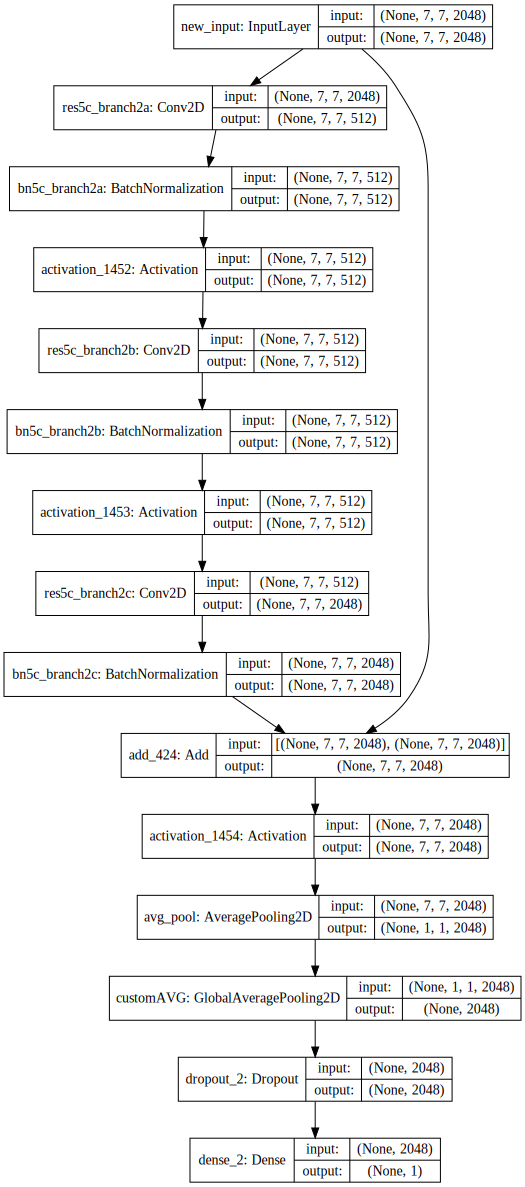

In [25]:

SVG(model_to_dot(final_model,show_shapes=True).create(prog='dot', format='svg'))

----

# 迁移学习 - Finetuning - 锁层

In [2]:
# from helper import *
# import imp
# imp.reload(helper)
from helper import *
from keras.callbacks import *

In [2]:
def run_finetuning_model(MODEL, image_size, n_trainable_layer, preprocess_func=None, epochs_max=20,augmented=False,apply_pretrain_weights=False,optimizer="adadelta",dropout=True):
    # Create Model
#     optimizer = optimizers.SGD(lr=0.001, decay=0, momentum=0.9,nesterov=True)
#     optimizer = optimizers.SGD()
#     optimizer = "adadelta"
    final_model = create_model_fine_whole(MODEL, image_size, 
                                          n_trainable_layer,
                                          optimizer=optimizer,
                                         apply_pretrain_weights=apply_pretrain_weights,
                                         dropout=dropout)
    # Fit Model
    final_model,history = fit_model_fine_whole(final_model, MODEL.__name__, image_size,
                                   n_trainable_layer=n_trainable_layer,
                                   preprocess_func=preprocess_func,
                                   epochs_max=epochs_max,
                                   auto_save=True,
                                    augmented=augmented)

    # Test Model and output Predicts
    print("Testing Model...")
    
    suffix = "loadweight_" if apply_pretrain_weights else ""
    suffix += "lastopen{}".format(n_trainable_layer)
    if augmented:
        suffix += "_augmented"
    test_generator_to_csv(final_model, image_size, csv_filename=get_filename(MODEL.__name__, "fine", suffix,ext="csv"))
    return final_model, history

### 第一阶段-快速收敛输出层权重

In [10]:
from keras.optimizers import *
final_model = create_model_fine_whole(ResNet50, (224,224), 
                                          n_trainable_layer = 0,
                                          optimizer="adadelta",
                                         apply_pretrain_weights=False)

Creating Model...
model created


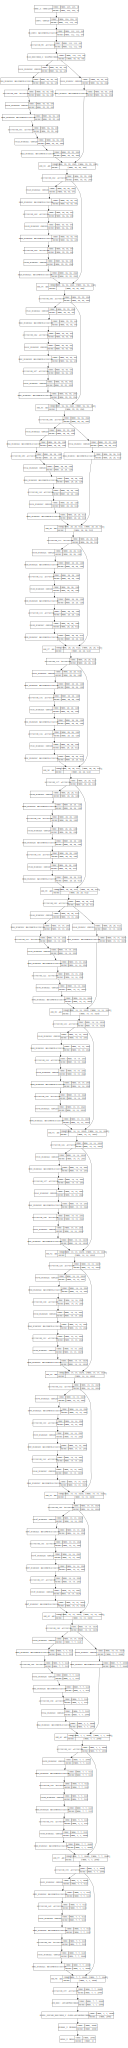

In [11]:
SVG(model_to_dot(final_model,show_shapes=True).create(prog='dot', format='svg'))

In [13]:
fit_model_fine_whole(final_model, "ResNet50", (224,224),
                                   n_trainable_layer=0,
                                   preprocess_func=resnet50.preprocess_input,
                                   epochs_max=5,
                                   auto_save=True,
                                    augmented=False)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Fitting Model...
Epoch 1/5
157/157 [==============================] - 194s 1s/step - loss: 0.1893 - acc: 0.9237 - val_loss: 0.0583 - val_acc: 0.9798
Epoch 2/5
157/157 [==============================] - 193s 1s/step - loss: 0.0848 - acc: 0.9690 - val_loss: 0.0476 - val_acc: 0.9832
Epoch 3/5
157/157 [==============================] - 193s 1s/step - loss: 0.0711 - acc: 0.9731 - val_loss: 0.0589 - val_acc: 0.9782
Epoch 4/5
157/157 [==============================] - 194s 1s/step - loss: 0.0665 - acc: 0.9747 - val_loss: 0.0445 - val_acc: 0.9854
Epoch 5/5
157/157 [==============================] - 194s 1s/step - loss: 0.0672 - acc: 0.9758 - val_loss: 0.0514 - val_acc: 0.9830


(<keras.engine.training.Model at 0x7f6d9b2f0828>,
 <keras.callbacks.History at 0x7f6d89308198>)

### 第二阶段-FineTuning最后的block和输出层

In [31]:
n_trainable_fromlastlayer = 8

untrainable_num = len(final_model.layers)-n_trainable_fromlastlayer
for i, layer in enumerate(final_model.layers):
    layer.trainable = i>=untrainable_num

sgd = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9)
final_model.compile(optimizer=sgd,
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [34]:
history=fit_model_fine_whole(final_model, "ResNet50", (224,224),
                                   n_trainable_layer=5,
                                   preprocess_func=resnet50.preprocess_input,
                                   epochs_max=50,
                                   auto_save=True,
                                    augmented=False)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Fitting Model...
Epoch 1/50
157/157 [==============================] - 198s 1s/step - loss: 0.0593 - acc: 0.9790 - val_loss: 0.0541 - val_acc: 0.9808
Epoch 2/50
157/157 [==============================] - 196s 1s/step - loss: 0.0594 - acc: 0.9778 - val_loss: 0.0553 - val_acc: 0.9802
Epoch 3/50
157/157 [==============================] - 197s 1s/step - loss: 0.0590 - acc: 0.9779 - val_loss: 0.0535 - val_acc: 0.9810
Epoch 4/50
157/157 [==============================] - 197s 1s/step - loss: 0.0589 - acc: 0.9777 - val_loss: 0.0539 - val_acc: 0.9810
Epoch 5/50
157/157 [==============================] - 196s 1s/step - loss: 0.0573 - acc: 0.9788 - val_loss: 0.0540 - val_acc: 0.9812
Epoch 6/50
157/157 [==============================] - 196s 1s/step - loss: 0.0559 - acc: 0.9783 - val_loss: 0.0540 - val_acc: 0.9810
Epoch 7/50
157/157 [==============================] - 197s 1s/step - loss: 0.0557 - acc: 0.9793 - va

### 测试并输出CSV

In [15]:
test_generator_to_csv(final_model, (224,224), csv_filename=get_filename("ResNet50", "fine", "trainable_layers_training",ext="csv"))

Found 12500 images belonging to 1 classes.
98/98 [==============================] - 110s 1s/step
Found 12500 images belonging to 1 classes.
   id     label
0   1  0.992661
1   2  0.995000
2   3  0.995000
3   4  0.995000
4   5  0.005000
5   6  0.005000
6   7  0.005000
7   8  0.005000
8   9  0.005000
9  10  0.005000
CSV文件已保存至csv_output/fine_ResNet50_trainable_layers_training.csv


/home/ubuntu/cats_dogs/helper.py:484: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index - 1, 'label', predict[i])


### 独立Finetuning-不分步骤（该步骤与上方独立）

In [5]:

model,history = run_finetuning_model(ResNet50,(224,224),
                     n_trainable_layer=11,
                     preprocess_func=resnet50.preprocess_input,
                     epochs_max=20,
                     augmented=True,
                     apply_pretrain_weights=True)

Creating Model...
model created
ResNet50 pretrained output weights applyed to new model:[array([[ 0.02405468],
       [ 0.04063614],
       [-0.007013  ],
       ...,
       [ 0.02188864],
       [-0.09470217],
       [ 0.12757942]], dtype=float32), array([0.05355521], dtype=float32)]
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Fitting Model...
Epoch 1/20
157/157 [==============================] - 278s 2s/step - loss: 0.0894 - acc: 0.9658 - val_loss: 0.0424 - val_acc: 0.9850
Epoch 2/20
157/157 [==============================] - 241s 2s/step - loss: 0.0784 - acc: 0.9695 - val_loss: 0.0483 - val_acc: 0.9836
Epoch 3/20
157/157 [==============================] - 243s 2s/step - loss: 0.0706 - acc: 0.9730 - val_loss: 0.0477 - val_acc: 0.9836
Epoch 4/20
157/157 [==============================] - 244s 2s/step - loss: 0.0654 - acc: 0.9744 - val_loss: 0.0346 - val_acc: 0.9862
Epoch 5/20
157/157 [==============================] - 242s 2s/step - loss: 0.063

/home/ubuntu/cats_dogs/helper.py:484: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index - 1, 'label', predict[i])


----

### 验证-显示模型预测产生最多loss的图片

In [3]:
model = create_IncXceRes_model_merge()

model created


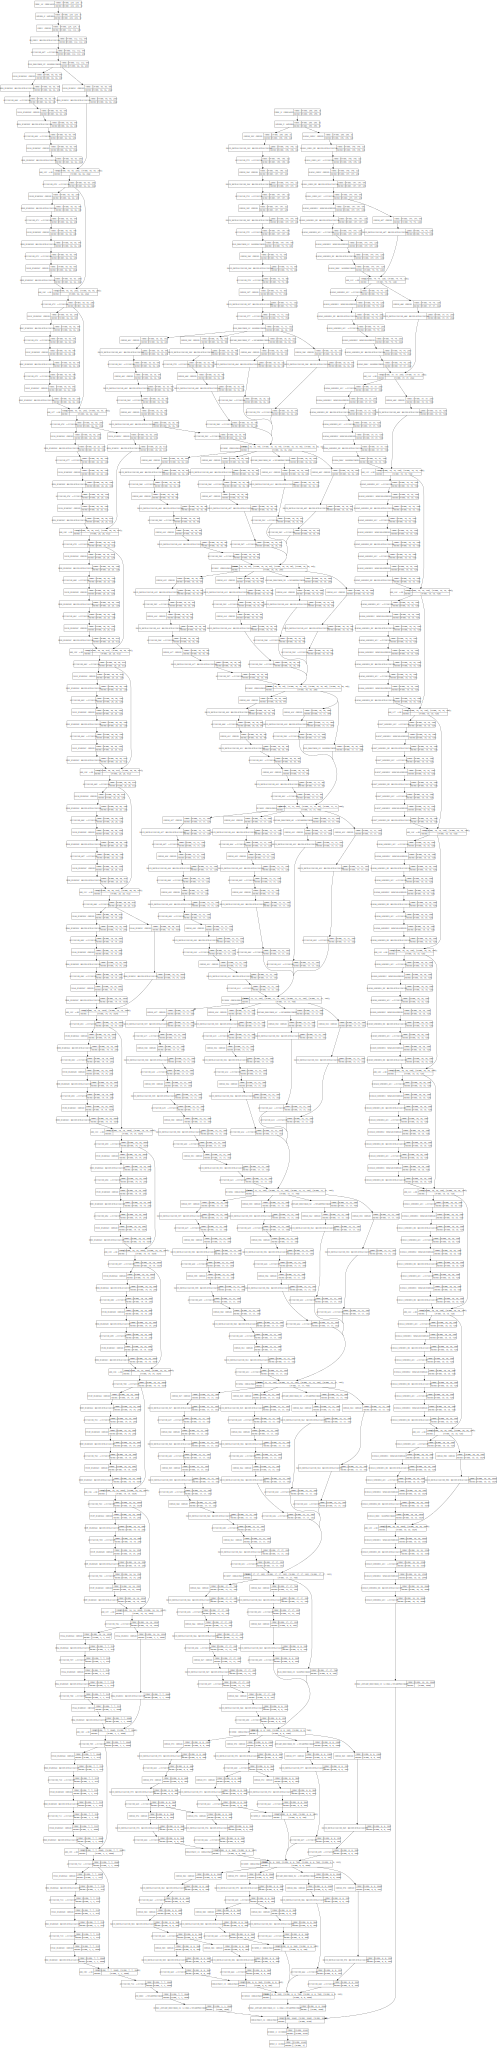

In [35]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

读取HyperOpt生成的trial文件，找出最佳模型路径并读取。最后把模型全连接层权重赋予新模型

In [4]:
datafile = open("trial.pckl","rb")
trial = pickle.load(datafile)
datafile.close()

trial_sorted = sorted(trial.results, key=lambda t: t["eval"]["loss"]) 

path = trial_sorted[0]["path"]["model"]
best_model = load_model(path)
output_weights = best_model.layers[-1].get_weights()

model.layers[-1].set_weights(output_weights)
print("Done")

Done


In [5]:
total_count = 12500*2

In [6]:
x_res,y = load_train_data_original(224,total_count=total_count,split=False)

100%|██████████| 12500/12500 [01:27<00:00, 142.59it/s]


In [7]:
x_incXce,y= load_train_data_original(299,total_count=total_count,split=False)

100%|██████████| 12500/12500 [01:06<00:00, 187.67it/s]


In [8]:
y_pred = model.predict([x_incXce,x_res],batch_size=128,verbose=1)

25000/25000 [==============================] - 1066s 43ms/step


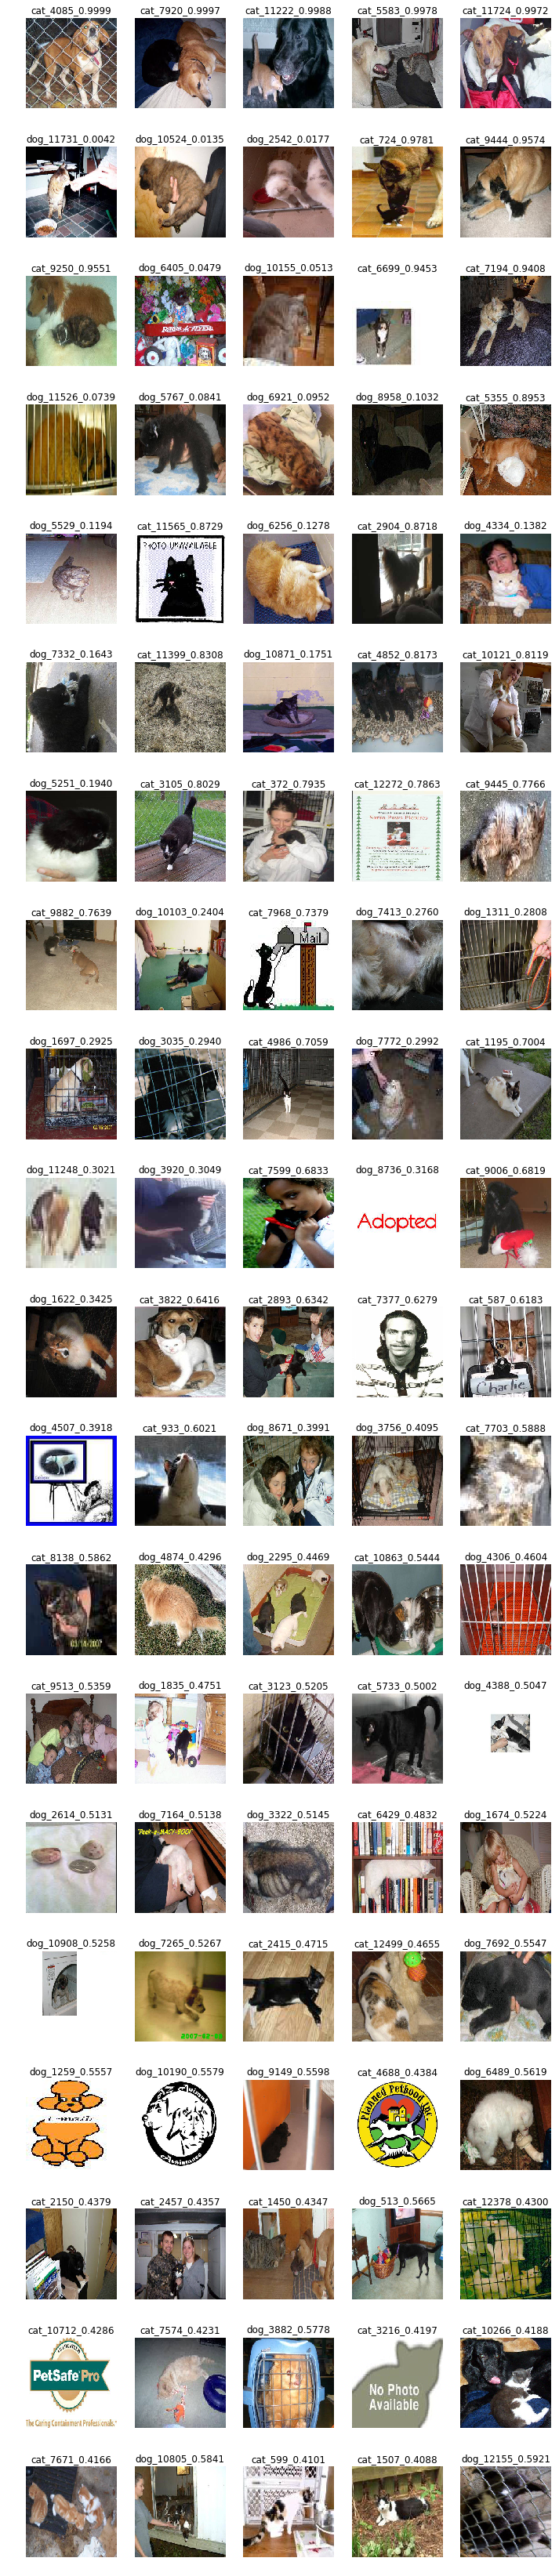

In [9]:

show_most_loss_img(x_incXce,y,y_pred,img_num=100)